# Advanced Lane Lines
## imports and variables


In [47]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Provided images use chessboard size of 9x6
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

debug = False

# Camera Calibration
## utility methods

In [2]:
## utility methods 
## starter code from https://github.com/udacity/CarND-Camera-Calibration

def calibrate():
    objp = np.zeros((ny*nx,3), np.float32) # prepare object points, like (0,0,0), (1,0,0) ...
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # glob a list from calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Process calibration images
    for idx, fname in enumerate(images):
        #img = 
        gray = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        if ret == True: # # If success, add points
            objpoints.append(objp)
            imgpoints.append(corners)
            
    _, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return mtx, dist

def corners_unwarp(img, nx, ny, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True: # corners were found
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            src = np.float32([corners[0], corners[nx-1],
                corners[len(corners[:])-nx], corners[len(corners[:])-1]])
            offset = 100; # specify an offset to map the unwarped into
            dst = np.float32([[offset,offset], [gray.shape[1]-offset,offset],
                [offset,gray.shape[0]-offset], [gray.shape[1]-offset,gray.shape[0]-offset]])
            Minv = cv2.getPerspectiveTransform(dst, src)
            M = cv2.getPerspectiveTransform(src, dst)
            warped = cv2.warpPerspective(undist, M, (img.shape[1], img.shape[0]), 
                flags=cv2.INTER_LINEAR)
    return warped, M, Minv

# Camera Calibration
## Validate calibration and unwarping 

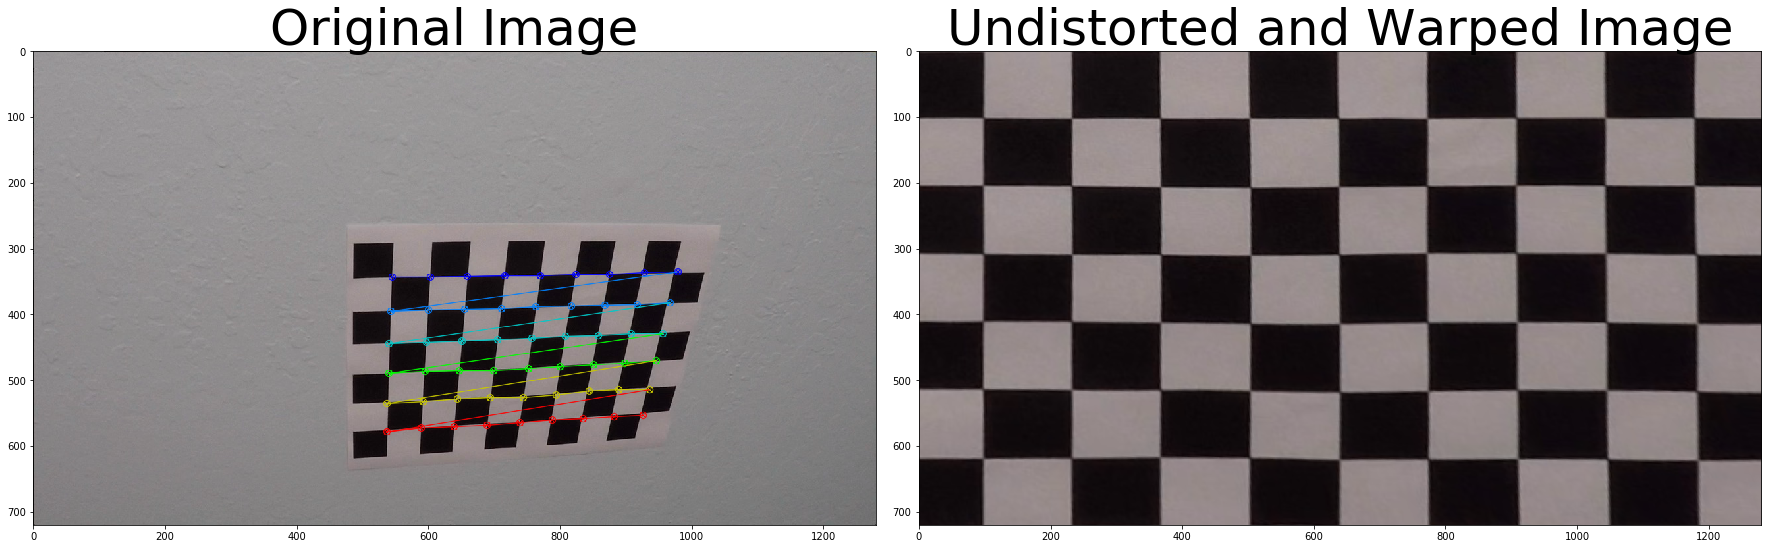

In [3]:
mtx, dist = calibrate()

# Read in an image
img = cv2.imread('camera_cal/calibration10.jpg')

top_down, perspective_M, perspective_Minv = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Determine Region of Interest

Superimpose multiple test images to get a good bounding box

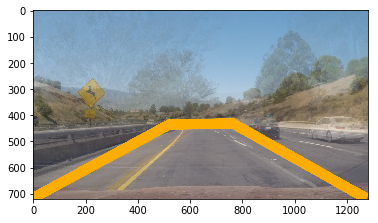

In [4]:
img = cv2.imread("superimpose_region_of_interest.jpg");
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

# Create Pipeline

In [5]:
##### starter code from CarND module: "30. Color and Gradient module"

# Define a function that applies Sobel x and y, then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)): ## FROM "22. Magnitude of Gradient" course module
    
    # Apply the following steps to img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)                   # 1) Convert to grayscale
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # 2) Take the gradient in x and y separately
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(sobelx*sobelx + sobely*sobely)                   # 3) Calculate the magnitude
    scaled_mag = np.uint8(255*mag/np.max(mag))                     # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    binary_output =  np.zeros_like(scaled_mag)                     # 5) Create a binary mask where mag thresholds are met
    binary_output[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1
    return binary_output                                           # 6) Return this mask as your binary_output image

# Define a function that applies Sobel x and y, then computes the direction of the gradient
# and applies a threshold.
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)): ## from "23. Direction of the gradient" course module
    
    # Apply the following steps to img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)                   # 1) Convert to grayscale
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # 2) Take the gradient in x and y separately
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)                               # 3) Take the absolute value of the x and y gradients
    abs_sobely = np.absolute(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)                 # 4) Calculate the direction of the gradient
    binary_output = np.zeros_like(direction)                       # 5) Create a binary mask where direction thresholds are met
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output                                            # 6) Return this mask as your binary_output image

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255): ## from "21. Applying Sobel" course module
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)                     # Convert to grayscale
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))   # Apply x|y gradient with  OPenCV Sobel() function
    if orient == 'y':                                                # and take the absolute value
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))         # Rescale back to 8 bit integer
    binary_output = np.zeros_like(scaled_sobel)                      # Create a copy and apply the threshold
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output                                             # Return the result

def hls_thresh(img, h_threshold=(0,180), l_threshold=(0,255), s_threshold=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    H = hls[:,:,0] ##  range is 0..180
    L = hls[:,:,1] ##  range is 0..255
    S = hls[:,:,2] ##  range is 0..255
            
    binary_output = np.zeros_like(H)
    binary_output[
        (H >= h_threshold[0]) & (H <= h_threshold[1]) &
        (S >= s_threshold[0]) & (S <= s_threshold[1]) &
        (L >= l_threshold[0]) & (L <= l_threshold[1])
    ] = 1
    return binary_output


def carnd_camera(): # parameters for carnd videos, settings for region_of_interest
    w, h, h_clip_factor = 1280, 720, 0.50
    vertices = np.array([[(w*.04, h), (w*.45, h*h_clip_factor), (w*.54, h*h_clip_factor), (w*.96, h)]], dtype=np.int32)
    return vertices, h_clip_factor

def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """    
    vertices, clip = carnd_camera()
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        matched_mask_color = (1.0,) * channel_count
    else:
        matched_mask_color = 1
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, matched_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = np.zeros_like(img)
    cv2.bitwise_and(src1=img, src2=mask, dst=masked_image)
    return masked_image

"""
pipeline() processes an iput image, applying several filters and returning a binarized 
image where white pixels indicate evidence of lane lanes, and black pixels represent 
an absence of lane lines
"""
def pipeline(img, detailed=False):
    img = np.copy(img)
    
    # Sobel x,y
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=20)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=20)
    
    # in HLS, H 0..180, yellow = 20,30
    yellow_binary = hls_thresh(img, h_threshold=(20,35), l_threshold=(0,255), s_threshold=(0,255))
    white_binary = hls_thresh(img, h_threshold=(0,180), l_threshold=(200,255), s_threshold=(0,255))
    mag_binary = mag_thresh(img, mag_thresh=(50, 255))
    dir_binary = dir_thresh(img, thresh=(11/32 * np.pi, 13/32 * np.pi))
    
    #color_binary = np.dstack((np.zeros_like(gradx), gradx, yellow_binary))
    
    combined = np.zeros_like(yellow_binary)  # from "24.Combining Thresholds" course module
    combined[(((yellow_binary == 1) | (white_binary == 1)))] = 1
    combined = region_of_interest(combined)
    
    if detailed:
        return gradx, grady, yellow_binary, white_binary, mag_binary, dir_binary, combined
    else:
        return combined

# Test the Pipeline

## utility methods

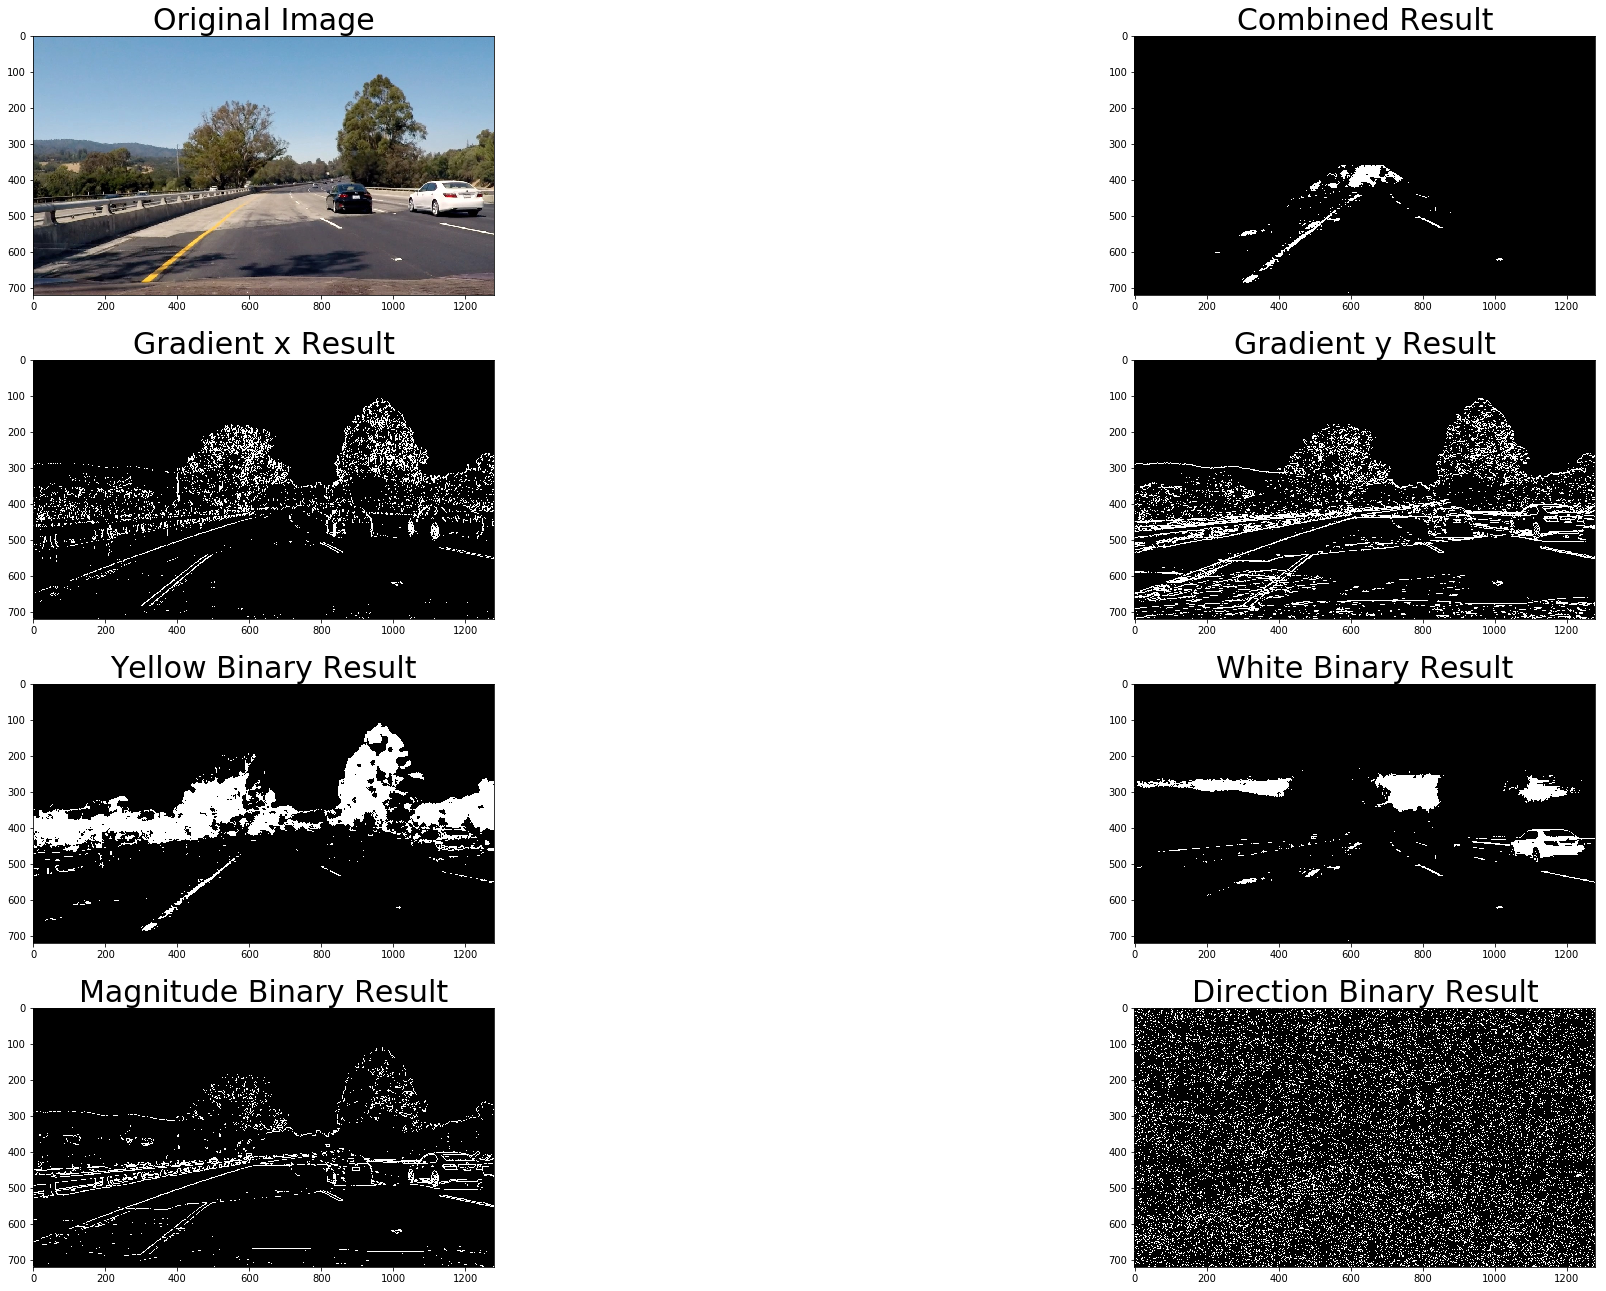

In [6]:
image = mpimg.imread('test_images/test4.jpg')
gradx, grady, yellow_binary, white_binary, mag_binary, dir_binary, binary_result = pipeline(image, detailed=True)

f, axes = plt.subplots(4, 2, figsize=(30, 9)) # Plot the result
f.tight_layout()

axes[0,0].imshow(image)
axes[0,0].set_title('Original Image', fontsize=30)
axes[0,1].imshow(binary_result, cmap='gray')
axes[0,1].set_title('Combined Result', fontsize=30)

axes[1,0].imshow(gradx, cmap='gray')
axes[1,0].set_title('Gradient x Result', fontsize=30)
axes[1,1].imshow(grady, cmap='gray')
axes[1,1].set_title('Gradient y Result', fontsize=30)

axes[2,0].imshow(yellow_binary, cmap='gray')
axes[2,0].set_title('Yellow Binary Result', fontsize=30)
axes[2,1].imshow(white_binary, cmap='gray')
axes[2,1].set_title('White Binary Result', fontsize=30)

axes[3,0].imshow(mag_binary, cmap='gray')
axes[3,0].set_title('Magnitude Binary Result', fontsize=30)
axes[3,1].imshow(dir_binary, cmap='gray')
axes[3,1].set_title('Direction Binary Result', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=1.9, bottom=0.)

In [23]:
"""
transform forward-facing vehicle camera image to a topdown view 
"""
def warp(img):
    shape = (img.shape[1], img.shape[0])
    if debug:
        print("transforming forward camera image to topdown view, img shape = {}".format(shape))
    from_box = np.float32([[310,681],[567,485],[788,485],[1022,681]])
    offset=np.float32([200,0])
    src = np.float32([from_box[0],from_box[1],from_box[2],from_box[3]])
    dst = np.float32([np.array([0,shape[1]]) + np.array(offset),
                      np.array([0,0.5*shape[1]]) + np.array(offset),
                      np.array([shape[0],0.5*img.shape[0]]) - np.array(offset),
                      np.array([shape[0],img.shape[0]]) - np.array(offset)
        ])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, shape, flags=cv2.INTER_LINEAR)  
    return warped, M, Minv

def forwardCameraToBirdsEye(img):
    binary_result = pipeline(img, detailed=False)
    img_warped,M,Minv = warp(cv2.undistort(img, mtx, dist, None, mtx))
    binary_warped,M,Minv = warp(cv2.undistort(binary_result, mtx, dist, None, mtx))
    return img_warped, binary_warped, M, Minv



# Perspective transform
## validation

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)


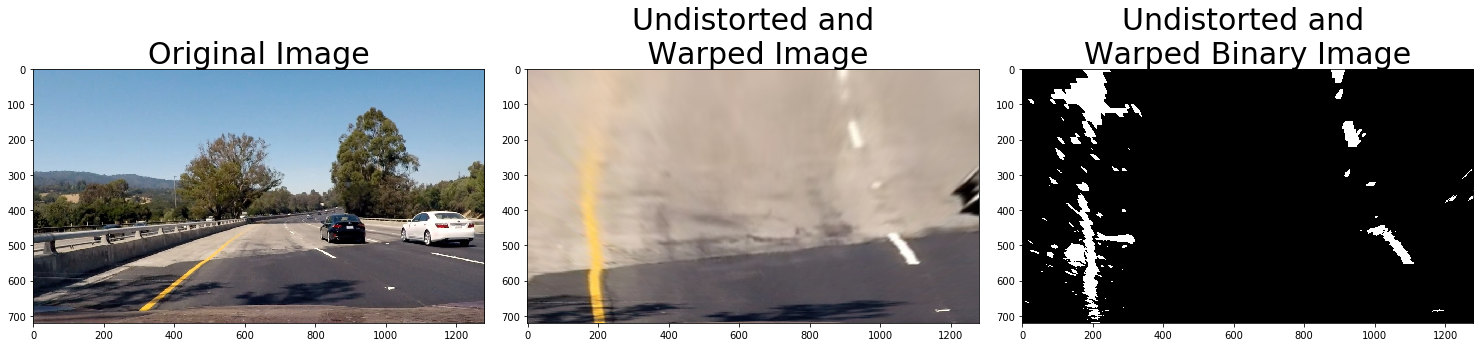

In [25]:
image = mpimg.imread('test_images/test4.jpg')
img_warped, binary_warped, M, Minv = forwardCameraToBirdsEye(image)
                        
f, axes = plt.subplots(1, 3, figsize=(20, 9))
f.tight_layout()
axes[0].imshow(image)
axes[0].set_title('Original Image', fontsize=30)
axes[1].imshow(img_warped)
axes[1].set_title('Undistorted and\n Warped Image', fontsize=30)
axes[2].imshow(binary_warped, cmap='gray')
axes[2].set_title('Undistorted and \nWarped Binary Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=1.7, bottom=0.)

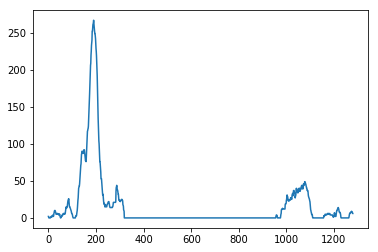

In [26]:
# visualize the peaks from the bottom half of the image

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

Lane Lines

Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?
Methods have been used to identify lane line pixels in the rectified binary image. The left and right line have been identified and fit with a curved functional form (e.g., spine or polynomial). Example images with line pixels identified and a fit overplotted should be included in the writeup (or saved to a folder) and submitted with the project.

In [27]:
## from "33. Finding the lines" in CardND course module

def detectLanes(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    bottom_rows = binary_warped.shape[0]//2
    histogram = np.sum(binary_warped[bottom_rows:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9 ## number of sliding windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Create an output image to draw on and visualize the result
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped)) * 255).astype(np.uint8)


    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 100 ## width of the windows +/- margin
    minpix = 50  ## minimum number of pixels found to recenter window

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []


    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        if debug:
            print("{} {} {} {} {} {}".format(win_y_low, win_y_high, 
                                             win_xleft_low, win_xleft_high,
                                             win_xright_low, win_xright_high))
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 4) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 4) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    left_curverad, right_curverad = calculateCurvature(left_fit, right_fit, left_fitx, right_fitx, ploty)
    
    #todo determine distance from center
    distance = 0;

    return  out_img, nonzerox, nonzeroy, left_fit, right_fit, left_fitx, right_fitx, ploty, \
        left_curverad, right_curverad, distance



def calculateCurvature(left_fit, right_fit, left_fitx, right_fitx, ploty): ## starter code from "35. Measuring Curvature" course module
    
    ## calculate radius of curvature at bottom of the screen (or, essentially, at the from bumper)
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fitx[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    if debug:
        print(left_curverad, right_curverad)     ## note, units are in screen space

    # convert to real world, define conversions in x and y from pixels space to meters
    #v TODO remove (or document) magic numbers!
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    if debug:
        print(left_curverad, '(m), ', right_curverad, '(m)')

    return left_curverad, right_curverad


## Visualize

## Plot back to image

640 720 90 290 977 1177
560 640 102 302 1067 1267
480 560 89 289 1067 1267
400 480 79 279 982 1182
320 400 93 293 918 1118
240 320 69 269 887 1087
160 240 58 258 826 1026
80 160 65 265 834 1034
0 80 90 290 818 1018
18749348972.7 2077.80245594
869.121717176 (m),  345.656675749 (m)


(720, 0)

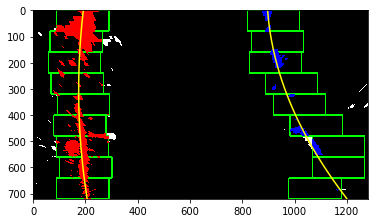

In [18]:
# also from "33. Finding the lines" in CardND course module

out_img, nonzerox, nonzeroy, left_fit, right_fit, left_fitx, right_fitx, ploty, \
    left_curverad, right_curverad, distance = detectLanes(binary_warped)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [39]:
def backPlot(image, Minv, mtx, dist, binary_warped, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result


## Validate back plotter 

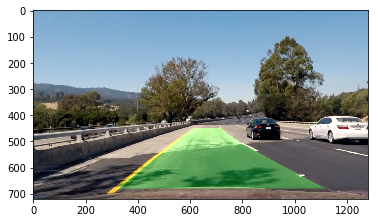

In [41]:
result = backPlot(image, Minv, mtx, dist, binary_warped, left_fitx, right_fitx, ploty)
plt.imshow(result)

In [48]:
def process_image(image):
    # NOTE: return processed image for video processing, below 
    # mtx and dist must already be set globally
    
    img_warped, binary_warped, M, Minv = forwardCameraToBirdsEye(image)
    
    out_img, nonzerox, nonzeroy, left_fit, right_fit, left_fitx, right_fitx, ploty, \
        left_curverad, right_curverad, distance = detectLanes(binary_warped)
         
    result = backPlot(image, Minv, mtx, dist, binary_warped, left_fitx, right_fitx, ploty)
    
    return result 


transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 90 290 977 1177
560 640 102 302 1067 1267
480 560 89 289 1067 1267
400 480 79 279 982 1182
320 400 93 293 918 1118
240 320 69 269 887 1087
160 240 58 258 826 1026
80 160 65 265 834 1034
0 80 90 290 818 1018
18749348972.7 2077.80245594
869.121717176 (m),  345.656675749 (m)


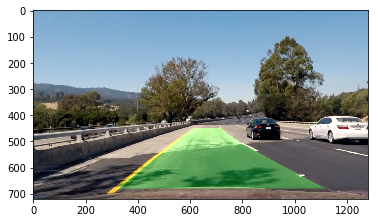

In [45]:
# unit test the processor
testImage = mpimg.imread('test_images/test4.jpg')
result = process_image(testImage)
plt.imshow(result)

# Main Attraction

In [49]:
output = 'output_videos/advanced_lane_lines.mp4'
clip1 = VideoFileClip("project_video.mp4")

#####vertices, h_clip_factor = carnd_camera();

white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(output, audio=False)

HTML("""<video width="640" height="360" controls><source src="{0}"></video>""".format(output))

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 1013 1213
560 640 121 321 1013 1213
480 560 107 307 1015 1215
400 480 90 290 972 1172
320 400 70 270 876 1076
240 320 41 241 876 1076
160 240 14 214 789 989
80 160 -26 174 732 932
0 80 -26 174 732 932
58777594.0159 10557.3078651
446.293319754 (m),  1829.2490487 (m)
[MoviePy] >>>> Building video output_videos/advanced_lane_lines.mp4
[MoviePy] Writing video output_videos/advanced_lane_lines.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)


  0%|          | 1/1261 [00:00<05:45,  3.64it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 1013 1213
560 640 121 321 1013 1213
480 560 107 307 1015 1215
400 480 90 290 972 1172
320 400 70 270 876 1076
240 320 41 241 876 1076
160 240 14 214 789 989
80 160 -26 174 732 932
0 80 -26 174 732 932
58777594.0159 10557.3078651
446.293319754 (m),  1829.2490487 (m)


  0%|          | 2/1261 [00:00<05:42,  3.68it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 103 303 1032 1232
560 640 122 322 1051 1251
480 560 109 309 1018 1218
400 480 90 290 980 1180
320 400 73 273 888 1088
240 320 39 239 798 998
160 240 -6 194 756 956
80 160 -25 175 756 956
0 80 -68 132 756 956
183565516.166 4285.26049805
408.362424542 (m),  759.50696698 (m)


  0%|          | 3/1261 [00:00<05:38,  3.72it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 105 305 1055 1255
560 640 123 323 1063 1263
480 560 109 309 1022 1222
400 480 93 293 1022 1222
320 400 70 270 1022 1222
240 320 43 243 1022 1222
160 240 9 209 1022 1222
80 160 -25 175 1022 1222
0 80 -25 175 1022 1222
134324133.846 729.481837935
398.100167459 (m),  161.058416489 (m)


  0%|          | 4/1261 [00:01<05:39,  3.70it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 1076 1276
560 640 123 323 1074 1274
480 560 112 312 1032 1232
400 480 96 296 1032 1232
320 400 66 266 1032 1232
240 320 48 248 1032 1232
160 240 5 205 1032 1232
80 160 -11 189 1032 1232
0 80 -11 189 1032 1232
114091210.849 1829.71616602
415.519383499 (m),  377.419361799 (m)


  0%|          | 5/1261 [00:01<05:37,  3.72it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 110 310 1077 1277
560 640 124 324 1076 1276
480 560 114 314 1042 1242
400 480 95 295 950 1150
320 400 71 271 856 1056
240 320 46 246 817 1017
160 240 12 212 817 1017
80 160 -38 162 817 1017
0 80 -38 162 817 1017
335112720.264 2086.82276891
328.817037349 (m),  400.806281226 (m)


  0%|          | 6/1261 [00:01<05:37,  3.72it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 113 313 1078 1278
560 640 127 327 1083 1283
480 560 114 314 1083 1283
400 480 98 298 1083 1283
320 400 72 272 1083 1283
240 320 45 245 1083 1283
160 240 11 211 1083 1283
80 160 -29 171 1083 1283
0 80 -29 171 1083 1283
278614596.51 583.936429472
348.756703235 (m),  110.668496805 (m)


  1%|          | 7/1261 [00:01<05:34,  3.75it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 118 318 878 1078
560 640 129 329 878 1078
480 560 114 314 878 1078
400 480 97 297 878 1078
320 400 69 269 869 1069
240 320 43 243 835 1035
160 240 10 210 835 1035
80 160 -38 162 835 1035
0 80 -74 126 835 1035
368092842.78 10284.4994439
349.5922187 (m),  1563.83138197 (m)


  1%|          | 8/1261 [00:02<05:31,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 120 320 849 1049
560 640 131 331 849 1049
480 560 117 317 849 1049
400 480 96 296 910 1110
320 400 72 272 875 1075
240 320 42 242 844 1044
160 240 10 210 750 950
80 160 -47 153 660 860
0 80 -47 153 660 860
356292929.184 944.643814918
355.25193087 (m),  236.959000433 (m)


  1%|          | 9/1261 [00:02<05:29,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 121 321 893 1093
560 640 130 330 893 1093
480 560 115 315 893 1093
400 480 93 293 924 1124
320 400 70 270 885 1085
240 320 42 242 885 1085
160 240 8 208 885 1085
80 160 -45 155 885 1085
0 80 -87 113 885 1085
348573227.245 2426.97638134
367.117413308 (m),  168.398287936 (m)


  1%|          | 10/1261 [00:02<05:29,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 120 320 931 1131
560 640 129 329 931 1131
480 560 116 316 931 1131
400 480 95 295 934 1134
320 400 66 266 895 1095
240 320 40 240 895 1095
160 240 4 204 895 1095
80 160 -43 157 895 1095
0 80 -74 126 895 1095
451480245.867 7020.75113914
379.935596578 (m),  898.094938341 (m)


  1%|          | 11/1261 [00:02<05:28,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 118 318 955 1155
560 640 129 329 955 1155
480 560 115 315 955 1155
400 480 94 294 943 1143
320 400 65 265 904 1104
240 320 30 230 808 1008
160 240 0 200 713 913
80 160 -44 156 664 864
0 80 -79 121 664 864
489900326.312 2013.61726706
422.358286493 (m),  387.834322148 (m)


  1%|          | 12/1261 [00:03<05:37,  3.70it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 117 317 980 1180
560 640 126 326 980 1180
480 560 109 309 992 1192
400 480 86 286 953 1153
320 400 60 260 953 1153
240 320 26 226 953 1153
160 240 -6 194 953 1153
80 160 -44 156 953 1153
0 80 -91 109 953 1153
562332477.3 777.140417807
431.75662757 (m),  190.136092959 (m)


  1%|          | 13/1261 [00:03<05:43,  3.64it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 119 319 977 1177
560 640 127 327 977 1177
480 560 111 311 1002 1202
400 480 88 288 961 1161
320 400 62 262 961 1161
240 320 25 225 961 1161
160 240 -5 195 961 1161
80 160 -72 128 961 1161
0 80 -90 110 961 1161
949177680.893 3494.62591863
367.96797176 (m),  468.110275489 (m)


  1%|          | 14/1261 [00:03<05:44,  3.62it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 120 320 998 1198
560 640 128 328 998 1198
480 560 109 309 1012 1212
400 480 87 287 970 1170
320 400 59 259 970 1170
240 320 21 221 970 1170
160 240 -12 188 970 1170
80 160 -65 135 970 1170
0 80 -65 135 970 1170
999278318.697 8730.71914407
400.524093362 (m),  1314.85247852 (m)


  1%|          | 15/1261 [00:04<05:44,  3.61it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 112 312 1049 1249
560 640 129 329 1051 1251
480 560 107 307 1009 1209
400 480 88 288 1009 1209
320 400 62 262 1009 1209
240 320 15 215 1009 1209
160 240 -25 175 1009 1209
80 160 -48 152 1009 1209
0 80 -48 152 1009 1209
1228460574.42 1092.05954785
410.069150626 (m),  215.678745216 (m)


  1%|▏         | 16/1261 [00:04<05:47,  3.58it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 115 315 1067 1267
560 640 129 329 1060 1260
480 560 111 311 1015 1215
400 480 90 290 1015 1215
320 400 62 262 1015 1215
240 320 23 223 1015 1215
160 240 -9 191 1015 1215
80 160 -43 157 1015 1215
0 80 -43 157 1015 1215
896650883.524 1210.29512116
390.1652985 (m),  224.146449447 (m)


  1%|▏         | 17/1261 [00:04<05:52,  3.53it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 117 317 1079 1279
560 640 127 327 1064 1264
480 560 110 310 1025 1225
400 480 90 290 1025 1225
320 400 63 263 1025 1225
240 320 28 228 1025 1225
160 240 -7 193 1025 1225
80 160 -48 152 1025 1225
0 80 -85 115 1025 1225
542495362.423 10661.7080127
419.260517286 (m),  1699.13950889 (m)


  1%|▏         | 18/1261 [00:04<05:52,  3.53it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 117 317 1076 1276
560 640 125 325 1067 1267
480 560 110 310 1067 1267
400 480 87 287 1067 1267
320 400 57 257 1067 1267
240 320 27 227 1067 1267
160 240 8 208 1067 1267
80 160 -56 144 1067 1267
0 80 -84 116 1067 1267
396070480.169 32390.8031374
490.952045581 (m),  5303.6396729 (m)


  2%|▏         | 19/1261 [00:05<05:48,  3.56it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 114 314 823 1023
560 640 125 325 823 1023
480 560 108 308 823 1023
400 480 83 283 823 1023
320 400 53 253 837 1037
240 320 23 223 802 1002
160 240 1 201 802 1002
80 160 -56 144 802 1002
0 80 -85 115 802 1002
401216224.537 317.099490912
578.614058252 (m),  94.8625188488 (m)


  2%|▏         | 20/1261 [00:05<05:40,  3.64it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 110 310 844 1044
560 640 123 323 844 1044
480 560 105 305 844 1044
400 480 80 280 844 1044
320 400 49 249 850 1050
240 320 18 218 815 1015
160 240 -13 187 815 1015
80 160 -58 142 815 1015
0 80 -87 113 815 1015
415939530.725 7886.32185983
592.582111122 (m),  1387.92130131 (m)


  2%|▏         | 21/1261 [00:05<05:34,  3.71it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 112 312 887 1087
560 640 122 322 887 1087
480 560 100 300 887 1087
400 480 77 277 896 1096
320 400 51 251 861 1061
240 320 16 216 861 1061
160 240 -7 193 861 1061
80 160 -58 142 861 1061
0 80 -87 113 861 1061
381193047.334 2536.94879599
646.837010238 (m),  213.264787219 (m)


  2%|▏         | 22/1261 [00:05<05:41,  3.63it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 98 298 865 1065
560 640 119 319 865 1065
480 560 96 296 865 1065
400 480 74 274 911 1111
320 400 42 242 874 1074
240 320 15 215 874 1074
160 240 -16 184 874 1074
80 160 -55 145 874 1074
0 80 -90 110 874 1074
507623439.231 2171.57143418
660.462309919 (m),  155.053136836 (m)


  2%|▏         | 23/1261 [00:06<05:37,  3.67it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 98 298 931 1131
560 640 115 315 931 1131
480 560 94 294 931 1131
400 480 69 269 926 1126
320 400 39 239 888 1088
240 320 10 210 888 1088
160 240 -22 178 888 1088
80 160 -59 141 888 1088
0 80 -74 126 888 1088
543052640.931 11603.6046268
723.16610029 (m),  1724.85270164 (m)


  2%|▏         | 24/1261 [00:06<05:38,  3.65it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 105 305 953 1153
560 640 113 313 953 1153
480 560 94 294 965 1165
400 480 65 265 934 1134
320 400 40 240 897 1097
240 320 9 209 805 1005
160 240 -28 172 712 912
80 160 -59 141 666 866
0 80 -85 115 666 866
421629948.631 1591.81881631
839.277054257 (m),  342.703193837 (m)


  2%|▏         | 25/1261 [00:06<05:39,  3.64it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 104 304 971 1171
560 640 112 312 971 1171
480 560 94 294 977 1177
400 480 63 263 939 1139
320 400 37 237 939 1139
240 320 11 211 939 1139
160 240 -16 184 939 1139
80 160 -61 139 939 1139
0 80 -90 110 939 1139
503819731.059 374.908125244
802.844052852 (m),  113.96788505 (m)


  2%|▏         | 26/1261 [00:07<05:37,  3.66it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 102 302 975 1175
560 640 108 308 975 1175
480 560 91 291 993 1193
400 480 60 260 954 1154
320 400 29 229 954 1154
240 320 16 216 954 1154
160 240 -20 180 954 1154
80 160 -58 142 954 1154
0 80 -91 109 954 1154
334062485.179 6658.82410728
1405.6598442 (m),  1074.89245516 (m)


  2%|▏         | 27/1261 [00:07<05:45,  3.58it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 63 263 1023 1223
560 640 108 308 1035 1235
480 560 83 283 1003 1203
400 480 59 259 965 1165
320 400 36 236 869 1069
240 320 16 216 776 976
160 240 -30 170 730 930
80 160 -60 140 687 887
0 80 -91 109 687 887
485371254.442 1665.80009031
732.990379872 (m),  347.349803506 (m)


  2%|▏         | 28/1261 [00:07<05:44,  3.57it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 50 250 1050 1250
560 640 104 304 1052 1252
480 560 79 279 1012 1212
400 480 57 257 1012 1212
320 400 37 237 1012 1212
240 320 10 210 1012 1212
160 240 -22 178 1012 1212
80 160 -52 148 1012 1212
0 80 -52 148 1012 1212
217670897.868 1726.64330133
873.621725912 (m),  349.945948829 (m)


  2%|▏         | 29/1261 [00:07<05:42,  3.59it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 63 263 1072 1272
560 640 102 302 1064 1264
480 560 81 281 1022 1222
400 480 60 260 1022 1222
320 400 41 241 1022 1222
240 320 17 217 1022 1222
160 240 -19 181 1022 1222
80 160 -53 147 1022 1222
0 80 -53 147 1022 1222
353249189.024 18434.9334899
589.510964017 (m),  3418.58687517 (m)


  2%|▏         | 30/1261 [00:08<05:41,  3.61it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 74 274 1057 1257
560 640 101 301 1065 1265
480 560 82 282 1032 1232
400 480 63 263 937 1137
320 400 43 243 937 1137
240 320 15 215 840 1040
160 240 -23 177 840 1040
80 160 -53 147 840 1040
0 80 -53 147 840 1040
477893924.131 4566.36700001
463.075607937 (m),  866.006896414 (m)


  2%|▏         | 31/1261 [00:08<05:39,  3.62it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 80 280 818 1018
560 640 100 300 818 1018
480 560 86 286 818 1018
400 480 68 268 818 1018
320 400 49 249 836 1036
240 320 17 217 810 1010
160 240 -15 185 810 1010
80 160 -66 134 810 1010
0 80 -66 134 810 1010
417004562.363 17821.949898
427.334339543 (m),  35.2810249084 (m)


  3%|▎         | 32/1261 [00:08<05:37,  3.64it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 91 291 838 1038
560 640 101 301 838 1038
480 560 89 289 838 1038
400 480 74 274 838 1038
320 400 54 254 847 1047
240 320 27 227 813 1013
160 240 -15 185 813 1013
80 160 -64 136 813 1013
0 80 -91 109 813 1013
630335292.555 12517.8131797
339.370549054 (m),  30.6986586899 (m)


  3%|▎         | 33/1261 [00:09<05:38,  3.62it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 855 1055
560 640 101 301 855 1055
480 560 89 289 855 1055
400 480 72 272 855 1055
320 400 57 257 862 1062
240 320 25 225 828 1028
160 240 -20 180 828 1028
80 160 -40 160 828 1028
0 80 -91 109 828 1028
453090469.391 349.372097371
352.778541914 (m),  112.886222843 (m)


  3%|▎         | 34/1261 [00:09<05:40,  3.60it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 96 296 880 1080
560 640 103 303 880 1080
480 560 90 290 880 1080
400 480 79 279 904 1104
320 400 56 256 868 1068
240 320 23 223 868 1068
160 240 -8 192 868 1068
80 160 -37 163 868 1068
0 80 -91 109 868 1068
552087583.567 302.928749014
322.83107528 (m),  63.6916046359 (m)


  3%|▎         | 35/1261 [00:09<05:42,  3.58it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 876 1076
560 640 104 304 876 1076
480 560 93 293 876 1076
400 480 79 279 917 1117
320 400 55 255 878 1078
240 320 28 228 878 1078
160 240 -4 196 878 1078
80 160 -41 159 878 1078
0 80 -91 109 878 1078
454870435.84 545.70523332
342.737832715 (m),  150.703463035 (m)


  3%|▎         | 36/1261 [00:09<05:39,  3.61it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 94 294 942 1142
560 640 109 309 942 1142
480 560 98 298 942 1142
400 480 85 285 927 1127
320 400 59 259 887 1087
240 320 28 228 794 994
160 240 -15 185 699 899
80 160 -40 160 649 849
0 80 -40 160 649 849
901893813.648 2154.8349551
297.384313753 (m),  401.654819761 (m)


  3%|▎         | 37/1261 [00:10<05:37,  3.63it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 100 300 959 1159
560 640 111 311 959 1159
480 560 99 299 969 1169
400 480 80 280 931 1131
320 400 58 258 931 1131
240 320 30 230 931 1131
160 240 -4 196 931 1131
80 160 -40 160 931 1131
0 80 -40 160 931 1131
427170885.25 544.72313274
362.800691076 (m),  143.052148319 (m)


  3%|▎         | 38/1261 [00:10<05:36,  3.63it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 102 302 982 1182
560 640 113 313 982 1182
480 560 102 302 979 1179
400 480 85 285 939 1139
320 400 62 262 939 1139
240 320 44 244 939 1139
160 240 -11 189 939 1139
80 160 -58 142 939 1139
0 80 -91 109 939 1139
794667297.669 2894.95903303
286.086315015 (m),  344.233031592 (m)


  3%|▎         | 39/1261 [00:10<05:38,  3.61it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 105 305 1003 1203
560 640 115 315 1003 1203
480 560 104 304 988 1188
400 480 86 286 946 1146
320 400 66 266 851 1051
240 320 41 241 755 955
160 240 -15 185 709 909
80 160 -66 134 709 909
0 80 -90 110 709 909
992151746.102 2100.38924393
262.689820563 (m),  381.737068628 (m)


  3%|▎         | 40/1261 [00:10<05:33,  3.66it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 105 305 1027 1227
560 640 116 316 1034 1234
480 560 101 301 992 1192
400 480 85 285 992 1192
320 400 65 265 992 1192
240 320 36 236 992 1192
160 240 -12 188 992 1192
80 160 -51 149 992 1192
0 80 -91 109 992 1192
987673396.905 6602.62301054
285.949880622 (m),  1047.58134159 (m)


  3%|▎         | 41/1261 [00:11<05:32,  3.66it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 105 305 1050 1250
560 640 118 318 1046 1246
480 560 103 303 1004 1204
400 480 84 284 1004 1204
320 400 66 266 1004 1204
240 320 38 238 1004 1204
160 240 -6 194 1004 1204
80 160 -64 136 1004 1204
0 80 -92 108 1004 1204
900984201.499 2550.41231387
296.717913423 (m),  441.163928141 (m)


  3%|▎         | 42/1261 [00:11<05:34,  3.65it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 1051 1251
560 640 118 318 1059 1259
480 560 103 303 1016 1216
400 480 84 284 1016 1216
320 400 64 264 1016 1216
240 320 29 229 1016 1216
160 240 -6 194 1016 1216
80 160 -67 133 1016 1216
0 80 -92 108 1016 1216
938224239.441 7006.71866334
293.154854931 (m),  1104.37736047 (m)


  3%|▎         | 43/1261 [00:11<05:42,  3.56it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 98 298 1075 1275
560 640 119 319 1061 1261
480 560 103 303 1061 1261
400 480 86 286 1061 1261
320 400 65 265 1061 1261
240 320 28 228 1061 1261
160 240 -9 191 1061 1261
80 160 -68 132 1061 1261
0 80 -92 108 1061 1261
1042600147.58 1351.40581379
300.237194807 (m),  198.615978124 (m)


  3%|▎         | 44/1261 [00:12<05:37,  3.61it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 1076 1276
560 640 117 317 1074 1274
480 560 99 299 1074 1274
400 480 83 283 1074 1274
320 400 62 262 1074 1274
240 320 28 228 1074 1274
160 240 -10 190 1074 1274
80 160 -68 132 1074 1274
0 80 -92 108 1074 1274
1073158575.59 185.622648236
304.12378683 (m),  42.3805194963 (m)


  4%|▎         | 45/1261 [00:12<05:35,  3.62it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 838 1038
560 640 117 317 838 1038
480 560 101 301 838 1038
400 480 85 285 838 1038
320 400 58 258 854 1054
240 320 23 223 818 1018
160 240 -19 181 818 1018
80 160 -71 129 818 1018
0 80 -96 104 818 1018
1231065427.56 3806.086616
305.483493158 (m),  693.703989834 (m)


  4%|▎         | 46/1261 [00:12<05:28,  3.69it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 883 1083
560 640 117 317 883 1083
480 560 101 301 883 1083
400 480 83 283 895 1095
320 400 56 256 864 1064
240 320 18 218 832 1032
160 240 -21 179 832 1032
80 160 -69 131 832 1032
0 80 -96 104 832 1032
1333757721.01 1754.45456338
320.28192742 (m),  375.946293365 (m)


  4%|▎         | 47/1261 [00:12<05:24,  3.74it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 906 1106
560 640 115 315 906 1106
480 560 101 301 906 1106
400 480 82 282 912 1112
320 400 52 252 873 1073
240 320 16 216 873 1073
160 240 -34 166 873 1073
80 160 -80 120 873 1073
0 80 -96 104 873 1073
2001602725.66 2292.76885693
295.699990911 (m),  114.225570147 (m)


  4%|▍         | 48/1261 [00:13<05:23,  3.75it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 928 1128
560 640 116 316 928 1128
480 560 102 302 928 1128
400 480 83 283 921 1121
320 400 52 252 882 1082
240 320 18 218 882 1082
160 240 -24 176 882 1082
80 160 -72 128 882 1082
0 80 -96 104 882 1082
1253217672.06 5497.66632856
345.806390253 (m),  664.736072761 (m)


  4%|▍         | 49/1261 [00:13<05:22,  3.75it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 105 305 954 1154
560 640 115 315 954 1154
480 560 101 301 954 1154
400 480 79 279 937 1137
320 400 48 248 895 1095
240 320 11 211 895 1095
160 240 -28 172 895 1095
80 160 -71 129 895 1095
0 80 -96 104 895 1095
1447389367.09 41124.925342
382.582156979 (m),  6325.65468726 (m)


  4%|▍         | 50/1261 [00:13<05:20,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 974 1174
560 640 115 315 974 1174
480 560 101 301 981 1181
400 480 78 278 940 1140
320 400 52 252 940 1140
240 320 12 212 940 1140
160 240 -28 172 940 1140
80 160 -74 126 940 1140
0 80 -96 104 940 1140
1421012096.87 961.810894374
392.336324325 (m),  214.276720121 (m)


  4%|▍         | 51/1261 [00:13<05:20,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 949 1149
560 640 116 316 949 1149
480 560 102 302 992 1192
400 480 77 277 950 1150
320 400 49 249 950 1150
240 320 12 212 950 1150
160 240 -30 170 950 1150
80 160 -74 126 950 1150
0 80 -96 104 950 1150
1508761382.25 2684.65818949
397.15239742 (m),  327.787329224 (m)


  4%|▍         | 52/1261 [00:14<05:19,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 108 308 992 1192
560 640 118 318 1034 1234
480 560 101 301 999 1199
400 480 77 277 958 1158
320 400 49 249 958 1158
240 320 11 211 958 1158
160 240 -33 167 958 1158
80 160 -72 128 958 1158
0 80 -96 104 958 1158
1519043292.59 9348.24652301
407.767264614 (m),  1354.84466235 (m)


  4%|▍         | 53/1261 [00:14<05:18,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 108 308 1039 1239
560 640 118 318 1043 1243
480 560 100 300 999 1199
400 480 75 275 999 1199
320 400 49 249 999 1199
240 320 9 209 999 1199
160 240 -30 170 999 1199
80 160 -68 132 999 1199
0 80 -92 108 999 1199
1207916285.01 759.915694846
476.559776426 (m),  159.027885265 (m)


  4%|▍         | 54/1261 [00:14<05:17,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 1040 1240
560 640 118 318 1053 1253
480 560 100 300 1010 1210
400 480 77 277 1010 1210
320 400 45 245 1010 1210
240 320 10 210 1010 1210
160 240 -35 165 1010 1210
80 160 -70 130 1010 1210
0 80 -92 108 1010 1210
1074595806.23 740.063515076
528.7395461 (m),  155.365830779 (m)


  4%|▍         | 55/1261 [00:14<05:16,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 94 294 799 999
560 640 116 316 799 999
480 560 97 297 799 999
400 480 72 272 799 999
320 400 42 242 798 998
240 320 4 204 780 980
160 240 -30 170 780 980
80 160 -67 133 780 980
0 80 -92 108 780 980
904953877.623 2121.91073166
638.828901266 (m),  41.3230267987 (m)


  4%|▍         | 56/1261 [00:15<05:14,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 105 305 814 1014
560 640 114 314 814 1014
480 560 95 295 814 1014
400 480 71 271 814 1014
320 400 40 240 825 1025
240 320 8 208 790 990
160 240 -29 171 790 990
80 160 -66 134 790 990
0 80 -92 108 790 990
832265913.02 11440.601409
648.904134898 (m),  32.0182715766 (m)


  5%|▍         | 57/1261 [00:15<05:17,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 105 305 841 1041
560 640 114 314 841 1041
480 560 95 295 841 1041
400 480 69 269 841 1041
320 400 35 235 838 1038
240 320 10 210 800 1000
160 240 -38 162 800 1000
80 160 -64 136 800 1000
0 80 -96 104 800 1000
1097080437.92 7732.20092213
583.00836471 (m),  29.4389931997 (m)


  5%|▍         | 58/1261 [00:15<05:20,  3.76it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 102 302 827 1027
560 640 112 312 827 1027
480 560 94 294 827 1027
400 480 67 267 827 1027
320 400 35 235 851 1051
240 320 8 208 812 1012
160 240 -33 167 812 1012
80 160 -69 131 812 1012
0 80 -96 104 812 1012
906873236.792 1204618.67667
694.663458065 (m),  175546.686848 (m)


  5%|▍         | 59/1261 [00:16<05:17,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 102 302 838 1038
560 640 113 313 838 1038
480 560 97 297 838 1038
400 480 67 267 891 1091
320 400 40 240 851 1051
240 320 19 219 851 1051
160 240 -25 175 851 1051
80 160 -66 134 851 1051
0 80 -96 104 851 1051
756295266.887 2535.4702085
584.741570569 (m),  110.412824371 (m)


  5%|▍         | 60/1261 [00:16<05:17,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 102 302 898 1098
560 640 114 314 898 1098
480 560 96 296 898 1098
400 480 67 267 902 1102
320 400 42 242 856 1056
240 320 17 217 856 1056
160 240 -18 182 856 1056
80 160 -63 137 856 1056
0 80 -92 108 856 1056
631263800.482 517.84421137
580.227909281 (m),  134.699081661 (m)


  5%|▍         | 61/1261 [00:16<05:18,  3.76it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 98 298 921 1121
560 640 113 313 921 1121
480 560 92 292 918 1118
400 480 68 268 908 1108
320 400 47 247 865 1065
240 320 13 213 865 1065
160 240 -36 164 865 1065
80 160 -63 137 865 1065
0 80 -90 110 865 1065
657281404.299 704.156517254
590.075973191 (m),  180.927600086 (m)


  5%|▍         | 62/1261 [00:16<05:17,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 97 297 916 1116
560 640 112 312 916 1116
480 560 93 293 943 1143
400 480 70 270 910 1110
320 400 45 245 910 1110
240 320 16 216 910 1110
160 240 -40 160 910 1110
80 160 -66 134 910 1110
0 80 -90 110 910 1110
687170671.364 200.433699645
589.228311039 (m),  44.0762327019 (m)


  5%|▍         | 63/1261 [00:17<05:19,  3.75it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 100 300 914 1114
560 640 110 310 914 1114
480 560 91 291 958 1158
400 480 67 267 921 1121
320 400 44 244 921 1121
240 320 17 217 921 1121
160 240 -22 178 921 1121
80 160 -59 141 921 1121
0 80 -85 115 921 1121
527202414.491 6813.82278143
596.934605787 (m),  1165.43958483 (m)


  5%|▌         | 64/1261 [00:17<05:23,  3.70it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 100 300 986 1186
560 640 108 308 986 1186
480 560 92 292 975 1175
400 480 68 268 930 1130
320 400 44 244 832 1032
240 320 24 224 735 935
160 240 -29 171 687 887
80 160 -64 136 687 887
0 80 -85 115 687 887
486104988.09 1387.54835882
553.796837094 (m),  276.132523985 (m)


  5%|▌         | 65/1261 [00:17<05:36,  3.55it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 1011 1211
560 640 107 307 1020 1220
480 560 85 285 978 1178
400 480 66 266 978 1178
320 400 44 244 978 1178
240 320 18 218 978 1178
160 240 -17 183 978 1178
80 160 -66 134 978 1178
0 80 -85 115 978 1178
392246680.137 881.217600717
545.140040984 (m),  174.63586393 (m)


  5%|▌         | 66/1261 [00:17<05:41,  3.50it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 94 294 1035 1235
560 640 107 307 1032 1232
480 560 86 286 987 1187
400 480 64 264 987 1187
320 400 42 242 987 1187
240 320 25 225 987 1187
160 240 -20 180 987 1187
80 160 -52 148 987 1187
0 80 -52 148 987 1187
184898475.94 644.797544591
690.987309886 (m),  131.133330279 (m)


  5%|▌         | 67/1261 [00:18<05:43,  3.47it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 92 292 1006 1206
560 640 106 306 1037 1237
480 560 84 284 997 1197
400 480 64 264 997 1197
320 400 49 249 997 1197
240 320 18 218 997 1197
160 240 -11 189 997 1197
80 160 -52 148 997 1197
0 80 -52 148 997 1197
168002291.962 3473.53551494
687.314293634 (m),  625.957432045 (m)


  5%|▌         | 68/1261 [00:18<05:36,  3.54it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 91 291 1056 1256
560 640 99 299 1040 1240
480 560 80 280 1040 1240
400 480 60 260 1040 1240
320 400 45 245 1040 1240
240 320 18 218 1040 1240
160 240 -14 186 1040 1240
80 160 -49 151 1040 1240
0 80 -49 151 1040 1240
186826493.881 11743.7132442
553.090567674 (m),  1782.52010871 (m)


  5%|▌         | 69/1261 [00:18<05:33,  3.57it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 78 278 1051 1251
560 640 98 298 1051 1251
480 560 83 283 1051 1251
400 480 65 265 1051 1251
320 400 53 253 1051 1251
240 320 20 220 1051 1251
160 240 -15 185 1051 1251
80 160 -51 149 1051 1251
0 80 -51 149 1051 1251
450208415.188 325.601648837
390.417438419 (m),  40.386693751 (m)


  6%|▌         | 70/1261 [00:19<05:30,  3.60it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 86 286 838 1038
560 640 95 295 838 1038
480 560 80 280 838 1038
400 480 65 265 838 1038
320 400 46 246 822 1022
240 320 16 216 788 988
160 240 -26 174 788 988
80 160 -59 141 788 988
0 80 -67 133 788 988
534436563.747 928.444813446
396.987108478 (m),  235.367589509 (m)


  6%|▌         | 71/1261 [00:19<05:27,  3.64it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 79 279 838 1038
560 640 94 294 838 1038
480 560 80 280 838 1038
400 480 67 267 866 1066
320 400 46 246 830 1030
240 320 20 220 830 1030
160 240 -19 181 830 1030
80 160 -50 150 830 1030
0 80 -76 124 830 1030
187091347.403 2633.66678318
484.871705124 (m),  80.1602446835 (m)


  6%|▌         | 72/1261 [00:19<05:24,  3.66it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 79 279 834 1034
560 640 93 293 834 1034
480 560 79 279 834 1034
400 480 68 268 878 1078
320 400 38 238 841 1041
240 320 16 216 841 1041
160 240 -19 181 841 1041
80 160 -46 154 841 1041
0 80 -94 106 841 1041
340162804.537 3622.10387641
481.408635373 (m),  390.838373801 (m)


  6%|▌         | 73/1261 [00:19<05:23,  3.67it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 81 281 895 1095
560 640 92 292 895 1095
480 560 79 279 895 1095
400 480 63 263 889 1089
320 400 36 236 852 1052
240 320 11 211 757 957
160 240 -19 181 666 866
80 160 -91 109 627 827
0 80 -94 106 627 827
378391177.084 2237.10974454
506.696209939 (m),  432.591780132 (m)


  6%|▌         | 74/1261 [00:20<05:21,  3.70it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 81 281 921 1121
560 640 91 291 921 1121
480 560 82 282 929 1129
400 480 61 261 899 1099
320 400 34 234 862 1062
240 320 13 213 776 976
160 240 -44 156 684 884
80 160 -91 109 634 834
0 80 -94 106 634 834
399017845.456 2363.07285678
512.173821758 (m),  452.822102003 (m)


  6%|▌         | 75/1261 [00:20<05:28,  3.61it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 80 280 941 1141
560 640 89 289 941 1141
480 560 81 281 944 1144
400 480 55 255 908 1108
320 400 31 231 908 1108
240 320 2 202 908 1108
160 240 -25 175 908 1108
80 160 -71 129 908 1108
0 80 -91 109 908 1108
599161080.056 1347.86139001
551.769923939 (m),  94.1100301009 (m)


  6%|▌         | 76/1261 [00:20<05:29,  3.60it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 81 281 960 1160
560 640 90 290 960 1160
480 560 80 280 956 1156
400 480 58 258 916 1116
320 400 32 232 821 1021
240 320 7 207 725 925
160 240 7 207 693 893
80 160 -54 146 693 893
0 80 -92 108 693 893
384131887.222 1515.16368372
570.538158222 (m),  323.452119337 (m)


  6%|▌         | 77/1261 [00:21<05:29,  3.59it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 77 277 987 1187
560 640 89 289 996 1196
480 560 74 274 970 1170
400 480 51 251 932 1132
320 400 25 225 840 1040
240 320 -7 193 746 946
160 240 -25 175 708 908
80 160 -80 120 708 908
0 80 -80 120 708 908
645856611.471 1802.35352687
643.707587784 (m),  375.978638905 (m)


  6%|▌         | 78/1261 [00:21<05:30,  3.58it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 78 278 1014 1214
560 640 89 289 1015 1215
480 560 71 271 974 1174
400 480 46 246 974 1174
320 400 25 225 974 1174
240 320 0 200 974 1174
160 240 -31 169 974 1174
80 160 -78 122 974 1174
0 80 -93 107 974 1174
570463062.542 992.288418076
717.047357866 (m),  117.389931775 (m)


  6%|▋         | 79/1261 [00:21<05:25,  3.63it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 77 277 1033 1233
560 640 86 286 1027 1227
480 560 66 266 986 1186
400 480 43 243 986 1186
320 400 23 223 986 1186
240 320 -7 193 986 1186
160 240 -25 175 986 1186
80 160 -80 120 986 1186
0 80 -91 109 1079 1279
444515856.245 876.188546072
720.254835195 (m),  119.361077787 (m)


  6%|▋         | 80/1261 [00:21<05:27,  3.61it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 76 276 1034 1234
560 640 82 282 1030 1230
480 560 63 263 996 1196
400 480 43 243 904 1104
320 400 20 220 904 1104
240 320 -4 196 808 1008
160 240 -32 168 740 940
80 160 -78 122 740 940
0 80 -91 109 740 940
530340570.36 2022.49455274
750.344542656 (m),  417.097397385 (m)


  6%|▋         | 81/1261 [00:22<05:28,  3.60it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 70 270 1029 1229
560 640 81 281 1033 1233
480 560 63 263 1033 1233
400 480 42 242 1033 1233
320 400 20 220 1033 1233
240 320 -8 192 1033 1233
160 240 -29 171 1033 1233
80 160 -72 128 1033 1233
0 80 -93 107 1109 1309
287886173.59 721.834666527
903.601253361 (m),  116.631440912 (m)


  7%|▋         | 82/1261 [00:22<05:27,  3.60it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 60 260 826 1026
560 640 78 278 826 1026
480 560 58 258 826 1026
400 480 39 239 826 1026
320 400 16 216 827 1027
240 320 -12 188 792 992
160 240 -26 174 792 992
80 160 -72 128 792 992
0 80 -96 104 792 992
366778914.7 2935.16190772
975.193841454 (m),  584.924422096 (m)


  7%|▋         | 83/1261 [00:22<05:25,  3.62it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 62 262 847 1047
560 640 75 275 847 1047
480 560 56 256 847 1047
400 480 35 235 847 1047
320 400 23 223 837 1037
240 320 -11 189 802 1002
160 240 -26 174 802 1002
80 160 -70 130 802 1002
0 80 -92 108 802 1002
289572308.743 497.554151832
881.575707905 (m),  157.230906925 (m)


  7%|▋         | 84/1261 [00:22<05:27,  3.60it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 65 265 849 1049
560 640 70 270 849 1049
480 560 49 249 849 1049
400 480 28 228 849 1049
320 400 13 213 853 1053
240 320 -22 178 821 1021
160 240 -29 171 821 1021
80 160 -77 123 821 1021
0 80 -92 108 821 1021
394755640.094 2238.40318145
1207.976717 (m),  144.489016115 (m)


  7%|▋         | 85/1261 [00:23<05:23,  3.63it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 54 254 891 1091
560 640 68 268 891 1091
480 560 49 249 891 1091
400 480 29 229 896 1096
320 400 9 209 859 1059
240 320 -18 182 859 1059
160 240 -27 173 859 1059
80 160 -66 134 859 1059
0 80 -91 109 859 1059
159264422.061 2106.75443993
1805.00051071 (m),  150.708874011 (m)


  7%|▋         | 86/1261 [00:23<05:27,  3.59it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 39 239 894 1094
560 640 67 267 894 1094
480 560 48 248 894 1094
400 480 29 229 906 1106
320 400 12 212 870 1070
240 320 -7 193 870 1070
160 240 -50 150 870 1070
80 160 -61 139 870 1070
0 80 -80 120 870 1070
164201972.391 26774.7579481
1416.2184487 (m),  4511.27601497 (m)


  7%|▋         | 87/1261 [00:23<05:26,  3.60it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 48 248 929 1129
560 640 69 269 929 1129
480 560 57 257 941 1141
400 480 40 240 910 1110
320 400 21 221 874 1074
240 320 -13 187 786 986
160 240 -29 171 694 894
80 160 -50 150 646 846
0 80 -87 113 646 846
145557255.41 1968.28188287
765.28142181 (m),  399.88720488 (m)


  7%|▋         | 88/1261 [00:24<05:22,  3.64it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 54 254 929 1129
560 640 70 270 929 1129
480 560 62 262 949 1149
400 480 45 245 913 1113
320 400 28 228 913 1113
240 320 -10 190 913 1113
160 240 -23 177 913 1113
80 160 -49 151 913 1113
0 80 -79 121 913 1113
113782081.711 17824.4211163
709.760530147 (m),  2892.71913876 (m)


  7%|▋         | 89/1261 [00:24<05:24,  3.61it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 53 253 967 1167
560 640 71 271 967 1167
480 560 64 264 959 1159
400 480 47 247 921 1121
320 400 29 229 921 1121
240 320 8 208 921 1121
160 240 -17 183 921 1121
80 160 -46 154 921 1121
0 80 -82 118 921 1121
115861499.239 12030.8672253
489.64641882 (m),  2075.70948879 (m)


  7%|▋         | 90/1261 [00:24<05:23,  3.62it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 62 262 968 1168
560 640 77 277 998 1198
480 560 65 265 961 1161
400 480 52 252 928 1128
320 400 36 236 836 1036
240 320 15 215 744 944
160 240 9 209 700 900
80 160 -34 166 700 900
0 80 -52 148 700 900
721775.073099 2617.72177694
696.362001963 (m),  476.049496795 (m)


  7%|▋         | 91/1261 [00:24<05:23,  3.62it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 62 262 1013 1213
560 640 76 276 1013 1213
480 560 64 264 972 1172
400 480 51 251 972 1172
320 400 40 240 972 1172
240 320 23 223 972 1172
160 240 -4 196 972 1172
80 160 -43 157 972 1172
0 80 -43 157 972 1172
5263144.15012 1872.20261315
541.43828275 (m),  359.298180953 (m)


  7%|▋         | 92/1261 [00:25<05:18,  3.67it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 62 262 1029 1229
560 640 76 276 1025 1225
480 560 66 266 983 1183
400 480 49 249 887 1087
320 400 38 238 887 1087
240 320 20 220 790 990
160 240 -16 184 790 990
80 160 -40 160 790 990
0 80 -40 160 790 990
55820867.9267 2995.24235182
488.651884509 (m),  566.876155304 (m)


  7%|▋         | 93/1261 [00:25<05:23,  3.61it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 58 258 796 996
560 640 76 276 796 996
480 560 69 269 796 996
400 480 57 257 796 996
320 400 43 243 800 1000
240 320 25 225 773 973
160 240 -12 188 773 973
80 160 -12 188 773 973
0 80 -12 188 773 973
23844845.6253 4341.57884954
461.843028638 (m),  809.515249212 (m)


  7%|▋         | 94/1261 [00:25<05:22,  3.62it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 65 265 796 996
560 640 78 278 796 996
480 560 70 270 796 996
400 480 57 257 796 996
320 400 45 245 811 1011
240 320 17 217 785 985
160 240 -11 189 785 985
80 160 -25 175 785 985
0 80 -25 175 785 985
64048560.4107 1017.09660181
446.530685722 (m),  46.7667469006 (m)


  8%|▊         | 95/1261 [00:25<05:25,  3.58it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 66 266 835 1035
560 640 77 277 835 1035
480 560 69 269 835 1035
400 480 57 257 835 1035
320 400 40 240 823 1023
240 320 16 216 792 992
160 240 -13 187 792 992
80 160 -13 187 792 992
0 80 -13 187 792 992
135932731.864 2108.65202956
416.768279405 (m),  196.856537504 (m)


  8%|▊         | 96/1261 [00:26<05:27,  3.56it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 66 266 854 1054
560 640 78 278 854 1054
480 560 68 268 854 1054
400 480 58 258 861 1061
320 400 38 238 831 1031
240 320 22 222 816 1016
160 240 -21 179 816 1016
80 160 -21 179 816 1016
0 80 -21 179 816 1016
306194977.737 2033.0160448
358.635290136 (m),  188.390539395 (m)


  8%|▊         | 97/1261 [00:26<05:24,  3.58it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 68 268 871 1071
560 640 80 280 871 1071
480 560 70 270 871 1071
400 480 59 259 873 1073
320 400 43 243 842 1042
240 320 23 223 842 1042
160 240 -25 175 842 1042
80 160 -47 153 842 1042
0 80 -74 126 842 1042
135490562.732 3788.07422366
407.184461824 (m),  722.520631966 (m)


  8%|▊         | 98/1261 [00:26<05:21,  3.61it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 68 268 893 1093
560 640 79 279 893 1093
480 560 70 270 893 1093
400 480 58 258 887 1087
320 400 40 240 852 1052
240 320 21 221 759 959
160 240 -16 184 668 868
80 160 -37 163 633 833
0 80 -37 163 633 833
99427170.0707 1414.76608149
441.490278598 (m),  322.610335569 (m)


  8%|▊         | 99/1261 [00:27<05:20,  3.62it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 71 271 912 1112
560 640 82 282 912 1112
480 560 75 275 918 1118
400 480 65 265 897 1097
320 400 44 244 860 1060
240 320 14 214 774 974
160 240 -20 180 685 885
80 160 -27 173 638 838
0 80 -27 173 638 838
131167195.072 1452.77587112
431.721900636 (m),  325.633565628 (m)


  8%|▊         | 100/1261 [00:27<05:14,  3.69it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 72 272 932 1132
560 640 83 283 932 1132
480 560 75 275 941 1141
400 480 61 261 904 1104
320 400 42 242 904 1104
240 320 18 218 904 1104
160 240 -3 197 904 1104
80 160 -3 197 904 1104
0 80 -3 197 904 1104
110324360.217 1052.80271498
450.264629895 (m),  245.261463298 (m)


  8%|▊         | 101/1261 [00:27<05:15,  3.68it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 74 274 955 1155
560 640 84 284 955 1155
480 560 75 275 951 1151
400 480 61 261 914 1114
320 400 44 244 914 1114
240 320 42 242 914 1114
160 240 -8 192 914 1114
80 160 -31 169 914 1114
0 80 -31 169 914 1114
17014348.4586 298265.550047
489.69413136 (m),  52543.2774573 (m)


  8%|▊         | 102/1261 [00:27<05:20,  3.62it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 77 277 973 1173
560 640 87 287 988 1188
480 560 81 281 959 1159
400 480 63 263 924 1124
320 400 45 245 835 1035
240 320 21 221 744 944
160 240 -2 198 706 906
80 160 -43 157 706 906
0 80 -90 110 706 906
301355355.31 1457.1463786
377.668171945 (m),  321.4323846 (m)


  8%|▊         | 103/1261 [00:28<05:19,  3.62it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 77 277 998 1198
560 640 90 290 1003 1203
480 560 78 278 965 1165
400 480 61 261 965 1165
320 400 42 242 965 1165
240 320 32 232 965 1165
160 240 2 202 965 1165
80 160 -65 135 965 1165
0 80 -85 115 965 1165
160203173.551 1318.27156794
370.201812407 (m),  280.741037069 (m)


  8%|▊         | 104/1261 [00:28<05:17,  3.64it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 79 279 1021 1221
560 640 90 290 1015 1215
480 560 79 279 977 1177
400 480 62 262 977 1177
320 400 43 243 880 1080
240 320 29 229 785 985
160 240 -3 197 726 926
80 160 -39 161 726 926
0 80 -85 115 726 926
185768766.459 1707.81233414
415.49906734 (m),  361.075947549 (m)


  8%|▊         | 105/1261 [00:28<05:17,  3.64it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 79 279 1032 1232
560 640 89 289 1025 1225
480 560 78 278 993 1193
400 480 58 258 901 1101
320 400 39 239 901 1101
240 320 9 209 807 1007
160 240 -1 199 807 1007
80 160 -39 161 807 1007
0 80 -85 115 807 1007
93155634.6203 1801.2372881
535.170307639 (m),  384.88681281 (m)


  8%|▊         | 106/1261 [00:29<05:25,  3.55it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 80 280 1033 1233
560 640 90 290 1033 1233
480 560 77 277 1033 1233
400 480 58 258 1033 1233
320 400 39 239 1033 1233
240 320 7 207 1033 1233
160 240 -14 186 1033 1233
80 160 -30 170 1033 1233
0 80 -30 170 1033 1233
42593361.6416 2598.58400008
715.305494517 (m),  493.062833079 (m)


  8%|▊         | 107/1261 [00:29<05:23,  3.57it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 80 280 1047 1247
560 640 89 289 1048 1248
480 560 76 276 1048 1248
400 480 60 260 1048 1248
320 400 44 244 1048 1248
240 320 15 215 1048 1248
160 240 -10 190 1048 1248
80 160 -43 157 1048 1248
0 80 -85 115 1048 1248
134849290.957 2616.47655826
481.391768652 (m),  501.325203395 (m)


  9%|▊         | 108/1261 [00:29<05:26,  3.53it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 83 283 835 1035
560 640 92 292 835 1035
480 560 80 280 835 1035
400 480 62 262 835 1035
320 400 47 247 846 1046
240 320 29 229 812 1012
160 240 -14 186 812 1012
80 160 -50 150 812 1012
0 80 -50 150 812 1012
112115525.523 680.300322742
448.495079786 (m),  197.234966814 (m)


  9%|▊         | 109/1261 [00:29<05:26,  3.53it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 78 278 836 1036
560 640 93 293 836 1036
480 560 81 281 836 1036
400 480 67 267 889 1089
320 400 48 248 854 1054
240 320 27 227 825 1025
160 240 -3 197 825 1025
80 160 -3 197 825 1025
0 80 -3 197 825 1025
61723745.7027 2370.77577511
470.140453309 (m),  109.330110135 (m)


  9%|▊         | 110/1261 [00:30<05:23,  3.56it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 78 278 852 1052
560 640 93 293 852 1052
480 560 81 281 852 1052
400 480 64 264 901 1101
320 400 50 250 863 1063
240 320 28 228 863 1063
160 240 4 204 863 1063
80 160 -50 150 863 1063
0 80 -50 150 863 1063
46119121.8718 2258.44333533
483.640396749 (m),  100.171556416 (m)


  9%|▉         | 111/1261 [00:30<05:17,  3.62it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 81 281 897 1097
560 640 94 294 897 1097
480 560 83 283 897 1097
400 480 69 269 911 1111
320 400 55 255 874 1074
240 320 26 226 780 980
160 240 5 205 688 888
80 160 -53 147 651 851
0 80 -53 147 651 851
102662373.828 3658.34679121
421.453556095 (m),  656.433291373 (m)


  9%|▉         | 112/1261 [00:30<05:20,  3.58it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 82 282 939 1139
560 640 92 292 939 1139
480 560 82 282 939 1139
400 480 67 267 927 1127
320 400 51 251 889 1089
240 320 25 225 801 1001
160 240 4 204 710 910
80 160 -40 160 669 869
0 80 -40 160 669 869
161826203.459 1826.66818181
402.982336745 (m),  397.854148971 (m)


  9%|▉         | 113/1261 [00:30<05:15,  3.64it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 84 284 939 1139
560 640 95 295 939 1139
480 560 85 285 966 1166
400 480 71 271 928 1128
320 400 51 251 928 1128
240 320 26 226 928 1128
160 240 -6 194 928 1128
80 160 -6 194 928 1128
0 80 -6 194 928 1128
231487880.18 4451.17914981
384.375379256 (m),  636.986058209 (m)


  9%|▉         | 114/1261 [00:31<05:19,  3.59it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 84 284 983 1183
560 640 96 296 983 1183
480 560 91 291 977 1177
400 480 71 271 937 1137
320 400 56 256 842 1042
240 320 25 225 842 1042
160 240 0 200 747 947
80 160 -38 162 747 947
0 80 -38 162 747 947
237720411.511 5176.12209307
369.363384479 (m),  923.557600918 (m)


  9%|▉         | 115/1261 [00:31<05:19,  3.59it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 88 288 981 1181
560 640 98 298 1019 1219
480 560 89 289 983 1183
400 480 75 275 945 1145
320 400 57 257 853 1053
240 320 33 233 763 963
160 240 3 203 727 927
80 160 3 203 727 927
0 80 3 203 727 927
150649379.413 3136.66693
383.156622776 (m),  582.583826461 (m)


  9%|▉         | 116/1261 [00:31<05:12,  3.67it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 1027 1227
560 640 103 303 1028 1228
480 560 91 291 986 1186
400 480 79 279 986 1186
320 400 61 261 986 1186
240 320 34 234 986 1186
160 240 4 204 986 1186
80 160 4 204 986 1186
0 80 4 204 986 1186
120959827.693 2015.15531507
389.740875214 (m),  374.490875299 (m)


  9%|▉         | 117/1261 [00:32<05:08,  3.71it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 1048 1248
560 640 103 303 1040 1240
480 560 91 291 997 1197
400 480 80 280 997 1197
320 400 61 261 997 1197
240 320 34 234 997 1197
160 240 16 216 997 1197
80 160 16 216 997 1197
0 80 16 216 997 1197
86399916.2581 4410.58920563
412.400599972 (m),  723.257900665 (m)


  9%|▉         | 118/1261 [00:32<05:06,  3.72it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 92 292 1024 1224
560 640 103 303 1042 1242
480 560 93 293 1009 1209
400 480 76 276 919 1119
320 400 59 259 919 1119
240 320 31 231 824 1024
160 240 16 216 824 1024
80 160 16 216 824 1024
0 80 16 216 824 1024
25607832.0916 4116.05153433
482.608780532 (m),  774.434546141 (m)


  9%|▉         | 119/1261 [00:32<05:01,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 94 294 1047 1247
560 640 105 305 1049 1249
480 560 92 292 1049 1249
400 480 78 278 1049 1249
320 400 56 256 1049 1249
240 320 34 234 1049 1249
160 240 8 208 1049 1249
80 160 -41 159 1049 1249
0 80 -41 159 1049 1249
133069264.477 1781.58704057
409.637195628 (m),  311.339282733 (m)


 10%|▉         | 120/1261 [00:32<05:01,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 96 296 845 1045
560 640 109 309 845 1045
480 560 95 295 845 1045
400 480 84 284 845 1045
320 400 59 259 839 1039
240 320 37 237 805 1005
160 240 15 215 805 1005
80 160 -35 165 805 1005
0 80 -35 165 805 1005
110542223.421 1625.39136972
403.057291974 (m),  359.965367404 (m)


 10%|▉         | 121/1261 [00:33<05:01,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 98 298 864 1064
560 640 108 308 864 1064
480 560 97 297 864 1064
400 480 81 281 864 1064
320 400 56 256 852 1052
240 320 30 230 818 1018
160 240 4 204 818 1018
80 160 -28 172 818 1018
0 80 -28 172 818 1018
119841303.254 359.608709479
433.354197447 (m),  117.909796321 (m)


 10%|▉         | 122/1261 [00:33<05:01,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 100 300 888 1088
560 640 110 310 888 1088
480 560 98 298 888 1088
400 480 82 282 893 1093
320 400 59 259 861 1061
240 320 38 238 861 1061
160 240 -1 199 861 1061
80 160 -41 159 861 1061
0 80 -41 159 861 1061
185080130.943 1467.21173308
388.200345101 (m),  343.610195978 (m)


 10%|▉         | 123/1261 [00:33<05:00,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 102 302 888 1088
560 640 113 313 888 1088
480 560 102 302 888 1088
400 480 84 284 904 1104
320 400 64 264 867 1067
240 320 35 235 867 1067
160 240 6 206 867 1067
80 160 6 206 867 1067
0 80 6 206 867 1067
239694423.219 843.083056691
372.727998553 (m),  202.54426218 (m)


 10%|▉         | 124/1261 [00:33<04:59,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 103 303 910 1110
560 640 114 314 910 1110
480 560 103 303 910 1110
400 480 84 284 915 1115
320 400 67 267 878 1078
240 320 35 235 878 1078
160 240 7 207 878 1078
80 160 7 207 878 1078
0 80 7 207 878 1078
287405816.563 2101.20447819
360.375276401 (m),  395.996623069 (m)


 10%|▉         | 125/1261 [00:34<04:58,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 106 306 939 1139
560 640 116 316 939 1139
480 560 106 306 956 1156
400 480 84 284 919 1119
320 400 67 267 919 1119
240 320 34 234 919 1119
160 240 5 205 919 1119
80 160 5 205 919 1119
0 80 5 205 919 1119
428442456.232 2143.57124488
340.642014483 (m),  179.2529179 (m)


 10%|▉         | 126/1261 [00:34<04:56,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 105 305 942 1142
560 640 115 315 942 1142
480 560 105 305 973 1173
400 480 81 281 937 1137
320 400 64 264 937 1137
240 320 32 232 937 1137
160 240 3 203 937 1137
80 160 3 203 937 1137
0 80 3 203 937 1137
350162027.439 1860.78318268
377.606866935 (m),  199.769834509 (m)


 10%|█         | 127/1261 [00:34<04:57,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 108 308 942 1142
560 640 117 317 942 1142
480 560 105 305 984 1184
400 480 82 282 946 1146
320 400 63 263 849 1049
240 320 34 234 754 954
160 240 -7 193 715 915
80 160 -31 169 715 915
0 80 -31 169 715 915
300350392.231 1617.27417991
400.163140827 (m),  321.968887393 (m)


 10%|█         | 128/1261 [00:34<05:04,  3.73it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 108 308 1017 1217
560 640 119 319 1029 1229
480 560 103 303 993 1193
400 480 83 283 958 1158
320 400 59 259 865 1065
240 320 33 233 773 973
160 240 -8 192 726 926
80 160 -25 175 726 926
0 80 -25 175 726 926
185844261.842 1765.29551123
486.00930725 (m),  345.976643076 (m)


 10%|█         | 129/1261 [00:35<05:14,  3.60it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 109 309 1040 1240
560 640 123 323 1039 1239
480 560 106 306 1000 1200
400 480 88 288 1000 1200
320 400 65 265 1000 1200
240 320 40 240 1000 1200
160 240 4 204 1000 1200
80 160 4 204 1000 1200
0 80 4 204 1000 1200
76028079.4906 370.097733248
517.456564067 (m),  92.9446056067 (m)


 10%|█         | 130/1261 [00:35<05:11,  3.63it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 112 312 1043 1243
560 640 120 320 1051 1251
480 560 106 306 1010 1210
400 480 90 290 913 1113
320 400 62 262 913 1113
240 320 37 237 816 1016
160 240 1 201 816 1016
80 160 -43 157 816 1016
0 80 -43 157 816 1016
310980084.805 2702.11677059
389.464891482 (m),  496.836946429 (m)


 10%|█         | 131/1261 [00:35<05:18,  3.55it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 110 310 1067 1267
560 640 120 320 1052 1252
480 560 108 308 1026 1226
400 480 92 292 932 1132
320 400 63 263 835 1035
240 320 32 232 787 987
160 240 -1 199 787 987
80 160 -41 159 787 987
0 80 -41 159 787 987
412583312.436 1520.56772338
374.760876474 (m),  297.490397444 (m)


 10%|█         | 132/1261 [00:36<05:17,  3.55it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 114 314 1060 1260
560 640 122 322 1062 1262
480 560 111 311 1062 1262
400 480 91 291 1062 1262
320 400 65 265 1062 1262
240 320 29 229 1062 1262
160 240 5 205 1062 1262
80 160 -20 180 1062 1262
0 80 -20 180 1062 1262
358440978.515 1172.7417956
394.194720825 (m),  261.540691861 (m)


 11%|█         | 133/1261 [00:36<05:18,  3.54it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 118 318 850 1050
560 640 124 324 850 1050
480 560 112 312 850 1050
400 480 90 290 850 1050
320 400 69 269 845 1045
240 320 32 232 809 1009
160 240 5 205 809 1009
80 160 -48 152 809 1009
0 80 -84 116 809 1009
506762454.197 2846.69050532
362.061907355 (m),  538.863228969 (m)


 11%|█         | 134/1261 [00:36<05:23,  3.49it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 117 317 878 1078
560 640 127 327 878 1078
480 560 113 313 878 1078
400 480 91 291 889 1089
320 400 68 268 853 1053
240 320 29 229 853 1053
160 240 7 207 853 1053
80 160 -29 171 853 1053
0 80 -90 110 853 1053
179774145.592 2899.68836652
480.225156122 (m),  245.680191634 (m)


 11%|█         | 135/1261 [00:36<05:24,  3.47it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 118 318 897 1097
560 640 128 328 897 1097
480 560 111 311 897 1097
400 480 92 292 904 1104
320 400 63 263 872 1072
240 320 34 234 872 1072
160 240 0 200 872 1072
80 160 -38 162 872 1072
0 80 -74 126 872 1072
235496749.429 344.255995971
470.290319418 (m),  47.3319166997 (m)


 11%|█         | 136/1261 [00:37<05:22,  3.49it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 120 320 897 1097
560 640 129 329 897 1097
480 560 112 312 897 1097
400 480 90 290 918 1118
320 400 61 261 881 1081
240 320 34 234 881 1081
160 240 -7 193 881 1081
80 160 -39 161 881 1081
0 80 -79 121 881 1081
261364579.817 2664.26855836
504.921572397 (m),  237.202120054 (m)


 11%|█         | 137/1261 [00:37<05:25,  3.45it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 120 320 949 1149
560 640 128 328 949 1149
480 560 113 313 967 1167
400 480 89 289 934 1134
320 400 62 262 893 1093
240 320 35 235 893 1093
160 240 6 206 893 1093
80 160 -46 154 893 1093
0 80 -82 118 893 1093
253014789.493 5870.70397683
472.675727192 (m),  890.005844456 (m)


 11%|█         | 138/1261 [00:37<05:23,  3.47it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 115 315 976 1176
560 640 125 325 976 1176
480 560 113 313 982 1182
400 480 88 288 942 1142
320 400 59 259 942 1142
240 320 30 230 942 1142
160 240 9 209 942 1142
80 160 -42 158 942 1142
0 80 -78 122 942 1142
243975466.854 753.404352686
493.399017918 (m),  176.018683189 (m)


 11%|█         | 139/1261 [00:38<05:20,  3.50it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 114 314 976 1176
560 640 125 325 976 1176
480 560 110 310 993 1193
400 480 86 286 953 1153
320 400 59 259 953 1153
240 320 32 232 953 1153
160 240 3 203 953 1153
80 160 -44 156 953 1153
0 80 -78 122 953 1153
218765060.728 3046.33483421
508.208399559 (m),  386.540315194 (m)


 11%|█         | 140/1261 [00:38<05:17,  3.53it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 115 315 1015 1215
560 640 123 323 1039 1239
480 560 106 306 1008 1208
400 480 83 283 965 1165
320 400 56 256 869 1069
240 320 27 227 775 975
160 240 -6 194 733 933
80 160 -39 161 733 933
0 80 -82 118 733 933
247657834.7 2898.53271977
525.284165831 (m),  523.289510617 (m)


 11%|█         | 141/1261 [00:38<05:20,  3.49it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 114 314 1013 1213
560 640 124 324 1051 1251
480 560 104 304 1009 1209
400 480 80 280 1009 1209
320 400 56 256 1009 1209
240 320 32 232 1009 1209
160 240 -4 196 1009 1209
80 160 -31 169 1009 1209
0 80 -96 104 1009 1209
118935235.39 16477.6803248
623.76831942 (m),  2587.17769875 (m)


 11%|█▏        | 142/1261 [00:39<05:25,  3.44it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 108 308 1059 1259
560 640 119 319 1063 1263
480 560 103 303 1019 1219
400 480 79 279 1019 1219
320 400 58 258 1019 1219
240 320 28 228 1019 1219
160 240 -6 194 1019 1219
80 160 -32 168 1019 1219
0 80 -96 104 1019 1219
199039738.162 1344.48755504
505.19695614 (m),  274.177815163 (m)


 11%|█▏        | 143/1261 [00:39<05:23,  3.45it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 108 308 1070 1270
560 640 121 321 1064 1264
480 560 104 304 1027 1227
400 480 85 285 933 1133
320 400 58 258 933 1133
240 320 35 235 835 1035
160 240 -6 194 835 1035
80 160 -34 166 835 1035
0 80 -34 166 835 1035
331415763.056 3369.87959796
439.662950495 (m),  618.33157945 (m)


 11%|█▏        | 144/1261 [00:39<05:27,  3.41it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 105 305 1065 1265
560 640 120 320 1067 1267
480 560 103 303 1067 1267
400 480 83 283 1067 1267
320 400 57 257 1067 1267
240 320 34 234 1067 1267
160 240 6 206 1067 1267
80 160 -24 176 1067 1267
0 80 -24 176 1067 1267
81799941.1311 124.356594579
543.436181581 (m),  34.1260274295 (m)


 11%|█▏        | 145/1261 [00:39<05:27,  3.41it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 835 1035
560 640 117 317 835 1035
480 560 102 302 835 1035
400 480 81 281 835 1035
320 400 60 260 845 1045
240 320 31 231 812 1012
160 240 -6 194 812 1012
80 160 -34 166 812 1012
0 80 -85 115 812 1012
276637524.422 599.567709214
428.48039532 (m),  58.0699502171 (m)


 12%|█▏        | 146/1261 [00:40<05:28,  3.40it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 98 298 830 1030
560 640 118 318 830 1030
480 560 102 302 830 1030
400 480 83 283 830 1030
320 400 62 262 854 1054
240 320 33 233 821 1021
160 240 3 203 821 1021
80 160 -37 163 821 1021
0 80 -37 163 821 1021
244022058.727 2214.89211506
409.752688963 (m),  122.087207012 (m)


 12%|█▏        | 147/1261 [00:40<05:26,  3.42it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 111 311 851 1051
560 640 117 317 851 1051
480 560 103 303 851 1051
400 480 84 284 905 1105
320 400 62 262 863 1063
240 320 31 231 863 1063
160 240 6 206 863 1063
80 160 -29 171 863 1063
0 80 -29 171 863 1063
140246904.312 4332.42487107
468.768746095 (m),  46.7954505378 (m)


 12%|█▏        | 148/1261 [00:40<05:20,  3.47it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 110 310 891 1091
560 640 120 320 891 1091
480 560 110 310 891 1091
400 480 91 291 908 1108
320 400 65 265 871 1071
240 320 33 233 871 1071
160 240 8 208 871 1071
80 160 -8 192 871 1071
0 80 -8 192 871 1071
4686656.16284 2904.95604374
641.226283192 (m),  228.604281057 (m)


 12%|█▏        | 149/1261 [00:41<05:18,  3.50it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 110 310 935 1135
560 640 122 322 935 1135
480 560 111 311 935 1135
400 480 91 291 919 1119
320 400 68 268 879 1079
240 320 31 231 879 1079
160 240 0 200 879 1079
80 160 -7 193 879 1079
0 80 -7 193 879 1079
56500447.8799 2842.82388263
548.644695213 (m),  241.040658534 (m)


 12%|█▏        | 150/1261 [00:41<05:18,  3.49it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 112 312 957 1157
560 640 121 321 957 1157
480 560 108 308 969 1169
400 480 87 287 927 1127
320 400 67 267 927 1127
240 320 34 234 927 1127
160 240 13 213 927 1127
80 160 -76 124 927 1127
0 80 -76 124 927 1127
685731704.621 4048.14473444
311.35554394 (m),  468.103583255 (m)


 12%|█▏        | 151/1261 [00:41<05:21,  3.45it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 102 302 957 1157
560 640 119 319 957 1157
480 560 106 306 980 1180
400 480 83 283 938 1138
320 400 61 261 938 1138
240 320 29 229 938 1138
160 240 13 213 938 1138
80 160 0 200 938 1138
0 80 -29 171 938 1138
32081728.7303 1695.60384262
1848.99045538 (m),  126.608401531 (m)


 12%|█▏        | 152/1261 [00:41<05:22,  3.44it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 99 299 955 1155
560 640 119 319 955 1155
480 560 105 305 991 1191
400 480 84 284 947 1147
320 400 59 259 853 1053
240 320 33 233 763 963
160 240 9 209 734 934
80 160 -25 175 734 934
0 80 -25 175 734 934
46811421.1575 6550.87439682
594.918310636 (m),  1071.77966622 (m)


 12%|█▏        | 153/1261 [00:42<05:25,  3.41it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 108 308 1024 1224
560 640 120 320 1033 1233
480 560 105 305 991 1191
400 480 85 285 956 1156
320 400 60 260 866 1066
240 320 36 236 776 976
160 240 16 216 739 939
80 160 -21 179 739 939
0 80 -21 179 739 939
3449763.03427 7636.72539902
711.434383917 (m),  1229.88278722 (m)


 12%|█▏        | 154/1261 [00:42<05:23,  3.42it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 101 301 1048 1248
560 640 119 319 1047 1247
480 560 100 300 1003 1203
400 480 80 280 1003 1203
320 400 53 253 1003 1203
240 320 30 230 1003 1203
160 240 7 207 1003 1203
80 160 -37 163 1003 1203
0 80 -81 119 1003 1203
55183838.6352 914.057211203
643.306055082 (m),  183.884515901 (m)


 12%|█▏        | 155/1261 [00:42<05:28,  3.36it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 106 306 1073 1273
560 640 116 316 1060 1260
480 560 96 296 1015 1215
400 480 77 277 1015 1215
320 400 51 251 1015 1215
240 320 33 233 1015 1215
160 240 17 217 1015 1215
80 160 -25 175 1015 1215
0 80 -69 131 1015 1215
1077518.31489 19808.7740012
799.441264588 (m),  3328.21408004 (m)


 12%|█▏        | 156/1261 [00:43<05:27,  3.37it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 93 293 1072 1272
560 640 114 314 1058 1258
480 560 95 295 1026 1226
400 480 75 275 936 1136
320 400 54 254 842 1042
240 320 28 228 804 1004
160 240 16 216 804 1004
80 160 -43 157 804 1004
0 80 -43 157 804 1004
30530280.4477 2803.54624949
1845.28027887 (m),  519.034894575 (m)


 12%|█▏        | 157/1261 [00:43<05:25,  3.39it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 76 276 1067 1267
560 640 111 311 1067 1267
480 560 94 294 1067 1267
400 480 74 274 1067 1267
320 400 55 255 1067 1267
240 320 23 223 1067 1267
160 240 7 207 1067 1267
80 160 -47 153 1067 1267
0 80 -79 121 1067 1267
213424131.975 1300.74709369
455.999395667 (m),  200.530297557 (m)


 13%|█▎        | 158/1261 [00:43<05:18,  3.47it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 100 300 845 1045
560 640 111 311 845 1045
480 560 95 295 845 1045
400 480 76 276 845 1045
320 400 57 257 848 1048
240 320 34 234 820 1020
160 240 -13 187 820 1020
80 160 -42 158 820 1020
0 80 -69 131 820 1020
163858772.644 3461.31351574
457.792754876 (m),  60.0167554009 (m)


 13%|█▎        | 159/1261 [00:43<05:16,  3.48it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 95 295 866 1066
560 640 107 307 866 1066
480 560 91 291 866 1066
400 480 73 273 895 1095
320 400 53 253 859 1059
240 320 30 230 859 1059
160 240 -3 197 859 1059
80 160 -41 159 859 1059
0 80 -85 115 859 1059
235214531.036 3351.60755536
417.008979209 (m),  54.1402031807 (m)


 13%|█▎        | 160/1261 [00:44<05:18,  3.46it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 94 294 884 1084
560 640 106 306 884 1084
480 560 90 290 884 1084
400 480 74 274 903 1103
320 400 50 250 866 1066
240 320 31 231 866 1066
160 240 -5 195 866 1066
80 160 -48 152 866 1066
0 80 -84 116 866 1066
299384675.422 2234.4094854
396.835199053 (m),  134.544440954 (m)


 13%|█▎        | 161/1261 [00:44<05:10,  3.54it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 92 292 897 1097
560 640 103 303 897 1097
480 560 86 286 897 1097
400 480 75 275 917 1117
320 400 47 247 877 1077
240 320 27 227 877 1077
160 240 -11 189 877 1077
80 160 -58 142 877 1077
0 80 -85 115 877 1077
403626522.483 1926.0854209
387.160867005 (m),  362.720041329 (m)


 13%|█▎        | 162/1261 [00:44<05:06,  3.59it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 919 1119
560 640 101 301 919 1119
480 560 87 287 960 1160
400 480 73 273 927 1127
320 400 46 246 888 1088
240 320 19 219 888 1088
160 240 -15 185 888 1088
80 160 -50 150 888 1088
0 80 -89 111 888 1088
510678307.187 3234.44706363
390.439929346 (m),  562.889555405 (m)


 13%|█▎        | 163/1261 [00:45<05:09,  3.55it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 87 287 961 1161
560 640 99 299 961 1161
480 560 86 286 974 1174
400 480 66 266 935 1135
320 400 43 243 935 1135
240 320 13 213 935 1135
160 240 -30 170 935 1135
80 160 -54 146 935 1135
0 80 -54 146 935 1135
692026425.614 521.809218194
404.906608979 (m),  137.873316681 (m)


 13%|█▎        | 164/1261 [00:45<05:13,  3.50it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 88 288 981 1181
560 640 100 300 981 1181
480 560 87 287 983 1183
400 480 66 266 942 1142
320 400 44 244 942 1142
240 320 17 217 942 1142
160 240 -27 173 942 1142
80 160 -45 155 942 1142
0 80 -45 155 942 1142
651305111.63 866.931612746
420.045518884 (m),  195.072151655 (m)


 13%|█▎        | 165/1261 [00:45<05:19,  3.43it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 1002 1202
560 640 101 301 1022 1222
480 560 88 288 987 1187
400 480 69 269 945 1145
320 400 46 246 945 1145
240 320 19 219 945 1145
160 240 -23 177 945 1145
80 160 -70 130 945 1145
0 80 -89 111 945 1145
813627157.199 3233.23834813
370.597819701 (m),  533.47978022 (m)


 13%|█▎        | 166/1261 [00:45<05:08,  3.54it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 87 287 1025 1225
560 640 102 302 1038 1238
480 560 84 284 992 1192
400 480 67 267 992 1192
320 400 45 245 992 1192
240 320 9 209 992 1192
160 240 9 209 992 1192
80 160 -60 140 992 1192
0 80 -91 109 992 1192
635591421.281 110200.489153
429.085442388 (m),  16568.618117 (m)


 13%|█▎        | 167/1261 [00:46<05:01,  3.63it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 778 978
560 640 100 300 778 978
480 560 85 285 778 978
400 480 70 270 778 978
320 400 43 243 786 986
240 320 23 223 768 968
160 240 -8 192 768 968
80 160 -44 156 768 968
0 80 -96 104 768 968
395615631.632 377.255751507
433.3323434 (m),  83.9246908892 (m)


 13%|█▎        | 168/1261 [00:46<04:59,  3.65it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 81 281 1061 1261
560 640 98 298 1052 1252
480 560 82 282 1014 1214
400 480 64 264 919 1119
320 400 41 241 821 1021
240 320 12 212 785 985
160 240 -14 186 785 985
80 160 -66 134 785 985
0 80 -96 104 785 985
539397620.124 2280.61764496
459.850146237 (m),  416.975432116 (m)


 13%|█▎        | 169/1261 [00:46<04:54,  3.71it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 87 287 1061 1261
560 640 96 296 1059 1259
480 560 81 281 1059 1259
400 480 62 262 1059 1259
320 400 37 237 1059 1259
240 320 10 210 1059 1259
160 240 -25 175 1059 1259
80 160 -25 175 1059 1259
0 80 -25 175 1059 1259
1099509756.47 1322.82528092
387.481780151 (m),  192.050939686 (m)


 13%|█▎        | 170/1261 [00:46<04:50,  3.75it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 77 277 845 1045
560 640 92 292 845 1045
480 560 78 278 939 1139
400 480 57 257 957 1157
320 400 27 227 864 1064
240 320 -2 198 805 1005
160 240 -34 166 805 1005
80 160 -65 135 805 1005
0 80 -65 135 805 1005
1340416019.13 381.845833157
416.320124382 (m),  121.895110563 (m)


 14%|█▎        | 171/1261 [00:47<04:48,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 79 279 844 1044
560 640 92 292 844 1044
480 560 76 276 844 1044
400 480 54 254 844 1044
320 400 33 233 851 1051
240 320 -6 194 817 1017
160 240 -29 171 817 1017
80 160 -29 171 817 1017
0 80 -96 104 817 1017
1044040425.34 2475.59039093
476.955238416 (m),  119.14201941 (m)


 14%|█▎        | 172/1261 [00:47<04:47,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 73 273 885 1085
560 640 91 291 885 1085
480 560 74 274 885 1085
400 480 53 253 891 1091
320 400 30 230 855 1055
240 320 -5 195 855 1055
160 240 -37 163 855 1055
80 160 -74 126 855 1055
0 80 -96 104 855 1055
1221053141.97 324.253107719
441.459824056 (m),  64.816438619 (m)


 14%|█▎        | 173/1261 [00:47<04:47,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 76 276 878 1078
560 640 90 290 878 1078
480 560 74 274 878 1078
400 480 54 254 898 1098
320 400 35 235 863 1063
240 320 2 202 863 1063
160 240 -38 162 863 1063
80 160 -75 125 863 1063
0 80 -75 125 863 1063
2015571843.28 2150.84919288
317.812706558 (m),  182.401390527 (m)


 14%|█▍        | 174/1261 [00:48<04:47,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 81 281 897 1097
560 640 91 291 897 1097
480 560 78 278 897 1097
400 480 59 259 906 1106
320 400 34 234 870 1070
240 320 -2 198 782 982
160 240 -29 171 690 890
80 160 -29 171 636 836
0 80 -29 171 636 836
2769774810.16 945.796363553
286.758373786 (m),  234.003687545 (m)


 14%|█▍        | 175/1261 [00:48<04:49,  3.75it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 80 280 892 1092
560 640 91 291 892 1092
480 560 77 277 948 1148
400 480 57 257 911 1111
320 400 37 237 911 1111
240 320 -1 199 911 1111
160 240 -31 169 911 1111
80 160 -61 139 911 1111
0 80 -61 139 911 1111
415374845.5 1496.26055284
581.80593646 (m),  95.2664641006 (m)


 14%|█▍        | 176/1261 [00:48<04:48,  3.76it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 79 279 942 1142
560 640 90 290 942 1142
480 560 79 279 958 1158
400 480 56 256 919 1119
320 400 32 232 919 1119
240 320 -10 190 919 1119
160 240 -18 182 919 1119
80 160 -61 139 919 1119
0 80 -61 139 919 1119
464690359.677 4616.67708981
645.147585215 (m),  660.846349137 (m)


 14%|█▍        | 177/1261 [00:48<04:50,  3.73it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 77 277 944 1144
560 640 89 289 944 1144
480 560 73 273 974 1174
400 480 50 250 935 1135
320 400 27 227 842 1042
240 320 -5 195 749 949
160 240 -33 167 708 908
80 160 -63 137 708 908
0 80 -63 137 708 908
676946632.72 1452.71609721
606.843439751 (m),  308.054622815 (m)


 14%|█▍        | 178/1261 [00:49<04:46,  3.77it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 77 277 1014 1214
560 640 89 289 1021 1221
480 560 71 271 980 1180
400 480 47 247 980 1180
320 400 24 224 980 1180
240 320 -4 196 980 1180
160 240 -34 166 980 1180
80 160 -61 139 980 1180
0 80 -61 139 980 1180
500093573.762 6459.53156882
736.690943983 (m),  1017.82555233 (m)


 14%|█▍        | 179/1261 [00:49<04:46,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 77 277 1040 1240
560 640 87 287 1035 1235
480 560 72 272 994 1194
400 480 46 246 994 1194
320 400 20 220 994 1194
240 320 -3 197 994 1194
160 240 -38 162 994 1194
80 160 -63 137 994 1194
0 80 -63 137 994 1194
503412011.318 10716.9219548
759.910042169 (m),  1885.2964752 (m)


 14%|█▍        | 180/1261 [00:49<04:54,  3.68it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 77 277 1020 1220
560 640 85 285 1046 1246
480 560 68 268 1010 1210
400 480 47 247 917 1117
320 400 18 218 917 1117
240 320 5 205 821 1021
160 240 -31 169 821 1021
80 160 -64 136 821 1021
0 80 -64 136 821 1021
469969033.767 2532.52518566
648.852816462 (m),  497.973235328 (m)


 14%|█▍        | 181/1261 [00:49<04:52,  3.70it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 75 275 1044 1244
560 640 84 284 1049 1249
480 560 69 269 1049 1249
400 480 48 248 1049 1249
320 400 26 226 1049 1249
240 320 -3 197 1049 1249
160 240 -22 178 1049 1249
80 160 -79 121 1049 1249
0 80 -95 105 1049 1249
455433132.501 920.562049426
602.075697713 (m),  165.936481216 (m)


 14%|█▍        | 182/1261 [00:50<04:51,  3.70it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 67 267 1063 1263
560 640 82 282 1061 1261
480 560 66 266 1061 1261
400 480 44 244 965 1165
320 400 24 224 867 1067
240 320 4 204 808 1008
160 240 -24 176 808 1008
80 160 -79 121 808 1008
0 80 -96 104 808 1008
426272796.434 784.674194342
583.759341975 (m),  189.720962408 (m)


 15%|█▍        | 183/1261 [00:50<04:56,  3.64it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 67 267 855 1055
560 640 83 283 855 1055
480 560 67 267 855 1055
400 480 45 245 855 1055
320 400 28 228 852 1052
240 320 10 210 817 1017
160 240 -16 184 817 1017
80 160 -58 142 817 1017
0 80 -96 104 817 1017
236232421.989 4094.48193619
569.665933347 (m),  409.985765306 (m)


 15%|█▍        | 184/1261 [00:50<04:59,  3.60it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 68 268 881 1081
560 640 82 282 881 1081
480 560 68 268 881 1081
400 480 48 248 896 1096
320 400 38 238 858 1058
240 320 9 209 858 1058
160 240 -20 180 858 1058
80 160 -50 150 858 1058
0 80 -50 150 858 1058
76988635.2587 6000.56434138
668.905541655 (m),  694.007359104 (m)


 15%|█▍        | 185/1261 [00:51<05:03,  3.55it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 55 255 906 1106
560 640 83 283 906 1106
480 560 69 269 906 1106
400 480 54 254 905 1105
320 400 43 243 866 1066
240 320 18 218 866 1066
160 240 -17 183 866 1066
80 160 -59 141 866 1066
0 80 -90 110 866 1066
493607930.369 2822.41186774
348.56895218 (m),  466.476644871 (m)


 15%|█▍        | 186/1261 [00:51<05:03,  3.55it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 71 271 924 1124
560 640 86 286 924 1124
480 560 77 277 924 1124
400 480 69 269 910 1110
320 400 49 249 870 1070
240 320 26 226 870 1070
160 240 -12 188 870 1070
80 160 -51 149 870 1070
0 80 -96 104 870 1070
573635996.149 767.738818791
286.549377292 (m),  170.568610413 (m)


 15%|█▍        | 187/1261 [00:51<05:06,  3.50it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 75 275 947 1147
560 640 87 287 947 1147
480 560 80 280 956 1156
400 480 68 268 919 1119
320 400 50 250 919 1119
240 320 25 225 919 1119
160 240 -11 189 919 1119
80 160 -45 155 919 1119
0 80 -45 155 919 1119
547207332.415 403.165432058
293.24978576 (m),  113.345554526 (m)


 15%|█▍        | 188/1261 [00:51<05:08,  3.48it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 78 278 957 1157
560 640 88 288 957 1157
480 560 83 283 967 1167
400 480 73 273 926 1126
320 400 52 252 926 1126
240 320 22 222 926 1126
160 240 -13 187 926 1126
80 160 -53 147 926 1126
0 80 -53 147 926 1126
851862673.673 3650.48740623
258.169304278 (m),  588.234278168 (m)


 15%|█▍        | 189/1261 [00:52<05:08,  3.47it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 79 279 992 1192
560 640 90 290 992 1192
480 560 86 286 978 1178
400 480 74 274 934 1134
320 400 54 254 934 1134
240 320 31 231 934 1134
160 240 -9 191 934 1134
80 160 -52 148 934 1134
0 80 -52 148 934 1134
810880748.502 5170.01876751
245.155914605 (m),  609.086277668 (m)


 15%|█▌        | 190/1261 [00:52<05:10,  3.45it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 82 282 1016 1216
560 640 95 295 1025 1225
480 560 92 292 984 1184
400 480 77 277 984 1184
320 400 51 251 984 1184
240 320 26 226 984 1184
160 240 -5 195 984 1184
80 160 -53 147 984 1184
0 80 -53 147 984 1184
773671695.795 297.8025607
271.742432273 (m),  78.1149946358 (m)


 15%|█▌        | 191/1261 [00:52<05:07,  3.48it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 86 286 1041 1241
560 640 99 299 1037 1237
480 560 94 294 993 1193
400 480 80 280 993 1193
320 400 56 256 993 1193
240 320 34 234 993 1193
160 240 3 203 993 1193
80 160 -55 145 993 1193
0 80 -55 145 993 1193
456189638.089 283.849779627
293.189500406 (m),  71.2327047161 (m)


 15%|█▌        | 192/1261 [00:53<05:05,  3.50it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 1044 1244
560 640 102 302 1048 1248
480 560 95 295 1007 1207
400 480 79 279 1007 1207
320 400 58 258 1007 1207
240 320 33 233 1007 1207
160 240 -20 180 1007 1207
80 160 -52 148 1007 1207
0 80 -52 148 1007 1207
998485166.895 1069.09512096
257.317565621 (m),  208.901051025 (m)


 15%|█▌        | 193/1261 [00:53<05:07,  3.47it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 94 294 1047 1247
560 640 106 306 1052 1252
480 560 97 297 1052 1252
400 480 83 283 1052 1252
320 400 65 265 1052 1252
240 320 33 233 1052 1252
160 240 -4 196 1052 1252
80 160 -39 161 1052 1252
0 80 -39 161 1052 1252
682153458.414 236.676905002
280.5568105 (m),  55.0524150067 (m)


 15%|█▌        | 194/1261 [00:53<05:04,  3.50it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 99 299 1063 1263
560 640 110 310 1062 1262
480 560 98 298 1062 1262
400 480 83 283 1062 1262
320 400 66 266 1062 1262
240 320 29 229 1062 1262
160 240 2 202 1062 1262
80 160 -50 150 1062 1262
0 80 -63 137 1062 1262
423813695.06 167.128151974
334.075750983 (m),  36.3792041707 (m)


 15%|█▌        | 195/1261 [00:53<05:05,  3.49it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 101 301 818 1018
560 640 111 311 818 1018
480 560 98 298 818 1018
400 480 82 282 818 1018
320 400 61 261 828 1028
240 320 29 229 828 1028
160 240 -2 198 828 1028
80 160 -42 158 828 1028
0 80 -42 158 828 1028
227031476.688 3078.40325356
412.202326912 (m),  85.0916220876 (m)


 16%|█▌        | 196/1261 [00:54<05:03,  3.51it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 98 298 831 1031
560 640 106 306 831 1031
480 560 95 295 831 1031
400 480 73 273 886 1086
320 400 52 252 846 1046
240 320 21 221 846 1046
160 240 -21 179 846 1046
80 160 -51 149 846 1046
0 80 -74 126 846 1046
515312655.839 2944.87636352
394.575331456 (m),  75.9508951066 (m)


 16%|█▌        | 197/1261 [00:54<05:02,  3.52it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 86 286 881 1081
560 640 101 301 881 1081
480 560 89 289 881 1081
400 480 69 269 904 1104
320 400 42 242 864 1064
240 320 10 210 864 1064
160 240 -24 176 864 1064
80 160 -60 140 864 1064
0 80 -88 112 864 1064
699849023.013 6014.9016127
423.084769374 (m),  721.730062753 (m)


 16%|█▌        | 198/1261 [00:54<05:01,  3.52it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 79 279 883 1083
560 640 96 296 883 1083
480 560 83 283 883 1083
400 480 61 261 923 1123
320 400 34 234 883 1083
240 320 1 201 883 1083
160 240 -32 168 883 1083
80 160 -69 131 883 1083
0 80 -92 108 883 1083
846197380.254 2401.69547113
489.598755037 (m),  188.029303345 (m)


 16%|█▌        | 199/1261 [00:55<05:03,  3.50it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 74 274 950 1150
560 640 91 291 950 1150
480 560 78 278 950 1150
400 480 58 258 943 1143
320 400 26 226 901 1101
240 320 -15 185 901 1101
160 240 -42 158 901 1101
80 160 -75 125 901 1101
0 80 -96 104 901 1101
1374773163.33 240.987008831
529.740673163 (m),  77.4188102558 (m)


 16%|█▌        | 200/1261 [00:55<05:07,  3.45it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 82 282 970 1170
560 640 90 290 970 1170
480 560 76 276 978 1178
400 480 52 252 942 1142
320 400 27 227 942 1142
240 320 -6 194 942 1142
160 240 -42 158 942 1142
80 160 -71 129 942 1142
0 80 -96 104 942 1142
970952753.876 218.334676222
567.111472017 (m),  69.7163745281 (m)


 16%|█▌        | 201/1261 [00:55<05:10,  3.42it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 80 280 952 1152
560 640 89 289 952 1152
480 560 72 272 991 1191
400 480 46 246 953 1153
320 400 23 223 953 1153
240 320 -9 191 953 1153
160 240 -49 151 953 1153
80 160 -72 128 953 1153
0 80 -96 104 953 1153
841400846.993 1263.82584984
717.562772636 (m),  104.843797749 (m)


 16%|█▌        | 202/1261 [00:55<05:07,  3.44it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 80 280 967 1167
560 640 89 289 1034 1234
480 560 70 270 998 1198
400 480 49 249 960 1160
320 400 26 226 960 1160
240 320 -2 198 960 1160
160 240 -36 164 960 1160
80 160 -61 139 960 1160
0 80 -91 109 960 1160
470931552.026 16035.8622617
733.261192685 (m),  2517.47308047 (m)


 16%|█▌        | 203/1261 [00:56<05:05,  3.46it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 75 275 988 1188
560 640 88 288 1045 1245
480 560 70 270 1000 1200
400 480 47 247 1000 1200
320 400 24 224 1000 1200
240 320 -4 196 1000 1200
160 240 -24 176 1000 1200
80 160 -64 136 1000 1200
0 80 -85 115 1000 1200
386309243.39 2173.34334351
788.124615875 (m),  295.393344665 (m)


 16%|█▌        | 204/1261 [00:56<05:09,  3.42it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 74 274 1058 1258
560 640 83 283 1055 1255
480 560 67 267 1011 1211
400 480 47 247 1011 1211
320 400 25 225 1011 1211
240 320 -5 195 1011 1211
160 240 -32 168 1011 1211
80 160 -61 139 1011 1211
0 80 -61 139 1011 1211
648409599.441 42170.3616695
561.087599782 (m),  7277.67133515 (m)


 16%|█▋        | 205/1261 [00:56<04:58,  3.54it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 70 270 764 964
560 640 85 285 764 964
480 560 71 271 764 964
400 480 51 251 764 964
320 400 29 229 772 972
240 320 -1 199 776 976
160 240 -28 172 776 976
80 160 -65 135 776 976
0 80 -65 135 776 976
759517860.522 30183.1187638
466.619686364 (m),  44.223691581 (m)


 16%|█▋        | 206/1261 [00:57<04:58,  3.53it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 75 275 1059 1259
560 640 86 286 1061 1261
480 560 73 273 1061 1261
400 480 53 253 1061 1261
320 400 27 227 1061 1261
240 320 2 202 1061 1261
160 240 -21 179 1061 1261
80 160 -70 130 1061 1261
0 80 -70 130 1061 1261
711625978.77 489.699560879
463.97754563 (m),  69.7527227247 (m)


 16%|█▋        | 207/1261 [00:57<04:52,  3.60it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 80 280 832 1032
560 640 90 290 832 1032
480 560 78 278 832 1032
400 480 56 256 832 1032
320 400 33 233 830 1030
240 320 13 213 790 990
160 240 -15 185 790 990
80 160 -15 185 790 990
0 80 -15 185 790 990
165736687.519 706.552518023
608.849310704 (m),  46.4980560645 (m)


 16%|█▋        | 208/1261 [00:57<04:59,  3.52it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 81 281 833 1033
560 640 92 292 833 1033
480 560 79 279 833 1033
400 480 61 261 868 1068
320 400 42 242 836 1036
240 320 15 215 836 1036
160 240 -19 181 836 1036
80 160 -59 141 836 1036
0 80 -59 141 836 1036
625312672.794 791.846884902
375.241770928 (m),  199.267881 (m)


 17%|█▋        | 209/1261 [00:57<04:54,  3.57it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 79 279 832 1032
560 640 93 293 832 1032
480 560 78 278 832 1032
400 480 60 260 888 1088
320 400 40 240 848 1048
240 320 16 216 848 1048
160 240 -15 185 848 1048
80 160 -50 150 848 1048
0 80 -50 150 848 1048
291134806.605 2525.44694915
478.853765351 (m),  118.948626265 (m)


 17%|█▋        | 210/1261 [00:58<04:51,  3.60it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 82 282 885 1085
560 640 92 292 885 1085
480 560 75 275 885 1085
400 480 57 257 902 1102
320 400 37 237 862 1062
240 320 11 211 862 1062
160 240 -21 179 862 1062
80 160 -75 125 862 1062
0 80 -75 125 862 1062
904220696.527 2924.51170526
385.303094255 (m),  228.08588462 (m)


 17%|█▋        | 211/1261 [00:58<04:49,  3.63it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 40 240 884 1084
560 640 88 288 884 1084
480 560 73 273 884 1084
400 480 51 251 920 1120
320 400 32 232 879 1079
240 320 10 210 879 1079
160 240 -30 170 879 1079
80 160 -71 129 879 1079
0 80 -71 129 879 1079
879268132.681 6027.36141721
397.10835623 (m),  754.852662643 (m)


 17%|█▋        | 212/1261 [00:58<04:45,  3.68it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 74 274 957 1157
560 640 89 289 957 1157
480 560 73 273 963 1163
400 480 51 251 923 1123
320 400 34 234 923 1123
240 320 10 210 923 1123
160 240 -30 170 923 1123
80 160 -77 123 923 1123
0 80 -77 123 923 1123
1021179289.79 684.045724988
377.696148205 (m),  168.072767583 (m)


 17%|█▋        | 213/1261 [00:58<04:42,  3.71it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 80 280 955 1155
560 640 88 288 955 1155
480 560 73 273 972 1172
400 480 53 253 933 1133
320 400 32 232 933 1133
240 320 5 205 933 1133
160 240 -30 170 933 1133
80 160 -78 122 933 1133
0 80 -78 122 933 1133
1172292725.04 304.722120532
386.126083496 (m),  94.6146315342 (m)


 17%|█▋        | 214/1261 [00:59<04:42,  3.70it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 60 260 952 1152
560 640 88 288 952 1152
480 560 71 271 982 1182
400 480 55 255 942 1142
320 400 34 234 942 1142
240 320 1 201 942 1142
160 240 -33 167 942 1142
80 160 -74 126 942 1142
0 80 -74 126 942 1142
1429024907.55 4698.64208737
348.92379617 (m),  661.918739483 (m)


 17%|█▋        | 215/1261 [00:59<04:47,  3.64it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 66 266 1014 1214
560 640 87 287 1027 1227
480 560 70 270 983 1183
400 480 55 255 983 1183
320 400 33 233 983 1183
240 320 -1 199 983 1183
160 240 -32 168 983 1183
80 160 -75 125 983 1183
0 80 -75 125 983 1183
1448503170.68 3340.24691502
344.270218185 (m),  554.449001815 (m)


 17%|█▋        | 216/1261 [00:59<04:46,  3.65it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 75 275 1012 1212
560 640 84 284 1036 1236
480 560 68 268 992 1192
400 480 53 253 992 1192
320 400 35 235 992 1192
240 320 -6 194 992 1192
160 240 -34 166 992 1192
80 160 -75 125 992 1192
0 80 -75 125 992 1192
1698613364.97 25751.2487148
318.845082833 (m),  4234.35135066 (m)


 17%|█▋        | 217/1261 [01:00<04:44,  3.67it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 74 274 1025 1225
560 640 83 283 1041 1241
480 560 69 269 1002 1202
400 480 52 252 1002 1202
320 400 33 233 1002 1202
240 320 2 202 1002 1202
160 240 -35 165 1002 1202
80 160 -85 115 1002 1202
0 80 -85 115 1002 1202
1559796583.54 8409.2858569
324.151599342 (m),  1360.58663618 (m)


 17%|█▋        | 218/1261 [01:00<04:45,  3.65it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 72 272 1039 1239
560 640 81 281 1044 1244
480 560 68 268 1044 1244
400 480 52 252 1044 1244
320 400 25 225 1044 1244
240 320 -16 184 1044 1244
160 240 -48 152 1044 1244
80 160 -86 114 1044 1244
0 80 -86 114 1044 1244
3171609339.75 1189.34901603
283.02821379 (m),  189.012839346 (m)


 17%|█▋        | 219/1261 [01:00<04:52,  3.56it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 71 271 811 1011
560 640 83 283 811 1011
480 560 71 271 811 1011
400 480 53 253 811 1011
320 400 28 228 814 1014
240 320 -8 192 774 974
160 240 -42 158 774 974
80 160 -89 111 774 974
0 80 -89 111 774 974
2506350652.41 3648.41134159
291.508315451 (m),  30.269056417 (m)


 17%|█▋        | 220/1261 [01:00<04:59,  3.47it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 68 268 837 1037
560 640 81 281 837 1037
480 560 69 269 837 1037
400 480 47 247 837 1037
320 400 26 226 826 1026
240 320 -9 191 789 989
160 240 -48 152 789 989
80 160 -88 112 789 989
0 80 -88 112 789 989
2545309722.13 333.170475152
303.620828457 (m),  106.656342771 (m)


 18%|█▊        | 221/1261 [01:01<04:57,  3.49it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 72 272 842 1042
560 640 82 282 842 1042
480 560 68 268 842 1042
400 480 47 247 870 1070
320 400 23 223 831 1031
240 320 -9 191 831 1031
160 240 -52 148 831 1031
80 160 -86 114 831 1031
0 80 -86 114 831 1031
3045229138.27 3268.67552326
288.603732424 (m),  60.0104934022 (m)


 18%|█▊        | 222/1261 [01:01<04:58,  3.48it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 76 276 838 1038
560 640 83 283 838 1038
480 560 68 268 838 1038
400 480 48 248 883 1083
320 400 21 221 842 1042
240 320 -9 191 842 1042
160 240 -55 145 842 1042
80 160 -91 109 842 1042
0 80 -91 109 842 1042
2746276944.63 2362.60191605
336.760408328 (m),  114.212007788 (m)


 18%|█▊        | 223/1261 [01:01<04:59,  3.46it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 72 272 860 1060
560 640 83 283 860 1060
480 560 69 269 860 1060
400 480 43 243 894 1094
320 400 22 222 853 1053
240 320 -12 188 853 1053
160 240 -58 142 853 1053
80 160 -89 111 853 1053
0 80 -89 111 853 1053
2707678638.05 3456.47516111
372.262041412 (m),  301.596229279 (m)


 18%|█▊        | 224/1261 [01:02<04:59,  3.46it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 79 279 921 1121
560 640 85 285 921 1121
480 560 70 270 938 1138
400 480 46 246 898 1098
320 400 24 224 898 1098
240 320 -8 192 898 1098
160 240 -64 136 898 1098
80 160 -95 105 898 1098
0 80 -95 105 898 1098
4237601165.87 329.715415081
271.198363997 (m),  96.0358164875 (m)


 18%|█▊        | 225/1261 [01:02<04:59,  3.45it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 63 263 951 1151
560 640 82 282 951 1151
480 560 69 269 951 1151
400 480 45 245 908 1108
320 400 25 225 908 1108
240 320 -15 185 908 1108
160 240 -65 135 908 1108
80 160 -86 114 908 1108
0 80 -86 114 908 1108
2544221032.75 202.558302827
355.668732086 (m),  66.1975823679 (m)


 18%|█▊        | 226/1261 [01:02<04:59,  3.46it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 68 268 969 1169
560 640 84 284 975 1175
480 560 66 266 959 1159
400 480 48 248 914 1114
320 400 25 225 914 1114
240 320 -10 190 914 1114
160 240 -53 147 914 1114
80 160 -67 133 914 1114
0 80 -67 133 914 1114
1144026697.27 55761.8916205
514.675585848 (m),  8237.22890698 (m)


 18%|█▊        | 227/1261 [01:02<05:00,  3.44it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 72 272 998 1198
560 640 83 283 1004 1204
480 560 64 264 959 1159
400 480 46 246 959 1159
320 400 21 221 959 1159
240 320 -18 182 959 1159
160 240 -55 145 959 1159
80 160 -86 114 959 1159
0 80 -86 114 959 1159
1878894748.21 549.069307492
440.475287503 (m),  117.600931529 (m)


 18%|█▊        | 228/1261 [01:03<04:57,  3.48it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 71 271 1023 1223
560 640 78 278 1016 1216
480 560 62 262 970 1170
400 480 42 242 970 1170
320 400 15 215 970 1170
240 320 -16 184 970 1170
160 240 -48 152 970 1170
80 160 -86 114 970 1170
0 80 -86 114 970 1170
1841681870.76 943.847953665
458.768796553 (m),  171.815099623 (m)


 18%|█▊        | 229/1261 [01:03<05:02,  3.41it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 68 268 1036 1236
560 640 77 277 1022 1222
480 560 61 261 978 1178
400 480 40 240 882 1082
320 400 16 216 882 1082
240 320 -9 191 785 985
160 240 -54 146 785 985
80 160 -90 110 785 985
0 80 -90 110 785 985
1661259854.97 321978.163298
460.882885583 (m),  49824.9214806 (m)


 18%|█▊        | 230/1261 [01:03<04:55,  3.49it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 65 265 1035 1235
560 640 73 273 1023 1223
480 560 58 258 1023 1223
400 480 39 239 1023 1223
320 400 9 209 1023 1223
240 320 -16 184 1023 1223
160 240 -66 134 1023 1223
80 160 -93 107 1023 1223
0 80 -93 107 1023 1223
1954677919.83 9426.27931509
488.217661948 (m),  1487.58343378 (m)


 18%|█▊        | 231/1261 [01:04<04:56,  3.47it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 64 264 807 1007
560 640 72 272 807 1007
480 560 58 258 807 1007
400 480 34 234 807 1007
320 400 9 209 803 1003
240 320 -16 184 767 967
160 240 -67 133 767 967
80 160 -92 108 767 967
0 80 -92 108 767 967
1844260378.67 1150.12322484
477.419825694 (m),  281.852728198 (m)


 18%|█▊        | 232/1261 [01:04<04:56,  3.47it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 61 261 824 1024
560 640 69 269 824 1024
480 560 52 252 824 1024
400 480 29 229 824 1024
320 400 2 202 815 1015
240 320 -27 173 778 978
160 240 -69 131 778 978
80 160 -82 118 778 978
0 80 -82 118 778 978
1928297395.61 545.498008507
589.458739443 (m),  51.8020451285 (m)


 18%|█▊        | 233/1261 [01:04<04:55,  3.48it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 60 260 845 1045
560 640 67 267 845 1045
480 560 49 249 845 1045
400 480 27 227 853 1053
320 400 1 201 821 1021
240 320 -29 171 821 1021
160 240 -57 143 821 1021
80 160 -79 121 821 1021
0 80 -79 121 821 1021
1357911158.98 316.95438401
794.102282159 (m),  66.993690819 (m)


 19%|█▊        | 234/1261 [01:04<04:49,  3.55it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 57 257 828 1028
560 640 64 264 828 1028
480 560 47 247 828 1028
400 480 26 226 869 1069
320 400 3 203 830 1030
240 320 -29 171 830 1030
160 240 -63 137 830 1030
80 160 -94 106 830 1030
0 80 -94 106 830 1030
2504042044.17 2385.24220989
482.654163427 (m),  91.8248696074 (m)


 19%|█▊        | 235/1261 [01:05<04:41,  3.64it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 45 245 886 1086
560 640 62 262 886 1086
480 560 43 243 886 1086
400 480 23 223 878 1078
320 400 -1 199 839 1039
240 320 -27 173 839 1039
160 240 -49 151 839 1039
80 160 -49 151 839 1039
0 80 -49 151 839 1039
1501281929.09 346.815683872
669.449154148 (m),  41.1867741869 (m)


 19%|█▊        | 236/1261 [01:05<04:38,  3.68it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 42 242 904 1104
560 640 63 263 904 1104
480 560 42 242 916 1116
400 480 25 225 879 1079
320 400 3 203 879 1079
240 320 -24 176 879 1079
160 240 -52 148 879 1079
80 160 -52 148 879 1079
0 80 -52 148 879 1079
696765010.959 641.455739335
951.476909877 (m),  162.554628532 (m)


 19%|█▉        | 237/1261 [01:05<04:36,  3.70it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 46 246 927 1127
560 640 61 261 927 1127
480 560 44 244 925 1125
400 480 24 224 889 1089
320 400 -3 197 889 1089
240 320 -21 179 889 1089
160 240 -61 139 889 1089
80 160 -93 107 889 1089
0 80 -93 107 889 1089
1451744226.85 4505.07404307
554.597361771 (m),  643.554354082 (m)


 19%|█▉        | 238/1261 [01:06<04:34,  3.73it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 47 247 904 1104
560 640 60 260 904 1104
480 560 41 241 937 1137
400 480 23 223 897 1097
320 400 3 203 897 1097
240 320 -20 180 897 1097
160 240 -52 148 897 1097
80 160 -52 148 897 1097
0 80 -52 148 897 1097
1085873242.24 1485.11254331
653.681010947 (m),  125.675222737 (m)


 19%|█▉        | 239/1261 [01:06<04:32,  3.75it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 48 248 971 1171
560 640 60 260 979 1179
480 560 43 243 941 1141
400 480 23 223 907 1107
320 400 1 201 816 1016
240 320 -22 178 722 922
160 240 -48 152 666 866
80 160 -48 152 666 866
0 80 -48 152 666 866
1308159264.25 1656.92441527
560.958014788 (m),  323.621006801 (m)


 19%|█▉        | 240/1261 [01:06<04:29,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 46 246 997 1197
560 640 58 258 993 1193
480 560 41 241 952 1152
400 480 22 222 952 1152
320 400 -1 199 952 1152
240 320 -19 181 952 1152
160 240 -89 111 952 1152
80 160 -89 111 952 1152
0 80 -89 111 952 1152
2629625431.66 1294.93289445
410.258901516 (m),  166.167757729 (m)


 19%|█▉        | 241/1261 [01:06<04:29,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 29 229 1004 1204
560 640 56 256 1003 1203
480 560 39 239 961 1161
400 480 20 220 867 1067
320 400 0 200 867 1067
240 320 -42 158 770 970
160 240 -53 147 770 970
80 160 -69 131 770 970
0 80 -84 116 770 970
558851669.929 3312.78168398
2868.87234569 (m),  612.020240417 (m)


 19%|█▉        | 242/1261 [01:07<04:27,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 46 246 755 955
560 640 52 252 755 955
480 560 34 234 755 955
400 480 17 217 755 955
320 400 -4 196 767 967
240 320 -40 160 748 948
160 240 -58 142 748 948
80 160 -58 142 748 948
0 80 -58 142 748 948
3287088401.03 17700.307622
395.575591718 (m),  35.8512167861 (m)


 19%|█▉        | 243/1261 [01:07<04:26,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 33 233 1021 1221
560 640 53 253 1015 1215
480 560 37 237 1015 1215
400 480 20 220 1015 1215
320 400 0 200 1015 1215
240 320 -38 162 1015 1215
160 240 -52 148 1015 1215
80 160 -52 148 1096 1296
0 80 -52 148 1074 1274
1537409255.11 672.097944029
569.630594274 (m),  131.936897105 (m)


 19%|█▉        | 244/1261 [01:07<04:25,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 41 241 799 999
560 640 52 252 799 999
480 560 35 235 799 999
400 480 18 218 799 999
320 400 0 200 801 1001
240 320 -37 163 764 964
160 240 -71 129 764 964
80 160 -71 129 764 964
0 80 -71 129 764 964
2871955638.65 2504.09540446
395.342148842 (m),  31.7493910311 (m)


 19%|█▉        | 245/1261 [01:07<04:24,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 41 241 824 1024
560 640 51 251 824 1024
480 560 35 235 824 1024
400 480 19 219 840 1040
320 400 1 201 806 1006
240 320 -54 146 806 1006
160 240 -95 105 806 1006
80 160 -95 105 806 1006
0 80 -95 105 806 1006
8202423132.16 3858.49215445
222.427062913 (m),  418.480830036 (m)


 20%|█▉        | 246/1261 [01:08<04:23,  3.85it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 42 242 818 1018
560 640 50 250 818 1018
480 560 37 237 818 1018
400 480 22 222 851 1051
320 400 5 205 813 1013
240 320 -30 170 813 1013
160 240 -46 154 813 1013
80 160 -83 117 813 1013
0 80 -83 117 813 1013
842680062.457 2438.98210634
526.591148656 (m),  83.0914110755 (m)


 20%|█▉        | 247/1261 [01:08<04:23,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 36 236 870 1070
560 640 48 248 870 1070
480 560 34 234 870 1070
400 480 20 220 864 1064
320 400 1 201 825 1025
240 320 -28 172 825 1025
160 240 -49 151 825 1025
80 160 -49 151 825 1025
0 80 -49 151 825 1025
1158402217.31 479.796893834
466.132726458 (m),  134.887478191 (m)


 20%|█▉        | 248/1261 [01:08<04:24,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 39 239 886 1086
560 640 49 249 886 1086
480 560 40 240 902 1102
400 480 24 224 867 1067
320 400 5 205 867 1067
240 320 -21 179 867 1067
160 240 -53 147 867 1067
80 160 -89 111 867 1067
0 80 -89 111 867 1067
1402097519.65 502.705764112
383.645875653 (m),  136.266438297 (m)


 20%|█▉        | 249/1261 [01:08<04:23,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 37 237 900 1100
560 640 47 247 900 1100
480 560 37 237 915 1115
400 480 21 221 880 1080
320 400 -1 199 880 1080
240 320 -22 178 880 1080
160 240 -57 143 880 1080
80 160 -84 116 880 1080
0 80 -84 116 880 1080
1386244781.47 38535.2593902
431.064510045 (m),  6317.90820136 (m)


 20%|█▉        | 250/1261 [01:09<04:22,  3.85it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 30 230 896 1096
560 640 50 250 896 1096
480 560 38 238 925 1125
400 480 21 221 890 1090
320 400 13 213 797 997
240 320 -29 171 703 903
160 240 -60 140 653 853
80 160 -90 110 653 853
0 80 -90 110 653 853
2212580748.67 1421.34835418
298.193825101 (m),  293.233910254 (m)


 20%|█▉        | 251/1261 [01:09<04:24,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 27 227 918 1118
560 640 51 251 975 1175
480 560 35 235 935 1135
400 480 19 219 901 1101
320 400 5 205 813 1013
240 320 -27 173 722 922
160 240 -56 144 667 867
80 160 -86 114 667 867
0 80 -86 114 667 867
1262373044.18 2614.54814825
471.378379583 (m),  469.429229028 (m)


 20%|█▉        | 252/1261 [01:09<04:28,  3.76it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 37 237 987 1187
560 640 50 250 987 1187
480 560 35 235 945 1145
400 480 18 218 945 1145
320 400 3 203 945 1145
240 320 -25 175 945 1145
160 240 -60 140 945 1145
80 160 -83 117 945 1145
0 80 -83 117 945 1145
1440381541.23 2862.36154545
436.555589519 (m),  420.549508718 (m)


 20%|██        | 253/1261 [01:09<04:27,  3.77it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 34 234 1008 1208
560 640 47 247 999 1199
480 560 35 235 956 1156
400 480 17 217 863 1063
320 400 2 202 863 1063
240 320 -27 173 766 966
160 240 -54 146 687 887
80 160 -81 119 687 887
0 80 -81 119 687 887
1116070373.59 2059.91592085
483.808408736 (m),  396.4754312 (m)


 20%|██        | 254/1261 [01:10<04:25,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 37 237 991 1191
560 640 46 246 1001 1201
480 560 32 232 969 1169
400 480 17 217 882 1082
320 400 1 201 788 988
240 320 -29 171 739 939
160 240 -62 138 739 939
80 160 -83 117 739 939
0 80 -83 117 739 939
1478328116.38 1907.58870327
411.772133296 (m),  371.856887719 (m)


 20%|██        | 255/1261 [01:10<04:24,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 37 237 1011 1211
560 640 47 247 1010 1210
480 560 35 235 1010 1210
400 480 21 221 1010 1210
320 400 8 208 1010 1210
240 320 -15 185 1010 1210
160 240 -52 148 1010 1210
80 160 -69 131 1010 1210
0 80 -69 131 1010 1210
1037171488.84 1927.38032209
401.401199168 (m),  327.445127056 (m)


 20%|██        | 256/1261 [01:10<04:25,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 26 226 792 992
560 640 47 247 792 992
480 560 34 234 792 992
400 480 22 222 792 992
320 400 4 204 797 997
240 320 -23 177 758 958
160 240 -50 150 758 958
80 160 -84 116 758 958
0 80 -96 104 758 958
923922418.51 423.570013146
442.36870771 (m),  134.825453468 (m)


 20%|██        | 257/1261 [01:11<04:27,  3.75it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 38 238 807 1007
560 640 48 248 807 1007
480 560 36 236 807 1007
400 480 25 225 847 1047
320 400 7 207 802 1002
240 320 -20 180 767 967
160 240 -42 158 767 967
80 160 -42 158 767 967
0 80 -42 158 767 967
565615475.487 3223.08626836
480.919487513 (m),  591.747502237 (m)


 20%|██        | 258/1261 [01:11<04:26,  3.77it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 40 240 826 1026
560 640 49 249 826 1026
480 560 38 238 826 1026
400 480 29 229 849 1049
320 400 9 209 812 1012
240 320 -17 183 812 1012
160 240 -40 160 812 1012
80 160 -40 160 812 1012
0 80 -40 160 812 1012
470807359.992 2409.30733771
477.545993829 (m),  84.1006238376 (m)


 21%|██        | 259/1261 [01:11<04:25,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 39 239 839 1039
560 640 49 249 839 1039
480 560 44 244 839 1039
400 480 29 229 864 1064
320 400 10 210 823 1023
240 320 -19 181 823 1023
160 240 -52 148 823 1023
80 160 -52 148 823 1023
0 80 -52 148 823 1023
2080191744.42 2343.27726294
290.247023832 (m),  173.095814969 (m)


 21%|██        | 260/1261 [01:11<04:25,  3.76it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 42 242 861 1061
560 640 51 251 861 1061
480 560 47 247 914 1114
400 480 30 230 872 1072
320 400 15 215 833 1033
240 320 -14 186 833 1033
160 240 -41 159 833 1033
80 160 -41 159 833 1033
0 80 -96 104 833 1033
847281431.899 3286.66722215
388.057569534 (m),  346.07768988 (m)


 21%|██        | 261/1261 [01:12<04:26,  3.75it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 41 241 907 1107
560 640 51 251 907 1107
480 560 45 245 924 1124
400 480 26 226 883 1083
320 400 11 211 883 1083
240 320 -14 186 883 1083
160 240 -62 138 883 1083
80 160 -62 138 883 1083
0 80 -96 104 883 1083
1238246306.76 3318.92459161
373.782927989 (m),  599.392665077 (m)


 21%|██        | 262/1261 [01:12<04:25,  3.77it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 44 244 929 1129
560 640 54 254 929 1129
480 560 45 245 933 1133
400 480 27 227 894 1094
320 400 16 216 806 1006
240 320 -18 182 716 916
160 240 -17 183 684 884
80 160 -61 139 684 884
0 80 -96 104 684 884
286678156.416 2456.46233667
559.808769618 (m),  471.133985053 (m)


 21%|██        | 263/1261 [01:12<04:25,  3.76it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 45 245 953 1153
560 640 56 256 986 1186
480 560 43 243 943 1143
400 480 31 231 906 1106
320 400 14 214 825 1025
240 320 -9 191 735 935
160 240 -28 172 696 896
80 160 -72 128 696 896
0 80 -72 128 696 896
316875211.066 2394.57620788
530.169827462 (m),  468.353397659 (m)


 21%|██        | 264/1261 [01:12<04:24,  3.77it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 41 241 974 1174
560 640 56 256 990 1190
480 560 41 241 950 1150
400 480 31 231 918 1118
320 400 13 213 847 1047
240 320 -9 191 757 957
160 240 -28 172 708 908
80 160 -79 121 708 908
0 80 -79 121 708 908
590473623.372 2849.55713266
466.951182037 (m),  546.588340745 (m)


 21%|██        | 265/1261 [01:13<04:23,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 46 246 999 1199
560 640 55 255 1001 1201
480 560 40 240 960 1160
400 480 29 229 869 1069
320 400 10 210 869 1069
240 320 -13 187 777 977
160 240 -52 148 777 977
80 160 -60 140 777 977
0 80 -60 140 777 977
479658681.912 4075.20039127
512.216944658 (m),  761.139451237 (m)


 21%|██        | 266/1261 [01:13<04:21,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 40 240 1021 1221
560 640 51 251 1013 1213
480 560 40 240 974 1174
400 480 26 226 894 1094
320 400 9 209 804 1004
240 320 -5 195 772 972
160 240 -47 153 772 972
80 160 -69 131 772 972
0 80 -69 131 772 972
429124315.172 2525.00401333
505.070792465 (m),  501.376236655 (m)


 21%|██        | 267/1261 [01:13<04:21,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 41 241 1025 1225
560 640 52 252 1014 1214
480 560 42 242 1014 1214
400 480 29 229 920 1120
320 400 15 215 825 1025
240 320 -12 188 778 978
160 240 -37 163 778 978
80 160 -58 142 778 978
0 80 -58 142 778 978
217693704.373 1745.22451875
518.116851259 (m),  364.670582413 (m)


 21%|██▏       | 268/1261 [01:13<04:21,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 41 241 1028 1228
560 640 51 251 1025 1225
480 560 42 242 937 1137
400 480 30 230 937 1137
320 400 15 215 844 1044
240 320 -7 193 789 989
160 240 -9 191 789 989
80 160 -82 118 789 989
0 80 -82 118 789 989
657160499.226 1675.52177989
364.842334186 (m),  355.229096537 (m)


 21%|██▏       | 269/1261 [01:14<04:21,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 36 236 835 1035
560 640 49 249 835 1035
480 560 39 239 835 1035
400 480 28 228 835 1035
320 400 15 215 840 1040
240 320 -9 191 805 1005
160 240 -27 173 805 1005
80 160 -61 139 805 1005
0 80 -61 139 805 1005
208928889.868 16152.6146538
481.355054207 (m),  2673.41689659 (m)


 21%|██▏       | 270/1261 [01:14<04:23,  3.76it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 37 237 836 1036
560 640 48 248 836 1036
480 560 39 239 836 1036
400 480 29 229 883 1083
320 400 16 216 845 1045
240 320 -9 191 845 1045
160 240 -22 178 845 1045
80 160 -83 117 845 1045
0 80 -83 117 845 1045
404107508.804 2284.31484232
391.72718299 (m),  118.456428323 (m)


 21%|██▏       | 271/1261 [01:14<04:22,  3.77it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 42 242 892 1092
560 640 50 250 892 1092
480 560 42 242 892 1092
400 480 33 233 891 1091
320 400 16 216 853 1053
240 320 -2 198 853 1053
160 240 -19 181 853 1053
80 160 -66 134 853 1053
0 80 -90 110 853 1053
144224874.521 549.002520942
471.245888739 (m),  152.087328563 (m)


 22%|██▏       | 272/1261 [01:14<04:20,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 44 244 916 1116
560 640 53 253 916 1116
480 560 48 248 916 1116
400 480 39 239 893 1093
320 400 23 223 859 1059
240 320 7 207 859 1059
160 240 -3 197 859 1059
80 160 -3 197 859 1059
0 80 -67 133 859 1059
17114263.6408 555.204474665
517.159574596 (m),  141.947199563 (m)


 22%|██▏       | 273/1261 [01:15<04:21,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 46 246 933 1133
560 640 55 255 933 1133
480 560 53 253 940 1140
400 480 39 239 903 1103
320 400 24 224 903 1103
240 320 10 210 903 1103
160 240 -12 188 903 1103
80 160 -5 195 903 1103
0 80 -76 124 903 1103
8948014.33901 598.999588759
558.687562427 (m),  154.358861407 (m)


 22%|██▏       | 274/1261 [01:15<04:19,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 48 248 930 1130
560 640 61 261 930 1130
480 560 54 254 948 1148
400 480 44 244 910 1110
320 400 29 229 910 1110
240 320 12 212 910 1110
160 240 -11 189 910 1110
80 160 -11 189 910 1110
0 80 -94 106 910 1110
73163676.9678 22065.317105
446.709062005 (m),  3611.65520869 (m)


 22%|██▏       | 275/1261 [01:15<04:18,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 48 248 975 1175
560 640 63 263 991 1191
480 560 54 254 959 1159
400 480 44 244 922 1122
320 400 29 229 831 1031
240 320 14 214 744 944
160 240 -12 188 708 908
80 160 -12 188 708 908
0 80 -94 106 708 908
54049038.8199 4563.77182401
481.416900261 (m),  792.837495752 (m)


 22%|██▏       | 276/1261 [01:16<04:16,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 48 248 1000 1200
560 640 62 262 1008 1208
480 560 53 253 968 1168
400 480 42 242 968 1168
320 400 29 229 968 1168
240 320 15 215 968 1168
160 240 -14 186 968 1168
80 160 -40 160 968 1168
0 80 -40 160 968 1168
36386915.4142 3813.76353909
500.33096661 (m),  680.147792732 (m)


 22%|██▏       | 277/1261 [01:16<04:16,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 50 250 1029 1229
560 640 61 261 1021 1221
480 560 53 253 978 1178
400 480 43 243 884 1084
320 400 29 229 884 1084
240 320 24 224 791 991
160 240 -18 182 791 991
80 160 -50 150 791 991
0 80 -76 124 791 991
61001033.3722 2904.3913632
465.951106686 (m),  563.363921291 (m)


 22%|██▏       | 278/1261 [01:16<04:15,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 51 251 1026 1226
560 640 61 261 1025 1225
480 560 53 253 990 1190
400 480 42 242 903 1103
320 400 26 226 815 1015
240 320 7 207 782 982
160 240 -24 176 782 982
80 160 -46 154 782 982
0 80 -46 154 782 982
34236795.5275 2258.43274747
565.139548263 (m),  453.427705816 (m)


 22%|██▏       | 279/1261 [01:16<04:16,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 54 254 1025 1225
560 640 63 263 1029 1229
480 560 56 256 1029 1229
400 480 45 245 1029 1229
320 400 36 236 1029 1229
240 320 14 214 1029 1229
160 240 -16 184 1029 1229
80 160 -46 154 1029 1229
0 80 -73 127 1029 1229
58064476.7351 1123.10768938
441.27020504 (m),  199.198815678 (m)


 22%|██▏       | 280/1261 [01:17<04:13,  3.87it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 54 254 844 1044
560 640 64 264 844 1044
480 560 58 258 936 1136
400 480 47 247 936 1136
320 400 39 239 846 1046
240 320 16 216 799 999
160 240 -25 175 799 999
80 160 -29 171 799 999
0 80 -29 171 799 999
556077.188357 1264.68157817
558.223322856 (m),  300.485743055 (m)


 22%|██▏       | 281/1261 [01:17<04:14,  3.85it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 53 253 826 1026
560 640 66 266 826 1026
480 560 60 260 826 1026
400 480 48 248 876 1076
320 400 38 238 842 1042
240 320 20 220 842 1042
160 240 -36 164 842 1042
80 160 -41 159 842 1042
0 80 -62 138 842 1042
76952248.7318 2277.70471979
468.542263167 (m),  156.187100381 (m)


 22%|██▏       | 282/1261 [01:17<04:14,  3.85it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 60 260 848 1048
560 640 70 270 848 1048
480 560 62 262 848 1048
400 480 57 257 885 1085
320 400 38 238 850 1050
240 320 17 217 850 1050
160 240 -26 174 850 1050
80 160 -24 176 850 1050
0 80 -24 176 850 1050
5339253.12449 4203.62746295
548.514412285 (m),  524.65019762 (m)


 22%|██▏       | 283/1261 [01:17<04:14,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 60 260 885 1085
560 640 71 271 885 1085
480 560 63 263 885 1085
400 480 53 253 900 1100
320 400 36 236 865 1065
240 320 18 218 865 1065
160 240 -9 191 865 1065
80 160 -30 170 865 1065
0 80 -65 135 865 1065
12282891.7338 32750.8275965
515.186891268 (m),  5164.65657301 (m)


 23%|██▎       | 284/1261 [01:18<04:13,  3.85it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 57 257 916 1116
560 640 73 273 916 1116
480 560 72 272 933 1133
400 480 54 254 911 1111
320 400 41 241 877 1077
240 320 21 221 877 1077
160 240 -2 198 877 1077
80 160 -2 198 877 1077
0 80 -2 198 877 1077
4040305.85401 1527.2736999
520.13331285 (m),  167.2738044 (m)


 23%|██▎       | 285/1261 [01:18<04:13,  3.85it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 64 264 945 1145
560 640 75 275 945 1145
480 560 69 269 953 1153
400 480 53 253 921 1121
320 400 43 243 921 1121
240 320 26 226 921 1121
160 240 -4 196 921 1121
80 160 -32 168 921 1121
0 80 -52 148 921 1121
5838852.43647 1114.93292949
516.094575283 (m),  278.88606476 (m)


 23%|██▎       | 286/1261 [01:18<04:12,  3.86it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 55 255 949 1149
560 640 75 275 949 1149
480 560 65 265 968 1168
400 480 52 252 933 1133
320 400 42 242 842 1042
240 320 32 232 760 960
160 240 1 201 733 933
80 160 -30 170 733 933
0 80 -71 129 733 933
45015834.3492 1888.8056929
404.79844561 (m),  415.687376214 (m)


 23%|██▎       | 287/1261 [01:18<04:11,  3.87it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 58 258 992 1192
560 640 77 277 1006 1206
480 560 66 266 977 1177
400 480 54 254 945 1145
320 400 42 242 857 1057
240 320 36 236 773 973
160 240 1 201 743 943
80 160 1 201 743 943
0 80 -65 135 743 943
2610077.4825 3163.7560409
524.528488755 (m),  632.490791871 (m)


 23%|██▎       | 288/1261 [01:19<04:10,  3.89it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 66 266 995 1195
560 640 77 277 1028 1228
480 560 65 265 988 1188
400 480 54 254 988 1188
320 400 43 243 988 1188
240 320 21 221 988 1188
160 240 7 207 988 1188
80 160 7 207 988 1188
0 80 -62 138 988 1188
185149.734449 6050.12183372
616.134864746 (m),  1065.28261259 (m)


 23%|██▎       | 289/1261 [01:19<04:10,  3.88it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 66 266 1015 1215
560 640 79 279 1038 1238
480 560 67 267 997 1197
400 480 60 260 904 1104
320 400 50 250 904 1104
240 320 40 240 813 1013
160 240 35 235 813 1013
80 160 21 221 813 1013
0 80 -20 180 813 1013
25548168.3568 4804.37835526
557.696212142 (m),  914.656831878 (m)


 23%|██▎       | 290/1261 [01:19<04:11,  3.86it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 63 263 1039 1239
560 640 79 279 1041 1241
480 560 67 267 1011 1211
400 480 59 259 922 1122
320 400 48 248 837 1037
240 320 35 235 808 1008
160 240 7 207 808 1008
80 160 -8 192 808 1008
0 80 -37 163 808 1008
9921371.09705 3709.60208916
622.432212588 (m),  719.630251027 (m)


 23%|██▎       | 291/1261 [01:19<04:11,  3.86it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 70 270 1049 1249
560 640 83 283 1048 1248
480 560 72 272 1048 1248
400 480 65 265 1048 1248
320 400 57 257 1048 1248
240 320 39 239 1048 1248
160 240 21 221 1048 1248
80 160 -1 199 1048 1248
0 80 -1 199 1048 1248
23230823.6157 1652.12123513
591.232515048 (m),  280.989771888 (m)


 23%|██▎       | 292/1261 [01:20<04:17,  3.76it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 74 274 840 1040
560 640 85 285 840 1040
480 560 76 276 840 1040
400 480 66 266 840 1040
320 400 60 260 852 1052
240 320 43 243 822 1022
160 240 25 225 822 1022
80 160 -2 198 822 1022
0 80 -2 198 822 1022
87772328.423 3789.62476985
683.438371226 (m),  506.562250289 (m)


 23%|██▎       | 293/1261 [01:20<04:19,  3.72it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 73 273 857 1057
560 640 86 286 857 1057
480 560 78 278 857 1057
400 480 66 266 895 1095
320 400 55 255 862 1062
240 320 45 245 862 1062
160 240 22 222 862 1062
80 160 1 201 862 1062
0 80 1 201 862 1062
26110697.926 2275.25811038
614.063549314 (m),  95.6471585412 (m)


 23%|██▎       | 294/1261 [01:20<04:19,  3.73it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 78 278 894 1094
560 640 88 288 894 1094
480 560 80 280 894 1094
400 480 74 274 904 1104
320 400 58 258 870 1070
240 320 43 243 870 1070
160 240 18 218 870 1070
80 160 17 217 870 1070
0 80 11 211 870 1070
438532595.341 2786.20695242
857.589110782 (m),  551.023372589 (m)


 23%|██▎       | 295/1261 [01:21<04:16,  3.76it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 77 277 891 1091
560 640 89 289 891 1091
480 560 79 279 891 1091
400 480 70 270 916 1116
320 400 58 258 882 1082
240 320 44 244 882 1082
160 240 17 217 882 1082
80 160 13 213 882 1082
0 80 -19 181 882 1082
217390463.298 24030.8932744
795.683407003 (m),  3692.70345966 (m)


 23%|██▎       | 296/1261 [01:21<04:15,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 78 278 939 1139
560 640 90 290 1032 1232
480 560 83 283 951 1151
400 480 70 270 924 1124
320 400 59 259 890 1090
240 320 44 244 890 1090
160 240 38 238 890 1090
80 160 33 233 890 1090
0 80 -61 139 890 1090
9843201.4841 1089.86786844
506.811821944 (m),  259.972287687 (m)


 24%|██▎       | 297/1261 [01:21<04:14,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 78 278 957 1157
560 640 89 289 957 1157
480 560 81 281 965 1165
400 480 70 270 932 1132
320 400 59 259 932 1132
240 320 42 242 932 1132
160 240 29 229 932 1132
80 160 26 226 932 1132
0 80 26 226 932 1132
5864867376.21 932.649218199
3295.69519848 (m),  229.334433092 (m)


 24%|██▎       | 298/1261 [01:21<04:13,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 78 278 961 1161
560 640 89 289 961 1161
480 560 78 278 977 1177
400 480 68 268 941 1141
320 400 56 256 941 1141
240 320 31 231 941 1141
160 240 28 228 941 1141
80 160 -1 199 941 1141
0 80 -29 171 941 1141
45527052.1262 256591.209222
714.442541552 (m),  44922.9590201 (m)


 24%|██▎       | 299/1261 [01:22<04:11,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 79 279 961 1161
560 640 89 289 1017 1217
480 560 78 278 985 1185
400 480 65 265 951 1151
320 400 54 254 865 1065
240 320 34 234 780 980
160 240 29 229 749 949
80 160 8 208 749 949
0 80 -29 171 749 949
559444163.961 4595.07255847
1353.35680938 (m),  859.746893255 (m)


 24%|██▍       | 300/1261 [01:22<04:12,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 73 273 1031 1231
560 640 88 288 1031 1231
480 560 76 276 993 1193
400 480 62 262 993 1193
320 400 48 248 896 1096
240 320 35 235 803 1003
160 240 -1 199 759 959
80 160 -7 193 759 959
0 80 -22 178 759 959
619016873.216 2665.2658466
2098.53388935 (m),  543.634367454 (m)


 24%|██▍       | 301/1261 [01:22<04:13,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 77 277 1042 1242
560 640 86 286 1043 1243
480 560 75 275 1003 1203
400 480 63 263 910 1110
320 400 54 254 910 1110
240 320 23 223 818 1018
160 240 11 211 769 969
80 160 -8 192 769 969
0 80 -23 177 769 969
364458600.608 3188.32132779
1315.98407594 (m),  631.306178254 (m)


 24%|██▍       | 302/1261 [01:22<04:16,  3.74it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 65 265 1045 1245
560 640 83 283 1047 1247
480 560 74 274 1015 1215
400 480 59 259 926 1126
320 400 49 249 842 1042
240 320 26 226 810 1010
160 240 8 208 810 1010
80 160 -6 194 810 1010
0 80 -35 165 810 1010
125001696.879 4359.4510561
1171.79182561 (m),  830.470145964 (m)


 24%|██▍       | 303/1261 [01:23<04:14,  3.77it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 66 266 1053 1253
560 640 83 283 1055 1255
480 560 73 273 1055 1255
400 480 59 259 1055 1255
320 400 49 249 1055 1255
240 320 27 227 1055 1255
160 240 17 217 1055 1255
80 160 -1 199 1055 1255
0 80 -8 192 1055 1255
35438301920.7 1659.37600917
38052.843812 (m),  287.624016065 (m)


 24%|██▍       | 304/1261 [01:23<04:11,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 72 272 862 1062
560 640 83 283 862 1062
480 560 72 272 862 1062
400 480 58 258 862 1062
320 400 43 243 858 1058
240 320 29 229 826 1026
160 240 25 225 826 1026
80 160 2 202 826 1026
0 80 -28 172 826 1026
174624013.818 6863.30960427
1055.13132751 (m),  1315.3402142 (m)


 24%|██▍       | 305/1261 [01:23<04:11,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 71 271 865 1065
560 640 82 282 865 1065
480 560 71 271 865 1065
400 480 55 255 865 1065
320 400 45 245 870 1070
240 320 27 227 839 1039
160 240 3 203 839 1039
80 160 -5 195 839 1039
0 80 -26 174 839 1039
218558126.839 1455.43813721
1375.98152192 (m),  349.752798378 (m)


 24%|██▍       | 306/1261 [01:23<04:08,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 75 275 863 1063
560 640 83 283 863 1063
480 560 74 274 863 1063
400 480 61 261 906 1106
320 400 46 246 871 1071
240 320 29 229 871 1071
160 240 13 213 871 1071
80 160 3 203 871 1071
0 80 -27 173 871 1071
286728657.924 2130.10108883
1258.03698794 (m),  123.244772705 (m)


 24%|██▍       | 307/1261 [01:24<04:06,  3.87it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 74 274 925 1125
560 640 82 282 925 1125
480 560 74 274 925 1125
400 480 62 262 921 1121
320 400 44 244 885 1085
240 320 18 218 885 1085
160 240 21 221 885 1085
80 160 -10 190 885 1085
0 80 -32 168 885 1085
86391642.6934 2740.37852124
1065.93876338 (m),  550.951218646 (m)


 24%|██▍       | 308/1261 [01:24<04:05,  3.88it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 78 278 943 1143
560 640 87 287 943 1143
480 560 81 281 943 1143
400 480 67 267 926 1126
320 400 51 251 890 1090
240 320 38 238 890 1090
160 240 35 235 890 1090
80 160 1 201 890 1090
0 80 -29 171 890 1090
205867894.269 1832.83059849
883.179640369 (m),  381.934382131 (m)


 25%|██▍       | 309/1261 [01:24<04:08,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 78 278 946 1146
560 640 87 287 946 1146
480 560 82 282 969 1169
400 480 66 266 934 1134
320 400 51 251 934 1134
240 320 41 241 934 1134
160 240 38 238 934 1134
80 160 1 201 934 1134
0 80 5 205 934 1134
4570903063.67 851.233563283
3698.55497187 (m),  204.316256949 (m)


 25%|██▍       | 310/1261 [01:24<04:09,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 79 279 943 1143
560 640 91 291 943 1143
480 560 84 284 980 1180
400 480 70 270 942 1142
320 400 56 256 848 1048
240 320 48 248 768 968
160 240 30 230 743 943
80 160 30 230 743 943
0 80 -33 167 743 943
193400941.266 7071.11846561
833.752932208 (m),  1238.73650012 (m)


 25%|██▍       | 311/1261 [01:25<04:11,  3.77it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 83 283 1007 1207
560 640 95 295 1018 1218
480 560 86 286 984 1184
400 480 73 273 949 1149
320 400 65 265 865 1065
240 320 56 256 778 978
160 240 36 236 749 949
80 160 27 227 749 949
0 80 4 204 652 852
1982904013.08 4264.08266476
1408.91378068 (m),  547.169883766 (m)


 25%|██▍       | 312/1261 [01:25<04:11,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 84 284 1029 1229
560 640 96 296 1031 1231
480 560 86 286 991 1191
400 480 75 275 991 1191
320 400 68 268 991 1191
240 320 56 256 991 1191
160 240 47 247 991 1191
80 160 41 241 991 1191
0 80 41 241 991 1191
340783422713.0 1334.1967214
77354.2288104 (m),  93.9103302636 (m)


 25%|██▍       | 313/1261 [01:25<04:12,  3.76it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 81 281 1052 1252
560 640 98 298 1039 1239
480 560 91 291 997 1197
400 480 80 280 903 1103
320 400 73 273 818 1018
240 320 59 259 793 993
160 240 28 228 793 993
80 160 29 229 793 993
0 80 29 229 793 993
824653829.423 9411.64248326
872.120721211 (m),  1598.82979107 (m)


 25%|██▍       | 314/1261 [01:26<04:14,  3.72it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 87 287 1024 1224
560 640 99 299 1041 1241
480 560 91 291 1010 1210
400 480 80 280 920 1120
320 400 71 271 834 1034
240 320 59 259 804 1004
160 240 36 236 804 1004
80 160 10 210 804 1004
0 80 10 210 804 1004
339554827.184 9708.78442919
749.193136345 (m),  1681.63780387 (m)


 25%|██▍       | 315/1261 [01:26<04:10,  3.77it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 88 288 848 1048
560 640 99 299 848 1048
480 560 89 289 848 1048
400 480 80 280 937 1137
320 400 69 269 848 1048
240 320 65 265 815 1015
160 240 61 261 815 1015
80 160 14 214 815 1015
0 80 14 214 815 1015
17095729279.0 4959.09574901
2036.0713136 (m),  683.428705882 (m)


 25%|██▌       | 316/1261 [01:26<04:09,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 83 283 851 1051
560 640 100 300 851 1051
480 560 88 288 851 1051
400 480 81 281 851 1051
320 400 72 272 855 1055
240 320 65 265 827 1027
160 240 57 257 827 1027
80 160 40 240 827 1027
0 80 40 240 827 1027
48456138122.8 6397.30032334
7173.0914678 (m),  1040.08698566 (m)


 25%|██▌       | 317/1261 [01:26<04:09,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 88 288 854 1054
560 640 99 299 854 1054
480 560 88 288 854 1054
400 480 82 282 895 1095
320 400 72 272 867 1067
240 320 65 265 867 1067
160 240 50 250 867 1067
80 160 23 223 867 1067
0 80 32 232 867 1067
21177085335.7 1903.20392985
4746.9730797 (m),  136.279184259 (m)


 25%|██▌       | 318/1261 [01:27<04:09,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 87 287 897 1097
560 640 100 300 897 1097
480 560 93 293 897 1097
400 480 87 287 902 1102
320 400 76 276 871 1071
240 320 71 271 871 1071
160 240 76 276 871 1071
80 160 74 274 871 1071
0 80 70 270 871 1071
23075356065.9 8209.43466848
1628.12270912 (m),  1546.80430019 (m)


 25%|██▌       | 319/1261 [01:27<04:08,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 920 1120
560 640 100 300 920 1120
480 560 93 293 920 1120
400 480 85 285 914 1114
320 400 75 275 883 1083
240 320 68 268 883 1083
160 240 51 251 883 1083
80 160 94 294 883 1083
0 80 70 270 883 1083
18331493748.0 12401.49824
1226.78325452 (m),  2212.1635814 (m)


 25%|██▌       | 320/1261 [01:27<04:06,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 92 292 938 1138
560 640 103 303 938 1138
480 560 97 297 947 1147
400 480 89 289 920 1120
320 400 81 281 920 1120
240 320 69 269 920 1120
160 240 66 266 920 1120
80 160 84 284 920 1120
0 80 50 250 920 1120
20766011729.0 2974.22881875
1236.97189886 (m),  617.319513172 (m)


 25%|██▌       | 321/1261 [01:27<04:07,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 92 292 945 1145
560 640 103 303 945 1145
480 560 99 299 963 1163
400 480 87 287 931 1131
320 400 77 277 931 1131
240 320 72 272 931 1131
160 240 68 268 931 1131
80 160 54 254 931 1131
0 80 39 239 931 1131
26976305978.5 4276.38678998
4507.36828675 (m),  872.084746974 (m)


 26%|██▌       | 322/1261 [01:28<04:07,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 93 293 961 1161
560 640 104 304 961 1161
480 560 100 300 974 1174
400 480 87 287 941 1141
320 400 78 278 855 1055
240 320 70 270 787 987
160 240 68 268 763 963
80 160 68 268 763 963
0 80 64 264 763 963
19946379545.8 6177.93287509
1618.67903143 (m),  1216.56169667 (m)


 26%|██▌       | 323/1261 [01:28<04:05,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 94 294 961 1161
560 640 106 306 1005 1205
480 560 98 298 981 1181
400 480 89 289 950 1150
320 400 78 278 873 1073
240 320 68 268 795 995
160 240 65 265 771 971
80 160 65 265 771 971
0 80 65 265 771 971
30750802578.1 1565.10253766
3465.34224939 (m),  377.051358804 (m)


 26%|██▌       | 324/1261 [01:28<04:03,  3.85it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 92 292 1007 1207
560 640 104 304 1029 1229
480 560 93 293 992 1192
400 480 84 284 992 1192
320 400 73 273 992 1192
240 320 64 264 992 1192
160 240 64 264 992 1192
80 160 64 264 992 1192
0 80 15 215 992 1192
10144483790.9 3687.07173649
2706.1893907 (m),  759.871619846 (m)


 26%|██▌       | 325/1261 [01:28<04:02,  3.87it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 94 294 1048 1248
560 640 102 302 1039 1239
480 560 94 294 1001 1201
400 480 87 287 911 1111
320 400 74 274 911 1111
240 320 66 266 827 1027
160 240 68 268 827 1027
80 160 58 258 827 1027
0 80 -33 167 827 1027
923212117.891 8188.96510605
778.095802813 (m),  1619.69640375 (m)


 26%|██▌       | 326/1261 [01:29<04:01,  3.87it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 91 291 1047 1247
560 640 102 302 1041 1241
480 560 94 294 1012 1212
400 480 87 287 932 1132
320 400 76 276 853 1053
240 320 66 266 828 1028
160 240 62 262 828 1028
80 160 74 274 828 1028
0 80 74 274 828 1028
15603926667.1 5586.82462082
804.030040709 (m),  1123.57273743 (m)


 26%|██▌       | 327/1261 [01:29<04:01,  3.87it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 83 283 1047 1247
560 640 100 300 1049 1249
480 560 91 291 1049 1249
400 480 84 284 957 1157
320 400 74 274 868 1068
240 320 57 257 839 1039
160 240 61 261 839 1039
80 160 83 283 839 1039
0 80 12 212 839 1039
22704038512.8 2634.16430409
2428.04394326 (m),  573.720080733 (m)


 26%|██▌       | 328/1261 [01:29<04:04,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 80 280 874 1074
560 640 98 298 874 1074
480 560 90 290 964 1164
400 480 81 281 964 1164
320 400 73 273 877 1077
240 320 60 260 847 1047
160 240 61 261 847 1047
80 160 82 282 847 1047
0 80 12 212 847 1047
28094924236.2 18200.4866809
2523.85675736 (m),  3418.85575122 (m)


 26%|██▌       | 329/1261 [01:29<04:04,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 79 279 881 1081
560 640 95 295 881 1081
480 560 85 285 881 1081
400 480 76 276 881 1081
320 400 65 265 889 1089
240 320 53 253 863 1063
160 240 77 277 863 1063
80 160 64 264 863 1063
0 80 64 264 863 1063
13853261143.4 2000.23350756
911.140890482 (m),  105.226197839 (m)


 26%|██▌       | 330/1261 [01:30<04:01,  3.85it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 83 283 885 1085
560 640 96 296 885 1085
480 560 87 287 885 1085
400 480 82 282 921 1121
320 400 69 269 891 1091
240 320 58 258 891 1091
160 240 83 283 891 1091
80 160 52 252 891 1091
0 80 52 252 891 1091
23944874509.4 1908.47743727
2183.6890313 (m),  152.838425385 (m)


 26%|██▌       | 331/1261 [01:30<04:02,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 86 286 896 1096
560 640 93 293 896 1096
480 560 88 288 896 1096
400 480 81 281 928 1128
320 400 70 270 898 1098
240 320 72 272 898 1098
160 240 57 257 898 1098
80 160 62 262 898 1098
0 80 39 239 898 1098
48982575737.0 1870.72005076
6846.88083494 (m),  185.140430872 (m)


 26%|██▋       | 332/1261 [01:30<04:05,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 91 291 930 1130
560 640 96 296 930 1130
480 560 93 293 930 1130
400 480 87 287 931 1131
320 400 80 280 902 1102
240 320 91 291 902 1102
160 240 80 280 902 1102
80 160 73 273 902 1102
0 80 73 273 902 1102
9294995350.22 2273.73521384
1258.77305625 (m),  485.394464603 (m)


 26%|██▋       | 333/1261 [01:30<04:04,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 88 288 948 1148
560 640 98 298 948 1148
480 560 95 295 966 1166
400 480 88 288 935 1135
320 400 82 282 935 1135
240 320 80 280 935 1135
160 240 85 285 935 1135
80 160 66 266 935 1135
0 80 66 266 935 1135
43423035423.6 979.744813456
2641.63652524 (m),  242.818236375 (m)


 26%|██▋       | 334/1261 [01:31<04:03,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 87 287 950 1150
560 640 99 299 950 1150
480 560 94 294 978 1178
400 480 85 285 944 1144
320 400 81 281 863 1063
240 320 80 280 788 988
160 240 85 285 766 966
80 160 71 271 766 966
0 80 71 271 766 966
2952541185.3 5994.79936474
812.017120933 (m),  1156.03171875 (m)


 27%|██▋       | 335/1261 [01:31<04:02,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 1004 1204
560 640 102 302 1017 1217
480 560 93 293 987 1187
400 480 86 286 954 1154
320 400 80 280 954 1154
240 320 79 279 954 1154
160 240 84 284 954 1154
80 160 68 268 954 1154
0 80 39 239 954 1154
4147554818.87 107169.321813
959.023593475 (m),  18753.5814418 (m)


 27%|██▋       | 336/1261 [01:31<04:00,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 85 285 1029 1229
560 640 100 300 1034 1234
480 560 88 288 999 1199
400 480 82 282 999 1199
320 400 74 274 999 1199
240 320 72 272 999 1199
160 240 74 274 999 1199
80 160 58 258 999 1199
0 80 62 262 999 1199
20868152997.2 27900.6142497
1434.65792765 (m),  5148.30576841 (m)


 27%|██▋       | 337/1261 [01:32<03:59,  3.86it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 86 286 1047 1247
560 640 99 299 1047 1247
480 560 88 288 1009 1209
400 480 84 284 922 1122
320 400 78 278 922 1122
240 320 75 275 834 1034
160 240 71 271 834 1034
80 160 55 255 834 1034
0 80 62 262 834 1034
34757428935.7 13044.4890098
2822.72132144 (m),  2505.36808426 (m)


 27%|██▋       | 338/1261 [01:32<03:59,  3.85it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 88 288 1035 1235
560 640 99 299 1051 1251
480 560 88 288 1021 1221
400 480 84 284 942 1142
320 400 79 279 860 1060
240 320 73 273 836 1036
160 240 68 268 836 1036
80 160 68 268 836 1036
0 80 62 262 836 1036
32189494190.9 5649.93559183
2593.94131568 (m),  1126.51124603 (m)


 27%|██▋       | 339/1261 [01:32<04:00,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 87 287 1056 1256
560 640 99 299 1057 1257
480 560 89 289 1057 1257
400 480 88 288 965 1165
320 400 79 279 873 1073
240 320 73 273 841 1041
160 240 66 266 841 1041
80 160 46 246 841 1041
0 80 65 265 841 1041
41186570030.9 3368.43658015
3661.0465118 (m),  697.917098346 (m)


 27%|██▋       | 340/1261 [01:32<03:59,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 90 290 850 1050
560 640 100 300 850 1050
480 560 94 294 850 1050
400 480 90 290 850 1050
320 400 82 282 868 1068
240 320 75 275 846 1046
160 240 72 272 846 1046
80 160 58 258 846 1046
0 80 58 258 846 1046
40430370498.1 3851.74753006
4742.63284689 (m),  51.7945926761 (m)


 27%|██▋       | 341/1261 [01:33<03:59,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 867 1067
560 640 101 301 867 1067
480 560 96 296 867 1067
400 480 90 290 867 1067
320 400 85 285 880 1080
240 320 75 275 880 1080
160 240 74 274 880 1080
80 160 53 253 880 1080
0 80 53 253 880 1080
5853315957.41 2489.60936194
1255.252326 (m),  69.3539979532 (m)


 27%|██▋       | 342/1261 [01:33<03:58,  3.85it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 93 293 883 1083
560 640 104 304 883 1083
480 560 101 301 883 1083
400 480 95 295 912 1112
320 400 92 292 882 1082
240 320 87 287 882 1082
160 240 74 274 882 1082
80 160 79 279 882 1082
0 80 59 259 882 1082
29369105992.9 3505.63660288
2785.7273825 (m),  719.211729286 (m)


 27%|██▋       | 343/1261 [01:33<03:59,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 92 292 928 1128
560 640 105 305 928 1128
480 560 100 300 928 1128
400 480 95 295 923 1123
320 400 91 291 894 1094
240 320 80 280 894 1094
160 240 75 275 894 1094
80 160 78 278 894 1094
0 80 53 253 894 1094
27997205480.5 8710.48316639
3055.20093908 (m),  1730.0050898 (m)


 27%|██▋       | 344/1261 [01:33<03:59,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 92 292 935 1135
560 640 103 303 935 1135
480 560 99 299 935 1135
400 480 91 291 934 1134
320 400 85 285 905 1105
240 320 76 276 905 1105
160 240 66 266 905 1105
80 160 66 266 905 1105
0 80 52 252 905 1105
31076668151.9 830.790696016
3921.73108623 (m),  223.236915071 (m)


 27%|██▋       | 345/1261 [01:34<03:58,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 92 292 953 1153
560 640 104 304 953 1153
480 560 99 299 970 1170
400 480 92 292 940 1140
320 400 82 282 940 1140
240 320 74 274 940 1140
160 240 68 268 940 1140
80 160 68 268 940 1140
0 80 49 249 940 1140
41467745234.8 347.51075691
5632.01601392 (m),  111.923110871 (m)


 27%|██▋       | 346/1261 [01:34<03:57,  3.85it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 91 291 957 1157
560 640 103 303 957 1157
480 560 100 300 984 1184
400 480 83 283 951 1151
320 400 77 277 951 1151
240 320 72 272 951 1151
160 240 70 270 951 1151
80 160 65 265 951 1151
0 80 38 238 951 1151
23898156851.8 11421.3352618
3834.88968804 (m),  2280.67246242 (m)


 28%|██▊       | 347/1261 [01:34<03:58,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 92 292 998 1198
560 640 105 305 998 1198
480 560 98 298 993 1193
400 480 86 286 958 1158
320 400 80 280 883 1083
240 320 74 274 807 1007
160 240 77 277 784 984
80 160 71 271 784 984
0 80 55 255 784 984
32829382693.6 9195.67334964
2816.06791796 (m),  1807.1599964 (m)


 28%|██▊       | 348/1261 [01:34<03:58,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 91 291 1024 1224
560 640 106 306 1032 1232
480 560 96 296 998 1198
400 480 84 284 998 1198
320 400 76 276 907 1107
240 320 76 276 822 1022
160 240 64 264 796 996
80 160 69 269 796 996
0 80 48 248 796 996
38447748060.7 24504.7959441
4309.90099345 (m),  4741.228895 (m)


 28%|██▊       | 349/1261 [01:35<03:58,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 91 291 1020 1220
560 640 105 305 1043 1243
480 560 97 297 1006 1206
400 480 84 284 921 1121
320 400 78 278 921 1121
240 320 56 256 835 1035
160 240 24 224 806 1006
80 160 74 274 806 1006
0 80 56 256 806 1006
15827516042.9 82295.9710677
1371.18059008 (m),  15651.5962742 (m)


 28%|██▊       | 350/1261 [01:35<03:59,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 88 288 1048 1248
560 640 102 302 1051 1251
480 560 94 294 1019 1219
400 480 82 282 946 1146
320 400 78 278 862 1062
240 320 66 266 838 1038
160 240 66 266 838 1038
80 160 58 258 838 1038
0 80 63 263 838 1038
16111794638.9 6472.3078391
1231.7544402 (m),  1314.5216895 (m)


 28%|██▊       | 351/1261 [01:35<03:57,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 90 290 858 1058
560 640 102 302 858 1058
480 560 92 292 858 1058
400 480 83 283 858 1058
320 400 80 280 869 1069
240 320 65 265 846 1046
160 240 64 264 846 1046
80 160 63 263 846 1046
0 80 50 250 846 1046
23824805658.5 2164.70319711
2138.50197908 (m),  242.702874014 (m)


 28%|██▊       | 352/1261 [01:35<03:57,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 860 1060
560 640 101 301 860 1060
480 560 91 291 860 1060
400 480 83 283 860 1060
320 400 80 280 877 1077
240 320 67 267 854 1054
160 240 64 264 854 1054
80 160 63 263 854 1054
0 80 35 235 854 1054
153142681854.0 2227.26737884
18024.811815 (m),  83.7454746926 (m)


 28%|██▊       | 353/1261 [01:36<03:57,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 87 287 892 1092
560 640 99 299 892 1092
480 560 88 288 988 1188
400 480 80 280 988 1188
320 400 77 277 902 1102
240 320 67 267 868 1068
160 240 55 255 868 1068
80 160 51 251 868 1068
0 80 43 243 868 1068
6.49028543997e+12 4299.48951595
927174.216778 (m),  816.239617972 (m)


 28%|██▊       | 354/1261 [01:36<03:58,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 87 287 892 1092
560 640 98 298 892 1092
480 560 88 288 892 1092
400 480 82 282 924 1124
320 400 80 280 895 1095
240 320 72 272 895 1095
160 240 69 269 895 1095
80 160 51 251 895 1095
0 80 36 236 895 1095
7280561244.46 2006.69980824
1520.0908553 (m),  77.7171562503 (m)


 28%|██▊       | 355/1261 [01:36<03:58,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 82 282 908 1108
560 640 97 297 908 1108
480 560 86 286 908 1108
400 480 81 281 935 1135
320 400 77 277 905 1105
240 320 67 267 905 1105
160 240 60 260 905 1105
80 160 48 248 905 1105
0 80 33 233 905 1105
7302448980.04 1807.39382159
1695.23858359 (m),  182.775796576 (m)


 28%|██▊       | 356/1261 [01:36<03:56,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 85 285 926 1126
560 640 97 297 926 1126
480 560 89 289 926 1126
400 480 83 283 944 1144
320 400 81 281 914 1114
240 320 71 271 914 1114
160 240 70 270 914 1114
80 160 49 249 914 1114
0 80 38 238 914 1114
13074264225.0 22028.4058313
2250.15482622 (m),  4170.70851885 (m)


 28%|██▊       | 357/1261 [01:37<03:55,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 86 286 957 1157
560 640 99 299 957 1157
480 560 91 291 975 1175
400 480 89 289 945 1145
320 400 83 283 945 1145
240 320 80 280 945 1145
160 240 72 272 945 1145
80 160 51 251 945 1145
0 80 51 251 945 1145
7999610632.33 1339.24893205
1443.1075536 (m),  329.816769293 (m)


 28%|██▊       | 358/1261 [01:37<03:54,  3.86it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 85 285 960 1160
560 640 98 298 960 1160
480 560 94 294 987 1187
400 480 87 287 956 1156
320 400 84 284 956 1156
240 320 76 276 956 1156
160 240 77 277 956 1156
80 160 48 248 956 1156
0 80 48 248 956 1156
12201814631.7 3641.51119924
1776.35089792 (m),  646.650438575 (m)


 28%|██▊       | 359/1261 [01:37<03:55,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 91 291 1000 1200
560 640 101 301 1018 1218
480 560 96 296 994 1194
400 480 92 292 962 1162
320 400 90 290 962 1162
240 320 78 278 962 1162
160 240 59 259 962 1162
80 160 41 241 962 1162
0 80 48 248 962 1162
9792256737.45 4993.82698498
1651.87940959 (m),  1023.26077003 (m)


 29%|██▊       | 360/1261 [01:38<03:55,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 91 291 1015 1215
560 640 105 305 1034 1234
480 560 97 297 1000 1200
400 480 91 291 1000 1200
320 400 87 287 906 1106
240 320 73 273 825 1025
160 240 65 265 801 1001
80 160 17 217 801 1001
0 80 17 217 801 1001
306072278.89 16166.0774126
531.396987261 (m),  3188.95116738 (m)


 29%|██▊       | 361/1261 [01:38<03:55,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 92 292 1048 1248
560 640 102 302 1046 1246
480 560 98 298 1010 1210
400 480 92 292 1010 1210
320 400 87 287 1010 1210
240 320 76 276 1010 1210
160 240 68 268 1010 1210
80 160 59 259 1010 1210
0 80 59 259 1010 1210
7918694802.48 16226.8834376
1423.10903569 (m),  3295.55438013 (m)


 29%|██▊       | 362/1261 [01:38<03:54,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 94 294 1034 1234
560 640 105 305 1046 1246
480 560 100 300 1018 1218
400 480 95 295 937 1137
320 400 88 288 864 1064
240 320 77 277 839 1039
160 240 71 271 839 1039
80 160 55 255 839 1039
0 80 55 255 839 1039
5203315373.21 12621.5374398
1156.91443587 (m),  2495.55798925 (m)


 29%|██▉       | 363/1261 [01:38<03:54,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 96 296 1054 1254
560 640 107 307 1055 1255
480 560 103 303 1055 1255
400 480 96 296 962 1162
320 400 83 283 875 1075
240 320 77 277 849 1049
160 240 72 272 849 1049
80 160 72 272 849 1049
0 80 87 287 849 1049
22299606859.0 8517.49393227
1284.03200971 (m),  1714.02326513 (m)


 29%|██▉       | 364/1261 [01:39<03:53,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 99 299 882 1082
560 640 111 311 882 1082
480 560 107 307 970 1170
400 480 99 299 970 1170
320 400 86 286 883 1083
240 320 83 283 850 1050
160 240 81 281 850 1050
80 160 81 281 850 1050
0 80 81 281 850 1050
16947471998.9 2592.8135742
2523.54771459 (m),  348.166842995 (m)


 29%|██▉       | 365/1261 [01:39<03:53,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 99 299 893 1093
560 640 111 311 893 1093
480 560 107 307 986 1186
400 480 95 295 912 1112
320 400 84 284 886 1086
240 320 74 274 886 1086
160 240 71 271 886 1086
80 160 36 236 886 1086
0 80 81 281 886 1086
17466139628.1 4670.29033402
1079.79259259 (m),  770.603880128 (m)


 29%|██▉       | 366/1261 [01:39<03:54,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 101 301 889 1089
560 640 113 313 889 1089
480 560 107 307 889 1089
400 480 96 296 921 1121
320 400 81 281 893 1093
240 320 71 271 893 1093
160 240 81 281 893 1093
80 160 81 281 893 1093
0 80 69 269 893 1093
18135609971.8 3051.61955666
1366.00964974 (m),  422.590734337 (m)


 29%|██▉       | 367/1261 [01:39<03:53,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 101 301 905 1105
560 640 113 313 905 1105
480 560 105 305 905 1105
400 480 92 292 932 1132
320 400 79 279 903 1103
240 320 79 279 903 1103
160 240 78 278 903 1103
80 160 75 275 903 1103
0 80 65 265 903 1103
17775937474.7 5286.42291535
1035.98560169 (m),  861.698171655 (m)


 29%|██▉       | 368/1261 [01:40<03:51,  3.86it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 100 300 954 1154
560 640 112 312 954 1154
480 560 103 303 954 1154
400 480 89 289 944 1144
320 400 71 271 913 1113
240 320 71 271 913 1113
160 240 72 272 913 1113
80 160 68 268 913 1113
0 80 67 267 913 1113
12769049464.0 2683.52809309
770.055507941 (m),  586.945189388 (m)


 29%|██▉       | 369/1261 [01:40<03:51,  3.85it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 102 302 961 1161
560 640 112 312 961 1161
480 560 104 304 976 1176
400 480 90 290 945 1145
320 400 73 273 945 1145
240 320 76 276 945 1145
160 240 81 281 945 1145
80 160 88 288 945 1145
0 80 88 288 945 1145
15282304778.8 1289.98144185
431.33448293 (m),  312.557680189 (m)


 29%|██▉       | 370/1261 [01:40<03:50,  3.86it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 84 284 980 1180
560 640 110 310 980 1180
480 560 101 301 988 1188
400 480 86 286 955 1155
320 400 71 271 882 1082
240 320 73 273 809 1009
160 240 76 276 788 988
80 160 76 276 788 988
0 80 73 273 788 988
13726202710.6 4236.98725683
636.292974908 (m),  915.595202379 (m)


 29%|██▉       | 371/1261 [01:40<03:51,  3.85it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 88 288 982 1182
560 640 110 310 1015 1215
480 560 97 297 996 1196
400 480 83 283 962 1162
320 400 81 281 962 1162
240 320 76 276 962 1162
160 240 79 279 962 1162
80 160 77 277 962 1162
0 80 74 274 962 1162
17009502355.1 2835.97554458
794.213537694 (m),  622.221091312 (m)


 30%|██▉       | 372/1261 [01:41<03:50,  3.86it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 84 284 1032 1232
560 640 106 306 1034 1234
480 560 92 292 1001 1201
400 480 78 278 1001 1201
320 400 70 270 910 1110
240 320 78 278 826 1026
160 240 82 282 800 1000
80 160 80 280 702 902
0 80 69 269 685 885
16448804623.0 13318.2417517
799.819613868 (m),  2648.71005916 (m)


 30%|██▉       | 373/1261 [01:41<03:51,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 79 279 1045 1245
560 640 101 301 1048 1248
480 560 87 287 1010 1210
400 480 77 277 924 1124
320 400 71 271 924 1124
240 320 70 270 839 1039
160 240 82 282 808 1008
80 160 71 271 710 910
0 80 65 265 686 886
17002555170.6 13877.7871695
1044.27679204 (m),  2763.76772257 (m)


 30%|██▉       | 374/1261 [01:41<03:52,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 78 278 1042 1242
560 640 100 300 1047 1247
480 560 86 286 1016 1216
400 480 78 278 941 1141
320 400 75 275 860 1060
240 320 70 270 839 1039
160 240 86 286 839 1039
80 160 67 267 839 1039
0 80 67 267 839 1039
17416661478.2 23153.7601261
539.569992506 (m),  4484.25044771 (m)


 30%|██▉       | 375/1261 [01:41<03:52,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 86 286 860 1060
560 640 98 298 860 1060
480 560 84 284 860 1060
400 480 79 279 951 1151
320 400 76 276 867 1067
240 320 68 268 842 1042
160 240 79 279 842 1042
80 160 95 295 842 1042
0 80 74 274 842 1042
17853230241.6 2500.82331621
622.25854078 (m),  316.896364461 (m)


 30%|██▉       | 376/1261 [01:42<03:57,  3.72it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 83 283 864 1064
560 640 97 297 864 1064
480 560 86 286 864 1064
400 480 87 287 864 1064
320 400 83 283 868 1068
240 320 88 288 843 1043
160 240 76 276 843 1043
80 160 76 276 843 1043
0 80 59 259 843 1043
29282911590.9 20338.681247
1325.39869887 (m),  3777.70720632 (m)


 30%|██▉       | 377/1261 [01:42<03:57,  3.72it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 83 283 886 1086
560 640 94 294 886 1086
480 560 87 287 886 1086
400 480 86 286 903 1103
320 400 80 280 876 1076
240 320 88 288 876 1076
160 240 83 283 876 1076
80 160 78 278 876 1076
0 80 70 270 876 1076
50714759993.8 5653.46907189
2616.83701697 (m),  952.573341409 (m)


 30%|██▉       | 378/1261 [01:42<03:53,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 84 284 886 1086
560 640 94 294 886 1086
480 560 88 288 886 1086
400 480 86 286 913 1113
320 400 84 284 883 1083
240 320 90 290 883 1083
160 240 88 288 883 1083
80 160 82 282 883 1083
0 80 82 282 883 1083
55011279051.9 7484.81221112
2564.14133513 (m),  1174.93436371 (m)


 30%|███       | 379/1261 [01:43<03:52,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 82 282 919 1119
560 640 92 292 919 1119
480 560 87 287 919 1119
400 480 89 289 923 1123
320 400 82 282 895 1095
240 320 91 291 895 1095
160 240 87 287 895 1095
80 160 81 281 895 1095
0 80 73 273 895 1095
581193887111.0 1981.38699285
32328.7572044 (m),  456.101591911 (m)


 30%|███       | 380/1261 [01:43<03:51,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 82 282 937 1137
560 640 91 291 937 1137
480 560 88 288 937 1137
400 480 85 285 936 1136
320 400 82 282 905 1105
240 320 87 287 905 1105
160 240 88 288 905 1105
80 160 80 280 905 1105
0 80 62 262 905 1105
44692687399.6 1523.19299197
3154.12630387 (m),  362.43367028 (m)


 30%|███       | 381/1261 [01:43<03:50,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 81 281 956 1156
560 640 91 291 956 1156
480 560 88 288 973 1173
400 480 84 284 942 1142
320 400 83 283 942 1142
240 320 79 279 860 1060
160 240 77 277 779 979
80 160 79 279 779 979
0 80 57 257 779 979
25722529319.4 93128.8195441
2449.28719087 (m),  17784.1603776 (m)


 30%|███       | 382/1261 [01:43<03:50,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 81 281 956 1156
560 640 91 291 956 1156
480 560 88 288 983 1183
400 480 84 284 950 1150
320 400 84 284 873 1073
240 320 81 281 806 1006
160 240 65 265 786 986
80 160 66 266 786 986
0 80 53 253 786 986
11834531269.7 484376.701825
1525.64736833 (m),  92577.7104372 (m)


 30%|███       | 383/1261 [01:44<03:50,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 84 284 992 1192
560 640 94 294 992 1192
480 560 90 290 991 1191
400 480 87 287 957 1157
320 400 90 290 887 1087
240 320 84 284 811 1011
160 240 76 276 789 989
80 160 91 291 789 989
0 80 73 273 789 989
2.32261772853e+12 39591.3508922
146500.56095 (m),  7340.95328618 (m)


 30%|███       | 384/1261 [01:44<03:49,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 84 284 1010 1210
560 640 94 294 1028 1228
480 560 90 290 994 1194
400 480 87 287 994 1194
320 400 88 288 903 1103
240 320 87 287 820 1020
160 240 75 275 796 996
80 160 63 263 698 898
0 80 51 251 678 878
9861935179.37 102095.269973
1254.22662391 (m),  19398.1874141 (m)


 31%|███       | 385/1261 [01:44<03:50,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 83 283 1043 1243
560 640 93 293 1041 1241
480 560 90 290 1004 1204
400 480 89 289 919 1119
320 400 89 289 919 1119
240 320 75 275 834 1034
160 240 69 269 834 1034
80 160 36 236 834 1034
0 80 61 261 834 1034
17097749560.3 45718.5735779
2114.74220047 (m),  8832.57476047 (m)


 31%|███       | 386/1261 [01:44<03:49,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 82 282 845 1045
560 640 93 293 845 1045
480 560 90 290 845 1045
400 480 89 289 932 1132
320 400 84 284 858 1058
240 320 74 274 836 1036
160 240 71 271 836 1036
80 160 24 224 836 1036
0 80 50 250 836 1036
8536334133.04 3584.17086242
1396.12421182 (m),  529.431602989 (m)


 31%|███       | 387/1261 [01:45<03:48,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 82 282 858 1058
560 640 92 292 858 1058
480 560 88 288 858 1058
400 480 84 284 949 1149
320 400 80 280 871 1071
240 320 72 272 847 1047
160 240 59 259 847 1047
80 160 12 212 847 1047
0 80 42 242 847 1047
6659080510.91 2731.3458125
1472.98446853 (m),  394.544267107 (m)


 31%|███       | 388/1261 [01:45<03:48,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 82 282 878 1078
560 640 94 294 878 1078
480 560 91 291 968 1168
400 480 88 288 968 1168
320 400 77 277 881 1081
240 320 70 270 851 1051
160 240 64 264 851 1051
80 160 52 252 851 1051
0 80 43 243 851 1051
10970602558.4 2326.6216546
1872.53128914 (m),  297.288231994 (m)


 31%|███       | 389/1261 [01:45<03:47,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 83 283 889 1089
560 640 93 293 889 1089
480 560 90 290 889 1089
400 480 86 286 889 1089
320 400 76 276 886 1086
240 320 57 257 861 1061
160 240 67 267 861 1061
80 160 57 257 861 1061
0 80 57 257 861 1061
27963659261.3 1798.71682272
4233.74198969 (m),  236.670999506 (m)


 31%|███       | 390/1261 [01:45<04:03,  3.58it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 81 281 889 1089
560 640 92 292 889 1089
480 560 88 288 889 1089
400 480 84 284 916 1116
320 400 71 271 892 1092
240 320 59 259 892 1092
160 240 62 262 892 1092
80 160 46 246 892 1092
0 80 46 246 892 1092
27627885416.6 453.878710937
4431.40642462 (m),  148.741464059 (m)


 31%|███       | 391/1261 [01:46<04:07,  3.52it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 81 281 923 1123
560 640 93 293 923 1123
480 560 89 289 923 1123
400 480 78 278 930 1130
320 400 72 272 899 1099
240 320 55 255 899 1099
160 240 57 257 899 1099
80 160 50 250 899 1099
0 80 9 209 899 1099
4008262322.28 6606.27684915
1364.04875342 (m),  1184.13003675 (m)


 31%|███       | 392/1261 [01:46<04:09,  3.49it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 81 281 937 1137
560 640 92 292 937 1137
480 560 89 289 937 1137
400 480 76 276 940 1140
320 400 67 267 908 1108
240 320 48 248 908 1108
160 240 49 249 908 1108
80 160 39 239 908 1108
0 80 37 237 908 1108
17334159507.0 5826.27114494
2798.42806113 (m),  1200.72286003 (m)


 31%|███       | 393/1261 [01:46<04:09,  3.48it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 85 285 951 1151
560 640 94 294 951 1151
480 560 91 291 968 1168
400 480 78 278 938 1138
320 400 73 273 938 1138
240 320 58 258 855 1055
160 240 57 257 772 972
80 160 41 241 749 949
0 80 41 241 651 851
7950548957.69 23386.7527812
2241.50468816 (m),  4332.95569474 (m)


 31%|███       | 394/1261 [01:47<04:08,  3.49it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 84 284 952 1152
560 640 94 294 952 1152
480 560 87 287 979 1179
400 480 73 273 947 1147
320 400 67 267 868 1068
240 320 57 257 868 1068
160 240 51 251 785 985
80 160 39 239 785 985
0 80 39 239 785 985
7885210116.03 15561.1720066
2401.56227358 (m),  3132.76707446 (m)


 31%|███▏      | 395/1261 [01:47<04:06,  3.52it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 80 280 994 1194
560 640 95 295 994 1194
480 560 85 285 987 1187
400 480 73 273 953 1153
320 400 65 265 877 1077
240 320 59 259 806 1006
160 240 48 248 783 983
80 160 29 229 783 983
0 80 15 215 783 983
5187620471.96 161232.13292
1981.00416857 (m),  30908.5987856 (m)


 31%|███▏      | 396/1261 [01:47<04:06,  3.51it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 74 274 1005 1205
560 640 94 294 1023 1223
480 560 82 282 988 1188
400 480 72 272 988 1188
320 400 64 264 896 1096
240 320 55 255 814 1014
160 240 56 256 789 989
80 160 24 224 789 989
0 80 15 215 789 989
2828031200.91 13622.2345115
1556.35929121 (m),  2712.83567634 (m)


 31%|███▏      | 397/1261 [01:47<04:04,  3.53it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 65 265 1040 1240
560 640 91 291 1036 1236
480 560 78 278 999 1199
400 480 70 270 999 1199
320 400 65 265 914 1114
240 320 56 256 828 1028
160 240 49 249 798 998
80 160 17 217 798 998
0 80 20 220 798 998
3657580092.3 28773.8699479
1745.4957199 (m),  5678.47035722 (m)


 32%|███▏      | 398/1261 [01:48<03:59,  3.61it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 70 270 1047 1247
560 640 90 290 1041 1241
480 560 78 278 1009 1209
400 480 69 269 930 1130
320 400 62 262 930 1130
240 320 56 256 843 1043
160 240 54 254 843 1043
80 160 25 225 843 1043
0 80 7 207 843 1043
6111457832.59 98187.409595
2070.4625777 (m),  19171.4465325 (m)


 32%|███▏      | 399/1261 [01:48<03:52,  3.70it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 70 270 855 1055
560 640 87 287 855 1055
480 560 77 277 855 1055
400 480 68 268 945 1145
320 400 60 260 864 1064
240 320 39 239 837 1037
160 240 45 245 837 1037
80 160 26 226 837 1037
0 80 1 201 837 1037
6029490395.01 2565.62992329
2959.17922176 (m),  321.204828497 (m)


 32%|███▏      | 400/1261 [01:48<03:48,  3.76it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 73 273 864 1064
560 640 86 286 864 1064
480 560 77 277 864 1064
400 480 67 267 957 1157
320 400 65 265 873 1073
240 320 52 252 843 1043
160 240 33 233 843 1043
80 160 22 222 843 1043
0 80 10 210 843 1043
3852870570.7 4934.06835055
1886.95032933 (m),  862.046626845 (m)


 32%|███▏      | 401/1261 [01:48<03:46,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 69 269 864 1064
560 640 84 284 864 1064
480 560 76 276 864 1064
400 480 69 269 864 1064
320 400 58 258 879 1079
240 320 49 249 854 1054
160 240 37 237 854 1054
80 160 23 223 854 1054
0 80 -17 183 854 1054
235529548.398 1978.3322647
700.328583707 (m),  94.4745331658 (m)


 32%|███▏      | 402/1261 [01:49<03:48,  3.77it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 70 270 879 1079
560 640 83 283 879 1079
480 560 75 275 879 1079
400 480 67 267 913 1113
320 400 59 259 884 1084
240 320 48 248 884 1084
160 240 32 232 884 1084
80 160 38 238 884 1084
0 80 38 238 884 1084
32878998998.7 1776.37659327
9310.47406503 (m),  138.004433462 (m)


 32%|███▏      | 403/1261 [01:49<03:46,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 72 272 912 1112
560 640 84 284 912 1112
480 560 77 277 912 1112
400 480 68 268 919 1119
320 400 60 260 889 1089
240 320 46 246 812 1012
160 240 43 243 751 951
80 160 46 246 732 932
0 80 16 216 732 932
23356209118.8 18178.0394514
6553.72133426 (m),  3410.03854379 (m)


 32%|███▏      | 404/1261 [01:49<03:45,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 71 271 912 1112
560 640 83 283 912 1112
480 560 75 275 912 1112
400 480 67 267 930 1130
320 400 58 258 899 1099
240 320 42 242 824 1024
160 240 34 234 760 960
80 160 24 224 739 939
0 80 24 224 739 939
3401578559.3 8618.26103302
2064.12575099 (m),  1544.04185867 (m)


 32%|███▏      | 405/1261 [01:50<03:43,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 71 271 941 1141
560 640 83 283 1035 1235
480 560 77 277 960 1160
400 480 68 268 931 1131
320 400 54 254 931 1131
240 320 47 247 931 1131
160 240 41 241 931 1131
80 160 30 230 931 1131
0 80 30 230 931 1131
23589513319.2 2088.45574746
7482.10245961 (m),  502.693655479 (m)


 32%|███▏      | 406/1261 [01:50<03:43,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 70 270 951 1151
560 640 81 281 951 1151
480 560 74 274 972 1172
400 480 67 267 939 1139
320 400 52 252 939 1139
240 320 36 236 857 1057
160 240 35 235 775 975
80 160 27 227 752 952
0 80 1 201 653 853
6420673616.85 131605.461963
3468.35131722 (m),  26372.7696623 (m)


 32%|███▏      | 407/1261 [01:50<03:42,  3.85it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 68 268 957 1157
560 640 82 282 1003 1203
480 560 72 272 981 1181
400 480 63 263 948 1148
320 400 49 249 871 1071
240 320 44 244 802 1002
160 240 29 229 781 981
80 160 24 224 781 981
0 80 -4 196 781 981
2984968297.32 74068.4919815
2114.86397266 (m),  14837.312321 (m)


 32%|███▏      | 408/1261 [01:50<03:40,  3.87it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 69 269 1003 1203
560 640 81 281 1017 1217
480 560 71 271 981 1181
400 480 60 260 981 1181
320 400 48 248 887 1087
240 320 44 244 810 1010
160 240 26 226 786 986
80 160 17 217 786 986
0 80 -4 196 786 986
3937864691.99 26582.734183
2703.08650497 (m),  5167.47339442 (m)


 32%|███▏      | 409/1261 [01:51<03:40,  3.86it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 69 269 1032 1232
560 640 78 278 1027 1227
480 560 70 270 990 1190
400 480 60 260 990 1190
320 400 53 253 902 1102
240 320 33 233 819 1019
160 240 29 229 792 992
80 160 15 215 792 992
0 80 -6 194 792 992
2008668899.78 35228.815451
1725.4611235 (m),  6908.07162174 (m)


 33%|███▎      | 410/1261 [01:51<03:42,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 71 271 1020 1220
560 640 79 279 1029 1229
480 560 70 270 997 1197
400 480 58 258 916 1116
320 400 56 256 916 1116
240 320 39 239 830 1030
160 240 32 232 799 999
80 160 12 212 799 999
0 80 2 202 799 999
7752673947.81 7935.36589383
3965.7585488 (m),  1480.89595955 (m)


 33%|███▎      | 411/1261 [01:51<03:45,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 66 266 844 1044
560 640 77 277 844 1044
480 560 66 266 844 1044
400 480 54 254 931 1131
320 400 56 256 854 1054
240 320 35 235 827 1027
160 240 51 251 827 1027
80 160 17 217 827 1027
0 80 0 200 827 1027
12034329741.5 3541.67350556
5352.3759009 (m),  555.410834039 (m)


 33%|███▎      | 412/1261 [01:51<03:45,  3.76it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 65 265 849 1049
560 640 78 278 849 1049
480 560 65 265 849 1049
400 480 60 260 944 1144
320 400 52 252 862 1062
240 320 38 238 834 1034
160 240 51 251 834 1034
80 160 7 207 736 936
0 80 4 204 706 906
24530811747.5 2729.79014
8340.0158552 (m),  339.495292989 (m)


 33%|███▎      | 413/1261 [01:52<03:43,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 62 262 853 1053
560 640 75 275 853 1053
480 560 63 263 853 1053
400 480 59 259 853 1053
320 400 46 246 867 1067
240 320 35 235 841 1041
160 240 24 224 841 1041
80 160 15 215 841 1041
0 80 -5 195 841 1041
183287884718.0 2338.57071299
85267.2358042 (m),  336.25341294 (m)


 33%|███▎      | 414/1261 [01:52<03:43,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 53 253 866 1066
560 640 73 273 866 1066
480 560 61 261 866 1066
400 480 59 259 900 1100
320 400 49 249 872 1072
240 320 38 238 872 1072
160 240 35 235 872 1072
80 160 20 220 872 1072
0 80 0 200 872 1072
5052576271.22 1717.46352358
2681.54710553 (m),  144.254197718 (m)


 33%|███▎      | 415/1261 [01:52<03:43,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 60 260 894 1094
560 640 74 274 894 1094
480 560 64 264 894 1094
400 480 59 259 905 1105
320 400 48 248 875 1075
240 320 42 242 875 1075
160 240 42 242 875 1075
80 160 52 252 875 1075
0 80 6 206 875 1075
27744791387.3 1667.68466779
5364.84493232 (m),  406.505190245 (m)


 33%|███▎      | 416/1261 [01:52<03:42,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 54 254 897 1097
560 640 70 270 897 1097
480 560 61 261 897 1097
400 480 52 252 917 1117
320 400 41 241 887 1087
240 320 36 236 887 1087
160 240 32 232 887 1087
80 160 48 248 887 1087
0 80 48 248 887 1087
8417880966.52 5057.31313528
686.987095988 (m),  886.862622443 (m)


 33%|███▎      | 417/1261 [01:53<03:40,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 57 257 927 1127
560 640 69 269 927 1127
480 560 64 264 949 1149
400 480 54 254 919 1119
320 400 48 248 919 1119
240 320 44 244 829 1029
160 240 41 241 751 951
80 160 40 240 739 939
0 80 26 226 739 939
23772962922.4 6021.01168222
3733.12396265 (m),  1056.37761606 (m)


 33%|███▎      | 418/1261 [01:53<03:39,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 54 254 947 1147
560 640 68 268 947 1147
480 560 61 261 959 1159
400 480 53 253 927 1127
320 400 47 247 927 1127
240 320 46 246 844 1044
160 240 35 235 762 962
80 160 27 227 762 962
0 80 -10 190 762 962
3694245032.72 16489.8169792
1885.85431694 (m),  3110.3247502 (m)


 33%|███▎      | 419/1261 [01:53<03:38,  3.86it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 55 255 965 1165
560 640 67 267 967 1167
480 560 59 259 970 1170
400 480 54 254 937 1137
320 400 46 246 856 1056
240 320 42 242 790 990
160 240 34 234 767 967
80 160 27 227 767 967
0 80 -5 195 767 967
2572472356.31 4516.19557265
1484.3578763 (m),  1003.0024261 (m)


 33%|███▎      | 420/1261 [01:53<03:39,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 57 257 999 1199
560 640 70 270 1004 1204
480 560 62 262 969 1169
400 480 54 254 969 1169
320 400 50 250 875 1075
240 320 43 243 795 995
160 240 37 237 770 970
80 160 32 232 770 970
0 80 -10 190 770 970
4947578634.14 46834.7664952
1977.82718254 (m),  8998.61351521 (m)


 33%|███▎      | 421/1261 [01:54<03:41,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 54 254 1020 1220
560 640 66 266 1014 1214
480 560 60 260 978 1178
400 480 53 253 978 1178
320 400 49 249 890 1090
240 320 36 236 805 1005
160 240 39 239 778 978
80 160 -4 196 778 978
0 80 -3 197 778 978
18101264960.8 17566.8279297
5751.59780098 (m),  3324.42530113 (m)


 33%|███▎      | 422/1261 [01:54<03:42,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 57 257 1000 1200
560 640 68 268 1016 1216
480 560 62 262 986 1186
400 480 57 257 900 1100
320 400 52 252 819 1019
240 320 11 211 805 1005
160 240 31 231 805 1005
80 160 3 203 805 1005
0 80 15 215 805 1005
588151351.772 19642.2198025
773.880922557 (m),  3653.17874536 (m)


 34%|███▎      | 423/1261 [01:54<03:40,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 54 254 1021 1221
560 640 66 266 1022 1222
480 560 59 259 1022 1222
400 480 52 252 927 1127
320 400 45 245 841 1041
240 320 24 224 814 1014
160 240 24 224 814 1014
80 160 40 240 814 1014
0 80 31 231 814 1014
662613854.439 126836.956132
924.792745612 (m),  24539.4511829 (m)


 34%|███▎      | 424/1261 [01:55<03:38,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 54 254 840 1040
560 640 64 264 840 1040
480 560 58 258 840 1040
400 480 54 254 932 1132
320 400 46 246 849 1049
240 320 23 223 821 1021
160 240 -1 199 821 1021
80 160 -1 199 821 1021
0 80 -1 199 821 1021
19594708.1297 4265.82689155
369.218462851 (m),  745.697952753 (m)


 34%|███▎      | 425/1261 [01:55<03:36,  3.86it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 52 252 857 1057
560 640 63 263 857 1057
480 560 59 259 947 1147
400 480 52 252 947 1147
320 400 48 248 862 1062
240 320 36 236 828 1028
160 240 13 213 828 1028
80 160 3 203 828 1028
0 80 3 203 828 1028
368914257.857 2659.49022667
834.876011312 (m),  443.284294383 (m)


 34%|███▍      | 426/1261 [01:55<03:37,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 51 251 859 1059
560 640 59 259 859 1059
480 560 54 254 859 1059
400 480 48 248 891 1091
320 400 38 238 863 1063
240 320 40 240 863 1063
160 240 14 214 863 1063
80 160 -1 199 863 1063
0 80 -29 171 863 1063
276943131.997 1642.45833498
817.312130908 (m),  120.72701319 (m)


 34%|███▍      | 427/1261 [01:55<03:38,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 50 250 895 1095
560 640 60 260 895 1095
480 560 54 254 895 1095
400 480 48 248 899 1099
320 400 37 237 869 1069
240 320 31 231 869 1069
160 240 39 239 869 1069
80 160 20 220 869 1069
0 80 20 220 869 1069
19885332181.7 35815.9290552
4986.30214516 (m),  7337.97604195 (m)


 34%|███▍      | 428/1261 [01:56<03:40,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 50 250 886 1086
560 640 59 259 886 1086
480 560 55 255 886 1086
400 480 47 247 905 1105
320 400 37 237 876 1076
240 320 24 224 876 1076
160 240 4 204 876 1076
80 160 4 204 876 1076
0 80 4 204 876 1076
2119457347.84 1676.45588548
2412.14188681 (m),  206.679731356 (m)


 34%|███▍      | 429/1261 [01:56<03:40,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 50 250 917 1117
560 640 61 261 917 1117
480 560 54 254 937 1137
400 480 47 247 907 1107
320 400 38 238 907 1107
240 320 25 225 821 1021
160 240 -3 197 744 944
80 160 -3 197 724 924
0 80 -3 197 627 827
31504617.7288 23504.5764586
769.694365031 (m),  4826.55302464 (m)


 34%|███▍      | 430/1261 [01:56<03:41,  3.75it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 50 250 917 1117
560 640 60 260 917 1117
480 560 56 256 945 1145
400 480 47 247 914 1114
320 400 42 242 914 1114
240 320 45 245 914 1114
160 240 19 219 914 1114
80 160 1 201 914 1114
0 80 1 201 914 1114
443159330.028 2014.11928946
874.55701623 (m),  332.498284555 (m)


 34%|███▍      | 431/1261 [01:56<03:40,  3.76it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 47 247 938 1138
560 640 61 261 980 1180
480 560 49 249 957 1157
400 480 39 239 926 1126
320 400 36 236 843 1043
240 320 17 217 784 984
160 240 10 210 764 964
80 160 -2 198 764 964
0 80 -29 171 764 964
1408722356.7 23364.2095666
2220.74039589 (m),  4617.20199721 (m)


 34%|███▍      | 432/1261 [01:57<03:39,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 45 245 955 1155
560 640 58 258 993 1193
480 560 48 248 959 1159
400 480 39 239 959 1159
320 400 34 234 866 1066
240 320 16 216 791 991
160 240 14 214 768 968
80 160 -9 191 768 968
0 80 -9 191 768 968
1777045470.75 20426.391373
2425.03336724 (m),  4011.49080321 (m)


 34%|███▍      | 433/1261 [01:57<03:37,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 44 244 995 1195
560 640 53 253 1006 1206
480 560 43 243 971 1171
400 480 34 234 971 1171
320 400 23 223 884 1084
240 320 11 211 804 1004
160 240 1 201 780 980
80 160 -26 174 780 980
0 80 -44 156 780 980
16177649.8029 128936.900357
871.358029917 (m),  26668.519395 (m)


 34%|███▍      | 434/1261 [01:57<03:37,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 994 1194
560 640 53 253 1008 1208
480 560 44 244 980 1180
400 480 33 233 901 1101
320 400 24 224 901 1101
240 320 10 210 817 1017
160 240 4 204 786 986
80 160 -12 188 786 986
0 80 -12 188 786 986
3293196293.35 53065.6594439
5061.47856104 (m),  10815.8772646 (m)


 34%|███▍      | 435/1261 [01:57<03:35,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 35 235 1014 1214
560 640 52 252 1013 1213
480 560 44 244 1013 1213
400 480 33 233 922 1122
320 400 26 226 842 1042
240 320 16 216 816 1016
160 240 7 207 816 1016
80 160 -18 182 816 1016
0 80 -18 182 816 1016
525050793.376 6115.38287434
1556.21003267 (m),  1329.03054734 (m)


 35%|███▍      | 436/1261 [01:58<03:34,  3.85it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 40 240 848 1048
560 640 52 252 848 1048
480 560 44 244 848 1048
400 480 35 235 933 1133
320 400 27 227 849 1049
240 320 21 221 821 1021
160 240 3 203 821 1021
80 160 -27 173 821 1021
0 80 -9 191 821 1021
1500652655.86 3287.02355815
2877.96302522 (m),  527.277900696 (m)


 35%|███▍      | 437/1261 [01:58<03:32,  3.88it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 854 1054
560 640 54 254 854 1054
480 560 46 246 943 1143
400 480 38 238 943 1143
320 400 34 234 858 1058
240 320 28 228 825 1025
160 240 17 217 825 1025
80 160 17 217 825 1025
0 80 17 217 825 1025
13280182467.4 2333.46696291
3236.94936088 (m),  373.431056193 (m)


 35%|███▍      | 438/1261 [01:58<03:35,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 39 239 857 1057
560 640 52 252 857 1057
480 560 42 242 857 1057
400 480 34 234 885 1085
320 400 29 229 858 1058
240 320 18 218 858 1058
160 240 7 207 858 1058
80 160 -8 192 858 1058
0 80 -8 192 858 1058
660601561.564 9080.45103128
1490.53691345 (m),  1837.7722469 (m)


 35%|███▍      | 439/1261 [01:58<03:36,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 866 1066
560 640 53 253 866 1066
480 560 46 246 866 1066
400 480 41 241 890 1090
320 400 35 235 862 1062
240 320 21 221 862 1062
160 240 9 209 862 1062
80 160 29 229 862 1062
0 80 16 216 862 1062
7986959250.51 2157.01759094
1554.88036985 (m),  289.453351308 (m)


 35%|███▍      | 440/1261 [01:59<03:34,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 48 248 896 1096
560 640 55 255 896 1096
480 560 50 250 896 1096
400 480 43 243 895 1095
320 400 43 243 868 1068
240 320 28 228 868 1068
160 240 12 212 868 1068
80 160 35 235 868 1068
0 80 35 235 868 1068
16236124747.3 3029.82369954
2910.59654381 (m),  685.317908556 (m)


 35%|███▍      | 441/1261 [01:59<03:32,  3.85it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 898 1098
560 640 54 254 898 1098
480 560 47 247 932 1132
400 480 41 241 903 1103
320 400 35 235 903 1103
240 320 34 234 903 1103
160 240 30 230 903 1103
80 160 9 209 903 1103
0 80 9 209 903 1103
15522496598.4 2224.37295264
3126.44673457 (m),  524.816760271 (m)


 35%|███▌      | 442/1261 [01:59<03:33,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 916 1116
560 640 53 253 916 1116
480 560 48 248 942 1142
400 480 38 238 910 1110
320 400 34 234 834 1034
240 320 24 224 766 966
160 240 16 216 747 947
80 160 43 243 747 947
0 80 43 243 747 947
8106876338.15 7355.70027137
880.108339126 (m),  1558.52860349 (m)


 35%|███▌      | 443/1261 [01:59<03:35,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 28 228 934 1134
560 640 48 248 979 1179
480 560 39 239 955 1155
400 480 30 230 925 1125
320 400 17 217 854 1054
240 320 12 212 784 984
160 240 12 212 762 962
80 160 7 207 762 962
0 80 -6 194 762 962
4534237557.39 8008.48981124
1691.33000392 (m),  1740.20539354 (m)


 35%|███▌      | 444/1261 [02:00<03:33,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 36 236 981 1181
560 640 48 248 991 1191
480 560 38 238 958 1158
400 480 31 231 958 1158
320 400 20 220 867 1067
240 320 14 214 790 990
160 240 18 218 766 966
80 160 19 219 766 966
0 80 19 219 766 966
5475917644.9 11954.3079588
801.184484882 (m),  2518.30367616 (m)


 35%|███▌      | 445/1261 [02:00<03:34,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 23 223 992 1192
560 640 42 242 1001 1201
480 560 34 234 967 1167
400 480 23 223 967 1167
320 400 18 218 886 1086
240 320 14 214 801 1001
160 240 14 214 775 975
80 160 -7 193 775 975
0 80 -9 191 775 975
24196857235.6 2907.5629407
14123.1013394 (m),  685.025617292 (m)


 35%|███▌      | 446/1261 [02:00<03:32,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 29 229 992 1192
560 640 41 241 1003 1203
480 560 34 234 976 1176
400 480 24 224 901 1101
320 400 22 222 901 1101
240 320 7 207 815 1015
160 240 15 215 815 1015
80 160 -8 192 815 1015
0 80 -8 192 815 1015
8484581360.3 5277.48518299
7022.26540116 (m),  1164.49280472 (m)


 35%|███▌      | 447/1261 [02:01<03:31,  3.85it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 33 233 1009 1209
560 640 41 241 1007 1207
480 560 35 235 1007 1207
400 480 29 229 917 1117
320 400 29 229 834 1034
240 320 8 208 806 1006
160 240 8 208 806 1006
80 160 17 217 806 1006
0 80 17 217 806 1006
9612219720.55 3556.7144285
2282.0956909 (m),  785.510425926 (m)


 36%|███▌      | 448/1261 [02:01<03:30,  3.87it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 30 230 833 1033
560 640 39 239 833 1033
480 560 32 232 833 1033
400 480 28 228 833 1033
320 400 24 224 841 1041
240 320 18 218 815 1015
160 240 -23 177 815 1015
80 160 -23 177 815 1015
0 80 15 215 815 1015
8233132192.1 5666.84569399
1863.36711265 (m),  1032.02006831 (m)


 36%|███▌      | 449/1261 [02:01<03:29,  3.87it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 31 231 851 1051
560 640 40 240 851 1051
480 560 33 233 944 1144
400 480 28 228 944 1144
320 400 29 229 858 1058
240 320 18 218 822 1022
160 240 -41 159 822 1022
80 160 25 225 822 1022
0 80 29 229 822 1022
7352724353.93 2203.32322552
1075.49741042 (m),  338.796720555 (m)


 36%|███▌      | 450/1261 [02:01<03:29,  3.87it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 28 228 850 1050
560 640 38 238 850 1050
480 560 34 234 850 1050
400 480 28 228 881 1081
320 400 27 227 853 1053
240 320 20 220 853 1053
160 240 19 219 853 1053
80 160 21 221 853 1053
0 80 111 311 853 1053
10094734903.0 67193.7588168
458.286451187 (m),  13457.6987306 (m)


 36%|███▌      | 451/1261 [02:02<03:30,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 27 227 889 1089
560 640 37 237 981 1181
480 560 33 233 981 1181
400 480 32 232 894 1094
320 400 27 227 860 1060
240 320 30 230 860 1060
160 240 31 231 860 1060
80 160 19 219 860 1060
0 80 -34 166 860 1060
13233796797.2 3303.33809124
3641.57466314 (m),  730.200401964 (m)


 36%|███▌      | 452/1261 [02:02<03:31,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 27 227 895 1095
560 640 36 236 895 1095
480 560 35 235 895 1095
400 480 32 232 899 1099
320 400 25 225 870 1070
240 320 35 235 870 1070
160 240 31 231 870 1070
80 160 25 225 870 1070
0 80 -34 166 870 1070
9871508384.9 2070.3921949
2961.73437307 (m),  490.409502078 (m)


 36%|███▌      | 453/1261 [02:02<03:30,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 26 226 901 1101
560 640 34 234 901 1101
480 560 34 234 936 1136
400 480 32 232 906 1106
320 400 27 227 906 1106
240 320 24 224 906 1106
160 240 23 223 906 1106
80 160 54 254 906 1106
0 80 54 254 906 1106
11999428863.9 8735.85704717
637.894715196 (m),  1856.26150946 (m)


 36%|███▌      | 454/1261 [02:02<03:30,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 30 230 916 1116
560 640 38 238 916 1116
480 560 38 238 942 1142
400 480 34 234 913 1113
320 400 34 234 829 1029
240 320 30 230 770 970
160 240 11 211 750 950
80 160 60 260 750 950
0 80 19 219 750 950
25259109291.3 8464.6220632
2443.17735968 (m),  1776.06357257 (m)


 36%|███▌      | 455/1261 [02:03<03:29,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 31 231 960 1160
560 640 40 240 979 1179
480 560 37 237 952 1152
400 480 33 233 922 1122
320 400 36 236 848 1048
240 320 35 235 778 978
160 240 30 230 756 956
80 160 23 223 756 956
0 80 6 206 756 956
15382851207.6 15280.7067697
1559.22091839 (m),  3119.00230038 (m)


 36%|███▌      | 456/1261 [02:03<03:29,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 30 230 961 1161
560 640 40 240 990 1190
480 560 37 237 957 1157
400 480 35 235 957 1157
320 400 39 239 868 1068
240 320 40 240 788 988
160 240 29 229 766 966
80 160 40 240 766 966
0 80 11 211 766 966
7146089288.47 43187.8414738
1711.46699568 (m),  8689.47323709 (m)


 36%|███▌      | 457/1261 [02:03<03:30,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 35 235 982 1182
560 640 42 242 1002 1202
480 560 40 240 966 1166
400 480 40 240 883 1083
320 400 37 237 883 1083
240 320 42 242 799 999
160 240 59 259 772 972
80 160 45 245 675 875
0 80 18 218 655 855
16649915465.4 28437.8768202
2563.72040618 (m),  5741.75081858 (m)


 36%|███▋      | 458/1261 [02:03<03:30,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 37 237 1015 1215
560 640 42 242 1005 1205
480 560 40 240 977 1177
400 480 40 240 900 1100
320 400 40 240 829 1029
240 320 39 239 806 1006
160 240 23 223 806 1006
80 160 37 237 806 1006
0 80 67 267 806 1006
17548556199.6 14908.2997921
1072.26855598 (m),  3064.51990533 (m)


 36%|███▋      | 459/1261 [02:04<03:30,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 45 245 1013 1213
560 640 47 247 1010 1210
480 560 46 246 1010 1210
400 480 44 244 920 1120
320 400 46 246 836 1036
240 320 38 238 809 1009
160 240 55 255 809 1009
80 160 44 244 809 1009
0 80 115 315 809 1009
22905218076.7 8800.49391474
1426.97367964 (m),  1814.87928987 (m)


 36%|███▋      | 460/1261 [02:04<03:30,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 46 246 837 1037
560 640 46 246 837 1037
480 560 44 244 928 1128
400 480 41 241 928 1128
320 400 45 245 851 1051
240 320 51 251 818 1018
160 240 50 250 818 1018
80 160 50 250 818 1018
0 80 72 272 818 1018
24825184918.6 702.991007513
1563.54867126 (m),  213.016757766 (m)


 37%|███▋      | 461/1261 [02:04<03:30,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 45 245 840 1040
560 640 46 246 840 1040
480 560 45 245 840 1040
400 480 43 243 881 1081
320 400 44 244 853 1053
240 320 48 248 831 1031
160 240 50 250 831 1031
80 160 47 247 831 1031
0 80 86 286 831 1031
99735184745.6 2793.97065911
10318.3253966 (m),  59.805650037 (m)


 37%|███▋      | 462/1261 [02:04<03:29,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 857 1057
560 640 44 244 857 1057
480 560 42 242 857 1057
400 480 42 242 888 1088
320 400 42 242 861 1061
240 320 44 244 861 1061
160 240 52 252 861 1061
80 160 42 242 861 1061
0 80 15 215 861 1061
117848203517.0 1639.44174525
12690.1512942 (m),  130.960505546 (m)


 37%|███▋      | 463/1261 [02:05<03:28,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 35 235 901 1101
560 640 43 243 991 1191
480 560 39 239 991 1191
400 480 39 239 905 1105
320 400 42 242 872 1072
240 320 45 245 872 1072
160 240 42 242 872 1072
80 160 42 242 872 1072
0 80 42 242 872 1072
8229724987.55 4522.30793152
1618.57622731 (m),  1003.56087082 (m)


 37%|███▋      | 464/1261 [02:05<03:27,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 42 242 916 1116
560 640 46 246 1007 1207
480 560 45 245 1007 1207
400 480 45 245 920 1120
320 400 48 248 877 1077
240 320 49 249 811 1011
160 240 50 250 739 939
80 160 41 241 722 922
0 80 -29 171 637 837
4886786861.0 7289.95968187
1115.15128156 (m),  1294.52812503 (m)


 37%|███▋      | 465/1261 [02:05<03:25,  3.87it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 41 241 921 1121
560 640 46 246 921 1121
480 560 46 246 939 1139
400 480 45 245 910 1110
320 400 47 247 910 1110
240 320 49 249 827 1027
160 240 51 251 748 948
80 160 29 229 701 901
0 80 -28 172 656 856
2193418858.8 4243.95036827
855.458243292 (m),  675.864375489 (m)


 37%|███▋      | 466/1261 [02:05<03:26,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 46 246 940 1140
560 640 49 249 940 1140
480 560 51 251 946 1146
400 480 50 250 917 1117
320 400 45 245 840 1040
240 320 54 254 774 974
160 240 51 251 754 954
80 160 23 223 669 869
0 80 23 223 655 855
3008730023.63 5706.25740533
931.571934268 (m),  980.74890056 (m)


 37%|███▋      | 467/1261 [02:06<03:26,  3.85it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 46 246 940 1140
560 640 50 250 982 1182
480 560 48 248 953 1153
400 480 47 247 926 1126
320 400 47 247 853 1053
240 320 40 240 784 984
160 240 50 250 763 963
80 160 -15 185 763 963
0 80 -15 185 667 867
850171902.421 6362.70449467
721.854902748 (m),  1148.54106393 (m)


 37%|███▋      | 468/1261 [02:06<03:25,  3.85it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 46 246 990 1190
560 640 51 251 993 1193
480 560 49 249 959 1159
400 480 53 253 959 1159
320 400 46 246 868 1068
240 320 48 248 791 991
160 240 57 257 769 969
80 160 40 240 769 969
0 80 35 235 674 874
23841609988.5 8468.06295634
3504.47094882 (m),  1587.26818482 (m)


 37%|███▋      | 469/1261 [02:06<03:24,  3.87it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 49 249 1012 1212
560 640 50 250 1003 1203
480 560 51 251 967 1167
400 480 50 250 884 1084
320 400 49 249 884 1084
240 320 51 251 802 1002
160 240 55 255 802 1002
80 160 48 248 802 1002
0 80 11 211 802 1002
3866813103.03 16774.8583337
962.805979047 (m),  3277.47203368 (m)


 37%|███▋      | 470/1261 [02:07<03:25,  3.86it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 42 242 1016 1216
560 640 49 249 1005 1205
480 560 48 248 979 1179
400 480 46 246 901 1101
320 400 42 242 833 1033
240 320 34 234 810 1010
160 240 32 232 810 1010
80 160 32 232 810 1010
0 80 7 207 810 1010
7079368261.11 17759.1097713
2022.28111225 (m),  3536.90575837 (m)


 37%|███▋      | 471/1261 [02:07<03:26,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 1015 1215
560 640 50 250 1012 1212
480 560 50 250 1012 1212
400 480 50 250 922 1122
320 400 52 252 839 1039
240 320 41 241 813 1013
160 240 30 230 813 1013
80 160 34 234 813 1013
0 80 27 227 813 1013
8739686712.23 97937.5695878
2027.71828079 (m),  19540.9958195 (m)


 37%|███▋      | 472/1261 [02:07<03:27,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 47 247 835 1035
560 640 52 252 835 1035
480 560 50 250 928 1128
400 480 50 250 928 1128
320 400 51 251 848 1048
240 320 44 244 822 1022
160 240 33 233 822 1022
80 160 36 236 723 923
0 80 15 215 690 890
5951669582.14 11315.6338028
1508.97520483 (m),  2619.25163802 (m)


 38%|███▊      | 473/1261 [02:07<03:26,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 44 244 862 1062
560 640 54 254 862 1062
480 560 51 251 950 1150
400 480 50 250 876 1076
320 400 50 250 853 1053
240 320 39 239 833 1033
160 240 37 237 833 1033
80 160 34 234 734 934
0 80 19 219 734 934
9748423233.18 4175.10666924
2242.56416252 (m),  762.744880141 (m)


 38%|███▊      | 474/1261 [02:08<03:25,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 47 247 858 1058
560 640 55 255 858 1058
480 560 54 254 858 1058
400 480 55 255 884 1084
320 400 50 250 857 1057
240 320 38 238 857 1057
160 240 41 241 857 1057
80 160 27 227 857 1057
0 80 16 216 857 1057
8069570145.38 18474.3201817
2027.23085381 (m),  3890.17759238 (m)


 38%|███▊      | 475/1261 [02:08<03:26,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 42 242 898 1098
560 640 54 254 988 1188
480 560 50 250 988 1188
400 480 52 252 902 1102
320 400 51 251 870 1070
240 320 27 227 870 1070
160 240 26 226 870 1070
80 160 23 223 870 1070
0 80 -17 183 870 1070
698278670.932 6086.78074742
801.889350923 (m),  1209.25427303 (m)


 38%|███▊      | 476/1261 [02:08<03:25,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 44 244 916 1116
560 640 55 255 1007 1207
480 560 57 257 922 1122
400 480 51 251 904 1104
320 400 44 244 878 1078
240 320 29 229 878 1078
160 240 23 223 878 1078
80 160 32 232 878 1078
0 80 26 226 878 1078
18455840250.3 3497.44002726
5683.12104969 (m),  674.599743481 (m)


 38%|███▊      | 477/1261 [02:08<03:24,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 919 1119
560 640 54 254 919 1119
480 560 54 254 940 1140
400 480 47 247 913 1113
320 400 33 233 913 1113
240 320 25 225 913 1113
160 240 23 223 913 1113
80 160 42 242 913 1113
0 80 18 218 913 1113
36300935605.8 2545.11175891
8833.3307779 (m),  625.732068463 (m)


 38%|███▊      | 478/1261 [02:09<03:24,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 944 1144
560 640 54 254 944 1144
480 560 54 254 952 1152
400 480 44 244 923 1123
320 400 35 235 923 1123
240 320 28 228 923 1123
160 240 25 225 923 1123
80 160 26 226 923 1123
0 80 14 214 923 1123
41961118445.8 25132.7540788
13618.0688366 (m),  5638.33223841 (m)


 38%|███▊      | 479/1261 [02:09<03:23,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 944 1144
560 640 56 256 986 1186
480 560 50 250 959 1159
400 480 42 242 933 1133
320 400 33 233 865 1065
240 320 15 215 807 1007
160 240 27 227 785 985
80 160 25 225 785 985
0 80 12 212 785 985
122708333491.0 15757.9230526
43366.482177 (m),  3355.80923107 (m)


 38%|███▊      | 480/1261 [02:09<03:24,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 42 242 996 1196
560 640 56 256 999 1199
480 560 47 247 967 1167
400 480 37 237 967 1167
320 400 31 231 883 1083
240 320 24 224 817 1017
160 240 15 215 796 996
80 160 11 211 796 996
0 80 -2 198 698 898
26715844574.0 70365.3401554
11606.4782536 (m),  15744.8617998 (m)


 38%|███▊      | 481/1261 [02:09<03:25,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 42 242 990 1190
560 640 54 254 1009 1209
480 560 46 246 975 1175
400 480 37 237 975 1175
320 400 30 230 900 1100
240 320 29 229 823 1023
160 240 18 218 801 1001
80 160 18 218 801 1001
0 80 18 218 703 903
6827126629.67 63158.6718042
667.657301027 (m),  13858.5095728 (m)


 38%|███▊      | 482/1261 [02:10<03:27,  3.75it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 40 240 1005 1205
560 640 52 252 1011 1211
480 560 42 242 986 1186
400 480 34 234 916 1116
320 400 27 227 916 1116
240 320 24 224 837 1037
160 240 -3 197 813 1013
80 160 36 236 813 1013
0 80 18 218 716 916
7130674677.22 99782.1799968
1327.1677073 (m),  22342.6943673 (m)


 38%|███▊      | 483/1261 [02:10<03:26,  3.76it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 38 238 858 1058
560 640 50 250 858 1058
480 560 40 240 858 1058
400 480 32 232 934 1134
320 400 24 224 866 1066
240 320 19 219 842 1042
160 240 18 218 842 1042
80 160 27 227 842 1042
0 80 6 206 842 1042
6507378638.19 9360.43090693
924.128781229 (m),  1958.26613579 (m)


 38%|███▊      | 484/1261 [02:10<03:26,  3.76it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 40 240 864 1064
560 640 50 250 864 1064
480 560 42 242 949 1149
400 480 34 234 949 1149
320 400 27 227 871 1071
240 320 21 221 847 1047
160 240 24 224 847 1047
80 160 20 220 847 1047
0 80 20 220 847 1047
7889875445.92 3412.14153488
1388.1674111 (m),  637.735788885 (m)


 38%|███▊      | 485/1261 [02:10<03:26,  3.76it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 37 237 868 1068
560 640 48 248 868 1068
480 560 41 241 960 1160
400 480 34 234 960 1160
320 400 29 229 881 1081
240 320 23 223 855 1055
160 240 23 223 855 1055
80 160 6 206 855 1055
0 80 -4 196 855 1055
22081859230.5 7017.69965398
9405.51614777 (m),  1542.8719306 (m)


 39%|███▊      | 486/1261 [02:11<03:25,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 877 1077
560 640 51 251 877 1077
480 560 44 244 877 1077
400 480 39 239 906 1106
320 400 34 234 879 1079
240 320 30 230 879 1079
160 240 24 224 799 999
80 160 11 211 737 937
0 80 28 228 737 937
17171176459.5 13667.1260016
3883.37085329 (m),  3060.51574426 (m)


 39%|███▊      | 487/1261 [02:11<03:25,  3.76it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 42 242 909 1109
560 640 51 251 997 1197
480 560 44 244 997 1197
400 480 42 242 916 1116
320 400 36 236 887 1087
240 320 33 233 887 1087
160 240 28 228 887 1087
80 160 18 218 887 1087
0 80 20 220 887 1087
87098588933.1 2436.60168037
19941.1908863 (m),  597.42182831 (m)


 39%|███▊      | 488/1261 [02:11<03:23,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 924 1124
560 640 53 253 1015 1215
480 560 48 248 943 1143
400 480 44 244 918 1118
320 400 40 240 890 1090
240 320 40 240 890 1090
160 240 33 233 890 1090
80 160 30 230 890 1090
0 80 -18 182 890 1090
64058971850.7 3828.91547076
11593.3666349 (m),  881.062583215 (m)


 39%|███▉      | 489/1261 [02:12<03:23,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 45 245 939 1139
560 640 54 254 939 1139
480 560 53 253 950 1150
400 480 47 247 921 1121
320 400 47 247 921 1121
240 320 44 244 921 1121
160 240 35 235 921 1121
80 160 38 238 921 1121
0 80 33 233 921 1121
25071025624.3 1790.03986042
4585.27480164 (m),  435.438544876 (m)


 39%|███▉      | 490/1261 [02:12<03:23,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 957 1157
560 640 54 254 957 1157
480 560 53 253 960 1160
400 480 47 247 930 1130
320 400 46 246 851 1051
240 320 44 244 796 996
160 240 38 238 778 978
80 160 38 238 778 978
0 80 35 235 778 978
351037359574.0 82846.215187
52093.7907271 (m),  17074.9048388 (m)


 39%|███▉      | 491/1261 [02:12<03:22,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 50 250 957 1157
560 640 58 258 993 1193
480 560 53 253 964 1164
400 480 49 249 937 1137
320 400 50 250 866 1066
240 320 45 245 803 1003
160 240 35 235 781 981
80 160 37 237 781 981
0 80 41 241 781 981
63771569264.3 19285.7176617
8785.15942763 (m),  3867.85782633 (m)


 39%|███▉      | 492/1261 [02:12<03:24,  3.76it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 997 1197
560 640 56 256 1006 1206
480 560 52 252 973 1173
400 480 47 247 973 1173
320 400 45 245 883 1083
240 320 49 249 810 1010
160 240 35 235 790 990
80 160 29 229 790 990
0 80 27 227 790 990
3299316677.65 11150.3951473
1226.32696991 (m),  2205.19858766 (m)


 39%|███▉      | 493/1261 [02:13<03:23,  3.77it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 42 242 996 1196
560 640 55 255 1015 1215
480 560 52 252 982 1182
400 480 45 245 899 1099
320 400 42 242 899 1099
240 320 37 237 821 1021
160 240 36 236 796 996
80 160 29 229 796 996
0 80 20 220 699 899
13661415005.5 277490.69012
3463.11886488 (m),  57826.6485198 (m)


 39%|███▉      | 494/1261 [02:13<03:21,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 40 240 1019 1219
560 640 54 254 1017 1217
480 560 49 249 1017 1217
400 480 45 245 924 1124
320 400 40 240 846 1046
240 320 38 238 829 1029
160 240 27 227 829 1029
80 160 19 219 829 1029
0 80 21 221 829 1029
25292762783.4 10894.2866226
6627.81394774 (m),  2196.50857382 (m)


 39%|███▉      | 495/1261 [02:13<03:26,  3.71it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 40 240 847 1047
560 640 51 251 847 1047
480 560 47 247 847 1047
400 480 40 240 933 1133
320 400 38 238 860 1060
240 320 36 236 838 1038
160 240 30 230 838 1038
80 160 12 212 838 1038
0 80 18 218 838 1038
8679885087.71 2446.57858359
2960.49949848 (m),  388.419968029 (m)


 39%|███▉      | 496/1261 [02:13<03:35,  3.55it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 40 240 856 1056
560 640 52 252 856 1056
480 560 47 247 946 1146
400 480 41 241 946 1146
320 400 37 237 869 1069
240 320 32 232 844 1044
160 240 33 233 844 1044
80 160 20 220 844 1044
0 80 15 215 844 1044
6595016937.88 12179.2548609
2467.11946026 (m),  2630.31526643 (m)


 39%|███▉      | 497/1261 [02:14<03:40,  3.46it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 39 239 870 1070
560 640 53 253 870 1070
480 560 47 247 870 1070
400 480 41 241 900 1100
320 400 37 237 873 1073
240 320 32 232 855 1055
160 240 28 228 855 1055
80 160 23 223 855 1055
0 80 8 208 855 1055
7798268185.15 64415.7532702
2798.81967397 (m),  13986.966031 (m)


 39%|███▉      | 498/1261 [02:14<03:43,  3.42it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 40 240 897 1097
560 640 54 254 897 1097
480 560 47 247 983 1183
400 480 46 246 905 1105
320 400 39 239 878 1078
240 320 42 242 878 1078
160 240 32 232 878 1078
80 160 29 229 878 1078
0 80 16 216 878 1078
3623020614.15 3963.72158339
1402.90261486 (m),  919.196033445 (m)


 40%|███▉      | 499/1261 [02:14<03:42,  3.42it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 40 240 916 1116
560 640 52 252 1004 1204
480 560 45 245 1004 1204
400 480 44 244 920 1120
320 400 38 238 888 1088
240 320 36 236 888 1088
160 240 30 230 888 1088
80 160 17 217 888 1088
0 80 9 209 888 1088
4977415452.01 74089.8562987
1908.60592715 (m),  16163.2999408 (m)


 40%|███▉      | 500/1261 [02:15<03:43,  3.40it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 36 236 917 1117
560 640 48 248 917 1117
480 560 44 244 949 1149
400 480 37 237 927 1127
320 400 30 230 900 1100
240 320 25 225 900 1100
160 240 18 218 900 1100
80 160 8 208 900 1100
0 80 -3 197 900 1100
2714789464.61 1083.69537126
1852.7066831 (m),  296.614116026 (m)


 40%|███▉      | 501/1261 [02:15<03:45,  3.38it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 36 236 941 1141
560 640 48 248 941 1141
480 560 46 246 963 1163
400 480 34 234 935 1135
320 400 28 228 935 1135
240 320 22 222 860 1060
160 240 15 215 778 978
80 160 5 205 757 957
0 80 -3 197 757 957
25365395548.3 1987925.12336
12450.2412772 (m),  422360.387001 (m)


 40%|███▉      | 502/1261 [02:15<03:46,  3.36it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 33 233 956 1156
560 640 48 248 956 1156
480 560 43 243 978 1178
400 480 31 231 948 1148
320 400 22 222 948 1148
240 320 20 220 948 1148
160 240 4 204 948 1148
80 160 -2 198 948 1148
0 80 -13 187 948 1148
8827634628.72 1649.53997185
7289.50343335 (m),  282.071151529 (m)


 40%|███▉      | 503/1261 [02:16<03:49,  3.31it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 37 237 993 1193
560 640 52 252 1009 1209
480 560 44 244 982 1182
400 480 35 235 953 1153
320 400 29 229 888 1088
240 320 25 225 813 1013
160 240 11 211 791 991
80 160 5 205 791 991
0 80 -7 193 791 991
8547895309.38 47879.8188882
5163.26952539 (m),  10101.5164508 (m)


 40%|███▉      | 504/1261 [02:16<03:43,  3.38it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 37 237 1007 1207
560 640 52 252 1020 1220
480 560 43 243 987 1187
400 480 35 235 987 1187
320 400 30 230 904 1104
240 320 22 222 822 1022
160 240 9 209 800 1000
80 160 3 203 800 1000
0 80 -2 198 800 1000
38228927690.6 39855.0287884
19197.3810105 (m),  8239.83205539 (m)


 40%|████      | 505/1261 [02:16<03:36,  3.49it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 36 236 1033 1233
560 640 50 250 1031 1231
480 560 43 243 997 1197
400 480 34 234 997 1197
320 400 29 229 924 1124
240 320 24 224 835 1035
160 240 10 210 806 1006
80 160 5 205 806 1006
0 80 -13 187 806 1006
2013930050.09 7620.44226932
1960.45859773 (m),  1697.66417902 (m)


 40%|████      | 506/1261 [02:16<03:34,  3.52it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 37 237 1031 1231
560 640 50 250 1030 1230
480 560 44 244 1007 1207
400 480 34 234 936 1136
320 400 33 233 936 1136
240 320 21 221 847 1047
160 240 19 219 811 1011
80 160 5 205 811 1011
0 80 -6 194 712 912
5928153099.07 27507.4331853
3566.46649474 (m),  5708.00391512 (m)


 40%|████      | 507/1261 [02:17<03:30,  3.59it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 39 239 1039 1239
560 640 48 248 1040 1240
480 560 41 241 1040 1240
400 480 33 233 957 1157
320 400 30 230 870 1070
240 320 17 217 842 1042
160 240 12 212 842 1042
80 160 1 201 842 1042
0 80 -17 183 842 1042
2219939008.79 6437.73312621
2171.42318045 (m),  1429.1061177 (m)


 40%|████      | 508/1261 [02:17<03:25,  3.66it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 36 236 863 1063
560 640 50 250 863 1063
480 560 42 242 863 1063
400 480 35 235 863 1063
320 400 30 230 872 1072
240 320 25 225 848 1048
160 240 9 209 848 1048
80 160 2 202 848 1048
0 80 2 202 848 1048
3511298105.87 2299.9248756
2607.88812145 (m),  363.323469685 (m)


 40%|████      | 509/1261 [02:17<03:24,  3.68it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 33 233 879 1079
560 640 47 247 879 1079
480 560 40 240 879 1079
400 480 32 232 879 1079
320 400 26 226 882 1082
240 320 17 217 855 1055
160 240 11 211 855 1055
80 160 -1 199 855 1055
0 80 -22 178 855 1055
864791024.202 2514.76981569
1440.43256632 (m),  414.21759595 (m)


 40%|████      | 510/1261 [02:17<03:23,  3.70it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 36 236 877 1077
560 640 47 247 877 1077
480 560 41 241 877 1077
400 480 34 234 910 1110
320 400 24 224 882 1082
240 320 22 222 882 1082
160 240 10 210 882 1082
80 160 0 200 882 1082
0 80 -18 182 882 1082
1168394708.32 3828.53297488
1545.05528179 (m),  697.623785764 (m)


 41%|████      | 511/1261 [02:18<03:23,  3.68it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 33 233 893 1093
560 640 47 247 893 1093
480 560 41 241 893 1093
400 480 37 237 918 1118
320 400 26 226 889 1089
240 320 20 220 889 1089
160 240 21 221 889 1089
80 160 14 214 889 1089
0 80 -27 173 889 1089
529973342.655 5855.93795119
897.864427257 (m),  1303.10371047 (m)


 41%|████      | 512/1261 [02:18<03:21,  3.71it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 36 236 906 1106
560 640 47 247 906 1106
480 560 45 245 906 1106
400 480 34 234 925 1125
320 400 26 226 894 1094
240 320 22 222 824 1024
160 240 21 221 757 957
80 160 19 219 739 939
0 80 -47 153 739 939
1081628052.51 4597.31526354
1222.76533027 (m),  768.919712654 (m)


 41%|████      | 513/1261 [02:18<03:21,  3.71it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 38 238 937 1137
560 640 50 250 937 1137
480 560 46 246 952 1152
400 480 39 239 922 1122
320 400 34 234 922 1122
240 320 28 228 838 1038
160 240 23 223 762 962
80 160 19 219 739 939
0 80 19 219 739 939
22498368986.4 17219.7848873
7644.51972581 (m),  3655.64946495 (m)


 41%|████      | 514/1261 [02:19<03:21,  3.71it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 37 237 937 1137
560 640 49 249 937 1137
480 560 47 247 962 1162
400 480 36 236 931 1131
320 400 28 228 851 1051
240 320 19 219 857 1057
160 240 17 217 774 974
80 160 1 201 747 947
0 80 1 201 650 850
4641740264.56 6958.05663924
3409.74307673 (m),  1556.88623399 (m)


 41%|████      | 515/1261 [02:19<03:22,  3.69it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 39 239 953 1153
560 640 52 252 997 1197
480 560 43 243 967 1167
400 480 38 238 939 1139
320 400 31 231 867 1067
240 320 25 225 797 997
160 240 15 215 776 976
80 160 0 200 776 976
0 80 0 200 776 976
2474499204.79 67693.5972109
2066.83959587 (m),  13945.6430307 (m)


 41%|████      | 516/1261 [02:19<03:20,  3.71it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 39 239 972 1172
560 640 52 252 1008 1208
480 560 42 242 973 1173
400 480 37 237 973 1173
320 400 28 228 888 1088
240 320 17 217 807 1007
160 240 9 209 785 985
80 160 -3 197 785 985
0 80 -3 197 785 985
3215525234.13 62716.2237982
3321.74229062 (m),  12870.047492 (m)


 41%|████      | 517/1261 [02:19<03:20,  3.71it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 37 237 1013 1213
560 640 48 248 1020 1220
480 560 41 241 983 1183
400 480 33 233 983 1183
320 400 26 226 903 1103
240 320 13 213 821 1021
160 240 7 207 794 994
80 160 -12 188 794 994
0 80 -12 188 794 994
787681206.893 190610.32754
1651.03198585 (m),  39910.6933627 (m)


 41%|████      | 518/1261 [02:20<03:19,  3.72it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 37 237 1009 1209
560 640 49 249 1018 1218
480 560 43 243 992 1192
400 480 33 233 922 1122
320 400 28 228 922 1122
240 320 19 219 836 1036
160 240 7 207 803 1003
80 160 -13 187 803 1003
0 80 -13 187 803 1003
738554633.752 83942.0082938
1470.15578143 (m),  17904.7995257 (m)


 41%|████      | 519/1261 [02:20<03:19,  3.72it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 36 236 1028 1228
560 640 49 249 1028 1228
480 560 42 242 1028 1228
400 480 29 229 941 1141
320 400 29 229 862 1062
240 320 13 213 836 1036
160 240 9 209 836 1036
80 160 10 210 836 1036
0 80 10 210 836 1036
787825792.58 6908.32636714
1532.66963449 (m),  1548.21561195 (m)


 41%|████      | 520/1261 [02:20<03:19,  3.72it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 39 239 860 1060
560 640 52 252 860 1060
480 560 44 244 949 1149
400 480 36 236 949 1149
320 400 32 232 868 1068
240 320 20 220 839 1039
160 240 6 206 839 1039
80 160 6 206 839 1039
0 80 -14 186 839 1039
2791885330.78 3158.03555618
2675.14408244 (m),  763.737811148 (m)


 41%|████▏     | 521/1261 [02:20<03:17,  3.75it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 39 239 860 1060
560 640 52 252 860 1060
480 560 44 244 860 1060
400 480 36 236 860 1060
320 400 30 230 876 1076
240 320 20 220 849 1049
160 240 14 214 849 1049
80 160 4 204 849 1049
0 80 4 204 849 1049
7754572389.59 1843.09748717
5354.3476622 (m),  182.4242387 (m)


 41%|████▏     | 522/1261 [02:21<03:17,  3.74it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 42 242 872 1072
560 640 54 254 872 1072
480 560 44 244 872 1072
400 480 38 238 910 1110
320 400 31 231 880 1080
240 320 22 222 880 1080
160 240 14 214 880 1080
80 160 2 202 880 1080
0 80 1 201 880 1080
53866073316.7 1746.60766526
27102.547848 (m),  102.268959397 (m)


 41%|████▏     | 523/1261 [02:21<03:17,  3.74it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 893 1093
560 640 55 255 893 1093
480 560 45 245 893 1093
400 480 41 241 918 1118
320 400 35 235 888 1088
240 320 26 226 888 1088
160 240 60 260 888 1088
80 160 52 252 888 1088
0 80 52 252 888 1088
14401616711.4 2109.18707499
423.125440141 (m),  283.585059049 (m)


 42%|████▏     | 524/1261 [02:21<03:17,  3.73it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 925 1125
560 640 54 254 1019 1219
480 560 48 248 1019 1219
400 480 43 243 935 1135
320 400 36 236 895 1095
240 320 76 276 895 1095
160 240 77 277 895 1095
80 160 32 232 895 1095
0 80 32 232 895 1095
20539746879.6 2073.76796388
688.692646672 (m),  514.81864269 (m)


 42%|████▏     | 525/1261 [02:21<03:16,  3.75it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 922 1122
560 640 54 254 922 1122
480 560 53 253 954 1154
400 480 45 245 926 1126
320 400 40 240 926 1126
240 320 64 264 926 1126
160 240 45 245 926 1126
80 160 26 226 926 1126
0 80 26 226 926 1126
11221362056.8 3761.78850922
2273.35829692 (m),  715.989981704 (m)


 42%|████▏     | 526/1261 [02:22<03:14,  3.77it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 40 240 943 1143
560 640 51 251 943 1143
480 560 51 251 968 1168
400 480 41 241 937 1137
320 400 33 233 937 1137
240 320 53 253 865 1065
160 240 34 234 782 982
80 160 15 215 759 959
0 80 15 215 674 874
2378439408.48 6672.38079538
1193.60154866 (m),  1526.11124073 (m)


 42%|████▏     | 527/1261 [02:22<03:15,  3.75it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 36 236 961 1161
560 640 51 251 1002 1202
480 560 44 244 977 1177
400 480 38 238 947 1147
320 400 27 227 876 1076
240 320 32 232 811 1011
160 240 25 225 788 988
80 160 15 215 788 988
0 80 15 215 694 894
175513407539.0 10409.1085673
55444.0890856 (m),  2314.71435045 (m)


 42%|████▏     | 528/1261 [02:22<03:15,  3.76it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 34 234 1000 1200
560 640 49 249 1016 1216
480 560 41 241 982 1182
400 480 33 233 982 1182
320 400 23 223 896 1096
240 320 42 242 824 1024
160 240 19 219 801 1001
80 160 7 207 776 976
0 80 -18 182 693 893
6962559916.66 11593.8924774
3513.57879097 (m),  2604.70966686 (m)


 42%|████▏     | 529/1261 [02:23<03:15,  3.75it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 38 238 1018 1218
560 640 49 249 1024 1224
480 560 43 243 989 1189
400 480 35 235 989 1189
320 400 27 227 912 1112
240 320 47 247 830 1030
160 240 36 236 803 1003
80 160 12 212 715 915
0 80 -4 196 698 898
2714925490.48 10427.6273047
1219.53027529 (m),  2327.41180854 (m)


 42%|████▏     | 530/1261 [02:23<03:14,  3.76it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 40 240 1012 1212
560 640 53 253 1020 1220
480 560 49 249 996 1196
400 480 41 241 924 1124
320 400 44 244 924 1124
240 320 41 241 838 1038
160 240 25 225 800 1000
80 160 16 216 713 913
0 80 -7 193 695 895
1706752333.93 34221.2233393
1098.67288322 (m),  7248.94064842 (m)


 42%|████▏     | 531/1261 [02:23<03:15,  3.74it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 852 1052
560 640 56 256 852 1052
480 560 50 250 852 1052
400 480 50 250 936 1136
320 400 49 249 857 1057
240 320 32 232 829 1029
160 240 31 231 829 1029
80 160 19 219 733 933
0 80 19 219 644 844
2995846238.46 11730.5232522
1424.03046123 (m),  2164.16437429 (m)


 42%|████▏     | 532/1261 [02:23<03:13,  3.76it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 48 248 850 1050
560 640 60 260 850 1050
480 560 55 255 943 1143
400 480 59 259 943 1143
320 400 52 252 859 1059
240 320 51 251 828 1028
160 240 44 244 737 937
80 160 33 233 717 917
0 80 33 233 645 845
3513266090.88 6717.87131941
1103.55113668 (m),  1113.62606775 (m)


 42%|████▏     | 533/1261 [02:24<03:13,  3.77it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 52 252 847 1047
560 640 61 261 847 1047
480 560 57 257 847 1047
400 480 60 260 888 1088
320 400 57 257 862 1062
240 320 47 247 835 1035
160 240 47 247 744 944
80 160 38 238 720 920
0 80 38 238 652 852
4837981024.97 5388.67678672
1239.0680319 (m),  854.996734075 (m)


 42%|████▏     | 534/1261 [02:24<03:12,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 54 254 863 1063
560 640 61 261 863 1063
480 560 62 262 863 1063
400 480 60 260 898 1098
320 400 57 257 869 1069
240 320 46 246 842 1042
160 240 40 240 754 954
80 160 31 231 729 929
0 80 31 231 660 860
5331617276.74 7736.01219028
1484.98133045 (m),  1351.55010789 (m)


 42%|████▏     | 535/1261 [02:24<03:13,  3.75it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 52 252 897 1097
560 640 62 262 897 1097
480 560 58 258 897 1097
400 480 59 259 910 1110
320 400 50 250 877 1077
240 320 46 246 877 1077
160 240 36 236 781 981
80 160 21 221 740 940
0 80 21 221 669 869
3564327460.51 9404.14764454
1331.06386634 (m),  1742.65868753 (m)


 43%|████▎     | 536/1261 [02:24<03:12,  3.77it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 50 250 903 1103
560 640 62 262 903 1103
480 560 60 260 903 1103
400 480 49 249 925 1125
320 400 43 243 890 1090
240 320 43 243 890 1090
160 240 28 228 795 995
80 160 -10 190 795 995
0 80 -10 190 700 900
3056796186.9 7593.87048533
1541.67523936 (m),  1446.07068512 (m)


 43%|████▎     | 537/1261 [02:25<03:11,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 52 252 936 1136
560 640 63 263 936 1136
480 560 67 267 958 1158
400 480 49 249 927 1127
320 400 44 244 890 1090
240 320 42 242 812 1012
160 240 22 222 784 984
80 160 0 200 747 947
0 80 0 200 692 892
846433396.566 5461.89025205
1017.81828873 (m),  965.939725617 (m)


 43%|████▎     | 538/1261 [02:25<03:12,  3.75it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 52 252 957 1157
560 640 67 267 957 1157
480 560 57 257 971 1171
400 480 45 245 936 1136
320 400 45 245 936 1136
240 320 37 237 847 1047
160 240 15 215 792 992
80 160 15 215 792 992
0 80 15 215 708 908
5140314299.36 4966.80223937
3332.43627625 (m),  896.863904317 (m)


 43%|████▎     | 539/1261 [02:25<03:12,  3.75it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 53 253 954 1154
560 640 65 265 1004 1204
480 560 54 254 977 1177
400 480 47 247 942 1142
320 400 46 246 942 1142
240 320 38 238 851 1051
160 240 13 213 795 995
80 160 5 205 722 922
0 80 5 205 710 910
2157574197.04 11263.0101922
1696.2061625 (m),  2230.13860693 (m)


 43%|████▎     | 540/1261 [02:25<03:14,  3.70it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 53 253 1010 1210
560 640 64 264 1014 1214
480 560 53 253 979 1179
400 480 47 247 944 1144
320 400 49 249 872 1072
240 320 35 235 829 1029
160 240 18 218 799 999
80 160 18 218 731 931
0 80 1 201 714 914
6755009688.67 16161.946018
2947.6394866 (m),  3278.61732062 (m)


 43%|████▎     | 541/1261 [02:26<03:12,  3.74it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 51 251 1029 1229
560 640 62 262 1023 1223
480 560 56 256 983 1183
400 480 48 248 983 1183
320 400 47 247 888 1088
240 320 16 216 835 1035
160 240 -26 174 794 994
80 160 14 214 734 934
0 80 4 204 704 904
12750992398.3 17290.1951944
13056.0989342 (m),  3510.50433908 (m)


 43%|████▎     | 542/1261 [02:26<03:11,  3.76it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 49 249 852 1052
560 640 63 263 852 1052
480 560 58 258 852 1052
400 480 50 250 852 1052
320 400 47 247 866 1066
240 320 14 214 831 1031
160 240 -6 194 759 959
80 160 20 220 743 943
0 80 3 203 743 943
8927191022.44 9410.03648479
10491.7303388 (m),  1878.82306527 (m)


 43%|████▎     | 543/1261 [02:26<03:10,  3.76it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 48 248 861 1061
560 640 63 263 861 1061
480 560 57 257 861 1061
400 480 48 248 913 1113
320 400 40 240 871 1071
240 320 8 208 836 1036
160 240 20 220 770 970
80 160 20 220 749 949
0 80 -6 194 749 949
6584765857.97 16840.9561274
5827.90138597 (m),  3540.77269934 (m)


 43%|████▎     | 544/1261 [02:27<03:10,  3.77it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 54 254 874 1074
560 640 64 264 874 1074
480 560 59 259 874 1074
400 480 55 255 908 1108
320 400 34 234 872 1072
240 320 -10 190 830 1030
160 240 32 232 772 972
80 160 23 223 752 952
0 80 1 201 672 872
5797356583.33 19770.3088232
2124.50452225 (m),  4459.59187056 (m)


 43%|████▎     | 545/1261 [02:27<03:08,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 54 254 890 1090
560 640 62 262 890 1090
480 560 59 259 890 1090
400 480 53 253 915 1115
320 400 36 236 882 1082
240 320 29 229 845 1045
160 240 18 218 782 982
80 160 18 218 759 959
0 80 -1 199 681 881
59807231877.3 17510.6601616
25593.549669 (m),  3995.80985971 (m)


 43%|████▎     | 546/1261 [02:27<03:08,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 56 256 900 1100
560 640 65 265 900 1100
480 560 62 262 961 1161
400 480 47 247 918 1118
320 400 41 241 875 1075
240 320 45 245 809 1009
160 240 29 229 787 987
80 160 -2 198 726 926
0 80 -2 198 675 875
41432216232.6 204986.375766
17342.6257394 (m),  45020.4958998 (m)


 43%|████▎     | 547/1261 [02:27<03:09,  3.77it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 51 251 919 1119
560 640 62 262 919 1119
480 560 58 258 958 1158
400 480 50 250 923 1123
320 400 44 244 873 1073
240 320 34 234 818 1018
160 240 28 228 799 999
80 160 -1 199 734 934
0 80 -1 199 686 886
3987618853.35 197882.525413
2022.5274426 (m),  43682.7337137 (m)


 43%|████▎     | 548/1261 [02:28<03:07,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 53 253 935 1135
560 640 66 266 995 1195
480 560 59 259 962 1162
400 480 53 253 931 1131
320 400 40 240 891 1091
240 320 31 231 826 1026
160 240 10 210 806 1006
80 160 10 210 746 946
0 80 1 201 695 895
10675754371.7 40828.0762837
5812.39669762 (m),  9212.80563386 (m)


 44%|████▎     | 549/1261 [02:28<03:07,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 51 251 950 1150
560 640 66 266 1019 1219
480 560 61 261 971 1171
400 480 54 254 929 1129
320 400 37 237 929 1129
240 320 30 230 844 1044
160 240 -10 190 813 1013
80 160 19 219 761 961
0 80 19 219 700 900
1.20583143255e+12 10262.0885768
723365.226795 (m),  2413.6503363 (m)


 44%|████▎     | 550/1261 [02:28<03:08,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 39 239 974 1174
560 640 60 260 1016 1216
480 560 55 255 978 1178
400 480 40 240 930 1130
320 400 28 228 930 1130
240 320 23 223 856 1056
160 240 13 213 832 1032
80 160 -5 195 778 978
0 80 -31 169 717 917
1415722211.43 23069.1819988
2439.82973295 (m),  5405.94131783 (m)


 44%|████▎     | 551/1261 [02:28<03:06,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 42 242 869 1069
560 640 63 263 869 1069
480 560 54 254 965 1165
400 480 37 237 945 1145
320 400 30 230 882 1082
240 320 21 221 860 1060
160 240 4 204 790 990
80 160 -10 190 789 989
0 80 -34 166 727 927
3311892966.09 4639.0903212
5311.47401777 (m),  1212.80818329 (m)


 44%|████▍     | 552/1261 [02:29<03:06,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 40 240 888 1088
560 640 61 261 888 1088
480 560 48 248 968 1168
400 480 26 226 968 1168
320 400 29 229 893 1093
240 320 9 209 874 1074
160 240 -10 190 806 1006
80 160 0 200 751 951
0 80 -41 159 737 937
2416617686.65 4301.72687722
4294.75979765 (m),  1132.41878404 (m)


 44%|████▍     | 553/1261 [02:29<03:05,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 44 244 906 1106
560 640 60 260 954 1154
480 560 51 251 984 1184
400 480 30 230 984 1184
320 400 26 226 904 1104
240 320 11 211 880 1080
160 240 0 200 820 1020
80 160 -1 199 761 961
0 80 -45 155 744 944
10954493252.5 1004.46031325
16740.7251733 (m),  324.493051194 (m)


 44%|████▍     | 554/1261 [02:29<03:06,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 920 1120
560 640 54 254 920 1120
480 560 43 243 1003 1203
400 480 35 235 931 1131
320 400 27 227 907 1107
240 320 14 214 892 1092
160 240 1 201 833 1033
80 160 -3 197 769 969
0 80 -36 164 750 950
2411845860.16 31431.1971067
3664.72942901 (m),  7337.52215266 (m)


 44%|████▍     | 555/1261 [02:29<03:05,  3.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 936 1136
560 640 56 256 1020 1220
480 560 43 243 1020 1220
400 480 40 240 939 1139
320 400 23 223 913 1113
240 320 20 220 844 1044
160 240 10 210 844 1044
80 160 0 200 773 973
0 80 0 200 757 957
4213823295.13 152076.223752
4116.01917458 (m),  34398.456523 (m)


 44%|████▍     | 556/1261 [02:30<03:04,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 42 242 932 1132
560 640 53 253 932 1132
480 560 49 249 962 1162
400 480 42 242 941 1141
320 400 27 227 915 1115
240 320 28 228 855 1055
160 240 19 219 792 992
80 160 -14 186 774 974
0 80 -14 186 774 974
2231500602.17 7779.03283096
1941.7285666 (m),  1579.46157268 (m)


 44%|████▍     | 557/1261 [02:30<03:03,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 47 247 945 1145
560 640 58 258 945 1145
480 560 52 252 970 1170
400 480 44 244 943 1143
320 400 34 234 943 1143
240 320 28 228 868 1068
160 240 24 224 796 996
80 160 -5 195 775 975
0 80 -5 195 775 975
11633060575.7 8055.19289416
5861.29069772 (m),  1631.25083452 (m)


 44%|████▍     | 558/1261 [02:30<03:03,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 48 248 964 1164
560 640 55 255 964 1164
480 560 48 248 981 1181
400 480 35 235 954 1154
320 400 33 233 882 1082
240 320 21 221 882 1082
160 240 14 214 807 1007
80 160 14 214 786 986
0 80 14 214 740 940
8662679536.82 12445.691804
5903.37908035 (m),  2621.86525836 (m)


 44%|████▍     | 559/1261 [02:30<03:02,  3.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 27 227 985 1185
560 640 46 246 1025 1225
480 560 38 238 1002 1202
400 480 23 223 974 1174
320 400 16 216 906 1106
240 320 6 206 906 1106
160 240 -10 190 833 1033
80 160 -10 190 810 1010
0 80 -10 190 763 963
3477980500.17 38886.0645655
8784.30612261 (m),  8860.32477706 (m)


 44%|████▍     | 560/1261 [02:31<03:04,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 -1 199 1028 1228
560 640 35 235 1053 1253
480 560 19 219 1028 1228
400 480 2 202 1008 1208
320 400 -7 193 943 1143
240 320 -28 172 943 1143
160 240 -46 154 873 1073
80 160 -57 143 852 1052
0 80 -57 143 852 1052
6039358.64661 12989.7820528
3073.31487061 (m),  3117.84393622 (m)


 44%|████▍     | 561/1261 [02:31<03:04,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 1 201 1046 1246
560 640 27 227 1064 1264
480 560 10 210 1037 1237
400 480 -5 195 1037 1237
320 400 -18 182 964 1164
240 320 -31 169 964 1164
160 240 -62 138 890 1090
80 160 -73 127 868 1068
0 80 -73 127 819 1019
122778599.86 12296.5238857
1821.81471993 (m),  3037.30057193 (m)


 45%|████▍     | 562/1261 [02:31<03:05,  3.77it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 -4 196 1071 1271
560 640 23 223 1075 1275
480 560 6 206 1054 1254
400 480 -11 189 1054 1254
320 400 -25 175 987 1187
240 320 -55 145 920 1120
160 240 -69 131 908 1108
80 160 -78 122 885 1085
0 80 -78 122 840 1040
1173129149.66 9122.29435888
11762.2640366 (m),  2271.65414062 (m)


 45%|████▍     | 563/1261 [02:32<03:05,  3.77it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 18 218 1066 1266
560 640 27 227 1065 1265
480 560 18 218 1065 1265
400 480 7 207 986 1186
320 400 -12 188 986 1186
240 320 -24 176 906 1106
160 240 -37 163 880 1080
80 160 -37 163 829 1029
0 80 -37 163 763 963
7768230.29542 29070.9126858
1319.16513281 (m),  6931.6726689 (m)


 45%|████▍     | 564/1261 [02:32<03:03,  3.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 23 223 894 1094
560 640 32 232 894 1094
480 560 29 229 982 1182
400 480 25 225 982 1182
320 400 9 209 904 1104
240 320 3 203 882 1082
160 240 -10 190 821 1021
80 160 -10 190 821 1021
0 80 -10 190 749 949
19513118.8663 32856.3291154
840.92770833 (m),  7396.21692955 (m)


 45%|████▍     | 565/1261 [02:32<03:04,  3.77it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 32 232 895 1095
560 640 40 240 895 1095
480 560 35 235 988 1188
400 480 30 230 988 1188
320 400 15 215 905 1105
240 320 16 216 876 1076
160 240 -5 195 827 1027
80 160 -5 195 755 955
0 80 -5 195 742 942
1972933141.98 2886.80199557
2561.06924945 (m),  771.066857869 (m)


 45%|████▍     | 566/1261 [02:32<03:02,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 906 1106
560 640 47 247 906 1106
480 560 46 246 999 1199
400 480 39 239 918 1118
320 400 35 235 893 1093
240 320 28 228 830 1030
160 240 26 226 766 966
80 160 26 226 752 952
0 80 26 226 752 952
2835625210.8 6245.10112172
1645.2467496 (m),  1462.0198092 (m)


 45%|████▍     | 567/1261 [02:33<03:01,  3.82it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 47 247 919 1119
560 640 53 253 1013 1213
480 560 50 250 1013 1213
400 480 42 242 928 1128
320 400 41 241 894 1094
240 320 32 232 838 1038
160 240 32 232 766 966
80 160 32 232 751 951
0 80 32 232 657 857
142015433993.0 3866.88612865
31762.0966766 (m),  919.648647844 (m)


 45%|████▌     | 568/1261 [02:33<02:59,  3.86it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 49 249 938 1138
560 640 58 258 938 1138
480 560 50 250 953 1153
400 480 48 248 928 1128
320 400 44 244 905 1105
240 320 43 243 852 1052
160 240 122 322 774 974
80 160 122 322 757 957
0 80 122 322 662 862
32177122246.1 3793.31612028
209.835970844 (m),  904.81501008 (m)


 45%|████▌     | 569/1261 [02:33<03:00,  3.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 46 246 961 1161
560 640 54 254 961 1161
480 560 45 245 969 1169
400 480 43 243 941 1141
320 400 37 237 941 1141
240 320 38 238 875 1075
160 240 38 238 792 992
80 160 38 238 772 972
0 80 38 238 676 876
12872850409.6 3221.40402798
1189.80205813 (m),  797.914591988 (m)


 45%|████▌     | 570/1261 [02:33<03:01,  3.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 975 1175
560 640 53 253 975 1175
480 560 45 245 984 1184
400 480 41 241 953 1153
320 400 36 236 892 1092
240 320 25 225 892 1092
160 240 25 225 808 1008
80 160 25 225 808 1008
0 80 25 225 808 1008
8265519488.29 9254186.16235
4090.38385989 (m),  2008918.4383 (m)


 45%|████▌     | 571/1261 [02:34<03:02,  3.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 39 239 1007 1207
560 640 49 249 1020 1220
480 560 42 242 996 1196
400 480 27 227 969 1169
320 400 28 228 913 1113
240 320 14 214 835 1035
160 240 6 206 825 1025
80 160 6 206 825 1025
0 80 6 206 825 1025
6539784301.04 15251.3231931
6375.05785349 (m),  3528.9077061 (m)


 45%|████▌     | 572/1261 [02:34<03:08,  3.66it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 41 241 1023 1223
560 640 50 250 1030 1230
480 560 43 243 999 1199
400 480 34 234 999 1199
320 400 28 228 928 1128
240 320 20 220 850 1050
160 240 20 220 831 1031
80 160 20 220 831 1031
0 80 20 220 831 1031
6610331497.14 16267.5136922
4800.50656129 (m),  3733.36129171 (m)


 45%|████▌     | 573/1261 [02:34<03:17,  3.48it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 40 240 1043 1243
560 640 48 248 1044 1244
480 560 42 242 1011 1211
400 480 35 235 947 1147
320 400 25 225 947 1147
240 320 12 212 864 1064
160 240 12 212 840 1040
80 160 12 212 840 1040
0 80 12 212 840 1040
11815003.9786 103604.670446
754.612418521 (m),  23504.5834432 (m)


 46%|████▌     | 574/1261 [02:35<03:20,  3.42it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 40 240 1044 1244
560 640 52 252 1046 1246
480 560 43 243 1023 1223
400 480 39 239 962 1162
320 400 30 230 962 1162
240 320 17 217 876 1076
160 240 17 217 846 1046
80 160 17 217 846 1046
0 80 17 217 846 1046
345184398.174 100822.936727
1180.27362026 (m),  22591.7367722 (m)


 46%|████▌     | 575/1261 [02:35<03:20,  3.41it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 886 1086
560 640 51 251 886 1086
480 560 45 245 886 1086
400 480 39 239 975 1175
320 400 32 232 896 1096
240 320 24 224 875 1075
160 240 24 224 875 1075
80 160 24 224 875 1075
0 80 24 224 875 1075
1.24991848837e+12 10149.6222064
476898.050855 (m),  2125.49791294 (m)


 46%|████▌     | 576/1261 [02:35<03:22,  3.39it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 46 246 894 1094
560 640 57 257 894 1094
480 560 47 247 987 1187
400 480 38 238 987 1187
320 400 33 233 903 1103
240 320 23 223 879 1079
160 240 23 223 879 1079
80 160 23 223 879 1079
0 80 23 223 879 1079
3914997932.87 10922.9657603
3351.20058053 (m),  2365.03273851 (m)


 46%|████▌     | 577/1261 [02:35<03:20,  3.40it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 43 243 895 1095
560 640 56 256 895 1095
480 560 50 250 895 1095
400 480 38 238 895 1095
320 400 32 232 905 1105
240 320 28 228 882 1082
160 240 28 228 882 1082
80 160 28 228 882 1082
0 80 28 228 882 1082
8710338400.3 1692.95763159
1675.29163586 (m),  162.788316503 (m)


 46%|████▌     | 578/1261 [02:36<03:18,  3.44it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 48 248 920 1120
560 640 58 258 920 1120
480 560 49 249 920 1120
400 480 44 244 933 1133
320 400 35 235 907 1107
240 320 30 230 907 1107
160 240 30 230 907 1107
80 160 30 230 907 1107
0 80 30 230 907 1107
18959859505.7 2380.41454468
7918.23744708 (m),  583.016069975 (m)


 46%|████▌     | 579/1261 [02:36<03:18,  3.43it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 49 249 931 1131
560 640 59 259 931 1131
480 560 52 252 931 1131
400 480 47 247 938 1138
320 400 28 228 911 1111
240 320 32 232 911 1111
160 240 32 232 911 1111
80 160 32 232 911 1111
0 80 32 232 911 1111
17243745199.0 1050.94546574
8834.47470267 (m),  288.574224992 (m)


 46%|████▌     | 580/1261 [02:36<03:18,  3.43it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 50 250 956 1156
560 640 60 260 956 1156
480 560 52 252 970 1170
400 480 45 245 948 1148
320 400 30 230 920 1120
240 320 28 228 920 1120
160 240 28 228 920 1120
80 160 28 228 920 1120
0 80 28 228 920 1120
3074371205.35 6325.61037513
3164.28766509 (m),  1395.28834286 (m)


 46%|████▌     | 581/1261 [02:37<03:15,  3.47it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 52 252 970 1170
560 640 59 259 970 1170
480 560 52 252 983 1183
400 480 46 246 954 1154
320 400 31 231 954 1154
240 320 21 221 954 1154
160 240 21 221 954 1154
80 160 21 221 954 1154
0 80 21 221 954 1154
2032069581.08 23616.669654
2463.65674251 (m),  4846.50486499 (m)


 46%|████▌     | 582/1261 [02:37<03:16,  3.45it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 48 248 986 1186
560 640 58 258 986 1186
480 560 52 252 993 1193
400 480 34 234 962 1162
320 400 37 237 962 1162
240 320 25 225 962 1162
160 240 25 225 962 1162
80 160 25 225 962 1162
0 80 25 225 962 1162
17820465067.6 10851.5226484
8571.94033249 (m),  2306.47733685 (m)


 46%|████▌     | 583/1261 [02:37<03:18,  3.42it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 47 247 1001 1201
560 640 56 256 1024 1224
480 560 52 252 995 1195
400 480 35 235 965 1165
320 400 36 236 905 1105
240 320 37 237 821 1021
160 240 37 237 795 995
80 160 37 237 795 995
0 80 37 237 697 897
9347092776.23 6010.41076945
670.773259515 (m),  1023.37030905 (m)


 46%|████▋     | 584/1261 [02:37<03:18,  3.41it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 51 251 1016 1216
560 640 58 258 1030 1230
480 560 53 253 997 1197
400 480 44 244 917 1117
320 400 41 241 917 1117
240 320 36 236 830 1030
160 240 21 221 796 996
80 160 21 221 698 898
0 80 21 221 682 882
10445728572.2 12315.2698223
4276.9651849 (m),  2225.83011215 (m)


 46%|████▋     | 585/1261 [02:38<03:17,  3.43it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 44 244 1040 1240
560 640 53 253 1042 1242
480 560 47 247 1007 1207
400 480 36 236 933 1133
320 400 33 233 853 1053
240 320 26 226 831 1031
160 240 26 226 831 1031
80 160 26 226 831 1031
0 80 26 226 831 1031
14569752772.6 6460.23335193
3877.29898463 (m),  1322.14023748 (m)


 46%|████▋     | 586/1261 [02:38<03:17,  3.42it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 51 251 842 1042
560 640 58 258 842 1042
480 560 51 251 842 1042
400 480 43 243 842 1042
320 400 40 240 859 1059
240 320 36 236 834 1034
160 240 36 236 834 1034
80 160 36 236 834 1034
0 80 36 236 834 1034
11981227586.6 2756.41356474
1489.37942796 (m),  384.970636353 (m)


 47%|████▋     | 587/1261 [02:38<03:16,  3.42it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 47 247 856 1056
560 640 56 256 856 1056
480 560 52 252 856 1056
400 480 38 238 856 1056
320 400 36 236 867 1067
240 320 32 232 843 1043
160 240 32 232 843 1043
80 160 32 232 843 1043
0 80 32 232 843 1043
9343813267.3 2526.24275033
1269.81528373 (m),  364.226163382 (m)


 47%|████▋     | 588/1261 [02:39<03:16,  3.43it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 48 248 861 1061
560 640 60 260 861 1061
480 560 50 250 861 1061
400 480 44 244 861 1061
320 400 38 238 872 1072
240 320 30 230 850 1050
160 240 30 230 850 1050
80 160 30 230 850 1050
0 80 30 230 850 1050
43969194780.9 1977.83493835
17740.5620642 (m),  89.3407226456 (m)


 47%|████▋     | 589/1261 [02:39<03:16,  3.42it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 47 247 872 1072
560 640 59 259 872 1072
480 560 50 250 872 1072
400 480 40 240 908 1108
320 400 35 235 879 1079
240 320 29 229 879 1079
160 240 29 229 879 1079
80 160 29 229 879 1079
0 80 29 229 879 1079
8954932105.54 1724.55471402
1853.14591797 (m),  105.129998379 (m)


 47%|████▋     | 590/1261 [02:39<03:17,  3.39it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 36 236 902 1102
560 640 55 255 902 1102
480 560 44 244 902 1102
400 480 36 236 923 1123
320 400 27 227 894 1094
240 320 18 218 894 1094
160 240 18 218 894 1094
80 160 18 218 894 1094
0 80 18 218 894 1094
6647883244.89 5381.492689
3001.54871829 (m),  972.864703248 (m)


 47%|████▋     | 591/1261 [02:40<03:18,  3.38it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 38 238 928 1128
560 640 47 247 928 1128
480 560 40 240 928 1128
400 480 30 230 934 1134
320 400 18 218 905 1105
240 320 10 210 905 1105
160 240 -7 193 905 1105
80 160 -7 193 905 1105
0 80 -7 193 905 1105
116868365.643 4710.64979127
1328.00193644 (m),  854.578948018 (m)


 47%|████▋     | 592/1261 [02:40<03:17,  3.38it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 38 238 928 1128
560 640 46 246 928 1128
480 560 37 237 964 1164
400 480 32 232 934 1134
320 400 17 217 934 1134
240 320 5 205 934 1134
160 240 5 205 934 1134
80 160 5 205 934 1134
0 80 5 205 934 1134
141446234.153 2921.07789479
1362.85000656 (m),  685.541164621 (m)


 47%|████▋     | 593/1261 [02:40<03:20,  3.33it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 34 234 944 1144
560 640 43 243 944 1144
480 560 35 235 972 1172
400 480 30 230 941 1141
320 400 15 215 941 1141
240 320 1 201 941 1141
160 240 -17 183 941 1141
80 160 -17 183 941 1141
0 80 -17 183 941 1141
20259660.1484 2958.5631017
537.964925874 (m),  686.705527788 (m)


 47%|████▋     | 594/1261 [02:40<03:20,  3.33it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 32 232 961 1161
560 640 40 240 961 1161
480 560 33 233 981 1181
400 480 21 221 950 1150
320 400 16 216 950 1150
240 320 -1 199 950 1150
160 240 -19 181 950 1150
80 160 -19 181 950 1150
0 80 -19 181 950 1150
3529511.07265 2215.40391869
930.959378682 (m),  398.554668411 (m)


 47%|████▋     | 595/1261 [02:41<03:17,  3.38it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 32 232 1004 1204
560 640 42 242 1013 1213
480 560 32 232 980 1180
400 480 23 223 980 1180
320 400 16 216 980 1180
240 320 0 200 980 1180
160 240 -17 183 980 1180
80 160 -1 199 980 1180
0 80 -16 184 980 1180
3988502239.18 27664.4680554
3213.10025784 (m),  5605.42158856 (m)


 47%|████▋     | 596/1261 [02:41<03:15,  3.40it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 32 232 1007 1207
560 640 40 240 1025 1225
480 560 29 229 992 1192
400 480 18 218 992 1192
320 400 7 207 992 1192
240 320 -3 197 992 1192
160 240 -3 197 992 1192
80 160 -21 179 992 1192
0 80 -23 177 992 1192
2082819679.57 7065.74150526
2058.90223804 (m),  1512.55712641 (m)


 47%|████▋     | 597/1261 [02:41<03:17,  3.37it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 29 229 1016 1216
560 640 40 240 1033 1233
480 560 31 231 1002 1202
400 480 18 218 917 1117
320 400 1 201 917 1117
240 320 -8 192 846 1046
160 240 -8 192 825 1025
80 160 -8 192 825 1025
0 80 -28 172 825 1025
1406044501.19 4566.8795468
2181.40782729 (m),  900.858500511 (m)


 47%|████▋     | 598/1261 [02:42<03:27,  3.20it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 15 215 1038 1238
560 640 34 234 1035 1235
480 560 27 227 1035 1235
400 480 12 212 1035 1235
320 400 6 206 1035 1235
240 320 -4 196 1035 1235
160 240 -4 196 1035 1235
80 160 -4 196 1035 1235
0 80 -31 169 1035 1235
3029378723.0 2249.24059234
5448.45953869 (m),  448.669514868 (m)


 48%|████▊     | 599/1261 [02:42<03:26,  3.21it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 11 211 884 1084
560 640 32 232 884 1084
480 560 24 224 884 1084
400 480 10 210 953 1153
320 400 -3 197 884 1084
240 320 -13 187 859 1059
160 240 -13 187 859 1059
80 160 -15 185 859 1059
0 80 -23 177 859 1059
1640760372.66 5000.06882277
1340.02695128 (m),  989.17019245 (m)


 48%|████▊     | 600/1261 [02:42<03:21,  3.28it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 19 219 877 1077
560 640 34 234 877 1077
480 560 25 225 965 1165
400 480 9 209 965 1165
320 400 -1 199 890 1090
240 320 -13 187 867 1067
160 240 -33 167 867 1067
80 160 -10 190 867 1067
0 80 -10 190 867 1067
1330865460.11 3532.24617076
838.30828332 (m),  702.145246236 (m)


 48%|████▊     | 601/1261 [02:43<03:19,  3.32it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 13 213 895 1095
560 640 25 225 895 1095
480 560 6 206 986 1186
400 480 1 201 927 1127
320 400 -13 187 904 1104
240 320 -23 177 880 1080
160 240 -28 172 880 1080
80 160 -37 163 880 1080
0 80 -48 152 880 1080
1960045288.6 4797.03081726
375.183217254 (m),  1010.65900979 (m)


 48%|████▊     | 602/1261 [02:43<03:15,  3.37it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 13 213 905 1105
560 640 25 225 905 1105
480 560 9 209 905 1105
400 480 -5 195 939 1139
320 400 -17 183 912 1112
240 320 -25 175 912 1112
160 240 -26 174 912 1112
80 160 -35 165 912 1112
0 80 -44 156 912 1112
2577274685.54 4836.6199899
346.042498398 (m),  1220.25546781 (m)


 48%|████▊     | 603/1261 [02:43<03:14,  3.39it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 -13 187 935 1135
560 640 21 221 1026 1226
480 560 8 208 1026 1226
400 480 -6 194 948 1148
320 400 -4 196 920 1120
240 320 -21 179 920 1120
160 240 -29 171 920 1120
80 160 -33 167 920 1120
0 80 17 217 920 1120
2550450705.46 7565.14837901
486.976481753 (m),  1805.40800445 (m)


 48%|████▊     | 604/1261 [02:43<03:16,  3.34it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 -12 188 961 1161
560 640 20 220 1047 1247
480 560 7 207 977 1177
400 480 -6 194 954 1154
320 400 -3 197 926 1126
240 320 -16 184 926 1126
160 240 -27 173 926 1126
80 160 -42 158 926 1126
0 80 5 205 926 1126
2420825835.7 35472.123264
475.747025391 (m),  8034.26094728 (m)


 48%|████▊     | 605/1261 [02:44<03:11,  3.42it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 11 211 957 1157
560 640 20 220 957 1157
480 560 10 210 977 1177
400 480 -1 199 948 1148
320 400 -2 198 948 1148
240 320 -1 199 948 1148
160 240 -16 184 948 1148
80 160 -16 184 948 1148
0 80 36 236 948 1148
4814235889.88 2260.8687104
472.789768025 (m),  407.895915973 (m)


 48%|████▊     | 606/1261 [02:44<03:06,  3.51it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 13 213 967 1167
560 640 22 222 967 1167
480 560 15 215 977 1177
400 480 9 209 945 1145
320 400 9 209 945 1145
240 320 0 200 945 1145
160 240 1 201 945 1145
80 160 35 235 945 1145
0 80 37 237 945 1145
7064531638.01 1525.81001252
566.84885503 (m),  241.269415669 (m)


 48%|████▊     | 607/1261 [02:44<03:02,  3.58it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 15 215 997 1197
560 640 22 222 1006 1206
480 560 16 216 972 1172
400 480 11 211 972 1172
320 400 13 213 972 1172
240 320 7 207 972 1172
160 240 -7 193 972 1172
80 160 53 253 972 1172
0 80 47 247 972 1172
9746498563.84 26826.0425139
423.817065844 (m),  5283.48291722 (m)


 48%|████▊     | 608/1261 [02:45<03:00,  3.62it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 8 208 1000 1200
560 640 16 216 1015 1215
480 560 9 209 980 1180
400 480 5 205 980 1180
320 400 8 208 980 1180
240 320 -2 198 980 1180
160 240 -5 195 980 1180
80 160 53 253 980 1180
0 80 37 237 980 1180
8042170379.07 9750.04293216
413.586771356 (m),  1915.59229484 (m)


 48%|████▊     | 609/1261 [02:45<02:59,  3.64it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 5 205 996 1196
560 640 13 213 1020 1220
480 560 5 205 987 1187
400 480 0 200 987 1187
320 400 2 202 987 1187
240 320 -7 193 987 1187
160 240 -11 189 987 1187
80 160 -11 189 987 1187
0 80 25 225 987 1187
5513335614.88 1897.50299419
599.973057533 (m),  364.565212324 (m)


 48%|████▊     | 610/1261 [02:45<03:05,  3.51it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 1 201 1025 1225
560 640 8 208 1019 1219
480 560 3 203 1019 1219
400 480 -4 196 1019 1219
320 400 -3 197 1019 1219
240 320 -12 188 1019 1219
160 240 18 218 1019 1219
80 160 3 203 1019 1219
0 80 43 243 1019 1219
6885060696.55 31301.0125448
413.840890899 (m),  6439.89484548 (m)


 48%|████▊     | 611/1261 [02:45<03:10,  3.42it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 -3 197 1027 1227
560 640 5 205 1026 1226
480 560 -2 198 1026 1226
400 480 -9 191 942 1142
320 400 -14 186 942 1142
240 320 -14 186 942 1142
160 240 3 203 942 1142
80 160 -6 194 942 1142
0 80 35 235 942 1142
6391040573.86 3076.23690743
390.732849428 (m),  619.774042497 (m)


 49%|████▊     | 612/1261 [02:46<03:13,  3.36it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 1 201 1024 1224
560 640 7 207 1033 1233
480 560 6 206 952 1152
400 480 -5 195 952 1152
320 400 -12 188 952 1152
240 320 5 205 952 1152
160 240 7 207 952 1152
80 160 40 240 952 1152
0 80 43 243 952 1152
8004041090.59 985.891325069
396.239985721 (m),  166.84750641 (m)


 49%|████▊     | 613/1261 [02:46<03:15,  3.31it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 0 200 823 1023
560 640 9 209 823 1023
480 560 0 200 823 1023
400 480 -5 195 823 1023
320 400 -7 193 823 1023
240 320 -10 190 822 1022
160 240 12 212 809 1009
80 160 41 241 809 1009
0 80 26 226 757 957
8478673395.33 2171.50558568
387.410389263 (m),  399.611045168 (m)


 49%|████▊     | 614/1261 [02:46<03:15,  3.32it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 -2 198 831 1031
560 640 7 207 831 1031
480 560 1 201 831 1031
400 480 -7 193 831 1031
320 400 -16 184 841 1041
240 320 5 205 826 1026
160 240 18 218 826 1026
80 160 46 246 765 965
0 80 46 246 760 960
13499163748.5 2090.6162695
235.399549069 (m),  379.727032318 (m)


 49%|████▉     | 615/1261 [02:47<03:14,  3.31it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 -4 196 842 1042
560 640 6 206 842 1042
480 560 -1 199 842 1042
400 480 -11 189 918 1118
320 400 -11 189 850 1050
240 320 6 206 835 1035
160 240 6 206 835 1035
80 160 6 206 772 972
0 80 98 298 768 968
12345542753.3 2112.3600536
278.187103841 (m),  391.714090654 (m)


 49%|████▉     | 616/1261 [02:47<03:16,  3.28it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 -4 196 843 1043
560 640 3 203 843 1043
480 560 -3 197 930 1130
400 480 -13 187 930 1130
320 400 -8 192 853 1053
240 320 13 213 838 1038
160 240 -60 140 838 1038
80 160 -60 140 773 973
0 80 -60 140 773 973
45824447.1392 2162.95486416
486.119134084 (m),  409.345783048 (m)


 49%|████▉     | 617/1261 [02:47<03:18,  3.24it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 -3 197 859 1059
560 640 7 207 859 1059
480 560 1 201 943 1143
400 480 -7 193 873 1073
320 400 -35 165 857 1057
240 320 -35 165 857 1057
160 240 -58 142 857 1057
80 160 -58 142 778 978
0 80 -58 142 778 978
915246384.333 2119.12538769
484.877327607 (m),  403.198840215 (m)


 49%|████▉     | 618/1261 [02:48<03:16,  3.27it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 -2 198 874 1074
560 640 5 205 874 1074
480 560 -5 195 960 1160
400 480 -9 191 881 1081
320 400 -21 179 864 1064
240 320 15 215 864 1064
160 240 -62 138 791 991
80 160 -62 138 784 984
0 80 -62 138 784 984
903525054.045 2185.57842817
4336.58033919 (m),  428.878656442 (m)


 49%|████▉     | 619/1261 [02:48<03:15,  3.29it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 7 207 885 1085
560 640 8 208 969 1169
480 560 -3 197 969 1169
400 480 -4 196 886 1086
320 400 -4 196 865 1065
240 320 37 237 865 1065
160 240 76 276 789 989
80 160 93 293 784 984
0 80 93 293 751 951
26416991995.0 2309.93755009
183.515538676 (m),  470.535490963 (m)


 49%|████▉     | 620/1261 [02:48<03:11,  3.34it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 3 203 902 1102
560 640 5 205 989 1189
480 560 -3 197 910 1110
400 480 10 210 894 1094
320 400 21 221 894 1094
240 320 1 201 894 1094
160 240 67 267 801 1001
80 160 67 267 801 1001
0 80 67 267 761 961
15940783367.8 2279.16814141
616.520872217 (m),  475.03601132 (m)


 49%|████▉     | 621/1261 [02:48<03:11,  3.34it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 5 205 914 1114
560 640 5 205 914 1114
480 560 2 202 920 1120
400 480 20 220 901 1101
320 400 27 227 901 1101
240 320 44 244 901 1101
160 240 66 266 809 1009
80 160 126 326 809 1009
0 80 126 326 764 964
36693728895.5 2777.26669896
286.04745478 (m),  623.451759423 (m)


 49%|████▉     | 622/1261 [02:49<03:16,  3.26it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 8 208 936 1136
560 640 0 200 936 1136
480 560 5 205 936 1136
400 480 21 221 915 1115
320 400 25 225 915 1115
240 320 40 240 830 1030
160 240 86 286 821 1021
80 160 125 325 821 1021
0 80 125 325 776 976
38701508908.8 2789.82259244
296.60608003 (m),  635.624661261 (m)


 49%|████▉     | 623/1261 [02:49<03:12,  3.31it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 20 220 953 1153
560 640 8 208 964 1164
480 560 17 217 947 1147
400 480 29 229 927 1127
320 400 31 231 927 1127
240 320 45 245 840 1040
160 240 76 276 831 1031
80 160 76 276 831 1031
0 80 76 276 783 983
13241405305.6 2933.80079174
1029.05928814 (m),  680.643641679 (m)


 49%|████▉     | 624/1261 [02:49<03:14,  3.27it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 22 222 969 1169
560 640 9 209 976 1176
480 560 28 228 954 1154
400 480 30 230 954 1154
320 400 41 241 954 1154
240 320 44 244 858 1058
160 240 84 284 841 1041
80 160 84 284 841 1041
0 80 84 284 794 994
7046473732.84 2813.02412423
712.277024261 (m),  662.321038997 (m)


 50%|████▉     | 625/1261 [02:50<03:14,  3.27it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 38 238 979 1179
560 640 27 227 981 1181
480 560 36 236 954 1154
400 480 50 250 906 1106
320 400 59 259 906 1106
240 320 91 291 846 1046
160 240 83 283 846 1046
80 160 83 283 790 990
0 80 83 283 790 990
59020915144.1 3077.31433348
484.922811732 (m),  707.341805306 (m)


 50%|████▉     | 626/1261 [02:50<03:08,  3.37it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 41 241 862 1062
560 640 37 237 958 1158
480 560 39 239 964 1164
400 480 54 254 919 1119
320 400 69 269 868 1068
240 320 94 294 857 1057
160 240 116 316 857 1057
80 160 116 316 798 998
0 80 41 241 798 998
6153063191.06 3009.34417761
517.831123559 (m),  704.989614045 (m)


 50%|████▉     | 627/1261 [02:50<03:08,  3.36it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 42 242 870 1070
560 640 36 236 870 1070
480 560 42 242 870 1070
400 480 56 256 935 1135
320 400 70 270 876 1076
240 320 108 308 865 1065
160 240 125 325 865 1065
80 160 125 325 808 1008
0 80 125 325 798 998
62317131420.0 1753.60549232
296.321066493 (m),  283.224189665 (m)


 50%|████▉     | 628/1261 [02:51<03:14,  3.26it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 51 251 876 1076
560 640 43 243 876 1076
480 560 53 253 945 1145
400 480 68 268 945 1145
320 400 93 293 877 1077
240 320 122 322 870 1070
160 240 142 342 810 1010
80 160 227 427 807 1007
0 80 227 427 796 996
79185422687.8 1712.34769114
294.727161936 (m),  275.409557739 (m)


 50%|████▉     | 629/1261 [02:51<03:13,  3.26it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 47 247 892 1092
560 640 41 241 892 1092
480 560 48 248 963 1163
400 480 66 266 905 1105
320 400 92 292 890 1090
240 320 119 319 890 1090
160 240 142 342 822 1022
80 160 214 414 817 1017
0 80 214 414 803 1003
77692837201.7 1766.09537815
256.980299996 (m),  306.238231456 (m)


 50%|████▉     | 630/1261 [02:51<03:12,  3.28it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 38 238 911 1111
560 640 32 232 911 1111
480 560 37 237 988 1188
400 480 53 253 926 1126
320 400 69 269 911 1111
240 320 97 297 911 1111
160 240 131 331 841 1041
80 160 156 356 837 1037
0 80 156 356 837 1037
58374461052.3 1871.61120891
337.800200788 (m),  360.745512889 (m)


 50%|█████     | 631/1261 [02:51<03:12,  3.26it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 31 231 932 1132
560 640 22 222 1009 1209
480 560 25 225 1009 1209
400 480 42 242 943 1143
320 400 65 265 927 1127
240 320 72 272 927 1127
160 240 111 311 927 1127
80 160 115 315 852 1052
0 80 115 315 852 1052
51788127281.1 1938.65667163
493.904183483 (m),  398.003789767 (m)


 50%|█████     | 632/1261 [02:52<03:19,  3.15it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 25 225 945 1145
560 640 15 215 1027 1227
480 560 21 221 1027 1227
400 480 32 232 954 1154
320 400 52 252 938 1138
240 320 69 269 938 1138
160 240 89 289 865 1065
80 160 119 319 861 1061
0 80 111 311 861 1061
30800222029.7 2094.77768028
1111.45823131 (m),  457.890400452 (m)


 50%|█████     | 633/1261 [02:52<03:28,  3.02it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 24 224 955 1155
560 640 13 213 1040 1240
480 560 22 222 974 1174
400 480 31 231 956 1156
320 400 47 247 945 1145
240 320 70 270 945 1145
160 240 90 290 869 1069
80 160 113 313 862 1062
0 80 113 313 862 1062
53517835210.7 2124.55714932
724.663223367 (m),  473.351718294 (m)


 50%|█████     | 634/1261 [02:52<03:20,  3.12it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 27 227 969 1169
560 640 16 216 969 1169
480 560 28 228 975 1175
400 480 38 238 955 1155
320 400 56 256 955 1155
240 320 84 284 955 1155
160 240 90 290 864 1064
80 160 137 337 856 1056
0 80 137 337 830 1030
52709853040.5 2077.60734954
523.596877136 (m),  447.044502836 (m)


 50%|█████     | 635/1261 [02:53<03:16,  3.18it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 35 235 961 1161
560 640 26 226 961 1161
480 560 40 240 972 1172
400 480 51 251 950 1150
320 400 89 289 896 1096
240 320 100 300 861 1061
160 240 110 310 851 1051
80 160 151 351 851 1051
0 80 151 351 814 1014
165847857082.0 2021.83505372
2099.60335236 (m),  412.293758528 (m)


 50%|█████     | 636/1261 [02:53<03:13,  3.23it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 45 245 966 1166
560 640 37 237 992 1192
480 560 51 251 968 1168
400 480 68 268 968 1168
320 400 95 295 902 1102
240 320 115 315 852 1052
160 240 134 334 843 1043
80 160 171 371 807 1007
0 80 171 371 807 1007
113699430301.0 1821.24288591
858.967152284 (m),  345.848231577 (m)


 51%|█████     | 637/1261 [02:53<03:08,  3.30it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 59 259 989 1189
560 640 50 250 997 1197
480 560 70 270 969 1169
400 480 85 285 904 1104
320 400 119 319 859 1059
240 320 151 351 848 1048
160 240 183 383 848 1048
80 160 205 405 798 998
0 80 205 405 794 994
131477043811.0 1809.21871572
557.919072026 (m),  331.339681457 (m)


 51%|█████     | 638/1261 [02:54<03:16,  3.17it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 64 264 859 1059
560 640 59 259 859 1059
480 560 73 273 859 1059
400 480 93 293 915 1115
320 400 123 323 866 1066
240 320 155 355 854 1054
160 240 183 383 854 1054
80 160 199 399 803 1003
0 80 199 399 795 995
148728324370.0 1673.92527867
692.236410699 (m),  234.187341078 (m)


 51%|█████     | 639/1261 [02:54<03:29,  2.97it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 63 263 874 1074
560 640 58 258 874 1074
480 560 71 271 874 1074
400 480 87 287 934 1134
320 400 126 326 877 1077
240 320 134 334 865 1065
160 240 171 371 865 1065
80 160 201 401 813 1013
0 80 201 401 801 1001
112795469665.0 1693.03935207
480.605918946 (m),  258.808533893 (m)


 51%|█████     | 640/1261 [02:54<03:23,  3.05it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 62 262 891 1091
560 640 57 257 891 1091
480 560 64 264 891 1091
400 480 78 278 951 1151
320 400 107 307 896 1096
240 320 118 318 884 1084
160 240 160 360 884 1084
80 160 162 362 829 1029
0 80 162 362 829 1029
84293460580.8 1774.1090924
491.519866152 (m),  318.188773486 (m)


 51%|█████     | 641/1261 [02:55<03:16,  3.16it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 59 259 914 1114
560 640 50 250 914 1114
480 560 58 258 977 1177
400 480 71 271 977 1177
320 400 84 284 915 1115
240 320 102 302 902 1102
160 240 132 332 902 1102
80 160 151 351 845 1045
0 80 181 381 840 1040
69621242522.0 1863.18090094
585.853852499 (m),  362.917586676 (m)


 51%|█████     | 642/1261 [02:55<03:15,  3.17it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 61 261 924 1124
560 640 50 250 924 1124
480 560 57 257 993 1193
400 480 68 268 936 1136
320 400 85 285 923 1123
240 320 93 293 910 1110
160 240 127 327 910 1110
80 160 141 341 851 1051
0 80 141 341 850 1050
73073609977.9 1891.69537415
828.651537455 (m),  376.56098251 (m)


 51%|█████     | 643/1261 [02:55<03:20,  3.08it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 66 266 932 1132
560 640 55 255 932 1132
480 560 63 263 1008 1208
400 480 72 272 942 1142
320 400 88 288 925 1125
240 320 94 294 925 1125
160 240 133 333 925 1125
80 160 142 342 852 1052
0 80 137 337 852 1052
73541876387.9 1866.91072332
823.296419332 (m),  366.467591677 (m)


 51%|█████     | 644/1261 [02:56<03:35,  2.87it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 70 270 939 1139
560 640 61 261 1021 1221
480 560 72 272 1021 1221
400 480 84 284 945 1145
320 400 103 303 926 1126
240 320 113 313 926 1126
160 240 145 345 854 1054
80 160 158 358 849 1049
0 80 159 359 825 1025
139385574128.0 1924.14773363
1494.04987264 (m),  378.196018492 (m)


 51%|█████     | 645/1261 [02:56<03:36,  2.85it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 76 276 951 1151
560 640 64 264 1036 1236
480 560 75 275 966 1166
400 480 86 286 948 1148
320 400 102 302 932 1132
240 320 121 321 932 1132
160 240 146 346 855 1055
80 160 161 361 848 1048
0 80 176 376 825 1025
109633567741.0 1935.59517043
1064.3699613 (m),  383.713302745 (m)


 51%|█████     | 646/1261 [02:56<03:26,  2.98it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 81 281 950 1150
560 640 69 269 950 1150
480 560 82 282 970 1170
400 480 95 295 949 1149
320 400 111 311 949 1149
240 320 135 335 949 1149
160 240 155 355 857 1057
80 160 165 365 857 1057
0 80 183 383 822 1022
140118648969.0 1904.73976728
1268.35110862 (m),  369.391946713 (m)


 51%|█████▏    | 647/1261 [02:57<03:19,  3.08it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 81 281 962 1162
560 640 73 273 962 1162
480 560 83 283 979 1179
400 480 92 292 956 1156
320 400 110 310 956 1156
240 320 134 334 867 1067
160 240 149 349 858 1058
80 160 159 359 858 1058
0 80 159 359 825 1025
99162929485.5 1863.59599876
877.909301105 (m),  356.318882084 (m)


 51%|█████▏    | 648/1261 [02:57<03:15,  3.14it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 84 284 993 1193
560 640 73 273 1009 1209
480 560 86 286 984 1184
400 480 94 294 962 1162
320 400 111 311 915 1115
240 320 124 324 870 1070
160 240 146 346 860 1060
80 160 163 363 860 1060
0 80 163 363 824 1024
134807922491.0 1926.42415773
1434.70537239 (m),  375.616304567 (m)


 51%|█████▏    | 649/1261 [02:57<03:17,  3.10it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 87 287 991 1191
560 640 77 277 1016 1216
480 560 90 290 988 1188
400 480 95 295 988 1188
320 400 109 309 921 1121
240 320 118 318 872 1072
160 240 137 337 861 1061
80 160 188 388 824 1024
0 80 188 388 823 1023
71504524661.2 1932.37058687
539.435479763 (m),  378.43379577 (m)


 52%|█████▏    | 650/1261 [02:58<03:23,  3.00it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 87 287 1008 1208
560 640 76 276 1026 1226
480 560 85 285 998 1198
400 480 92 292 936 1136
320 400 104 304 936 1136
240 320 130 330 879 1079
160 240 125 325 879 1079
80 160 163 363 827 1027
0 80 163 363 826 1026
101301452543.0 2062.65374739
1057.41526779 (m),  421.489325341 (m)


 52%|█████▏    | 651/1261 [02:58<03:23,  3.00it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 886 1086
560 640 79 279 886 1086
480 560 87 287 886 1086
400 480 96 296 947 1147
320 400 105 305 895 1095
240 320 127 327 882 1082
160 240 146 346 882 1082
80 160 174 374 827 1027
0 80 174 374 826 1026
79319812845.8 1878.71294654
680.228503289 (m),  333.837947944 (m)


 52%|█████▏    | 652/1261 [02:58<03:17,  3.08it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 93 293 890 1090
560 640 81 281 890 1090
480 560 88 288 890 1090
400 480 94 294 959 1159
320 400 103 303 899 1099
240 320 116 316 886 1086
160 240 136 336 886 1086
80 160 179 379 829 1029
0 80 181 381 826 1026
59524585673.6 1915.10589136
465.093120013 (m),  348.662513967 (m)


 52%|█████▏    | 653/1261 [02:59<03:13,  3.15it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 93 293 898 1098
560 640 81 281 898 1098
480 560 91 291 969 1169
400 480 97 297 969 1169
320 400 106 306 902 1102
240 320 122 322 889 1089
160 240 122 322 889 1089
80 160 122 322 830 1030
0 80 122 322 830 1030
159855522913.0 2003.57845978
2396.46231212 (m),  385.820525014 (m)


 52%|█████▏    | 654/1261 [02:59<03:14,  3.13it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 99 299 905 1105
560 640 84 284 905 1105
480 560 93 293 985 1185
400 480 98 298 921 1121
320 400 109 309 908 1108
240 320 120 320 908 1108
160 240 183 383 908 1108
80 160 183 383 833 1033
0 80 183 383 833 1033
66358762531.4 2015.4912911
366.87488995 (m),  385.491783126 (m)


 52%|█████▏    | 655/1261 [02:59<03:09,  3.20it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 101 301 912 1112
560 640 88 288 912 1112
480 560 95 295 999 1199
400 480 103 303 928 1128
320 400 114 314 912 1112
240 320 121 321 912 1112
160 240 162 362 840 1040
80 160 158 358 833 1033
0 80 158 358 805 1005
72656039458.0 2046.9059012
631.273371946 (m),  395.886885807 (m)


 52%|█████▏    | 656/1261 [03:00<03:17,  3.07it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 101 301 926 1126
560 640 92 292 1013 1213
480 560 95 295 1013 1213
400 480 103 303 935 1135
320 400 112 312 919 1119
240 320 124 324 919 1119
160 240 166 366 843 1043
80 160 158 358 838 1038
0 80 158 358 807 1007
68088163055.8 2211.43852939
524.826914603 (m),  456.943316056 (m)


 52%|█████▏    | 657/1261 [03:00<03:17,  3.06it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 103 303 936 1136
560 640 94 294 1027 1227
480 560 97 297 1027 1227
400 480 104 304 946 1146
320 400 110 310 925 1125
240 320 114 314 925 1125
160 240 162 362 847 1047
80 160 177 377 838 1038
0 80 177 377 810 1010
59214211561.9 2259.96077477
410.0371237 (m),  466.750201422 (m)


 52%|█████▏    | 658/1261 [03:00<03:14,  3.10it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 105 305 947 1147
560 640 96 296 1041 1241
480 560 100 300 965 1165
400 480 107 307 946 1146
320 400 114 314 946 1146
240 320 121 321 946 1146
160 240 189 389 853 1053
80 160 184 384 853 1053
0 80 184 384 806 1006
62596262746.9 2580.30967333
388.540626889 (m),  561.273064987 (m)


 52%|█████▏    | 659/1261 [03:01<03:08,  3.19it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 102 302 972 1172
560 640 95 295 972 1172
480 560 98 298 974 1174
400 480 102 302 953 1153
320 400 105 305 953 1153
240 320 121 321 864 1064
160 240 162 362 856 1056
80 160 171 371 856 1056
0 80 171 371 809 1009
56763004144.2 2518.44445134
324.530600136 (m),  541.695034432 (m)


 52%|█████▏    | 660/1261 [03:01<03:06,  3.22it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 103 303 968 1168
560 640 95 295 968 1168
480 560 102 302 982 1182
400 480 102 302 958 1158
320 400 106 306 958 1158
240 320 129 329 867 1067
160 240 153 353 856 1056
80 160 144 344 856 1056
0 80 144 344 809 1009
60712721010.2 2298.17990008
491.625604937 (m),  473.394538168 (m)


 52%|█████▏    | 661/1261 [03:01<03:14,  3.08it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 98 298 1001 1201
560 640 95 295 1012 1212
480 560 99 299 985 1185
400 480 100 300 985 1185
320 400 94 294 928 1128
240 320 98 298 874 1074
160 240 162 362 864 1064
80 160 195 395 864 1064
0 80 168 368 813 1013
50779435727.9 2521.95964292
425.246911031 (m),  542.629691782 (m)


 52%|█████▏    | 662/1261 [03:02<03:17,  3.03it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 94 294 1003 1203
560 640 94 294 1023 1223
480 560 96 296 996 1196
400 480 94 294 996 1196
320 400 96 296 996 1196
240 320 103 303 898 1098
160 240 198 398 869 1069
80 160 186 386 822 1022
0 80 158 358 817 1017
49628592816.9 2746.56934586
402.2021198 (m),  604.964282588 (m)


 53%|█████▎    | 663/1261 [03:02<03:15,  3.06it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 96 296 1020 1220
560 640 95 295 1029 1229
480 560 93 293 1004 1204
400 480 90 290 951 1151
320 400 88 288 889 1089
240 320 106 306 885 1085
160 240 182 382 885 1085
80 160 181 381 822 1022
0 80 165 365 816 1016
48373301747.0 2511.35777994
350.784205296 (m),  535.551338262 (m)


 53%|█████▎    | 664/1261 [03:02<03:10,  3.14it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 98 298 894 1094
560 640 95 295 894 1094
480 560 93 293 894 1094
400 480 92 292 962 1162
320 400 89 289 902 1102
240 320 105 305 889 1089
160 240 181 381 889 1089
80 160 171 371 822 1022
0 80 147 347 817 1017
47798507190.3 2099.02122158
378.067816166 (m),  371.17019679 (m)


 53%|█████▎    | 665/1261 [03:02<03:03,  3.24it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 96 296 901 1101
560 640 94 294 901 1101
480 560 94 294 901 1101
400 480 93 293 974 1174
320 400 100 300 907 1107
240 320 120 320 892 1092
160 240 209 409 892 1092
80 160 155 355 822 1022
0 80 155 355 822 1022
48599000869.1 2100.94376277
336.287745549 (m),  365.694567765 (m)


 53%|█████▎    | 666/1261 [03:03<03:02,  3.26it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 100 300 906 1106
560 640 93 293 906 1106
480 560 94 294 988 1188
400 480 96 296 988 1188
320 400 105 305 909 1109
240 320 122 322 895 1095
160 240 122 322 895 1095
80 160 122 322 823 1023
0 80 122 322 823 1023
52276985542.9 2127.06889229
416.009618369 (m),  378.111140987 (m)


 53%|█████▎    | 667/1261 [03:03<03:07,  3.18it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 102 302 920 1120
560 640 94 294 920 1120
480 560 94 294 1002 1202
400 480 98 298 930 1130
320 400 103 303 914 1114
240 320 123 323 914 1114
160 240 159 359 834 1034
80 160 165 365 824 1024
0 80 165 365 824 1024
57669060381.2 2255.7011876
370.907555136 (m),  417.964886013 (m)


 53%|█████▎    | 668/1261 [03:03<03:06,  3.18it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 97 297 939 1139
560 640 93 293 939 1139
480 560 92 292 1021 1221
400 480 95 295 941 1141
320 400 107 307 922 1122
240 320 115 315 922 1122
160 240 172 372 840 1040
80 160 172 372 830 1030
0 80 172 372 794 994
63729909704.9 2251.80884482
221.275303981 (m),  419.180637193 (m)


 53%|█████▎    | 669/1261 [03:04<03:02,  3.25it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 98 298 951 1151
560 640 91 291 1038 1238
480 560 92 292 1038 1238
400 480 96 296 953 1153
320 400 111 311 930 1130
240 320 122 322 930 1130
160 240 119 319 844 1044
80 160 130 330 834 1034
0 80 130 330 798 998
76142014131.5 2357.29105021
1241.60952824 (m),  448.352342857 (m)


 53%|█████▎    | 670/1261 [03:04<02:52,  3.43it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 100 300 964 1164
560 640 90 290 1052 1252
480 560 92 292 978 1178
400 480 94 294 956 1156
320 400 110 310 956 1156
240 320 125 325 896 1096
160 240 147 347 847 1047
80 160 160 360 841 1041
0 80 160 360 803 1003
59044417483.1 2335.03737066
490.783630145 (m),  451.802785237 (m)


 53%|█████▎    | 671/1261 [03:04<02:46,  3.55it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 96 296 979 1179
560 640 90 290 979 1179
480 560 93 293 986 1186
400 480 97 297 963 1163
320 400 100 300 963 1163
240 320 133 333 908 1108
160 240 146 346 853 1053
80 160 146 346 853 1053
0 80 146 346 804 1004
59587985458.2 2375.20490988
374.012999246 (m),  461.719072676 (m)


 53%|█████▎    | 672/1261 [03:04<02:41,  3.65it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 102 302 975 1175
560 640 91 291 975 1175
480 560 97 297 991 1191
400 480 104 304 966 1166
320 400 114 314 911 1111
240 320 124 324 867 1067
160 240 170 370 856 1056
80 160 170 370 856 1056
0 80 220 420 800 1000
72651811708.4 2634.86582622
513.361827961 (m),  530.687264487 (m)


 53%|█████▎    | 673/1261 [03:05<02:44,  3.58it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 102 302 1007 1207
560 640 91 291 1021 1221
480 560 99 299 997 1197
400 480 102 302 974 1174
320 400 114 314 919 1119
240 320 128 328 874 1074
160 240 141 341 860 1060
80 160 190 390 860 1060
0 80 182 382 806 1006
67992611975.5 2559.03061583
490.884474709 (m),  516.321685633 (m)


 53%|█████▎    | 674/1261 [03:05<02:49,  3.47it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 102 302 1021 1221
560 640 92 292 1030 1230
480 560 98 298 1002 1202
400 480 100 300 1002 1202
320 400 111 311 932 1132
240 320 141 341 875 1075
160 240 141 341 861 1061
80 160 144 344 814 1014
0 80 135 335 806 1006
292564949164.0 2571.74126136
5480.02696404 (m),  514.771028579 (m)


 54%|█████▎    | 675/1261 [03:05<02:51,  3.42it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 103 303 1037 1237
560 640 94 294 1039 1239
480 560 99 299 1010 1210
400 480 102 302 942 1142
320 400 112 312 942 1142
240 320 112 312 879 1079
160 240 112 312 879 1079
80 160 112 312 812 1012
0 80 112 312 808 1008
67878804256.7 2440.92242987
758.040469465 (m),  485.503492874 (m)


 54%|█████▎    | 676/1261 [03:06<02:46,  3.51it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 103 303 890 1090
560 640 95 295 890 1090
480 560 98 298 890 1090
400 480 106 306 955 1155
320 400 114 314 898 1098
240 320 129 329 882 1082
160 240 129 329 882 1082
80 160 129 329 812 1012
0 80 129 329 807 1007
68679308316.9 2060.52578748
532.141257476 (m),  325.944868852 (m)


 54%|█████▎    | 677/1261 [03:06<02:43,  3.58it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 106 306 898 1098
560 640 97 297 898 1098
480 560 101 301 898 1098
400 480 104 304 969 1169
320 400 121 321 903 1103
240 320 127 327 887 1087
160 240 159 359 887 1087
80 160 159 359 814 1014
0 80 159 359 814 1014
69428028251.8 2048.81618592
471.28774074 (m),  325.205082902 (m)


 54%|█████▍    | 678/1261 [03:06<02:39,  3.66it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 901 1101
560 640 96 296 901 1101
480 560 102 302 985 1185
400 480 105 305 985 1185
320 400 115 315 910 1110
240 320 115 315 893 1093
160 240 94 294 893 1093
80 160 41 241 820 1020
0 80 41 241 820 1020
781306208.79 2113.5764125
335.421032711 (m),  352.734972832 (m)


 54%|█████▍    | 679/1261 [03:06<02:37,  3.70it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 108 308 920 1120
560 640 97 297 920 1120
480 560 103 303 997 1197
400 480 107 307 933 1133
320 400 117 317 912 1112
240 320 111 311 912 1112
160 240 96 296 827 1027
80 160 86 286 821 1021
0 80 86 286 821 1021
3284783843.69 2156.59952476
473.407534124 (m),  370.213213426 (m)


 54%|█████▍    | 680/1261 [03:07<02:36,  3.71it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 108 308 920 1120
560 640 97 297 920 1120
480 560 103 303 1009 1209
400 480 108 308 937 1137
320 400 115 315 919 1119
240 320 112 312 919 1119
160 240 142 342 833 1033
80 160 162 362 825 1025
0 80 162 362 792 992
65903456463.2 2179.87450637
701.1749012 (m),  388.94274454 (m)


 54%|█████▍    | 681/1261 [03:07<02:39,  3.63it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 108 308 929 1129
560 640 99 299 1022 1222
480 560 103 303 1022 1222
400 480 109 309 946 1146
320 400 121 321 923 1123
240 320 137 337 923 1123
160 240 148 348 835 1035
80 160 165 365 826 1026
0 80 165 365 790 990
74719849687.5 2275.00657347
660.364230511 (m),  412.57313725 (m)


 54%|█████▍    | 682/1261 [03:07<02:42,  3.56it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 110 310 956 1156
560 640 98 298 1045 1245
480 560 104 304 1045 1245
400 480 108 308 960 1160
320 400 119 319 929 1129
240 320 132 332 929 1129
160 240 161 361 841 1041
80 160 161 361 831 1031
0 80 220 420 792 992
70751040343.9 2452.06470633
533.575554346 (m),  465.522243924 (m)


 54%|█████▍    | 683/1261 [03:08<02:38,  3.64it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 111 311 956 1156
560 640 99 299 956 1156
480 560 104 304 980 1180
400 480 112 312 955 1155
320 400 117 317 955 1155
240 320 131 331 955 1155
160 240 159 359 859 1059
80 160 149 349 859 1059
0 80 208 408 793 993
76406459308.6 2949.05481028
682.867036717 (m),  619.588738251 (m)


 54%|█████▍    | 684/1261 [03:08<02:36,  3.68it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 109 309 971 1171
560 640 99 299 971 1171
480 560 102 302 989 1189
400 480 110 310 962 1162
320 400 115 315 962 1162
240 320 126 326 865 1065
160 240 146 346 855 1055
80 160 143 343 855 1055
0 80 143 343 796 996
81608610595.0 2825.33797044
971.682612768 (m),  581.560134993 (m)


 54%|█████▍    | 685/1261 [03:08<02:38,  3.64it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 110 310 1004 1204
560 640 100 300 1020 1220
480 560 105 305 996 1196
400 480 109 309 968 1168
320 400 115 315 914 1114
240 320 130 330 866 1066
160 240 141 341 858 1058
80 160 150 350 858 1058
0 80 150 350 799 999
73433693727.5 2493.87240107
834.011813751 (m),  488.306294045 (m)


 54%|█████▍    | 686/1261 [03:08<02:40,  3.58it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 113 313 1001 1201
560 640 102 302 1027 1227
480 560 109 309 996 1196
400 480 110 310 996 1196
320 400 117 317 926 1126
240 320 133 333 867 1067
160 240 150 350 858 1058
80 160 151 351 802 1002
0 80 151 351 799 999
71156651739.9 2380.19454944
739.411044336 (m),  454.11979714 (m)


 54%|█████▍    | 687/1261 [03:09<02:44,  3.49it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 113 313 1037 1237
560 640 102 302 1035 1235
480 560 110 310 1003 1203
400 480 108 308 933 1133
320 400 118 318 933 1133
240 320 127 327 871 1071
160 240 189 389 868 1068
80 160 143 343 806 1006
0 80 143 343 801 1001
84743233927.5 2345.02858517
1125.8007917 (m),  446.863299365 (m)


 55%|█████▍    | 688/1261 [03:09<02:51,  3.33it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 111 311 886 1086
560 640 103 303 886 1086
480 560 104 304 886 1086
400 480 105 305 948 1148
320 400 116 316 891 1091
240 320 124 324 880 1080
160 240 134 334 880 1080
80 160 171 371 809 1009
0 80 171 371 802 1002
51881062543.3 2057.98165302
356.670655471 (m),  321.258464348 (m)


 55%|█████▍    | 689/1261 [03:09<02:54,  3.27it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 106 306 894 1094
560 640 104 304 894 1094
480 560 99 299 894 1094
400 480 103 303 967 1167
320 400 111 311 903 1103
240 320 117 317 887 1087
160 240 124 324 887 1087
80 160 156 356 816 1016
0 80 156 356 810 1010
48190118143.5 2103.25173529
452.404086243 (m),  346.706370814 (m)


 55%|█████▍    | 690/1261 [03:10<02:54,  3.26it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 104 304 894 1094
560 640 102 302 894 1094
480 560 102 302 974 1174
400 480 102 302 974 1174
320 400 111 311 906 1106
240 320 127 327 891 1091
160 240 121 321 891 1091
80 160 171 371 817 1017
0 80 171 371 809 1009
52799246134.0 2121.21241613
436.036500468 (m),  360.741906934 (m)


 55%|█████▍    | 691/1261 [03:10<02:52,  3.31it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 108 308 917 1117
560 640 102 302 917 1117
480 560 101 301 994 1194
400 480 105 305 994 1194
320 400 117 317 914 1114
240 320 126 326 897 1097
160 240 132 332 897 1097
80 160 180 380 821 1021
0 80 180 380 821 1021
55366448783.6 2131.52201559
454.063685465 (m),  363.455196363 (m)


 55%|█████▍    | 692/1261 [03:10<02:51,  3.32it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 109 309 926 1126
560 640 103 303 926 1126
480 560 102 302 1007 1207
400 480 108 308 936 1136
320 400 119 319 915 1115
240 320 130 330 915 1115
160 240 144 344 830 1030
80 160 185 385 821 1021
0 80 185 385 821 1021
60684828326.8 2144.08346729
443.946284309 (m),  364.947515356 (m)


 55%|█████▍    | 693/1261 [03:11<02:56,  3.22it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 110 310 938 1138
560 640 103 303 1023 1223
480 560 102 302 1023 1223
400 480 108 308 942 1142
320 400 120 320 920 1120
240 320 117 317 920 1120
160 240 148 348 834 1034
80 160 185 385 821 1021
0 80 185 385 788 988
57060968577.0 2218.5380248
484.335561246 (m),  394.65790705 (m)


 55%|█████▌    | 694/1261 [03:11<03:01,  3.12it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 938 1138
560 640 102 302 1032 1232
480 560 102 302 1032 1232
400 480 105 305 951 1151
320 400 109 309 926 1126
240 320 112 312 926 1126
160 240 145 345 838 1038
80 160 173 373 825 1025
0 80 173 373 790 990
49979564513.1 2383.92890867
347.213207088 (m),  449.550551354 (m)


 55%|█████▌    | 695/1261 [03:11<02:57,  3.18it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 108 308 962 1162
560 640 101 301 1053 1253
480 560 102 302 975 1175
400 480 107 307 952 1152
320 400 108 308 952 1152
240 320 115 315 952 1152
160 240 142 342 855 1055
80 160 185 385 855 1055
0 80 185 385 791 991
50000452748.1 2987.8256891
368.106727411 (m),  630.119432686 (m)


 55%|█████▌    | 696/1261 [03:11<02:48,  3.36it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 104 304 962 1162
560 640 101 301 962 1162
480 560 101 301 984 1184
400 480 106 306 958 1158
320 400 104 304 905 1105
240 320 114 314 847 1047
160 240 141 341 844 1044
80 160 165 365 844 1044
0 80 165 365 794 994
48883938042.5 2177.78112108
404.010048071 (m),  386.102541767 (m)


 55%|█████▌    | 697/1261 [03:12<02:43,  3.44it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 105 305 974 1174
560 640 102 302 974 1174
480 560 107 307 990 1190
400 480 105 305 963 1163
320 400 108 308 908 1108
240 320 115 315 855 1055
160 240 156 356 845 1045
80 160 155 355 845 1045
0 80 155 355 794 994
52432726673.2 2154.46271063
517.564711712 (m),  383.383650929 (m)


 55%|█████▌    | 698/1261 [03:12<02:39,  3.54it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 110 310 1004 1204
560 640 103 303 1019 1219
480 560 106 306 991 1191
400 480 102 302 991 1191
320 400 111 311 918 1118
240 320 114 314 860 1060
160 240 155 355 846 1046
80 160 161 361 797 997
0 80 239 439 795 995
50316097413.9 2139.63350441
296.315667113 (m),  384.28274492 (m)


 55%|█████▌    | 699/1261 [03:12<02:41,  3.48it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 112 312 1020 1220
560 640 104 304 1030 1230
480 560 106 306 999 1199
400 480 103 303 999 1199
320 400 114 314 999 1199
240 320 120 320 999 1199
160 240 162 362 999 1199
80 160 176 376 999 1199
0 80 239 439 999 1199
55221889089.8 3060.06390746
316.500184636 (m),  637.79064131 (m)


 56%|█████▌    | 700/1261 [03:13<02:43,  3.44it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 112 312 875 1075
560 640 106 306 875 1075
480 560 104 304 875 1075
400 480 105 305 939 1139
320 400 115 315 886 1086
240 320 120 320 867 1067
160 240 163 363 867 1067
80 160 169 369 798 998
0 80 250 450 795 995
54485187438.6 1944.68649249
287.290974887 (m),  244.348754029 (m)


 56%|█████▌    | 701/1261 [03:13<02:38,  3.53it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 110 310 883 1083
560 640 108 308 883 1083
480 560 104 304 883 1083
400 480 106 306 953 1153
320 400 117 317 889 1089
240 320 125 325 871 1071
160 240 160 360 871 1071
80 160 160 360 802 1002
0 80 160 360 802 1002
56933761497.5 1960.820739
274.899574909 (m),  273.267525477 (m)


 56%|█████▌    | 702/1261 [03:13<02:35,  3.60it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 887 1087
560 640 105 305 887 1087
480 560 101 301 887 1087
400 480 103 303 968 1168
320 400 115 315 895 1095
240 320 126 326 878 1078
160 240 146 346 878 1078
80 160 146 346 806 1006
0 80 146 346 806 1006
53072633721.1 1944.46456927
336.854674325 (m),  274.557806886 (m)


 56%|█████▌    | 703/1261 [03:13<02:43,  3.40it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 895 1095
560 640 102 302 895 1095
480 560 100 300 980 1180
400 480 104 304 980 1180
320 400 115 315 902 1102
240 320 129 329 888 1088
160 240 148 348 819 1019
80 160 148 348 810 1010
0 80 148 348 784 984
56824615741.4 1946.34276258
396.802402707 (m),  291.509816319 (m)


 56%|█████▌    | 704/1261 [03:14<02:56,  3.15it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 914 1114
560 640 102 302 914 1114
480 560 100 300 998 1198
400 480 105 305 928 1128
320 400 118 318 906 1106
240 320 133 333 906 1106
160 240 138 338 821 1021
80 160 76 276 812 1012
0 80 76 276 784 984
76388828322.7 1971.79989051
930.939569861 (m),  301.832639625 (m)


 56%|█████▌    | 705/1261 [03:14<03:13,  2.87it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 106 306 926 1126
560 640 101 301 926 1126
480 560 100 300 1014 1214
400 480 106 306 934 1134
320 400 121 321 909 1109
240 320 144 344 909 1109
160 240 142 342 822 1022
80 160 175 375 814 1014
0 80 175 375 785 985
67005907529.5 1987.47920153
480.962047513 (m),  314.606797649 (m)


 56%|█████▌    | 706/1261 [03:15<03:25,  2.71it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 105 305 926 1126
560 640 98 298 1019 1219
480 560 98 298 1019 1219
400 480 103 303 945 1145
320 400 120 320 916 1116
240 320 140 340 916 1116
160 240 148 348 827 1027
80 160 164 364 819 1019
0 80 164 364 787 987
64902465510.3 2086.13897933
482.695593623 (m),  352.52206876 (m)


 56%|█████▌    | 707/1261 [03:15<03:16,  2.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 105 305 962 1162
560 640 96 296 1044 1244
480 560 98 298 969 1169
400 480 106 306 944 1144
320 400 121 321 944 1144
240 320 129 329 944 1144
160 240 170 370 846 1046
80 160 160 360 846 1046
0 80 244 444 789 989
64543793755.6 2630.0093079
381.704946857 (m),  535.446526499 (m)


 56%|█████▌    | 708/1261 [03:15<03:10,  2.90it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 967 1167
560 640 94 294 967 1167
480 560 97 297 977 1177
400 480 106 306 949 1149
320 400 116 316 881 1081
240 320 121 321 847 1047
160 240 162 362 837 1037
80 160 149 349 837 1037
0 80 149 349 792 992
66906948513.6 2008.30665536
552.663114872 (m),  339.732564673 (m)


 56%|█████▌    | 709/1261 [03:16<03:06,  2.97it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 961 1161
560 640 95 295 961 1161
480 560 100 300 983 1183
400 480 105 305 954 1154
320 400 121 321 894 1094
240 320 132 332 849 1049
160 240 160 360 837 1037
80 160 165 365 837 1037
0 80 165 365 792 992
82178302688.9 1950.39443364
664.640769956 (m),  324.413809984 (m)


 56%|█████▋    | 710/1261 [03:16<03:02,  3.03it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 106 306 1007 1207
560 640 94 294 1015 1215
480 560 102 302 984 1184
400 480 104 304 984 1184
320 400 116 316 904 1104
240 320 142 342 852 1052
160 240 151 351 840 1040
80 160 151 351 797 997
0 80 232 432 794 994
70431949230.3 1951.71826915
452.457161647 (m),  331.167444917 (m)


 56%|█████▋    | 711/1261 [03:16<02:56,  3.11it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 1018 1218
560 640 96 296 1025 1225
480 560 104 304 991 1191
400 480 105 305 991 1191
320 400 119 319 918 1118
240 320 134 334 858 1058
160 240 149 349 847 1047
80 160 149 349 800 1000
0 80 232 432 796 996
65494486981.9 2011.59115448
423.863077567 (m),  356.745112984 (m)


 56%|█████▋    | 712/1261 [03:17<02:49,  3.25it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 1027 1227
560 640 96 296 1030 1230
480 560 98 298 1000 1200
400 480 102 302 929 1129
320 400 114 314 929 1129
240 320 131 331 866 1066
160 240 149 349 866 1066
80 160 149 349 801 1001
0 80 149 349 799 999
61459987013.1 2033.95904905
380.741005156 (m),  368.758522529 (m)


 57%|█████▋    | 713/1261 [03:17<02:41,  3.40it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 105 305 879 1079
560 640 97 297 879 1079
480 560 98 298 879 1079
400 480 103 303 944 1144
320 400 112 312 888 1088
240 320 133 333 872 1072
160 240 144 344 872 1072
80 160 187 387 807 1007
0 80 187 387 801 1001
60125528149.0 1919.20633684
315.746641421 (m),  298.167765462 (m)


 57%|█████▋    | 714/1261 [03:17<02:35,  3.51it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 109 309 888 1088
560 640 98 298 888 1088
480 560 100 300 888 1088
400 480 106 306 955 1155
320 400 116 316 889 1089
240 320 139 339 873 1073
160 240 145 345 873 1073
80 160 156 356 808 1008
0 80 156 356 808 1008
68354579746.7 1940.92982895
530.038404453 (m),  315.522510704 (m)


 57%|█████▋    | 715/1261 [03:17<02:30,  3.63it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 109 309 896 1096
560 640 98 298 896 1096
480 560 103 303 967 1167
400 480 107 307 967 1167
320 400 122 322 893 1093
240 320 146 346 878 1078
160 240 161 361 817 1017
80 160 169 369 812 1012
0 80 226 426 788 988
75325047855.6 1936.32451281
533.515424338 (m),  322.897672279 (m)


 57%|█████▋    | 716/1261 [03:18<02:28,  3.67it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 110 310 895 1095
560 640 101 301 895 1095
480 560 104 304 983 1183
400 480 108 308 919 1119
320 400 120 320 899 1099
240 320 143 343 899 1099
160 240 152 352 821 1021
80 160 169 369 815 1015
0 80 169 369 790 990
67973529228.3 1970.02541162
487.029334905 (m),  336.818588721 (m)


 57%|█████▋    | 717/1261 [03:18<02:29,  3.64it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 108 308 923 1123
560 640 100 300 923 1123
480 560 101 301 1004 1204
400 480 107 307 929 1129
320 400 120 320 908 1108
240 320 140 340 908 1108
160 240 126 326 826 1026
80 160 109 309 822 1022
0 80 109 309 797 997
32297653856.3 1892.66351338
1161.06764661 (m),  308.700168216 (m)


 57%|█████▋    | 718/1261 [03:18<02:41,  3.36it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 109 309 928 1128
560 640 98 298 1018 1218
480 560 99 299 1018 1218
400 480 104 304 940 1140
320 400 118 318 918 1118
240 320 134 334 918 1118
160 240 146 346 835 1035
80 160 128 328 829 1029
0 80 128 328 803 1003
302177965031.0 1977.69919512
5662.63408999 (m),  350.953207856 (m)


 57%|█████▋    | 719/1261 [03:19<02:56,  3.07it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 111 311 953 1153
560 640 98 298 1041 1241
480 560 100 300 966 1166
400 480 107 307 945 1145
320 400 122 322 945 1145
240 320 129 329 945 1145
160 240 161 361 850 1050
80 160 170 370 836 1036
0 80 170 370 804 1004
71979302587.9 2284.3323727
573.587885075 (m),  462.528597592 (m)


 57%|█████▋    | 720/1261 [03:19<03:16,  2.75it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 109 309 954 1154
560 640 99 299 954 1154
480 560 101 301 975 1175
400 480 110 310 952 1152
320 400 119 319 952 1152
240 320 131 331 952 1152
160 240 161 361 858 1058
80 160 168 368 858 1058
0 80 168 368 811 1011
75965614232.7 2273.37970873
649.829776437 (m),  465.033692511 (m)
transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 109 309 970 1170
560 640 98 298 970 1170
480 560 100 300 986 1186
400 480 110 310 960 1160
320 400 126 326 960 1160
240 320 138 338 869 1069
160 240 150 350 855 1055
80 160 184 384 855 1055
0 80 190 390 816 1016
113537690246.0 1938.03445815
1231.06521397 (m),  353.491996122 (m)


 57%|█████▋    | 722/1261 [03:20<03:54,  2.30it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 108 308 986 1186
560 640 98 298 1014 1214
480 560 103 303 992 1192
400 480 109 309 969 1169
320 400 123 323 969 1169
240 320 136 336 878 1078
160 240 156 356 863 1063
80 160 194 394 863 1063
0 80 190 390 821 1021
105516785406.0 2135.34625653
1101.58516524 (m),  427.984662332 (m)


 57%|█████▋    | 723/1261 [03:20<03:44,  2.40it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 111 311 1017 1217
560 640 100 300 1027 1227
480 560 106 306 999 1199
400 480 109 309 999 1199
320 400 124 324 934 1134
240 320 139 339 876 1076
160 240 143 343 871 1071
80 160 143 343 871 1071
0 80 183 383 826 1026
110176610643.0 1915.12957689
1283.39281947 (m),  360.69804005 (m)


 57%|█████▋    | 724/1261 [03:21<03:38,  2.46it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 111 311 1018 1218
560 640 100 300 1037 1237
480 560 107 307 1008 1208
400 480 108 308 945 1145
320 400 123 323 945 1145
240 320 139 339 885 1085
160 240 136 336 879 1079
80 160 136 336 832 1032
0 80 136 336 830 1030
81918782274.4 2020.37317873
810.830775316 (m),  398.82055076 (m)


 57%|█████▋    | 725/1261 [03:21<03:37,  2.46it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 109 309 1036 1236
560 640 101 301 1041 1241
480 560 104 304 1019 1219
400 480 107 307 961 1161
320 400 118 318 913 1113
240 320 135 335 897 1097
160 240 132 332 897 1097
80 160 217 417 843 1043
0 80 217 417 837 1037
60158571633.3 2140.54596792
490.839879231 (m),  443.594072116 (m)


 58%|█████▊    | 726/1261 [03:22<03:40,  2.43it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 111 311 914 1114
560 640 105 305 914 1114
480 560 105 305 914 1114
400 480 110 310 980 1180
320 400 118 318 916 1116
240 320 135 335 903 1103
160 240 137 337 903 1103
80 160 179 379 843 1043
0 80 179 379 838 1038
59943040484.5 1899.14869927
509.343295326 (m),  332.240303087 (m)


 58%|█████▊    | 727/1261 [03:22<03:27,  2.57it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 112 312 924 1124
560 640 104 304 924 1124
480 560 106 306 991 1191
400 480 113 313 991 1191
320 400 120 320 924 1124
240 320 142 342 909 1109
160 240 151 351 909 1109
80 160 168 368 848 1048
0 80 168 368 843 1043
82477660243.2 1869.35980793
746.120140859 (m),  329.697856296 (m)


 58%|█████▊    | 728/1261 [03:22<03:15,  2.72it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 117 317 927 1127
560 640 106 306 927 1127
480 560 107 307 1007 1207
400 480 117 317 942 1142
320 400 124 324 928 1128
240 320 136 336 922 1122
160 240 153 353 922 1122
80 160 164 364 850 1050
0 80 164 364 850 1050
73807422338.6 1941.95446366
647.542752714 (m),  361.999658371 (m)


 58%|█████▊    | 729/1261 [03:23<03:07,  2.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 117 317 938 1138
560 640 107 307 938 1138
480 560 111 311 1022 1222
400 480 119 319 954 1154
320 400 124 324 935 1135
240 320 140 340 935 1135
160 240 155 355 861 1061
80 160 164 364 855 1055
0 80 164 364 855 1055
83531928297.9 1907.15406298
791.755025787 (m),  351.081209709 (m)


 58%|█████▊    | 730/1261 [03:23<03:09,  2.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 118 318 962 1162
560 640 108 308 1037 1237
480 560 112 312 1037 1237
400 480 119 319 964 1164
320 400 128 328 942 1142
240 320 140 340 905 1105
160 240 158 358 867 1067
80 160 155 355 859 1059
0 80 155 355 831 1031
80904834191.4 2037.15098409
724.560961358 (m),  398.092665003 (m)


 58%|█████▊    | 731/1261 [03:23<03:09,  2.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 121 321 973 1173
560 640 111 311 1056 1256
480 560 116 316 986 1186
400 480 121 321 968 1168
320 400 131 331 950 1150
240 320 144 344 911 1111
160 240 162 362 869 1069
80 160 166 366 861 1061
0 80 166 366 833 1033
80668658142.1 2075.7787016
662.674712958 (m),  407.985323545 (m)


 58%|█████▊    | 732/1261 [03:24<03:20,  2.64it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 126 326 970 1170
560 640 114 314 970 1170
480 560 118 318 994 1194
400 480 124 324 969 1169
320 400 133 333 969 1169
240 320 145 345 918 1118
160 240 172 372 870 1070
80 160 206 406 870 1070
0 80 206 406 833 1033
74502113764.4 2017.39594895
436.016966079 (m),  387.08868804 (m)


 58%|█████▊    | 733/1261 [03:24<03:15,  2.70it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 130 330 983 1183
560 640 117 317 983 1183
480 560 122 322 999 1199
400 480 128 328 974 1174
320 400 137 337 922 1122
240 320 148 348 882 1082
160 240 182 382 871 1071
80 160 215 415 871 1071
0 80 215 415 832 1032
76211010067.2 1870.72764268
350.582266755 (m),  341.311838901 (m)


 58%|█████▊    | 734/1261 [03:24<03:09,  2.77it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 127 327 1011 1211
560 640 117 317 1029 1229
480 560 127 327 1003 1203
400 480 128 328 984 1184
320 400 139 339 933 1133
240 320 150 350 886 1086
160 240 173 373 874 1074
80 160 195 395 874 1074
0 80 195 395 835 1035
85837483631.4 1849.91764
621.599157908 (m),  340.300771561 (m)


 58%|█████▊    | 735/1261 [03:25<03:03,  2.87it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 130 330 1014 1214
560 640 120 320 1039 1239
480 560 124 324 1010 1210
400 480 128 328 1010 1210
320 400 137 337 949 1149
240 320 149 349 892 1092
160 240 181 381 881 1081
80 160 191 391 838 1038
0 80 191 391 838 1038
74452494760.9 1898.25308503
428.664308004 (m),  361.529408655 (m)


 58%|█████▊    | 736/1261 [03:25<03:04,  2.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 130 330 1028 1228
560 640 119 319 1049 1249
480 560 125 325 1019 1219
400 480 130 330 959 1159
320 400 142 342 959 1159
240 320 152 352 899 1099
160 240 176 376 899 1099
80 160 198 398 843 1043
0 80 274 474 841 1041
75588144275.5 1916.8177416
363.623766866 (m),  372.206324605 (m)


 58%|█████▊    | 737/1261 [03:26<03:04,  2.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 130 330 911 1111
560 640 122 322 911 1111
480 560 124 324 911 1111
400 480 129 329 975 1175
320 400 148 348 918 1118
240 320 151 351 904 1104
160 240 181 381 904 1104
80 160 181 381 846 1046
0 80 241 441 844 1044
80919802413.0 1751.67588021
427.066296881 (m),  236.769869674 (m)


 59%|█████▊    | 738/1261 [03:26<02:55,  2.98it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 131 331 914 1114
560 640 123 323 914 1114
480 560 126 326 914 1114
400 480 134 334 984 1184
320 400 148 348 922 1122
240 320 159 359 908 1108
160 240 183 383 908 1108
80 160 219 419 847 1047
0 80 247 447 847 1047
84432765934.8 1738.57971996
389.916605064 (m),  253.123185444 (m)


 59%|█████▊    | 739/1261 [03:26<03:01,  2.88it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 130 330 925 1125
560 640 121 321 925 1125
480 560 125 325 1003 1203
400 480 134 334 1003 1203
320 400 149 349 930 1130
240 320 156 356 915 1115
160 240 156 356 915 1115
80 160 217 417 854 1054
0 80 217 417 854 1054
89232725920.3 1734.58211389
431.198494917 (m),  262.83882553 (m)


 59%|█████▊    | 740/1261 [03:27<03:07,  2.78it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 135 335 931 1131
560 640 124 324 931 1131
480 560 128 328 1013 1213
400 480 136 336 951 1151
320 400 150 350 932 1132
240 320 167 367 932 1132
160 240 230 430 858 1058
80 160 224 424 854 1054
0 80 275 475 837 1037
95677691098.9 1737.14856489
425.518251197 (m),  273.657453319 (m)


 59%|█████▉    | 741/1261 [03:27<02:56,  2.94it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 135 335 949 1149
560 640 126 326 949 1149
480 560 129 329 1030 1230
400 480 136 336 957 1157
320 400 154 354 938 1138
240 320 164 364 938 1138
160 240 195 395 863 1063
80 160 218 418 856 1056
0 80 218 418 839 1039
91832439624.4 1761.23518113
436.546989423 (m),  289.49599088 (m)


 59%|█████▉    | 742/1261 [03:27<02:50,  3.04it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 139 339 962 1162
560 640 127 327 1042 1242
480 560 131 331 1042 1242
400 480 138 338 965 1165
320 400 160 360 942 1142
240 320 170 370 902 1102
160 240 208 408 864 1064
80 160 211 411 860 1060
0 80 211 411 840 1040
101120439000.0 1859.27414974
455.329025522 (m),  338.120003786 (m)


 59%|█████▉    | 743/1261 [03:27<02:43,  3.17it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 141 341 960 1160
560 640 129 329 1051 1251
480 560 133 333 989 1189
400 480 142 342 969 1169
320 400 161 361 969 1169
240 320 169 369 969 1169
160 240 190 390 874 1074
80 160 206 406 875 1075
0 80 206 406 840 1040
119974153508.0 2123.81878084
736.344804175 (m),  433.598041497 (m)


 59%|█████▉    | 744/1261 [03:28<02:39,  3.25it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 144 344 973 1173
560 640 131 331 973 1173
480 560 135 335 997 1197
400 480 148 348 972 1172
320 400 160 360 914 1114
240 320 174 374 879 1079
160 240 208 408 873 1073
80 160 208 408 873 1073
0 80 208 408 841 1041
103520779874.0 1759.21288823
418.851248019 (m),  302.181717838 (m)


 59%|█████▉    | 745/1261 [03:28<02:36,  3.30it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 142 342 988 1188
560 640 131 331 988 1188
480 560 134 334 1006 1206
400 480 151 351 981 1181
320 400 160 360 927 1127
240 320 176 376 887 1087
160 240 203 403 878 1078
80 160 238 438 878 1078
0 80 238 438 846 1046
109075134126.0 1737.52830129
499.551306465 (m),  299.945815874 (m)


 59%|█████▉    | 746/1261 [03:28<02:36,  3.29it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 142 342 1018 1218
560 640 131 331 1038 1238
480 560 140 340 1012 1212
400 480 147 347 992 1192
320 400 161 361 939 1139
240 320 172 372 895 1095
160 240 211 411 884 1084
80 160 194 394 884 1084
0 80 237 437 849 1049
134315565796.0 1777.71032975
800.258340766 (m),  320.624128232 (m)


 59%|█████▉    | 747/1261 [03:29<02:39,  3.22it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 144 344 1021 1221
560 640 133 333 1050 1250
480 560 143 343 1021 1221
400 480 148 348 1021 1221
320 400 168 368 955 1155
240 320 177 377 902 1102
160 240 210 410 892 1092
80 160 238 438 854 1054
0 80 238 438 854 1054
108130398320.0 1819.71813649
471.607926149 (m),  340.195345838 (m)


 59%|█████▉    | 748/1261 [03:29<02:43,  3.13it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 146 346 1039 1239
560 640 134 334 1062 1262
480 560 142 342 1032 1232
400 480 147 347 969 1169
320 400 165 365 969 1169
240 320 175 375 909 1109
160 240 189 389 909 1109
80 160 189 389 860 1060
0 80 189 389 859 1059
150089613925.0 1820.70220358
1065.76467364 (m),  345.967742686 (m)


 59%|█████▉    | 749/1261 [03:29<02:45,  3.10it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 148 348 922 1122
560 640 139 339 922 1122
480 560 138 338 922 1122
400 480 148 348 985 1185
320 400 163 363 931 1131
240 320 170 370 926 1126
160 240 191 391 926 1126
80 160 208 408 869 1069
0 80 208 408 870 1070
107996653818.0 1786.04352459
673.414476789 (m),  308.830733275 (m)


 59%|█████▉    | 750/1261 [03:30<02:44,  3.10it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 151 351 932 1132
560 640 140 340 932 1132
480 560 144 344 932 1132
400 480 150 350 1000 1200
320 400 166 366 941 1141
240 320 174 374 926 1126
160 240 198 398 926 1126
80 160 238 438 873 1073
0 80 238 438 871 1071
101070551846.0 1765.6534697
527.996606835 (m),  308.188587493 (m)


 60%|█████▉    | 751/1261 [03:30<02:42,  3.14it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 150 350 941 1141
560 640 140 340 941 1141
480 560 144 344 1014 1214
400 480 149 349 1014 1214
320 400 163 363 946 1146
240 320 172 372 933 1133
160 240 217 417 933 1133
80 160 229 429 880 1080
0 80 312 512 880 1080
90007542236.6 1721.38405425
267.990601067 (m),  300.580533695 (m)


 60%|█████▉    | 752/1261 [03:30<02:41,  3.15it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 153 353 953 1153
560 640 142 342 953 1153
480 560 145 345 1030 1230
400 480 150 350 970 1170
320 400 168 368 956 1156
240 320 173 373 956 1156
160 240 216 416 956 1156
80 160 229 429 885 1085
0 80 229 429 885 1085
165852178715.0 1683.60210332
1075.07801829 (m),  289.801736004 (m)


 60%|█████▉    | 753/1261 [03:31<02:40,  3.16it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 155 355 965 1165
560 640 145 345 965 1165
480 560 148 348 1046 1246
400 480 156 356 978 1178
320 400 171 371 961 1161
240 320 178 378 961 1161
160 240 207 407 895 1095
80 160 211 411 890 1090
0 80 194 394 863 1063
301457589267.0 1772.8570437
2358.18012198 (m),  337.976341449 (m)


 60%|█████▉    | 754/1261 [03:31<02:42,  3.11it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 159 359 985 1185
560 640 149 349 1065 1265
480 560 154 354 1065 1265
400 480 164 364 985 1185
320 400 177 377 966 1166
240 320 189 389 966 1166
160 240 220 420 896 1096
80 160 209 409 892 1092
0 80 209 409 877 1077
129037446734.0 1751.08300525
602.540732827 (m),  332.026567911 (m)


 60%|█████▉    | 755/1261 [03:31<02:39,  3.18it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 162 362 988 1188
560 640 151 351 1078 1278
480 560 156 356 1009 1209
400 480 166 366 991 1191
320 400 173 373 979 1179
240 320 198 398 979 1179
160 240 225 425 901 1101
80 160 224 424 897 1097
0 80 224 424 874 1074
123310586211.0 1933.47782168
534.957852233 (m),  389.875550207 (m)


 60%|█████▉    | 756/1261 [03:32<02:47,  3.01it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 163 363 1005 1205
560 640 153 353 1005 1205
480 560 158 358 1023 1223
400 480 163 363 1001 1201
320 400 172 372 1001 1201
240 320 192 392 951 1151
160 240 215 415 912 1112
80 160 256 456 912 1112
0 80 230 430 885 1085
115857244732.0 1889.89597928
553.966589609 (m),  383.511020678 (m)


 60%|██████    | 757/1261 [03:32<02:57,  2.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 168 368 1032 1232
560 640 154 354 1032 1232
480 560 159 359 1033 1233
400 480 172 372 1011 1211
320 400 173 373 961 1161
240 320 193 393 926 1126
160 240 212 412 919 1119
80 160 243 443 919 1119
0 80 244 444 884 1084
152158588002.0 2062.5725836
871.799398031 (m),  436.937678097 (m)


 60%|██████    | 758/1261 [03:32<02:53,  2.91it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 168 368 1034 1234
560 640 155 355 1062 1262
480 560 162 362 1039 1239
400 480 165 365 1021 1221
320 400 173 373 974 1174
240 320 186 386 932 1132
160 240 214 414 925 1125
80 160 231 431 925 1125
0 80 244 444 889 1089
107027228410.0 2033.89997341
547.572591468 (m),  431.605544736 (m)


 60%|██████    | 759/1261 [03:33<02:44,  3.06it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 170 370 1048 1248
560 640 157 357 1073 1273
480 560 162 362 1047 1247
400 480 164 364 1047 1247
320 400 176 376 987 1187
240 320 188 388 939 1139
160 240 217 417 931 1131
80 160 221 421 931 1131
0 80 221 421 890 1090
104086546586.0 2185.09524428
516.386671587 (m),  476.103918645 (m)


 60%|██████    | 760/1261 [03:33<02:37,  3.18it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 170 370 1065 1265
560 640 158 358 1083 1283
480 560 163 363 1055 1255
400 480 162 362 998 1198
320 400 177 377 998 1198
240 320 191 391 944 1144
160 240 211 411 936 1136
80 160 221 421 890 1090
0 80 221 421 891 1091
101244207281.0 2238.24657919
502.382631574 (m),  489.327927836 (m)


 60%|██████    | 761/1261 [03:33<02:32,  3.28it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 169 369 1080 1280
560 640 162 362 1084 1284
480 560 161 361 1063 1263
400 480 163 363 1012 1212
320 400 176 376 958 1158
240 320 193 393 948 1148
160 240 207 407 948 1148
80 160 238 438 893 1093
0 80 248 448 892 1092
95858605598.6 2207.91169606
463.86674434 (m),  478.682346653 (m)


 60%|██████    | 762/1261 [03:34<02:35,  3.21it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 170 370 960 1160
560 640 162 362 960 1160
480 560 160 360 960 1160
400 480 162 362 1024 1224
320 400 173 373 966 1166
240 320 189 389 955 1155
160 240 193 393 955 1155
80 160 231 431 898 1098
0 80 226 426 894 1094
90433179519.1 2057.66569918
494.794628144 (m),  416.297894498 (m)


 61%|██████    | 763/1261 [03:34<02:34,  3.22it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 170 370 964 1164
560 640 161 361 964 1164
480 560 160 360 1040 1240
400 480 165 365 1040 1240
320 400 176 376 971 1171
240 320 182 382 958 1158
160 240 198 398 958 1158
80 160 230 430 898 1098
0 80 222 422 895 1095
101985698988.0 2080.68436726
602.747816755 (m),  414.455745503 (m)


 61%|██████    | 764/1261 [03:34<02:43,  3.04it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 171 371 979 1179
560 640 160 360 979 1179
480 560 161 361 1055 1255
400 480 166 366 981 1181
320 400 173 373 979 1179
240 320 178 378 968 1168
160 240 188 388 968 1168
80 160 231 431 903 1103
0 80 226 426 903 1103
92949376553.5 2214.56417046
585.449947667 (m),  460.475904073 (m)


 61%|██████    | 765/1261 [03:35<02:50,  2.90it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 170 370 989 1189
560 640 160 360 989 1189
480 560 161 361 1072 1272
400 480 164 364 1003 1203
320 400 170 370 986 1186
240 320 181 381 946 1146
160 240 193 393 914 1114
80 160 220 420 906 1106
0 80 215 415 906 1106
98746809885.1 2229.47125715
686.370610994 (m),  457.195359571 (m)


 61%|██████    | 766/1261 [03:35<02:43,  3.03it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 169 369 997 1197
560 640 161 361 1082 1282
480 560 164 364 1082 1282
400 480 166 366 1006 1206
320 400 172 372 989 1189
240 320 181 381 950 1150
160 240 195 395 901 1101
80 160 195 395 904 1104
0 80 291 491 867 1067
82330484492.5 2042.68716143
404.765375835 (m),  381.128368178 (m)


 61%|██████    | 767/1261 [03:35<02:37,  3.13it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 169 369 1009 1209
560 640 162 362 1096 1296
480 560 164 364 1096 1296
400 480 164 364 1015 1215
320 400 168 368 997 1197
240 320 180 380 958 1158
160 240 193 393 901 1101
80 160 217 417 906 1106
0 80 217 417 874 1074
85339179648.6 1842.06943472
528.575770886 (m),  299.676128657 (m)


 61%|██████    | 768/1261 [03:35<02:32,  3.23it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 169 369 1030 1230
560 640 164 364 1030 1230
480 560 164 364 1035 1235
400 480 164 364 1019 1219
320 400 169 369 1019 1219
240 320 180 380 964 1164
160 240 190 390 914 1114
80 160 227 427 914 1114
0 80 227 427 872 1072
81032207465.1 2177.5690674
451.908255436 (m),  424.932198048 (m)


 61%|██████    | 769/1261 [03:36<02:32,  3.24it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 171 371 1044 1244
560 640 167 367 1044 1244
480 560 165 365 1045 1245
400 480 168 368 1024 1224
320 400 171 371 971 1171
240 320 182 382 912 1112
160 240 172 372 912 1112
80 160 222 422 912 1112
0 80 222 422 869 1069
85233323301.9 1927.86607821
560.613222107 (m),  333.442734293 (m)


 61%|██████    | 770/1261 [03:36<02:32,  3.21it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 171 371 1049 1249
560 640 168 368 1075 1275
480 560 169 369 1052 1252
400 480 168 368 1032 1232
320 400 173 373 980 1180
240 320 189 389 920 1120
160 240 170 370 919 1119
80 160 170 370 919 1119
0 80 170 370 869 1069
136589318223.0 1989.06353633
1291.49174971 (m),  353.236627114 (m)


 61%|██████    | 771/1261 [03:36<02:29,  3.28it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 172 372 1078 1278
560 640 168 368 1085 1285
480 560 167 367 1061 1261
400 480 165 365 1061 1261
320 400 174 374 997 1197
240 320 188 388 929 1129
160 240 202 402 928 1128
80 160 224 424 879 1079
0 80 224 424 873 1073
80324712326.0 2011.95773422
336.456919185 (m),  365.703747601 (m)


 61%|██████    | 772/1261 [03:37<02:25,  3.36it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 170 370 1084 1284
560 640 167 367 1099 1299
480 560 170 370 1073 1273
400 480 164 364 1011 1211
320 400 172 372 1011 1211
240 320 171 371 945 1145
160 240 194 394 940 1140
80 160 219 419 881 1081
0 80 219 419 879 1079
72114507524.0 2303.49340683
442.662353429 (m),  461.032445957 (m)


 61%|██████▏   | 773/1261 [03:37<02:23,  3.40it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 169 369 1101 1301
560 640 168 368 1103 1303
480 560 160 360 1081 1281
400 480 162 362 1027 1227
320 400 166 366 968 1168
240 320 183 383 953 1153
160 240 193 393 953 1153
80 160 203 403 886 1086
0 80 203 403 881 1081
76858826738.4 2397.62064462
432.687269932 (m),  489.997157047 (m)


 61%|██████▏   | 774/1261 [03:37<02:24,  3.37it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 170 370 964 1164
560 640 167 367 964 1164
480 560 161 361 964 1164
400 480 161 361 1033 1233
320 400 168 368 973 1173
240 320 182 382 958 1158
160 240 215 415 958 1158
80 160 217 417 887 1087
0 80 268 468 882 1082
77122770068.2 2174.04858578
380.836680455 (m),  394.968354517 (m)


 61%|██████▏   | 775/1261 [03:38<02:25,  3.34it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 169 369 972 1172
560 640 163 363 972 1172
480 560 160 360 1054 1254
400 480 159 359 1054 1254
320 400 170 370 979 1179
240 320 186 386 963 1163
160 240 203 403 963 1163
80 160 228 428 890 1090
0 80 228 428 890 1090
81599723524.2 2058.8494063
364.148161785 (m),  341.025366783 (m)


 62%|██████▏   | 776/1261 [03:38<02:32,  3.19it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 170 370 981 1181
560 640 164 364 981 1181
480 560 160 360 1067 1267
400 480 161 361 999 1199
320 400 176 376 981 1181
240 320 187 387 981 1181
160 240 194 394 981 1181
80 160 194 394 891 1091
0 80 194 394 891 1091
83738762569.5 2139.43848144
330.047434903 (m),  370.649374102 (m)


 62%|██████▏   | 777/1261 [03:38<02:27,  3.28it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 170 370 986 1186
560 640 163 363 986 1186
480 560 162 362 1077 1277
400 480 162 362 1005 1205
320 400 173 373 985 1185
240 320 190 390 985 1185
160 240 199 399 897 1097
80 160 228 428 888 1088
0 80 240 440 852 1052
86815543144.0 2186.46795425
411.719606516 (m),  377.068543509 (m)


 62%|██████▏   | 778/1261 [03:38<02:21,  3.41it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 174 374 1009 1209
560 640 164 364 1094 1294
480 560 165 365 1094 1294
400 480 166 366 1011 1211
320 400 179 379 987 1187
240 320 194 394 942 1142
160 240 218 418 894 1094
80 160 245 445 886 1086
0 80 252 452 850 1050
100719535729.0 2323.94016139
426.226953452 (m),  417.823515549 (m)


 62%|██████▏   | 779/1261 [03:39<02:20,  3.44it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 172 372 1008 1208
560 640 164 364 1008 1208
480 560 165 365 1036 1236
400 480 170 370 1014 1214
320 400 177 377 994 1194
240 320 199 399 948 1148
160 240 224 424 897 1097
80 160 228 428 897 1097
0 80 314 514 849 1049
95025048238.3 2303.2322765
347.706349217 (m),  406.847664598 (m)


 62%|██████▏   | 780/1261 [03:39<02:16,  3.52it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 173 373 1015 1215
560 640 163 363 1015 1215
480 560 164 364 1047 1247
400 480 170 370 1020 1220
320 400 178 378 956 1156
240 320 195 395 956 1156
160 240 225 425 902 1102
80 160 232 432 902 1102
0 80 232 432 850 1050
99573953838.9 2260.0403349
430.48359052 (m),  387.162425208 (m)


 62%|██████▏   | 781/1261 [03:39<02:20,  3.41it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 173 373 1048 1248
560 640 164 364 1048 1248
480 560 162 362 1057 1257
400 480 165 365 1029 1229
320 400 176 376 966 1166
240 320 187 387 919 1119
160 240 211 411 910 1110
80 160 301 501 910 1110
0 80 301 501 852 1052
86936330195.8 2477.01573309
233.603014818 (m),  454.529547364 (m)


 62%|██████▏   | 782/1261 [03:40<02:27,  3.24it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 171 371 1057 1257
560 640 161 361 1089 1289
480 560 164 364 1065 1265
400 480 164 364 1040 1240
320 400 169 369 983 1183
240 320 179 379 927 1127
160 240 202 402 915 1115
80 160 234 434 915 1115
0 80 234 434 856 1056
87152971583.4 2481.2494894
460.105498183 (m),  460.248473898 (m)


 62%|██████▏   | 783/1261 [03:40<02:35,  3.06it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 168 368 1084 1284
560 640 161 361 1096 1296
480 560 162 362 1066 1266
400 480 164 364 1066 1266
320 400 167 367 993 1193
240 320 177 377 929 1129
160 240 215 415 916 1116
80 160 207 407 916 1116
0 80 207 407 857 1057
89401268513.8 2500.59309853
488.355634445 (m),  466.931609212 (m)


 62%|██████▏   | 784/1261 [03:40<02:36,  3.05it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 168 368 1103 1303
560 640 160 360 1106 1306
480 560 161 361 1075 1275
400 480 163 363 1005 1205
320 400 168 368 1005 1205
240 320 176 376 934 1134
160 240 197 397 922 1122
80 160 206 406 860 1060
0 80 206 406 858 1058
85483837057.0 2573.3618798
518.029272477 (m),  485.233668801 (m)


 62%|██████▏   | 785/1261 [03:41<02:32,  3.13it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 163 363 950 1150
560 640 163 363 950 1150
480 560 157 357 950 1150
400 480 159 359 1022 1222
320 400 162 362 957 1157
240 320 172 372 942 1142
160 240 190 390 942 1142
80 160 186 386 866 1066
0 80 186 386 861 1061
78779853470.7 2313.58361389
579.495809072 (m),  386.653572915 (m)


 62%|██████▏   | 786/1261 [03:41<02:25,  3.27it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 164 364 956 1156
560 640 163 363 956 1156
480 560 159 359 956 1156
400 480 163 363 1031 1231
320 400 166 366 960 1160
240 320 175 375 943 1143
160 240 187 387 943 1143
80 160 197 397 865 1065
0 80 197 397 860 1060
87408955151.1 2522.86318466
684.606916115 (m),  459.971637532 (m)


 62%|██████▏   | 787/1261 [03:41<02:20,  3.37it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 167 367 956 1156
560 640 161 361 956 1156
480 560 159 359 1044 1244
400 480 158 358 1044 1244
320 400 165 365 965 1165
240 320 173 373 947 1147
160 240 190 390 947 1147
80 160 206 406 868 1068
0 80 208 408 867 1067
81264834249.4 2511.61769259
589.472565539 (m),  458.244714599 (m)


 62%|██████▏   | 788/1261 [03:41<02:16,  3.45it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 167 367 978 1178
560 640 162 362 978 1178
480 560 161 361 1064 1264
400 480 158 358 989 1189
320 400 167 367 970 1170
240 320 176 376 970 1170
160 240 184 384 970 1170
80 160 203 403 876 1076
0 80 203 403 876 1076
90489386322.4 2631.79799683
702.118900645 (m),  489.389070758 (m)


 63%|██████▎   | 789/1261 [03:42<02:14,  3.51it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 167 367 975 1175
560 640 164 364 975 1175
480 560 163 363 975 1175
400 480 161 361 994 1194
320 400 170 370 972 1172
240 320 175 375 920 1120
160 240 199 399 879 1079
80 160 203 403 869 1069
0 80 268 468 869 1069
132313275438.0 2746.08006904
1168.63546417 (m),  510.543420465 (m)


 63%|██████▎   | 790/1261 [03:42<02:14,  3.50it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 169 369 1001 1201
560 640 164 364 1092 1292
480 560 163 363 1092 1292
400 480 166 366 1005 1205
320 400 174 374 976 1176
240 320 177 377 976 1176
160 240 210 410 885 1085
80 160 194 394 873 1073
0 80 268 468 824 1024
208747186027.0 3017.57623416
2030.43813745 (m),  585.11831082 (m)


 63%|██████▎   | 791/1261 [03:42<02:18,  3.39it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 167 367 1003 1203
560 640 166 366 1003 1203
480 560 163 363 1029 1229
400 480 165 365 1007 1207
320 400 172 372 985 1185
240 320 176 376 937 1137
160 240 194 394 885 1085
80 160 187 387 878 1078
0 80 187 387 825 1025
51941456204.1 2813.04481817
1035.17976263 (m),  526.595958617 (m)


 63%|██████▎   | 792/1261 [03:43<02:22,  3.29it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 166 366 1011 1211
560 640 166 366 1011 1211
480 560 163 363 1040 1240
400 480 163 363 1013 1213
320 400 170 370 946 1146
240 320 168 368 951 1151
160 240 189 389 893 1093
80 160 198 398 893 1093
0 80 222 422 830 1030
75894535634.7 2921.3763649
532.035239368 (m),  559.183263757 (m)


 63%|██████▎   | 793/1261 [03:43<02:25,  3.22it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 170 370 1043 1243
560 640 167 367 1043 1243
480 560 163 363 1046 1246
400 480 168 368 1017 1217
320 400 170 370 957 1157
240 320 176 376 908 1108
160 240 194 394 894 1094
80 160 179 379 894 1094
0 80 238 438 827 1027
82348033306.7 3020.50665432
571.840827603 (m),  577.039300684 (m)


 63%|██████▎   | 794/1261 [03:43<02:19,  3.34it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 169 369 1043 1243
560 640 166 366 1079 1279
480 560 167 367 1050 1250
400 480 164 364 1025 1225
320 400 170 370 966 1166
240 320 177 377 910 1110
160 240 190 390 896 1096
80 160 206 406 896 1096
0 80 217 417 829 1029
92389666319.1 3118.17002173
730.910151639 (m),  594.44874085 (m)


 63%|██████▎   | 795/1261 [03:44<02:16,  3.41it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 172 372 1074 1274
560 640 166 366 1084 1284
480 560 169 369 1053 1253
400 480 166 366 1053 1253
320 400 169 369 979 1179
240 320 183 383 910 1110
160 240 190 390 901 1101
80 160 208 408 834 1034
0 80 203 403 829 1029
108347451324.0 2947.45046539
949.537543545 (m),  546.997966555 (m)


 63%|██████▎   | 796/1261 [03:44<02:14,  3.47it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 170 370 1091 1291
560 640 167 367 1094 1294
480 560 170 370 1059 1259
400 480 169 369 989 1189
320 400 169 369 922 1122
240 320 181 381 913 1113
160 240 190 390 913 1113
80 160 205 405 832 1032
0 80 202 402 823 1023
102491916493.0 3025.2507361
892.122778782 (m),  556.736195711 (m)


 63%|██████▎   | 797/1261 [03:44<02:10,  3.55it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 170 370 925 1125
560 640 170 370 925 1125
480 560 166 366 925 1125
400 480 165 365 1004 1204
320 400 170 370 935 1135
240 320 178 378 921 1121
160 240 184 384 921 1121
80 160 185 385 836 1036
0 80 206 406 826 1026
95251190694.9 3378.09466212
888.450825272 (m),  645.593711821 (m)


 63%|██████▎   | 798/1261 [03:44<02:09,  3.56it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 169 369 932 1132
560 640 171 371 932 1132
480 560 166 366 996 1196
400 480 164 364 1017 1217
320 400 170 370 942 1142
240 320 174 374 925 1125
160 240 184 384 925 1125
80 160 196 396 838 1038
0 80 193 393 838 1038
629984498615.0 3963.26696781
9739.52732982 (m),  804.693533071 (m)


 63%|██████▎   | 799/1261 [03:45<02:10,  3.55it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 166 366 946 1146
560 640 167 367 946 1146
480 560 162 362 1031 1231
400 480 160 360 1031 1231
320 400 167 367 954 1154
240 320 173 373 935 1135
160 240 167 367 935 1135
80 160 167 367 847 1047
0 80 183 383 847 1047
290494707664.0 4112.7699708
4355.48288281 (m),  840.058089685 (m)


 63%|██████▎   | 800/1261 [03:45<02:18,  3.34it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 164 364 967 1167
560 640 165 365 967 1167
480 560 159 359 1048 1248
400 480 159 359 980 1180
320 400 165 365 960 1160
240 320 170 370 960 1160
160 240 168 368 960 1160
80 160 174 374 864 1064
0 80 173 373 864 1064
137542645220.0 4376.56282015
1866.49585168 (m),  906.976470841 (m)


 64%|██████▎   | 801/1261 [03:45<02:16,  3.38it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 160 360 982 1182
560 640 164 364 982 1182
480 560 156 356 1069 1269
400 480 159 359 990 1190
320 400 163 363 966 1166
240 320 160 360 966 1166
160 240 163 363 873 1073
80 160 186 386 854 1054
0 80 165 365 854 1054
79207556601.7 4542.00691951
888.029036243 (m),  935.391645095 (m)


 64%|██████▎   | 802/1261 [03:46<02:13,  3.45it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 154 354 997 1197
560 640 161 361 1087 1287
480 560 154 354 1087 1287
400 480 157 357 1003 1203
320 400 157 357 973 1173
240 320 155 355 920 1120
160 240 166 366 866 1066
80 160 154 354 857 1057
0 80 154 354 791 991
15244223769.0 3511.16960205
685.926853712 (m),  659.131219319 (m)


 64%|██████▎   | 803/1261 [03:46<02:10,  3.50it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 152 352 1009 1209
560 640 159 359 1102 1302
480 560 154 354 1027 1227
400 480 158 358 1002 1202
320 400 155 355 987 1187
240 320 155 355 933 1133
160 240 162 362 871 1071
80 160 167 367 859 1059
0 80 190 390 793 993
752189294061.0 3711.29895227
14363.9623795 (m),  708.266195947 (m)


 64%|██████▍   | 804/1261 [03:46<02:11,  3.48it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 157 357 1006 1206
560 640 160 360 1006 1206
480 560 159 359 1032 1232
400 480 160 360 1002 1202
320 400 155 355 934 1134
240 320 155 355 884 1084
160 240 169 369 871 1071
80 160 169 369 871 1071
0 80 169 369 785 985
91877106941.9 4744.65359035
1210.10919777 (m),  924.146541675 (m)


 64%|██████▍   | 805/1261 [03:46<02:11,  3.48it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 159 359 1036 1236
560 640 162 362 1036 1236
480 560 162 362 1036 1236
400 480 163 363 1004 1204
320 400 158 358 941 1141
240 320 160 360 874 1074
160 240 171 371 868 1068
80 160 193 393 868 1068
0 80 193 393 784 984
69389029499.7 2748.3488034
659.854320416 (m),  431.625586339 (m)


 64%|██████▍   | 806/1261 [03:47<02:08,  3.53it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 153 353 1033 1233
560 640 163 363 1069 1269
480 560 165 365 1037 1237
400 480 162 362 1037 1237
320 400 157 357 956 1156
240 320 157 357 888 1088
160 240 163 363 871 1071
80 160 182 382 792 992
0 80 182 382 785 985
76773513889.8 3300.85851273
931.97418018 (m),  578.506175818 (m)


 64%|██████▍   | 807/1261 [03:47<02:06,  3.60it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 153 353 1069 1269
560 640 162 362 1079 1279
480 560 165 365 1046 1246
400 480 158 358 1046 1246
320 400 152 352 968 1168
240 320 154 354 893 1093
160 240 162 362 876 1076
80 160 182 382 795 995
0 80 222 422 787 987
53698725623.3 3452.26008466
449.561751608 (m),  618.53693213 (m)


 64%|██████▍   | 808/1261 [03:47<02:05,  3.62it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 153 353 1067 1267
560 640 166 366 1086 1286
480 560 163 363 1054 1254
400 480 157 357 982 1182
320 400 153 353 915 1115
240 320 156 356 898 1098
160 240 161 361 898 1098
80 160 168 368 802 1002
0 80 168 368 787 987
62734700798.5 3062.540149
789.8327734 (m),  534.585377651 (m)


 64%|██████▍   | 809/1261 [03:48<02:05,  3.59it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 151 351 918 1118
560 640 166 366 918 1118
480 560 159 359 918 1118
400 480 151 351 1000 1200
320 400 146 346 928 1128
240 320 151 351 907 1107
160 240 157 357 907 1107
80 160 157 357 811 1011
0 80 157 357 796 996
48897716522.6 2520.75717637
595.884613876 (m),  328.791176496 (m)


 64%|██████▍   | 810/1261 [03:48<02:05,  3.59it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 150 350 918 1118
560 640 164 364 918 1118
480 560 155 355 918 1118
400 480 147 347 1009 1209
320 400 144 344 937 1137
240 320 144 344 914 1114
160 240 145 345 914 1114
80 160 159 359 818 1018
0 80 191 391 803 1003
41241213202.8 2692.21550443
507.939617833 (m),  400.930735101 (m)


 64%|██████▍   | 811/1261 [03:48<02:05,  3.59it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 147 347 932 1132
560 640 159 359 932 1132
480 560 150 350 1022 1222
400 480 141 341 1022 1222
320 400 140 340 945 1145
240 320 140 340 921 1121
160 240 123 323 921 1121
80 160 161 361 826 1026
0 80 172 372 826 1026
36246380324.2 2709.81920097
461.184631779 (m),  425.874006589 (m)


 64%|██████▍   | 812/1261 [03:48<02:04,  3.62it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 134 334 946 1146
560 640 156 356 946 1146
480 560 144 344 1041 1241
400 480 136 336 977 1177
320 400 132 332 952 1152
240 320 131 331 952 1152
160 240 118 318 952 1152
80 160 186 386 952 1152
0 80 138 338 952 1152
34403154099.4 3791.11317886
417.060099004 (m),  932.306891611 (m)


 64%|██████▍   | 813/1261 [03:49<02:03,  3.64it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 132 332 961 1161
560 640 153 353 961 1161
480 560 138 338 961 1161
400 480 132 332 984 1184
320 400 126 326 959 1159
240 320 125 325 959 1159
160 240 126 326 959 1159
80 160 156 356 959 1159
0 80 151 351 959 1159
33079339756.4 70409.0157374
406.621297513 (m),  15443.1946632 (m)


 65%|██████▍   | 814/1261 [03:49<02:03,  3.61it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 134 334 996 1196
560 640 148 348 1087 1287
480 560 134 334 1087 1287
400 480 128 328 1001 1201
320 400 125 325 965 1165
240 320 119 319 965 1165
160 240 121 321 965 1165
80 160 153 353 965 1165
0 80 157 357 965 1165
32499672263.8 45490.219241
475.637641678 (m),  9749.04759684 (m)


 65%|██████▍   | 815/1261 [03:49<02:02,  3.63it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 131 331 994 1194
560 640 144 344 994 1194
480 560 131 331 1022 1222
400 480 127 327 993 1193
320 400 121 321 993 1193
240 320 117 317 910 1110
160 240 144 344 845 1045
80 160 146 346 834 1034
0 80 146 346 782 982
39436380549.0 2341.10603131
651.053937538 (m),  311.423049973 (m)


 65%|██████▍   | 816/1261 [03:49<02:02,  3.63it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 130 330 998 1198
560 640 143 343 998 1198
480 560 132 332 1025 1225
400 480 131 331 993 1193
320 400 123 323 911 1111
240 320 130 330 857 1057
160 240 179 379 845 1045
80 160 155 355 845 1045
0 80 137 337 777 977
43692218530.2 2351.02743339
570.004097659 (m),  317.26073363 (m)


 65%|██████▍   | 817/1261 [03:50<02:02,  3.63it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 131 331 1031 1231
560 640 143 343 1031 1231
480 560 136 336 1027 1227
400 480 132 332 995 1195
320 400 126 326 918 1118
240 320 134 334 856 1056
160 240 148 348 841 1041
80 160 154 354 841 1041
0 80 165 365 775 975
43737009164.4 2290.92523307
544.640593755 (m),  306.257731559 (m)


 65%|██████▍   | 818/1261 [03:50<02:03,  3.60it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 130 330 1028 1228
560 640 141 341 1063 1263
480 560 136 336 1029 1229
400 480 130 330 1029 1229
320 400 126 326 934 1134
240 320 135 335 860 1060
160 240 162 362 845 1045
80 160 157 357 781 981
0 80 157 357 776 976
45991429261.9 2319.73191045
468.349454258 (m),  325.113799031 (m)


 65%|██████▍   | 819/1261 [03:50<02:03,  3.57it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 127 327 1080 1280
560 640 139 339 1076 1276
480 560 133 333 1040 1240
400 480 125 325 1040 1240
320 400 123 323 952 1152
240 320 128 328 871 1071
160 240 155 355 852 1052
80 160 143 343 784 984
0 80 143 343 783 983
41536835353.1 2318.49159702
478.0571378 (m),  334.637671569 (m)


 65%|██████▌   | 820/1261 [03:51<02:04,  3.56it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 124 324 886 1086
560 640 139 339 886 1086
480 560 128 328 886 1086
400 480 120 320 961 1161
320 400 121 321 896 1096
240 320 123 323 878 1078
160 240 146 346 878 1078
80 160 149 349 800 1000
0 80 180 380 808 1008
37265764152.1 2169.58512104
400.565618852 (m),  349.955314766 (m)


 65%|██████▌   | 821/1261 [03:51<02:02,  3.59it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 124 324 894 1094
560 640 137 337 894 1094
480 560 124 324 894 1094
400 480 114 314 978 1178
320 400 119 319 903 1103
240 320 120 320 884 1084
160 240 140 340 884 1084
80 160 142 342 799 999
0 80 164 364 792 992
36023180776.6 2161.30267196
389.983231692 (m),  271.180928097 (m)


 65%|██████▌   | 822/1261 [03:51<02:02,  3.59it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 118 318 901 1101
560 640 130 330 901 1101
480 560 119 319 901 1101
400 480 112 312 990 1190
320 400 113 313 913 1113
240 320 115 315 894 1094
160 240 131 331 894 1094
80 160 139 339 808 1008
0 80 150 350 800 1000
35030878179.6 2193.20372679
464.375865494 (m),  317.193617347 (m)


 65%|██████▌   | 823/1261 [03:51<02:00,  3.62it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 116 316 908 1108
560 640 125 325 908 1108
480 560 114 314 908 1108
400 480 109 309 908 1108
320 400 113 313 920 1120
240 320 116 316 901 1101
160 240 125 325 901 1101
80 160 135 335 815 1015
0 80 143 343 807 1007
38911701996.8 2195.2761122
645.130077556 (m),  334.297179674 (m)


 65%|██████▌   | 824/1261 [03:52<02:04,  3.51it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 114 314 924 1124
560 640 122 322 924 1124
480 560 112 312 924 1124
400 480 106 306 948 1148
320 400 114 314 924 1124
240 320 122 322 924 1124
160 240 121 321 868 1068
80 160 118 318 818 1018
0 80 143 343 818 1018
41162749438.4 2137.86873688
714.220083503 (m),  321.172370939 (m)


 65%|██████▌   | 825/1261 [03:52<02:03,  3.52it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 111 311 948 1148
560 640 119 319 1037 1237
480 560 111 311 1037 1237
400 480 107 307 955 1155
320 400 117 317 928 1128
240 320 123 323 874 1074
160 240 129 329 829 1029
80 160 142 342 821 1021
0 80 134 334 821 1021
61359795897.5 2132.04491356
1123.73698269 (m),  329.454227115 (m)


 66%|██████▌   | 826/1261 [03:52<02:01,  3.57it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 111 311 944 1144
560 640 117 317 944 1144
480 560 111 311 944 1144
400 480 110 310 957 1157
320 400 114 314 931 1131
240 320 124 324 879 1079
160 240 131 331 830 1030
80 160 154 354 821 1021
0 80 134 334 784 984
58471105309.0 2082.89719151
972.272034518 (m),  315.833758028 (m)


 66%|██████▌   | 827/1261 [03:53<02:04,  3.49it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 109 309 970 1170
560 640 115 315 970 1170
480 560 109 309 986 1186
400 480 109 309 958 1158
320 400 112 312 958 1158
240 320 124 324 887 1087
160 240 126 326 833 1033
80 160 139 339 823 1023
0 80 139 339 786 986
73405883835.3 2165.00164689
2484.3190741 (m),  354.412928889 (m)


 66%|██████▌   | 828/1261 [03:53<02:04,  3.49it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 111 311 970 1170
560 640 113 313 970 1170
480 560 110 310 994 1194
400 480 111 311 964 1164
320 400 113 313 898 1098
240 320 122 322 850 1050
160 240 125 325 839 1039
80 160 130 330 839 1039
0 80 138 338 788 988
108450187070.0 2132.04088173
3411.31393108 (m),  346.256925724 (m)


 66%|██████▌   | 829/1261 [03:53<02:02,  3.53it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 113 313 983 1183
560 640 112 312 1025 1225
480 560 115 315 999 1199
400 480 110 310 970 1170
320 400 116 316 909 1109
240 320 120 320 855 1055
160 240 118 318 841 1041
80 160 144 344 841 1041
0 80 144 344 790 990
70427633675.7 2122.11938526
1413.33010205 (m),  350.74248607 (m)


 66%|██████▌   | 830/1261 [03:53<02:07,  3.39it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 1000 1200
560 640 112 312 1034 1234
480 560 113 313 1001 1201
400 480 107 307 1001 1201
320 400 114 314 920 1120
240 320 117 317 861 1061
160 240 114 314 847 1047
80 160 165 365 847 1047
0 80 165 365 794 994
43099735881.9 2247.91275199
411.635714711 (m),  398.684385443 (m)


 66%|██████▌   | 831/1261 [03:54<02:13,  3.23it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 101 301 1017 1217
560 640 112 312 1045 1245
480 560 111 311 1010 1210
400 480 109 309 932 1132
320 400 108 308 932 1132
240 320 113 313 867 1067
160 240 116 316 853 1053
80 160 149 349 785 985
0 80 126 326 796 996
39657746428.4 2425.50312304
469.554872391 (m),  446.221086974 (m)


 66%|██████▌   | 832/1261 [03:54<02:10,  3.28it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 101 301 1033 1233
560 640 115 315 1045 1245
480 560 107 307 1021 1221
400 480 105 305 946 1146
320 400 104 304 890 1090
240 320 104 304 875 1075
160 240 105 305 875 1075
80 160 128 328 806 1006
0 80 104 304 802 1002
35754384116.3 2241.75811845
715.863712671 (m),  410.371940627 (m)


 66%|██████▌   | 833/1261 [03:54<02:05,  3.41it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 105 305 890 1090
560 640 114 314 890 1090
480 560 107 307 890 1090
400 480 105 305 961 1161
320 400 102 302 896 1096
240 320 103 303 879 1079
160 240 115 315 879 1079
80 160 133 333 810 1010
0 80 154 354 803 1003
32988883146.8 1984.26340223
443.724606209 (m),  308.287416999 (m)


 66%|██████▌   | 834/1261 [03:55<02:01,  3.51it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 96 296 890 1090
560 640 110 310 890 1090
480 560 103 303 975 1175
400 480 99 299 975 1175
320 400 95 295 903 1103
240 320 94 294 886 1086
160 240 101 301 847 1047
80 160 125 325 815 1015
0 80 104 304 809 1009
27929405621.4 2025.56409275
516.007422708 (m),  336.645055683 (m)


 66%|██████▌   | 835/1261 [03:55<01:59,  3.57it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 92 292 905 1105
560 640 104 304 905 1105
480 560 101 301 991 1191
400 480 93 293 991 1191
320 400 92 292 911 1111
240 320 96 296 892 1092
160 240 102 302 856 1056
80 160 125 325 818 1018
0 80 125 325 812 1012
29841724039.4 2065.22841866
448.510747959 (m),  359.205999742 (m)


 66%|██████▋   | 836/1261 [03:55<01:58,  3.57it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 91 291 917 1117
560 640 102 302 917 1117
480 560 95 295 1006 1206
400 480 87 287 937 1137
320 400 87 287 915 1115
240 320 93 293 915 1115
160 240 91 291 868 1068
80 160 120 320 825 1025
0 80 120 320 825 1025
26547821359.0 2032.45206005
418.111517551 (m),  358.526204096 (m)


 66%|██████▋   | 837/1261 [03:56<02:12,  3.20it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 84 284 929 1129
560 640 97 297 929 1129
480 560 87 287 929 1129
400 480 84 284 946 1146
320 400 79 279 923 1123
240 320 85 285 880 1080
160 240 89 289 880 1080
80 160 101 301 831 1031
0 80 101 301 831 1031
23461181364.6 2121.77973304
512.490206712 (m),  392.617617556 (m)


 66%|██████▋   | 838/1261 [03:56<02:14,  3.14it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 85 285 936 1136
560 640 96 296 936 1136
480 560 84 284 936 1136
400 480 82 282 951 1151
320 400 80 280 926 1126
240 320 82 282 886 1086
160 240 89 289 840 1040
80 160 103 303 831 1031
0 80 104 304 831 1031
23655889172.7 2121.09955418
500.912114596 (m),  394.636167276 (m)


 67%|██████▋   | 839/1261 [03:56<02:11,  3.22it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 77 277 951 1151
560 640 94 294 951 1151
480 560 83 283 976 1176
400 480 85 285 950 1150
320 400 82 282 950 1150
240 320 76 276 891 1091
160 240 93 293 841 1041
80 160 91 291 832 1032
0 80 91 291 832 1032
23705938305.6 2083.26658948
447.582988006 (m),  384.650472724 (m)


 67%|██████▋   | 840/1261 [03:56<02:09,  3.26it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 77 277 961 1161
560 640 90 290 961 1161
480 560 82 282 981 1181
400 480 80 280 953 1153
320 400 81 281 897 1097
240 320 77 277 897 1097
160 240 92 292 843 1043
80 160 120 320 843 1043
0 80 120 320 797 997
27211374222.6 2144.68373662
409.678470598 (m),  404.785761262 (m)


 67%|██████▋   | 841/1261 [03:57<02:06,  3.31it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 74 274 999 1199
560 640 86 286 1012 1212
480 560 79 279 986 1186
400 480 75 275 960 1160
320 400 74 274 909 1109
240 320 82 282 860 1060
160 240 93 293 845 1045
80 160 113 313 845 1045
0 80 29 229 800 1000
44199930108.0 2082.4811105
2038.48881556 (m),  387.31150568 (m)


 67%|██████▋   | 842/1261 [03:57<02:02,  3.41it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 69 269 995 1195
560 640 81 281 1023 1223
480 560 73 273 992 1192
400 480 68 268 992 1192
320 400 65 265 924 1124
240 320 72 272 868 1068
160 240 84 284 855 1055
80 160 101 301 855 1055
0 80 101 301 806 1006
22007434446.2 2234.54236214
424.187027491 (m),  445.454916643 (m)


 67%|██████▋   | 843/1261 [03:57<02:04,  3.35it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 66 266 1032 1232
560 640 77 277 1030 1230
480 560 72 272 998 1198
400 480 65 265 934 1134
320 400 61 261 934 1134
240 320 68 268 872 1072
160 240 75 275 859 1059
80 160 81 281 859 1059
0 80 81 281 808 1008
19301141422.3 2269.3722428
544.477749215 (m),  461.054642396 (m)


 67%|██████▋   | 844/1261 [03:58<02:07,  3.27it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 62 262 1031 1231
560 640 75 275 1031 1231
480 560 64 264 1008 1208
400 480 59 259 948 1148
320 400 55 255 948 1148
240 320 63 263 880 1080
160 240 71 271 866 1066
80 160 86 286 866 1066
0 80 95 295 809 1009
18298681506.2 2437.30240671
419.457444662 (m),  511.58912146 (m)


 67%|██████▋   | 845/1261 [03:58<02:06,  3.29it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 57 257 890 1090
560 640 70 270 890 1090
480 560 61 261 890 1090
400 480 56 256 963 1163
320 400 55 255 898 1098
240 320 60 260 883 1083
160 240 80 280 883 1083
80 160 98 298 883 1083
0 80 103 303 813 1013
20226838812.9 2130.57236707
393.115768647 (m),  398.492008767 (m)


 67%|██████▋   | 846/1261 [03:58<02:01,  3.41it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 59 259 894 1094
560 640 68 268 894 1094
480 560 62 262 973 1173
400 480 56 256 973 1173
320 400 59 259 900 1100
240 320 65 265 885 1085
160 240 89 289 885 1085
80 160 101 301 817 1017
0 80 101 301 813 1013
23197641054.3 2096.66435843
421.489775701 (m),  396.156394094 (m)


 67%|██████▋   | 847/1261 [03:59<01:58,  3.48it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 57 257 902 1102
560 640 65 265 902 1102
480 560 60 260 988 1188
400 480 54 254 988 1188
320 400 56 256 908 1108
240 320 61 261 891 1091
160 240 99 299 860 1060
80 160 99 299 821 1021
0 80 87 287 814 1014
24108384228.1 2319.38614224
418.835130273 (m),  470.9732902 (m)


 67%|██████▋   | 848/1261 [03:59<01:55,  3.57it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 55 255 923 1123
560 640 60 260 923 1123
480 560 55 255 1007 1207
400 480 50 250 934 1134
320 400 52 252 914 1114
240 320 61 261 914 1114
160 240 70 270 914 1114
80 160 95 295 831 1031
0 80 95 295 821 1021
22404321483.7 2252.58279042
378.758864892 (m),  458.890987887 (m)


 67%|██████▋   | 849/1261 [03:59<01:54,  3.61it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 51 251 939 1139
560 640 59 259 1023 1223
480 560 53 253 1023 1223
400 480 47 247 942 1142
320 400 51 251 922 1122
240 320 55 255 922 1122
160 240 86 286 922 1122
80 160 103 303 836 1036
0 80 103 303 836 1036
23337906704.6 2350.54233837
320.284081862 (m),  494.330070387 (m)


 67%|██████▋   | 850/1261 [03:59<01:52,  3.64it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 51 251 951 1151
560 640 59 259 1036 1236
480 560 52 252 964 1164
400 480 50 250 949 1149
320 400 56 256 929 1129
240 320 56 256 889 1089
160 240 82 282 849 1049
80 160 124 324 839 1039
0 80 109 309 839 1039
26062589154.9 2446.64063688
310.264267114 (m),  527.922535561 (m)


 67%|██████▋   | 851/1261 [04:00<01:58,  3.46it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 55 255 966 1166
560 640 58 258 966 1166
480 560 53 253 975 1175
400 480 56 256 953 1153
320 400 57 257 953 1153
240 320 59 259 900 1100
160 240 85 285 853 1053
80 160 139 339 843 1043
0 80 92 292 843 1043
26214349882.9 2347.41756336
396.211773274 (m),  499.330491144 (m)


 68%|██████▊   | 852/1261 [04:00<02:07,  3.20it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 58 258 968 1168
560 640 55 255 968 1168
480 560 51 251 986 1186
400 480 54 254 962 1162
320 400 57 257 910 1110
240 320 63 263 914 1114
160 240 86 286 861 1061
80 160 110 310 851 1051
0 80 110 310 851 1051
28722340860.3 2374.75436735
350.218760433 (m),  513.485985983 (m)


 68%|██████▊   | 853/1261 [04:00<02:07,  3.21it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 61 261 1000 1200
560 640 54 254 1012 1212
480 560 56 256 989 1189
400 480 56 256 968 1168
320 400 59 259 920 1120
240 320 72 272 874 1074
160 240 88 288 865 1065
80 160 88 288 865 1065
0 80 82 282 816 1016
34714898743.1 2395.98588611
870.291516248 (m),  519.459721966 (m)


 68%|██████▊   | 854/1261 [04:01<02:04,  3.28it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 57 257 1004 1204
560 640 53 253 1024 1224
480 560 52 252 997 1197
400 480 54 254 997 1197
320 400 58 258 934 1134
240 320 72 272 885 1085
160 240 87 287 871 1071
80 160 87 287 871 1071
0 80 82 282 824 1024
32833998236.1 2405.40906038
775.202801007 (m),  528.097141548 (m)


 68%|██████▊   | 855/1261 [04:01<02:02,  3.32it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 57 257 1020 1220
560 640 53 253 1032 1232
480 560 56 256 1007 1207
400 480 52 252 949 1149
320 400 57 257 949 1149
240 320 71 271 892 1092
160 240 113 313 878 1078
80 160 65 265 878 1078
0 80 65 265 826 1026
28987777912.4 2688.63959719
522.229326787 (m),  612.117580294 (m)


 68%|██████▊   | 856/1261 [04:01<02:00,  3.35it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 61 261 1036 1236
560 640 57 257 1033 1233
480 560 52 252 1033 1233
400 480 53 253 962 1162
320 400 61 261 962 1162
240 320 78 278 896 1096
160 240 90 290 872 1072
80 160 90 290 856 1056
0 80 124 324 832 1032
33033753421.9 2556.77819863
612.959201349 (m),  575.990084642 (m)


 68%|██████▊   | 857/1261 [04:02<02:05,  3.23it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 62 262 908 1108
560 640 59 259 908 1108
480 560 52 252 908 1108
400 480 55 255 975 1175
320 400 64 264 914 1114
240 320 68 268 900 1100
160 240 88 288 861 1061
80 160 88 288 845 1045
0 80 88 288 832 1032
30040433746.2 2198.08907581
428.784246002 (m),  441.477880787 (m)


 68%|██████▊   | 858/1261 [04:02<02:08,  3.13it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 65 265 904 1104
560 640 55 255 904 1104
480 560 55 255 986 1186
400 480 56 256 986 1186
320 400 66 266 916 1116
240 320 75 275 900 1100
160 240 88 288 900 1100
80 160 88 288 836 1036
0 80 88 288 830 1030
34310688111.3 2201.31519795
591.889053783 (m),  442.995126782 (m)


 68%|██████▊   | 859/1261 [04:02<02:10,  3.09it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 65 265 917 1117
560 640 56 256 917 1117
480 560 55 255 1001 1201
400 480 62 262 936 1136
320 400 72 272 918 1118
240 320 75 275 904 1104
160 240 92 292 869 1069
80 160 108 308 836 1036
0 80 104 304 831 1031
43824343702.7 2047.02598057
911.216831716 (m),  394.595339969 (m)


 68%|██████▊   | 860/1261 [04:02<02:03,  3.23it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 64 264 924 1124
560 640 55 255 1013 1213
480 560 55 255 1021 1221
400 480 64 264 942 1142
320 400 70 270 921 1121
240 320 73 273 921 1121
160 240 83 283 921 1121
80 160 110 310 838 1038
0 80 110 310 838 1038
48210882308.9 1940.63785508
1232.6353739 (m),  360.68994746 (m)


 68%|██████▊   | 861/1261 [04:03<01:59,  3.34it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 68 268 944 1144
560 640 56 256 1025 1225
480 560 59 259 1025 1225
400 480 68 268 947 1147
320 400 70 270 925 1125
240 320 78 278 885 1085
160 240 93 293 845 1045
80 160 93 293 839 1039
0 80 93 293 839 1039
60602403271.4 2023.03628647
1566.64720069 (m),  398.784367539 (m)


 68%|██████▊   | 862/1261 [04:03<01:56,  3.43it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 65 265 960 1160
560 640 56 256 1046 1246
480 560 60 260 972 1172
400 480 66 266 951 1151
320 400 68 268 932 1132
240 320 76 276 892 1092
160 240 91 291 851 1051
80 160 81 281 843 1043
0 80 121 321 843 1043
41057690331.0 1990.03244621
894.593575719 (m),  388.696397196 (m)


 68%|██████▊   | 863/1261 [04:03<01:55,  3.45it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 64 264 961 1161
560 640 57 257 961 1161
480 560 59 259 980 1180
400 480 67 267 956 1156
320 400 64 264 956 1156
240 320 72 272 901 1101
160 240 88 288 855 1055
80 160 96 296 848 1048
0 80 104 304 848 1048
43390398633.6 1959.98499698
1188.35529145 (m),  380.879943319 (m)


 69%|██████▊   | 864/1261 [04:04<01:56,  3.42it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 60 260 972 1172
560 640 58 258 972 1172
480 560 58 258 990 1190
400 480 64 264 964 1164
320 400 60 260 910 1110
240 320 61 261 910 1110
160 240 90 290 863 1063
80 160 88 288 855 1055
0 80 135 335 855 1055
28295707379.3 2004.92751077
597.402376124 (m),  401.773652264 (m)


 69%|██████▊   | 865/1261 [04:04<01:58,  3.35it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 54 254 1009 1209
560 640 56 256 1020 1220
480 560 57 257 994 1194
400 480 58 258 974 1174
320 400 56 256 925 1125
240 320 61 261 882 1082
160 240 75 275 871 1071
80 160 79 279 871 1071
0 80 109 309 871 1071
25779109594.4 2110.02023953
644.085702874 (m),  443.201320648 (m)


 69%|██████▊   | 866/1261 [04:04<01:58,  3.32it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 58 258 1007 1207
560 640 59 259 1027 1227
480 560 59 259 999 1199
400 480 59 259 999 1199
320 400 59 259 935 1135
240 320 68 268 884 1084
160 240 79 279 872 1072
80 160 79 279 872 1072
0 80 79 279 831 1031
27434976782.5 2105.26248941
699.704493097 (m),  443.311000864 (m)


 69%|██████▉   | 867/1261 [04:04<01:55,  3.42it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 52 252 1023 1223
560 640 60 260 1034 1234
480 560 54 254 1009 1209
400 480 54 254 949 1149
320 400 57 257 949 1149
240 320 61 261 894 1094
160 240 78 278 882 1082
80 160 72 272 882 1082
0 80 72 272 837 1037
24523763416.3 2194.40904221
646.051521341 (m),  479.377050551 (m)


 69%|██████▉   | 868/1261 [04:05<01:51,  3.52it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 55 255 1035 1235
560 640 61 261 1035 1235
480 560 54 254 1035 1235
400 480 53 253 958 1158
320 400 57 257 909 1109
240 320 64 264 897 1097
160 240 72 272 897 1097
80 160 73 273 897 1097
0 80 73 273 840 1040
23826661528.0 2150.56876865
740.340027432 (m),  469.414944103 (m)


 69%|██████▉   | 869/1261 [04:05<01:49,  3.57it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 63 263 905 1105
560 640 60 260 905 1105
480 560 55 255 966 1166
400 480 55 255 973 1173
320 400 61 261 913 1113
240 320 60 260 900 1100
160 240 74 274 900 1100
80 160 80 280 900 1100
0 80 115 315 840 1040
23817847484.0 2072.15622251
494.769976143 (m),  440.789622217 (m)


 69%|██████▉   | 870/1261 [04:05<01:47,  3.63it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 56 256 917 1117
560 640 58 258 917 1117
480 560 55 255 988 1188
400 480 53 253 988 1188
320 400 59 259 921 1121
240 320 64 264 907 1107
160 240 74 274 907 1107
80 160 69 269 851 1051
0 80 69 269 847 1047
26344177610.8 1969.47113859
731.690797276 (m),  409.957242499 (m)


 69%|██████▉   | 871/1261 [04:06<01:47,  3.63it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 60 260 924 1124
560 640 59 259 924 1124
480 560 55 255 1005 1205
400 480 56 256 938 1138
320 400 66 266 923 1123
240 320 73 273 914 1114
160 240 89 289 880 1080
80 160 83 283 852 1052
0 80 163 363 847 1047
28168305226.2 2015.76420133
391.98118649 (m),  429.630373071 (m)


 69%|██████▉   | 872/1261 [04:06<01:46,  3.65it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 57 257 938 1138
560 640 56 256 1022 1222
480 560 51 251 1022 1222
400 480 54 254 951 1151
320 400 64 264 933 1133
240 320 60 260 933 1133
160 240 80 280 897 1097
80 160 76 276 860 1060
0 80 88 288 855 1055
34788208558.5 2098.04697112
1245.69405517 (m),  459.054005945 (m)


 69%|██████▉   | 873/1261 [04:06<01:48,  3.57it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 56 256 954 1154
560 640 54 254 1036 1236
480 560 51 251 1036 1236
400 480 51 251 958 1158
320 400 60 260 938 1138
240 320 59 259 904 1104
160 240 70 270 904 1104
80 160 -24 176 864 1064
0 80 -24 176 864 1064
12622416692.5 2480.57072876
1496.01640921 (m),  582.095321552 (m)


 69%|██████▉   | 874/1261 [04:06<01:51,  3.49it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 50 250 964 1164
560 640 52 252 1053 1253
480 560 50 250 981 1181
400 480 52 252 964 1164
320 400 54 254 948 1148
240 320 54 254 914 1114
160 240 58 258 877 1077
80 160 73 273 872 1072
0 80 112 312 872 1072
23003148335.3 2588.88131144
774.614807194 (m),  622.089189731 (m)


 69%|██████▉   | 875/1261 [04:07<01:55,  3.33it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 50 250 982 1182
560 640 52 252 982 1182
480 560 52 252 988 1188
400 480 60 260 968 1168
320 400 52 252 968 1168
240 320 57 257 924 1124
160 240 70 270 882 1082
80 160 89 289 873 1073
0 80 108 308 873 1073
26031507239.7 2866.67699461
677.393884518 (m),  705.961109898 (m)


 69%|██████▉   | 876/1261 [04:07<01:56,  3.30it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 52 252 984 1184
560 640 54 254 984 1184
480 560 57 257 995 1195
400 480 60 260 973 1173
320 400 55 255 927 1127
240 320 62 262 927 1127
160 240 68 268 881 1081
80 160 85 285 874 1074
0 80 85 285 874 1074
28296559228.4 2605.02554577
886.201413374 (m),  614.149547265 (m)


 70%|██████▉   | 877/1261 [04:07<01:53,  3.39it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 46 246 1015 1215
560 640 55 255 1024 1224
480 560 57 257 999 1199
400 480 53 253 999 1199
320 400 55 255 941 1141
240 320 59 259 899 1099
160 240 72 272 888 1088
80 160 91 291 888 1088
0 80 101 301 888 1088
24681133658.0 2698.47590214
636.532920738 (m),  645.870862464 (m)


 70%|██████▉   | 878/1261 [04:08<01:50,  3.45it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 49 249 1015 1215
560 640 57 257 1034 1234
480 560 57 257 1007 1207
400 480 52 252 1007 1207
320 400 51 251 953 1153
240 320 63 263 905 1105
160 240 76 276 894 1094
80 160 77 277 894 1094
0 80 77 277 843 1043
22438555071.5 2843.2100032
611.740822155 (m),  690.043765297 (m)


 70%|██████▉   | 879/1261 [04:08<01:51,  3.43it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 50 250 1031 1231
560 640 60 260 1037 1237
480 560 55 255 1015 1215
400 480 51 251 963 1163
320 400 56 256 963 1163
240 320 66 266 907 1107
160 240 82 282 895 1095
80 160 86 286 895 1095
0 80 104 304 843 1043
24176746495.7 2802.37806171
557.31504446 (m),  669.879573023 (m)


 70%|██████▉   | 880/1261 [04:08<01:50,  3.45it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 49 249 1043 1243
560 640 61 261 1042 1242
480 560 54 254 1042 1242
400 480 49 249 976 1176
320 400 57 257 923 1123
240 320 61 261 911 1111
160 240 80 280 903 1103
80 160 84 284 903 1103
0 80 109 309 845 1045
23136776339.8 2877.56678619
510.521088628 (m),  686.749908997 (m)


 70%|██████▉   | 881/1261 [04:09<01:51,  3.40it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 50 250 921 1121
560 640 58 258 921 1121
480 560 53 253 921 1121
400 480 51 251 988 1188
320 400 58 258 929 1129
240 320 66 266 915 1115
160 240 86 286 915 1115
80 160 73 273 915 1115
0 80 49 249 846 1046
7884043452.74 2587.32396926
891.230943909 (m),  585.573467816 (m)


 70%|██████▉   | 882/1261 [04:09<01:54,  3.31it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 48 248 933 1133
560 640 55 255 933 1133
480 560 49 249 1004 1204
400 480 48 248 1004 1204
320 400 52 252 938 1138
240 320 60 260 923 1123
160 240 65 265 923 1123
80 160 60 260 857 1057
0 80 55 255 852 1052
6801740432.69 2550.49555714
1011.27573954 (m),  576.867899441 (m)


 70%|███████   | 883/1261 [04:09<01:56,  3.24it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 49 249 939 1139
560 640 53 253 939 1139
480 560 50 250 1020 1220
400 480 52 252 955 1155
320 400 55 255 939 1139
240 320 57 257 928 1128
160 240 60 260 896 1096
80 160 79 279 856 1056
0 80 49 249 850 1050
195671928742.0 2569.88623457
14742.2697245 (m),  576.288166572 (m)


 70%|███████   | 884/1261 [04:09<01:56,  3.24it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 49 249 947 1147
560 640 54 254 1030 1230
480 560 52 252 1030 1230
400 480 53 253 959 1159
320 400 59 259 940 1140
240 320 62 262 940 1140
160 240 85 285 940 1140
80 160 95 295 854 1054
0 80 76 276 849 1049
48293905632.8 2709.84573634
1709.61371895 (m),  609.149180865 (m)


 70%|███████   | 885/1261 [04:10<01:52,  3.36it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 61 261 964 1164
560 640 53 253 1047 1247
480 560 53 253 1047 1247
400 480 55 255 966 1166
320 400 55 255 944 1144
240 320 44 244 906 1106
160 240 91 291 860 1060
80 160 95 295 854 1054
0 80 166 366 854 1054
22914304632.5 2639.62493446
291.185742258 (m),  580.272895311 (m)


 70%|███████   | 886/1261 [04:10<01:49,  3.44it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 66 266 974 1174
560 640 57 257 974 1174
480 560 58 258 983 1183
400 480 63 263 961 1161
320 400 63 263 961 1161
240 320 63 263 910 1110
160 240 99 299 858 1058
80 160 106 306 850 1050
0 80 171 371 850 1050
30242067738.7 2487.64511578
371.339950738 (m),  528.221668455 (m)


 70%|███████   | 887/1261 [04:10<01:47,  3.49it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 66 266 988 1188
560 640 57 257 988 1188
480 560 59 259 993 1193
400 480 63 263 969 1169
320 400 59 259 916 1116
240 320 74 274 921 1121
160 240 92 292 864 1064
80 160 99 299 854 1054
0 80 99 299 854 1054
31315329397.6 2631.00804886
562.243403446 (m),  569.924016577 (m)


 70%|███████   | 888/1261 [04:11<01:46,  3.51it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 68 268 1003 1203
560 640 58 258 1017 1217
480 560 63 263 996 1196
400 480 64 264 972 1172
320 400 63 263 926 1126
240 320 89 289 877 1077
160 240 108 308 864 1064
80 160 131 331 864 1064
0 80 131 331 810 1010
39653589608.4 2601.81903986
401.139324053 (m),  555.727966682 (m)


 70%|███████   | 889/1261 [04:11<01:46,  3.48it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 73 273 1004 1204
560 640 60 260 1026 1226
480 560 65 265 998 1198
400 480 62 262 998 1198
320 400 75 275 936 1136
240 320 91 291 878 1078
160 240 111 311 867 1067
80 160 130 330 867 1067
0 80 130 330 808 1008
41834007088.8 2823.00522178
392.769426573 (m),  614.101223196 (m)


 71%|███████   | 890/1261 [04:11<01:49,  3.38it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 71 271 1039 1239
560 640 58 258 1037 1237
480 560 62 262 1009 1209
400 480 61 261 944 1144
320 400 75 275 954 1154
240 320 86 286 886 1086
160 240 98 298 875 1075
80 160 104 304 875 1075
0 80 102 302 816 1016
571011564930.0 2806.02220763
18820.5117552 (m),  618.822182772 (m)


 71%|███████   | 891/1261 [04:12<01:55,  3.20it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 70 270 1035 1235
560 640 61 261 1039 1239
480 560 59 259 1017 1217
400 480 61 261 964 1164
320 400 75 275 964 1164
240 320 87 287 895 1095
160 240 103 303 882 1082
80 160 112 312 882 1082
0 80 84 284 820 1020
206396377430.0 2938.27342896
6996.10416399 (m),  656.013692463 (m)


 71%|███████   | 892/1261 [04:12<02:02,  3.01it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 68 268 904 1104
560 640 60 260 883 1083
480 560 58 258 883 1083
400 480 63 263 973 1173
320 400 75 275 914 1114
240 320 85 285 902 1102
160 240 90 290 902 1102
80 160 111 311 902 1102
0 80 200 400 824 1024
37618073605.9 1209.30740843
480.837210818 (m),  393.481609734 (m)


 71%|███████   | 893/1261 [04:12<01:58,  3.11it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 67 267 911 1111
560 640 59 259 911 1111
480 560 60 260 991 1191
400 480 70 270 991 1191
320 400 73 273 923 1123
240 320 85 285 906 1106
160 240 96 296 869 1069
80 160 94 294 832 1032
0 80 117 317 828 1028
60385089161.6 2562.42207777
1433.65222699 (m),  537.727255979 (m)


 71%|███████   | 894/1261 [04:13<01:56,  3.16it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 72 272 921 1121
560 640 61 261 921 1121
480 560 65 265 1006 1206
400 480 73 273 1006 1206
320 400 76 276 929 1129
240 320 85 285 911 1111
160 240 105 305 875 1075
80 160 112 312 836 1036
0 80 108 308 830 1030
197549439393.0 2491.80798303
5475.7578226 (m),  516.052158943 (m)


 71%|███████   | 895/1261 [04:13<01:53,  3.21it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 75 275 930 1130
560 640 63 263 930 1130
480 560 71 271 1019 1219
400 480 75 275 947 1147
320 400 79 279 928 1128
240 320 89 289 928 1128
160 240 114 314 882 1082
80 160 114 314 839 1039
0 80 114 314 831 1031
47905495535.8 2448.27298066
633.036086357 (m),  506.195703591 (m)


 71%|███████   | 896/1261 [04:13<01:53,  3.21it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 80 280 940 1140
560 640 66 266 1033 1233
480 560 74 274 1033 1233
400 480 77 277 954 1154
320 400 86 286 935 1135
240 320 91 291 893 1093
160 240 122 322 893 1093
80 160 106 306 842 1042
0 80 159 359 842 1042
57738185057.5 2347.08816921
822.996401214 (m),  478.989829823 (m)


 71%|███████   | 897/1261 [04:13<01:51,  3.26it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 81 281 964 1164
560 640 69 269 1053 1253
480 560 76 276 981 1181
400 480 74 274 964 1164
320 400 84 284 945 1145
240 320 99 299 906 1106
160 240 102 302 860 1060
80 160 102 302 849 1049
0 80 119 319 849 1049
95035409299.5 2324.30427398
2266.66929454 (m),  479.805234125 (m)


 71%|███████   | 898/1261 [04:14<01:51,  3.25it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 84 284 971 1171
560 640 73 273 971 1171
480 560 77 277 990 1190
400 480 75 275 968 1168
320 400 87 287 968 1168
240 320 95 295 914 1114
160 240 104 304 864 1064
80 160 115 315 854 1054
0 80 126 326 854 1054
59356144066.0 2349.20057737
1232.52650946 (m),  492.563680868 (m)


 71%|███████▏  | 899/1261 [04:14<01:51,  3.24it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 81 281 985 1185
560 640 76 276 985 1185
480 560 74 274 998 1198
400 480 77 277 976 1176
320 400 85 285 922 1122
240 320 97 297 927 1127
160 240 98 298 869 1069
80 160 15 215 857 1057
0 80 15 215 857 1057
68659271643.3 2380.19594627
3193.04596759 (m),  504.028946734 (m)


 71%|███████▏  | 900/1261 [04:14<01:53,  3.17it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 85 285 1011 1211
560 640 78 278 1023 1223
480 560 78 278 1001 1201
400 480 82 282 981 1181
320 400 88 288 933 1133
240 320 92 292 883 1083
160 240 104 304 871 1071
80 160 154 354 871 1071
0 80 194 394 822 1022
42407646584.9 2347.58215673
469.142612337 (m),  494.164020534 (m)


 71%|███████▏  | 901/1261 [04:15<01:54,  3.15it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 85 285 1010 1210
560 640 81 281 1030 1230
480 560 84 284 1005 1205
400 480 84 284 1005 1205
320 400 91 291 943 1143
240 320 83 283 882 1082
160 240 118 318 872 1072
80 160 152 352 872 1072
0 80 113 313 819 1019
40848548283.1 2369.71346296
711.712844702 (m),  496.294175178 (m)


 72%|███████▏  | 902/1261 [04:15<01:51,  3.23it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 85 285 1027 1227
560 640 78 278 1041 1241
480 560 83 283 1016 1216
400 480 84 284 956 1156
320 400 87 287 956 1156
240 320 90 290 891 1091
160 240 93 293 877 1077
80 160 175 375 877 1077
0 80 147 347 826 1026
39377524060.5 2439.75508496
644.846030905 (m),  521.382157021 (m)


 72%|███████▏  | 903/1261 [04:15<01:47,  3.32it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 82 282 1043 1243
560 640 81 281 1043 1243
480 560 81 281 1043 1243
400 480 82 282 970 1170
320 400 83 283 970 1170
240 320 100 300 897 1097
160 240 90 290 882 1082
80 160 90 290 882 1082
0 80 90 290 827 1027
268061083868.0 2548.8551598
10196.9588295 (m),  551.339379898 (m)


 72%|███████▏  | 904/1261 [04:16<01:45,  3.39it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 82 282 911 1111
560 640 81 281 911 1111
480 560 80 280 911 1111
400 480 80 280 985 1185
320 400 81 281 918 1118
240 320 82 282 903 1103
160 240 93 293 903 1103
80 160 120 320 858 1058
0 80 135 335 834 1034
31374185146.8 1925.02929479
622.978761184 (m),  319.637863526 (m)


 72%|███████▏  | 905/1261 [04:16<01:43,  3.45it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 74 274 918 1118
560 640 78 278 918 1118
480 560 75 275 1000 1200
400 480 75 275 1000 1200
320 400 78 278 925 1125
240 320 85 285 908 1108
160 240 88 288 866 1066
80 160 68 268 843 1043
0 80 68 268 838 1038
37983630319.2 1983.28809908
1081.96011743 (m),  356.805792854 (m)


 72%|███████▏  | 906/1261 [04:16<01:40,  3.52it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 79 279 928 1128
560 640 79 279 928 1128
480 560 76 276 1012 1212
400 480 73 273 1012 1212
320 400 79 279 931 1131
240 320 83 283 912 1112
160 240 87 287 873 1073
80 160 68 268 844 1044
0 80 129 329 840 1040
28561110001.3 2063.2270886
540.90654792 (m),  393.336765646 (m)


 72%|███████▏  | 907/1261 [04:16<01:41,  3.49it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 73 273 938 1138
560 640 79 279 938 1138
480 560 75 275 1027 1227
400 480 71 271 953 1153
320 400 76 276 930 1130
240 320 80 280 930 1130
160 240 84 284 877 1077
80 160 79 279 849 1049
0 80 112 312 844 1044
28358209225.4 1955.77388523
831.126078824 (m),  372.369839555 (m)


 72%|███████▏  | 908/1261 [04:17<01:45,  3.33it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 76 276 935 1135
560 640 80 280 935 1135
480 560 76 276 935 1135
400 480 72 272 955 1155
320 400 75 275 932 1132
240 320 80 280 886 1086
160 240 91 291 886 1086
80 160 101 301 847 1047
0 80 109 309 847 1047
28696581849.5 1924.24875474
644.603256591 (m),  356.664424889 (m)


 72%|███████▏  | 909/1261 [04:17<01:54,  3.08it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 74 274 965 1165
560 640 80 280 1053 1253
480 560 75 275 978 1178
400 480 73 273 959 1159
320 400 75 275 937 1137
240 320 81 281 892 1092
160 240 81 281 856 1056
80 160 107 307 848 1048
0 80 106 306 848 1048
27889534984.9 1996.87443535
668.24620529 (m),  385.405300675 (m)


 72%|███████▏  | 910/1261 [04:17<01:51,  3.14it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 76 276 960 1160
560 640 79 279 960 1160
480 560 74 274 984 1184
400 480 73 273 959 1159
320 400 74 274 959 1159
240 320 87 287 895 1095
160 240 87 287 856 1056
80 160 107 307 848 1048
0 80 107 307 848 1048
30329023802.9 1951.42646013
661.828380087 (m),  367.02621079 (m)


 72%|███████▏  | 911/1261 [04:18<01:49,  3.21it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 77 277 975 1175
560 640 79 279 975 1175
480 560 75 275 991 1191
400 480 79 279 964 1164
320 400 72 272 904 1104
240 320 86 286 904 1104
160 240 85 285 860 1060
80 160 100 300 860 1060
0 80 16 216 822 1022
4156632717.63 1953.93180112
671.399957006 (m),  373.293394506 (m)


 72%|███████▏  | 912/1261 [04:18<01:47,  3.25it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 71 271 1009 1209
560 640 76 276 1022 1222
480 560 75 275 997 1197
400 480 72 272 973 1173
320 400 69 269 917 1117
240 320 78 278 876 1076
160 240 90 290 867 1067
80 160 95 295 867 1067
0 80 1 201 828 1028
6528935029.19 1995.3691326
805.399817817 (m),  392.548275051 (m)


 72%|███████▏  | 913/1261 [04:18<01:45,  3.30it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 70 270 1019 1219
560 640 76 276 1027 1227
480 560 78 278 998 1198
400 480 73 273 998 1198
320 400 77 277 927 1127
240 320 81 281 880 1080
160 240 91 291 867 1067
80 160 94 294 867 1067
0 80 3 203 826 1026
12064737812.4 2085.55058131
1058.91165531 (m),  424.90154738 (m)


 72%|███████▏  | 914/1261 [04:19<01:42,  3.39it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 68 268 1018 1218
560 640 77 277 1034 1234
480 560 77 277 1006 1206
400 480 72 272 932 1132
320 400 74 274 932 1132
240 320 85 285 884 1084
160 240 93 293 871 1071
80 160 48 248 871 1071
0 80 143 343 826 1026
31339513880.1 2045.25924519
727.568924209 (m),  414.658370624 (m)


 73%|███████▎  | 915/1261 [04:19<01:39,  3.46it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 65 265 1037 1237
560 640 79 279 1036 1236
480 560 73 273 1036 1236
400 480 68 268 951 1151
320 400 73 273 902 1102
240 320 81 281 891 1091
160 240 96 296 891 1091
80 160 37 237 891 1091
0 80 56 256 832 1032
23049469908.5 2104.73592197
1874.58602772 (m),  437.448817029 (m)


 73%|███████▎  | 916/1261 [04:19<01:40,  3.43it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 70 270 901 1101
560 640 80 280 901 1101
480 560 73 273 901 1101
400 480 67 267 965 1165
320 400 71 271 908 1108
240 320 77 277 894 1094
160 240 91 291 894 1094
80 160 86 286 838 1038
0 80 145 345 832 1032
25987508021.3 2154.41695197
369.988689539 (m),  451.352196777 (m)


 73%|███████▎  | 917/1261 [04:19<01:46,  3.22it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 65 265 911 1111
560 640 75 275 911 1111
480 560 68 268 980 1180
400 480 62 262 980 1180
320 400 65 265 915 1115
240 320 74 274 902 1102
160 240 88 288 902 1102
80 160 91 291 843 1043
0 80 148 348 837 1037
25489916441.1 2165.83946488
365.8895569 (m),  460.232378071 (m)


 73%|███████▎  | 918/1261 [04:20<01:49,  3.12it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 64 264 921 1121
560 640 74 274 921 1121
480 560 66 266 993 1193
400 480 64 264 934 1134
320 400 65 265 920 1120
240 320 82 282 907 1107
160 240 83 283 907 1107
80 160 88 288 845 1045
0 80 129 329 838 1038
25027956225.7 2356.88433699
405.613649582 (m),  522.020976427 (m)


 73%|███████▎  | 919/1261 [04:20<01:47,  3.18it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 61 261 934 1134
560 640 71 271 934 1134
480 560 64 264 1012 1212
400 480 60 260 944 1144
320 400 61 261 926 1126
240 320 68 268 926 1126
160 240 77 277 926 1126
80 160 98 298 849 1049
0 80 119 319 843 1043
22504706560.8 2390.74796651
419.796347348 (m),  533.445634853 (m)


 73%|███████▎  | 920/1261 [04:20<01:43,  3.30it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 64 264 945 1145
560 640 71 271 1024 1224
480 560 63 263 1024 1224
400 480 63 263 949 1149
320 400 71 271 929 1129
240 320 73 273 889 1089
160 240 92 292 857 1057
80 160 101 301 850 1050
0 80 134 334 850 1050
27821703718.2 2411.69047464
411.42296969 (m),  536.790951847 (m)


 73%|███████▎  | 921/1261 [04:21<01:40,  3.38it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 64 264 957 1157
560 640 67 267 1041 1241
480 560 62 262 970 1170
400 480 66 266 950 1150
320 400 70 270 934 1134
240 320 76 276 898 1098
160 240 95 295 857 1057
80 160 106 306 848 1048
0 80 149 349 848 1048
30806057343.6 2406.91514647
403.937092109 (m),  528.798044014 (m)


 73%|███████▎  | 922/1261 [04:21<01:38,  3.44it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 64 264 959 1159
560 640 64 264 959 1159
480 560 59 259 979 1179
400 480 66 266 956 1156
320 400 66 266 956 1156
240 320 75 275 904 1104
160 240 97 297 861 1061
80 160 122 322 851 1051
0 80 115 315 851 1051
30741779984.7 2451.59303822
490.545651744 (m),  541.158839665 (m)


 73%|███████▎  | 923/1261 [04:21<01:36,  3.50it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 67 267 974 1174
560 640 64 264 974 1174
480 560 61 261 987 1187
400 480 66 266 963 1163
320 400 66 266 913 1113
240 320 77 277 913 1113
160 240 93 293 865 1065
80 160 128 328 865 1065
0 80 124 324 815 1015
31205060383.5 2504.61770892
466.447124918 (m),  553.879073273 (m)


 73%|███████▎  | 924/1261 [04:22<01:35,  3.54it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 64 264 1001 1201
560 640 63 263 1015 1215
480 560 61 261 989 1189
400 480 63 263 989 1189
320 400 65 265 924 1124
240 320 79 279 881 1081
160 240 92 292 868 1068
80 160 120 320 868 1068
0 80 171 371 825 1025
33147532814.3 1819.31121457
435.50545958 (m),  357.97247595 (m)


 73%|███████▎  | 925/1261 [04:22<01:34,  3.56it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 65 265 999 1199
560 640 63 263 1021 1221
480 560 65 265 993 1193
400 480 69 269 993 1193
320 400 70 270 933 1133
240 320 86 286 879 1079
160 240 102 302 865 1065
80 160 120 320 865 1065
0 80 163 363 813 1013
39303655898.7 1972.51043329
542.977675487 (m),  400.039991288 (m)


 73%|███████▎  | 926/1261 [04:22<01:36,  3.46it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 69 269 1017 1217
560 640 63 263 1026 1226
480 560 65 265 1001 1201
400 480 66 266 943 1143
320 400 72 272 943 1143
240 320 89 289 881 1081
160 240 103 303 881 1081
80 160 127 327 881 1081
0 80 154 354 812 1012
38191701677.4 2754.52793755
469.252421363 (m),  604.494721506 (m)


 74%|███████▎  | 927/1261 [04:22<01:39,  3.36it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 69 269 894 1094
560 640 63 263 894 1094
480 560 61 261 894 1094
400 480 60 260 959 1159
320 400 69 269 902 1102
240 320 83 283 889 1089
160 240 110 310 889 1089
80 160 127 327 821 1021
0 80 141 341 818 1018
36483162687.1 2253.67883475
505.22782474 (m),  439.296542006 (m)


 74%|███████▎  | 928/1261 [04:23<01:41,  3.28it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 69 269 901 1101
560 640 63 263 901 1101
480 560 60 260 901 1101
400 480 59 259 970 1170
320 400 74 274 909 1109
240 320 84 284 894 1094
160 240 120 320 894 1094
80 160 128 328 825 1025
0 80 149 349 819 1019
37047562649.5 2258.71680301
456.773564497 (m),  443.205097877 (m)


 74%|███████▎  | 929/1261 [04:23<01:40,  3.30it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 68 268 917 1117
560 640 61 261 917 1117
480 560 58 258 987 1187
400 480 62 262 987 1187
320 400 70 270 918 1118
240 320 89 289 900 1100
160 240 95 295 900 1100
80 160 117 317 831 1031
0 80 137 337 826 1026
38971636960.2 2116.42213446
608.508612087 (m),  402.893333274 (m)


 74%|███████▍  | 930/1261 [04:23<01:37,  3.38it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 69 269 917 1117
560 640 61 261 917 1117
480 560 59 259 1002 1202
400 480 65 265 939 1139
320 400 74 274 919 1119
240 320 84 284 919 1119
160 240 104 304 919 1119
80 160 130 330 832 1032
0 80 144 344 831 1031
40421845639.0 1916.77039535
560.27085377 (m),  334.280762632 (m)


 74%|███████▍  | 931/1261 [04:24<01:37,  3.38it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 70 270 939 1139
560 640 59 259 1018 1218
480 560 61 261 1018 1218
400 480 69 269 945 1145
320 400 77 277 924 1124
240 320 89 289 924 1124
160 240 113 313 835 1035
80 160 142 342 836 1036
0 80 177 377 836 1036
44974716894.5 1894.11518346
435.265140356 (m),  336.041713804 (m)


 74%|███████▍  | 932/1261 [04:24<01:36,  3.41it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 73 273 955 1155
560 640 60 260 1036 1236
480 560 64 264 1036 1236
400 480 70 270 955 1155
320 400 78 278 930 1130
240 320 94 294 891 1091
160 240 109 309 848 1048
80 160 131 331 844 1044
0 80 159 359 844 1044
50891359069.3 1956.47084879
631.122544129 (m),  366.39694285 (m)


 74%|███████▍  | 933/1261 [04:24<01:36,  3.38it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 75 275 968 1168
560 640 61 261 1053 1253
480 560 66 266 978 1178
400 480 75 275 955 1155
320 400 85 285 955 1155
240 320 95 295 898 1098
160 240 97 297 850 1050
80 160 124 324 842 1042
0 80 124 324 842 1042
68755952298.0 1931.21569585
1091.31484326 (m),  362.084786821 (m)


 74%|███████▍  | 934/1261 [04:25<01:37,  3.35it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 76 276 968 1168
560 640 62 262 968 1168
480 560 66 266 988 1188
400 480 78 278 964 1164
320 400 83 283 902 1102
240 320 95 295 910 1110
160 240 102 302 857 1057
80 160 121 321 848 1048
0 80 121 321 822 1022
68305751946.8 1887.83198894
1219.86235074 (m),  345.696007472 (m)


 74%|███████▍  | 935/1261 [04:25<01:46,  3.06it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 78 278 980 1180
560 640 64 264 980 1180
480 560 71 271 995 1195
400 480 79 279 968 1168
320 400 84 284 917 1117
240 320 70 270 870 1070
160 240 108 308 860 1060
80 160 122 322 860 1060
0 80 165 365 824 1024
36006865640.6 1846.84336316
461.107080893 (m),  336.807566697 (m)


 74%|███████▍  | 936/1261 [04:25<01:52,  2.89it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 82 282 1013 1213
560 640 68 268 1025 1225
480 560 75 275 997 1197
400 480 77 277 997 1197
320 400 88 288 930 1130
240 320 85 285 876 1076
160 240 113 313 864 1064
80 160 130 330 864 1064
0 80 171 371 828 1028
42819874667.1 1891.00145323
536.901278117 (m),  358.688755445 (m)


 74%|███████▍  | 937/1261 [04:26<01:51,  2.91it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 84 284 1037 1237
560 640 70 270 1036 1236
480 560 77 277 1005 1205
400 480 80 280 1005 1205
320 400 92 292 944 1144
240 320 97 297 882 1082
160 240 117 317 869 1069
80 160 148 348 869 1069
0 80 156 356 832 1032
49805233857.6 1919.48349838
571.288493142 (m),  376.017751495 (m)


 74%|███████▍  | 938/1261 [04:26<01:47,  3.01it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 87 287 1039 1239
560 640 75 275 1038 1238
480 560 76 276 1013 1213
400 480 81 281 955 1155
320 400 89 289 897 1097
240 320 99 299 887 1087
160 240 105 305 887 1087
80 160 162 362 887 1087
0 80 137 337 834 1034
43836490331.6 1948.76421687
438.849940434 (m),  385.59764468 (m)


 74%|███████▍  | 939/1261 [04:26<01:46,  3.02it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 84 284 901 1101
560 640 75 275 901 1101
480 560 75 275 901 1101
400 480 83 283 968 1168
320 400 88 288 906 1106
240 320 92 292 892 1092
160 240 107 307 892 1092
80 160 132 332 841 1041
0 80 165 365 839 1039
41773374338.8 1695.88120175
516.310088259 (m),  266.29639192 (m)


 75%|███████▍  | 940/1261 [04:27<01:42,  3.13it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 83 283 905 1105
560 640 76 276 905 1105
480 560 75 275 980 1180
400 480 82 282 980 1180
320 400 87 287 910 1110
240 320 92 292 896 1096
160 240 118 318 868 1068
80 160 157 357 844 1044
0 80 190 390 842 1042
42641231070.4 1723.18207108
277.205431069 (m),  302.881831692 (m)


 75%|███████▍  | 941/1261 [04:27<01:40,  3.19it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 85 285 911 1111
560 640 76 276 911 1111
480 560 76 276 997 1197
400 480 82 282 997 1197
320 400 88 288 918 1118
240 320 92 292 902 1102
160 240 120 320 869 1069
80 160 138 338 847 1047
0 80 157 357 843 1043
43283931609.2 1811.56289241
494.041738038 (m),  339.964522364 (m)


 75%|███████▍  | 942/1261 [04:27<01:39,  3.20it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 82 282 924 1124
560 640 73 273 924 1124
480 560 74 274 1012 1212
400 480 79 279 940 1140
320 400 86 286 922 1122
240 320 78 278 922 1122
160 240 132 332 922 1122
80 160 137 337 851 1051
0 80 156 356 851 1051
37510879084.3 1828.6108399
389.193103599 (m),  351.620620559 (m)


 75%|███████▍  | 943/1261 [04:28<01:41,  3.13it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 85 285 944 1144
560 640 75 275 1026 1226
480 560 77 277 1026 1226
400 480 80 280 945 1145
320 400 91 291 925 1125
240 320 90 290 889 1089
160 240 121 321 857 1057
80 160 136 336 853 1053
0 80 140 340 853 1053
43252741695.2 1844.75564192
528.613131926 (m),  361.853243128 (m)


 75%|███████▍  | 944/1261 [04:28<01:43,  3.05it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 75 275 959 1159
560 640 73 273 1043 1243
480 560 74 274 1043 1243
400 480 74 274 960 1160
320 400 79 279 935 1135
240 320 87 287 900 1100
160 240 109 309 869 1069
80 160 113 313 863 1063
0 80 137 337 863 1063
36808034522.8 1970.19923976
557.742948693 (m),  414.414002255 (m)


 75%|███████▍  | 945/1261 [04:28<01:47,  2.93it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 82 282 956 1156
560 640 75 275 956 1156
480 560 75 275 978 1178
400 480 78 278 955 1155
320 400 83 283 955 1155
240 320 91 291 907 1107
160 240 105 305 868 1068
80 160 131 331 863 1063
0 80 131 331 837 1037
39315923135.1 2038.69109079
516.795203181 (m),  438.841650373 (m)


 75%|███████▌  | 946/1261 [04:29<01:43,  3.05it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 80 280 970 1170
560 640 76 276 970 1170
480 560 75 275 987 1187
400 480 80 280 962 1162
320 400 83 283 916 1116
240 320 90 290 916 1116
160 240 114 314 873 1073
80 160 138 338 870 1070
0 80 138 338 839 1039
38931618875.9 2087.16952492
446.172923212 (m),  453.359514365 (m)


 75%|███████▌  | 947/1261 [04:29<01:40,  3.14it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 74 274 1001 1201
560 640 75 275 1017 1217
480 560 74 274 994 1194
400 480 73 273 971 1171
320 400 78 278 925 1125
240 320 88 288 888 1088
160 240 109 309 880 1080
80 160 128 328 880 1080
0 80 141 341 846 1046
35487459660.4 2074.24851183
484.184861688 (m),  452.444018412 (m)


 75%|███████▌  | 948/1261 [04:29<01:37,  3.21it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 85 285 998 1198
560 640 77 277 1024 1224
480 560 78 278 996 1196
400 480 77 277 996 1196
320 400 83 283 933 1133
240 320 99 299 891 1091
160 240 125 325 882 1082
80 160 124 324 882 1082
0 80 141 341 843 1043
44993928738.7 2112.98903453
604.551754219 (m),  462.420251565 (m)


 75%|███████▌  | 949/1261 [04:29<01:37,  3.21it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 81 281 1013 1213
560 640 75 275 1034 1234
480 560 75 275 1006 1206
400 480 71 271 948 1148
320 400 83 283 948 1148
240 320 95 295 900 1100
160 240 127 327 890 1090
80 160 101 301 890 1090
0 80 145 345 847 1047
39655978019.1 2245.61761275
423.862048292 (m),  505.70058429 (m)


 75%|███████▌  | 950/1261 [04:30<01:36,  3.24it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 81 281 1030 1230
560 640 76 276 1034 1234
480 560 73 273 1014 1214
400 480 72 272 963 1163
320 400 82 282 914 1114
240 320 93 293 904 1104
160 240 109 309 904 1104
80 160 144 344 904 1104
0 80 138 338 849 1049
41118963232.4 2329.80296436
547.181739859 (m),  530.9677276 (m)


 75%|███████▌  | 951/1261 [04:30<01:36,  3.22it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 80 280 915 1115
560 640 76 276 915 1115
480 560 69 269 915 1115
400 480 72 272 979 1179
320 400 85 285 922 1122
240 320 94 294 911 1111
160 240 105 305 911 1111
80 160 105 305 857 1057
0 80 105 305 853 1053
87659681885.2 56783.6142296
2296.64955489 (m),  16954.6047247 (m)


 75%|███████▌  | 952/1261 [04:30<01:37,  3.16it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 74 274 928 1128
560 640 71 271 928 1128
480 560 64 264 993 1193
400 480 65 265 993 1193
320 400 76 276 934 1134
240 320 86 286 922 1122
160 240 91 291 922 1122
80 160 139 339 868 1068
0 80 172 372 860 1060
39407249693.3 2295.35680667
702.329059148 (m),  520.153224383 (m)


 76%|███████▌  | 953/1261 [04:31<01:38,  3.11it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 80 280 936 1136
560 640 69 269 936 1136
480 560 67 267 1004 1204
400 480 73 273 1004 1204
320 400 80 280 936 1136
240 320 96 296 924 1124
160 240 96 296 924 1124
80 160 96 296 864 1064
0 80 161 361 859 1059
83461700001.8 2572.62512754
2003.39741426 (m),  602.046406001 (m)


 76%|███████▌  | 954/1261 [04:31<01:39,  3.07it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 76 276 949 1149
560 640 66 266 949 1149
480 560 65 265 1024 1224
400 480 72 272 961 1161
320 400 79 279 945 1145
240 320 90 290 945 1145
160 240 90 290 945 1145
80 160 129 329 873 1073
0 80 151 351 865 1065
44336407530.7 2537.2023549
653.878404938 (m),  592.870378871 (m)


 76%|███████▌  | 955/1261 [04:31<01:39,  3.09it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 78 278 959 1159
560 640 66 266 1037 1237
480 560 69 269 1037 1237
400 480 78 278 967 1167
320 400 82 282 950 1150
240 320 92 292 950 1150
160 240 101 301 880 1080
80 160 121 321 874 1074
0 80 149 349 874 1074
45111739475.6 2631.03489103
667.306164016 (m),  616.783447158 (m)


 76%|███████▌  | 956/1261 [04:32<01:37,  3.13it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 82 282 971 1171
560 640 69 269 1055 1255
480 560 74 274 986 1186
400 480 82 282 970 1170
320 400 90 290 953 1153
240 320 98 298 920 1120
160 240 114 314 883 1083
80 160 140 340 872 1072
0 80 152 352 872 1072
51177059650.6 2678.49688914
622.761377722 (m),  621.757458749 (m)


 76%|███████▌  | 957/1261 [04:32<01:35,  3.17it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 82 282 983 1183
560 640 69 269 983 1183
480 560 76 276 999 1199
400 480 81 281 979 1179
320 400 89 289 979 1179
240 320 98 298 931 1131
160 240 117 317 889 1089
80 160 128 328 880 1080
0 80 144 344 880 1080
62307872949.1 2857.74656105
948.095759147 (m),  679.956893409 (m)


 76%|███████▌  | 958/1261 [04:32<01:34,  3.19it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 87 287 994 1194
560 640 74 274 994 1194
480 560 79 279 1006 1206
400 480 87 287 984 1184
320 400 94 294 937 1137
240 320 108 308 937 1137
160 240 126 326 890 1090
80 160 146 346 890 1090
0 80 156 356 840 1040
63808026318.8 2876.42915598
752.587244231 (m),  673.106128899 (m)


 76%|███████▌  | 959/1261 [04:33<01:33,  3.23it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 88 288 1021 1221
560 640 76 276 1036 1236
480 560 81 281 1014 1214
400 480 86 286 995 1195
320 400 90 290 954 1154
240 320 105 305 912 1112
160 240 115 315 900 1100
80 160 127 327 900 1100
0 80 131 331 848 1048
46299975965.0 3128.01952154
556.728984485 (m),  749.688721987 (m)


 76%|███████▌  | 960/1261 [04:33<01:35,  3.14it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 95 295 1024 1224
560 640 81 281 1044 1244
480 560 87 287 1019 1219
400 480 91 291 1019 1219
320 400 100 300 961 1161
240 320 114 314 912 1112
160 240 128 328 899 1099
80 160 134 334 899 1099
0 80 87 287 844 1044
57537801320.0 3189.76306195
1588.7401966 (m),  752.915185798 (m)


 76%|███████▌  | 961/1261 [04:33<01:42,  2.94it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 96 296 1040 1240
560 640 83 283 1054 1254
480 560 89 289 1030 1230
400 480 93 293 971 1171
320 400 103 303 971 1171
240 320 112 312 920 1120
160 240 118 318 906 1106
80 160 155 355 906 1106
0 80 115 315 850 1050
239827866428.0 3267.62438963
5060.52451856 (m),  770.983850935 (m)


 76%|███████▋  | 962/1261 [04:34<01:44,  2.86it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 99 299 1059 1259
560 640 86 286 1060 1260
480 560 88 288 1060 1260
400 480 95 295 990 1190
320 400 104 304 940 1140
240 320 118 318 927 1127
160 240 125 325 927 1127
80 160 125 325 857 1057
0 80 125 325 856 1056
60532010300.2 3354.28322335
614.776139824 (m),  793.860661883 (m)


 76%|███████▋  | 963/1261 [04:34<01:40,  2.98it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 103 303 941 1141
560 640 92 292 941 1141
480 560 91 291 941 1141
400 480 98 298 1001 1201
320 400 115 315 945 1145
240 320 120 320 929 1129
160 240 120 320 929 1129
80 160 120 320 860 1060
0 80 120 320 857 1057
59803884861.5 2882.47224443
417.868475244 (m),  639.754021584 (m)


 76%|███████▋  | 964/1261 [04:34<01:36,  3.09it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 105 305 951 1151
560 640 91 291 951 1151
480 560 92 292 1021 1221
400 480 100 300 1021 1221
320 400 112 312 955 1155
240 320 116 316 937 1137
160 240 148 348 905 1105
80 160 138 338 867 1067
0 80 138 338 863 1063
70504218295.9 2763.16998524
849.260558986 (m),  601.033123844 (m)


 77%|███████▋  | 965/1261 [04:35<01:33,  3.17it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 106 306 960 1160
560 640 93 293 960 1160
480 560 94 294 1035 1235
400 480 107 307 975 1175
320 400 118 318 956 1156
240 320 124 324 956 1156
160 240 140 340 912 1112
80 160 135 335 868 1068
0 80 135 335 860 1060
122219294589.0 2754.28928773
1664.61433063 (m),  588.270954424 (m)


 77%|███████▋  | 966/1261 [04:35<01:31,  3.21it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 109 309 969 1169
560 640 96 296 969 1169
480 560 100 300 1052 1252
400 480 110 310 980 1180
320 400 121 321 959 1159
240 320 136 336 915 1115
160 240 156 356 875 1075
80 160 156 356 869 1069
0 80 156 356 869 1069
81114028909.8 2902.1820395
585.934653572 (m),  622.226680292 (m)


 77%|███████▋  | 967/1261 [04:35<01:32,  3.19it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 111 311 984 1184
560 640 96 296 1067 1267
480 560 101 301 1067 1267
400 480 109 309 989 1189
320 400 121 321 965 1165
240 320 138 338 926 1126
160 240 136 336 880 1080
80 160 136 336 873 1073
0 80 136 336 873 1073
102009008949.0 2885.85878044
1181.15564839 (m),  616.311096243 (m)


 77%|███████▋  | 968/1261 [04:36<01:38,  2.98it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 112 312 996 1196
560 640 100 300 1081 1281
480 560 106 306 1012 1212
400 480 112 312 989 1189
320 400 123 323 989 1189
240 320 137 337 933 1133
160 240 150 350 882 1082
80 160 150 350 873 1073
0 80 150 350 873 1073
83669490699.4 3115.57214333
792.355260009 (m),  671.68565978 (m)


 77%|███████▋  | 969/1261 [04:36<01:42,  2.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 115 315 998 1198
560 640 102 302 998 1198
480 560 105 305 1022 1222
400 480 112 312 995 1195
320 400 125 325 938 1138
240 320 134 334 938 1138
160 240 157 357 886 1086
80 160 158 358 869 1069
0 80 158 358 829 1029
99589908246.3 2908.68846231
1044.45915524 (m),  610.268239841 (m)


 77%|███████▋  | 970/1261 [04:36<01:40,  2.89it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 115 315 1031 1231
560 640 102 302 1031 1231
480 560 103 303 1032 1232
400 480 112 312 1004 1204
320 400 117 317 954 1154
240 320 122 322 903 1103
160 240 148 348 895 1095
80 160 145 345 880 1080
0 80 161 361 832 1032
74978761505.8 3373.09519334
860.21988056 (m),  739.252235598 (m)


 77%|███████▋  | 971/1261 [04:37<01:38,  2.96it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 116 316 1032 1232
560 640 103 303 1062 1262
480 560 107 307 1034 1234
400 480 110 310 1034 1234
320 400 117 317 966 1166
240 320 135 335 908 1108
160 240 146 346 898 1098
80 160 146 346 898 1098
0 80 146 346 827 1027
72713380699.2 3688.86449674
782.125788476 (m),  809.680174662 (m)


 77%|███████▋  | 972/1261 [04:37<01:41,  2.83it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 113 313 1064 1264
560 640 104 304 1072 1272
480 560 107 307 1042 1242
400 480 107 307 1042 1242
320 400 119 319 978 1178
240 320 133 333 914 1114
160 240 147 347 902 1102
80 160 145 345 902 1102
0 80 144 344 829 1029
125952760388.0 3609.73222803
1975.11609152 (m),  788.423141993 (m)


 77%|███████▋  | 973/1261 [04:37<01:43,  2.79it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 117 317 1063 1263
560 640 105 305 1074 1274
480 560 110 310 1047 1247
400 480 112 312 989 1189
320 400 119 319 989 1189
240 320 132 332 916 1116
160 240 144 344 907 1107
80 160 137 337 907 1107
0 80 126 326 826 1026
1.03893393726e+12 3846.38527044
21829.3787296 (m),  836.14816479 (m)


 77%|███████▋  | 974/1261 [04:38<01:45,  2.72it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 118 318 929 1129
560 640 108 308 929 1129
480 560 109 309 929 1129
400 480 112 312 1006 1206
320 400 123 323 937 1137
240 320 118 318 926 1126
160 240 144 344 926 1126
80 160 129 329 926 1126
0 80 129 329 836 1036
137728209103.0 2952.70022839
2322.05401495 (m),  589.411837824 (m)


 77%|███████▋  | 975/1261 [04:38<01:45,  2.71it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 119 319 939 1139
560 640 109 309 939 1139
480 560 110 310 939 1139
400 480 109 309 1018 1218
320 400 125 325 943 1143
240 320 129 329 927 1127
160 240 130 330 927 1127
80 160 125 325 841 1041
0 80 125 325 831 1031
2.44105583377e+12 3769.95259744
55631.094343 (m),  801.27517459 (m)


 77%|███████▋  | 976/1261 [04:38<01:40,  2.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 116 316 943 1143
560 640 110 310 943 1143
480 560 116 316 1028 1228
400 480 119 319 1028 1228
320 400 127 327 947 1147
240 320 130 330 930 1130
160 240 129 329 930 1130
80 160 129 329 842 1042
0 80 129 329 826 1026
185227533891.0 2633.29628087
4508.11689582 (m),  485.183294979 (m)


 77%|███████▋  | 977/1261 [04:39<01:37,  2.91it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 123 323 964 1164
560 640 112 312 964 1164
480 560 119 319 1046 1246
400 480 114 314 970 1170
320 400 126 326 953 1153
240 320 115 315 929 1129
160 240 122 322 887 1087
80 160 142 342 839 1039
0 80 142 342 824 1024
226955071906.0 2582.86926421
5670.85620827 (m),  461.621729221 (m)


 78%|███████▊  | 978/1261 [04:39<01:38,  2.87it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 123 323 972 1172
560 640 115 315 1061 1261
480 560 114 314 1061 1261
400 480 124 324 975 1175
320 400 116 316 953 1153
240 320 128 328 953 1153
160 240 131 331 857 1057
80 160 142 342 838 1038
0 80 142 342 838 1038
88419953863.1 2269.36288481
1562.68366005 (m),  368.740126647 (m)


 78%|███████▊  | 979/1261 [04:39<01:34,  2.97it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 124 324 986 1186
560 640 122 322 1075 1275
480 560 116 316 1075 1275
400 480 128 328 987 1187
320 400 118 318 957 1157
240 320 126 326 900 1100
160 240 125 325 857 1057
80 160 151 351 835 1035
0 80 151 351 835 1035
62525773821.1 2230.80215534
1027.22799537 (m),  360.790902461 (m)


 78%|███████▊  | 980/1261 [04:40<01:31,  3.06it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 120 320 1001 1201
560 640 120 320 1001 1201
480 560 122 322 1007 1207
400 480 128 328 986 1186
320 400 115 315 958 1158
240 320 128 328 910 1110
160 240 122 322 857 1057
80 160 125 325 835 1035
0 80 125 325 835 1035
2.81278727344e+12 2228.37035668
78299.3503404 (m),  367.507327669 (m)


 78%|███████▊  | 981/1261 [04:40<01:29,  3.14it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 124 324 997 1197
560 640 120 320 997 1197
480 560 122 322 1017 1217
400 480 122 322 991 1191
320 400 122 322 991 1191
240 320 108 308 921 1121
160 240 122 322 857 1057
80 160 122 322 836 1036
0 80 122 322 822 1022
44237203126.1 2228.34436064
2000.24968265 (m),  371.358891858 (m)


 78%|███████▊  | 982/1261 [04:40<01:27,  3.20it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 124 324 1032 1232
560 640 119 319 1045 1245
480 560 124 324 1027 1227
400 480 119 319 998 1198
320 400 119 319 931 1131
240 320 111 311 931 1131
160 240 135 335 866 1066
80 160 124 324 866 1066
0 80 124 324 828 1028
56999546685.4 2328.10247165
1136.5194298 (m),  410.365437527 (m)


 78%|███████▊  | 983/1261 [04:41<01:24,  3.27it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 122 322 1036 1236
560 640 120 320 1057 1257
480 560 124 324 1032 1232
400 480 114 314 1000 1200
320 400 114 314 941 1141
240 320 113 313 887 1087
160 240 125 325 867 1067
80 160 121 321 830 1030
0 80 121 321 818 1018
47425932894.3 2386.70549736
993.848839437 (m),  429.730237654 (m)


 78%|███████▊  | 984/1261 [04:41<01:22,  3.35it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 114 314 1066 1266
560 640 122 322 1071 1271
480 560 121 321 1041 1241
400 480 107 307 1041 1241
320 400 113 313 956 1156
240 320 113 313 896 1096
160 240 110 310 872 1072
80 160 106 306 838 1038
0 80 106 306 809 1009
66238840613.6 2419.7207517
2166.90809091 (m),  449.520645499 (m)


 78%|███████▊  | 985/1261 [04:41<01:23,  3.29it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 113 313 1066 1266
560 640 126 326 1074 1274
480 560 117 317 1046 1246
400 480 109 309 1046 1246
320 400 105 305 968 1168
240 320 112 312 897 1097
160 240 103 303 871 1071
80 160 108 308 845 1045
0 80 108 308 814 1014
37224217387.1 2393.04481187
1137.61244306 (m),  441.184651521 (m)


 78%|███████▊  | 986/1261 [04:42<01:27,  3.14it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 110 310 1084 1284
560 640 122 322 1082 1282
480 560 112 312 1051 1251
400 480 107 307 981 1181
320 400 104 304 981 1181
240 320 110 310 903 1103
160 240 98 298 903 1103
80 160 103 303 849 1049
0 80 103 303 811 1011
38974324805.5 2590.70644467
1256.25330826 (m),  490.016653123 (m)


 78%|███████▊  | 987/1261 [04:42<01:28,  3.08it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 108 308 918 1118
560 640 118 318 918 1118
480 560 109 309 918 1118
400 480 100 300 997 1197
320 400 95 295 925 1125
240 320 99 299 901 1101
160 240 95 295 901 1101
80 160 106 306 854 1054
0 80 106 306 815 1015
25422356651.0 2047.44393261
699.494078117 (m),  271.718259708 (m)


 78%|███████▊  | 988/1261 [04:42<01:27,  3.10it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 921 1121
560 640 118 318 921 1121
480 560 113 313 1004 1204
400 480 104 304 1004 1204
320 400 94 294 925 1125
240 320 99 299 897 1097
160 240 100 300 857 1057
80 160 105 305 857 1057
0 80 105 305 812 1012
24786331084.6 2059.50069668
603.40124898 (m),  293.597715401 (m)


 78%|███████▊  | 989/1261 [04:43<01:27,  3.09it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 103 303 934 1134
560 640 112 312 934 1134
480 560 105 305 1021 1221
400 480 92 292 1021 1221
320 400 91 291 939 1139
240 320 92 292 902 1102
160 240 93 293 866 1066
80 160 96 296 822 1022
0 80 96 296 820 1020
22023557520.1 2107.67922873
575.605998456 (m),  330.024195626 (m)


 79%|███████▊  | 990/1261 [04:43<01:28,  3.06it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 99 299 953 1153
560 640 108 308 953 1153
480 560 98 298 1040 1240
400 480 91 291 964 1164
320 400 86 286 934 1134
240 320 85 285 934 1134
160 240 89 289 873 1073
80 160 76 276 832 1032
0 80 76 276 821 1021
23224118332.4 2083.14401455
790.604380546 (m),  329.820406132 (m)


 79%|███████▊  | 991/1261 [04:43<01:28,  3.05it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 91 291 962 1162
560 640 105 305 1052 1252
480 560 95 295 1052 1252
400 480 88 288 970 1170
320 400 87 287 937 1137
240 320 78 278 937 1137
160 240 76 276 881 1081
80 160 76 276 831 1031
0 80 76 276 821 1021
24906065596.0 2235.15324197
1362.66611875 (m),  385.232410186 (m)


 79%|███████▊  | 992/1261 [04:44<01:27,  3.07it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 983 1183
560 640 98 298 1072 1272
480 560 91 291 1072 1272
400 480 83 283 986 1186
320 400 79 279 940 1140
240 320 69 269 890 1090
160 240 68 268 896 1096
80 160 68 268 836 1036
0 80 68 268 826 1026
26538817368.0 2336.34206643
2226.05504315 (m),  418.763260117 (m)


 79%|███████▊  | 993/1261 [04:44<01:29,  3.01it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 90 290 989 1189
560 640 98 298 989 1189
480 560 96 296 1002 1202
400 480 91 291 969 1169
320 400 76 276 969 1169
240 320 72 272 896 1096
160 240 73 273 896 1096
80 160 73 273 833 1033
0 80 73 273 797 997
15336294861.5 2224.37624456
2410.68278258 (m),  388.890640764 (m)


 79%|███████▉  | 994/1261 [04:44<01:29,  2.99it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 83 283 1006 1206
560 640 94 294 1006 1206
480 560 97 297 1006 1206
400 480 87 287 968 1168
320 400 72 272 968 1168
240 320 70 270 905 1105
160 240 67 267 844 1044
80 160 67 267 833 1033
0 80 67 267 802 1002
197213342033.0 2135.87218768
24328.3343289 (m),  363.944893059 (m)


 79%|███████▉  | 995/1261 [04:45<01:28,  3.02it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 85 285 1023 1223
560 640 98 298 1037 1237
480 560 96 296 1005 1205
400 480 79 279 968 1168
320 400 72 272 911 1111
240 320 76 276 916 1116
160 240 73 273 843 1043
80 160 73 273 829 1029
0 80 70 270 796 996
18810383881.1 2142.7269934
1134.88087095 (m),  368.241585611 (m)


 79%|███████▉  | 996/1261 [04:45<01:28,  3.01it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 77 277 1036 1236
560 640 100 300 1042 1242
480 560 94 294 1003 1203
400 480 73 273 1003 1203
320 400 71 271 921 1121
240 320 75 275 921 1121
160 240 72 272 845 1045
80 160 77 277 833 1033
0 80 65 265 794 994
15565202239.0 2164.97381727
852.57079247 (m),  379.134680016 (m)


 79%|███████▉  | 997/1261 [04:45<01:30,  2.91it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 69 269 1058 1258
560 640 94 294 1054 1254
480 560 88 288 1009 1209
400 480 67 267 1009 1209
320 400 64 264 936 1136
240 320 65 265 867 1067
160 240 77 277 854 1054
80 160 66 266 808 1008
0 80 72 272 801 1001
14235407735.2 2196.87959832
427.563502617 (m),  396.548218207 (m)


 79%|███████▉  | 998/1261 [04:46<01:29,  2.93it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 66 266 1061 1261
560 640 89 289 1049 1249
480 560 74 274 1010 1210
400 480 61 261 1010 1210
320 400 62 262 947 1147
240 320 67 267 873 1073
160 240 65 265 856 1056
80 160 53 253 812 1012
0 80 54 254 801 1001
14165569270.4 2273.97675218
695.095655477 (m),  428.239336437 (m)


 79%|███████▉  | 999/1261 [04:46<01:30,  2.91it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 59 259 1050 1250
560 640 85 285 1052 1252
480 560 69 269 1052 1252
400 480 51 251 963 1163
320 400 56 256 963 1163
240 320 59 259 882 1082
160 240 45 245 865 1065
80 160 44 244 820 1020
0 80 70 270 807 1007
10566665241.2 2509.17462765
493.684266871 (m),  509.560291167 (m)


 79%|███████▉  | 1000/1261 [04:46<01:29,  2.93it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 57 257 885 1085
560 640 78 278 885 1085
480 560 63 263 885 1085
400 480 54 254 975 1175
320 400 53 253 975 1175
240 320 53 253 888 1088
160 240 -12 188 868 1068
80 160 41 241 825 1025
0 80 41 241 810 1010
7577313045.74 2026.54930932
499.912917767 (m),  300.720649523 (m)


 79%|███████▉  | 1001/1261 [04:47<01:29,  2.91it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 52 252 897 1097
560 640 65 265 897 1097
480 560 53 253 897 1097
400 480 47 247 988 1188
320 400 45 245 905 1105
240 320 50 250 891 1091
160 240 70 270 891 1091
80 160 23 223 835 1035
0 80 23 223 816 1016
21509647988.1 2025.97816842
1588.77086703 (m),  324.823001401 (m)


 79%|███████▉  | 1002/1261 [04:47<01:29,  2.90it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 38 238 918 1118
560 640 51 251 918 1118
480 560 39 239 1010 1210
400 480 34 234 1010 1210
320 400 30 230 926 1126
240 320 27 227 908 1108
160 240 45 245 908 1108
80 160 45 245 851 1051
0 80 45 245 832 1032
906853976928.0 2051.49947205
179480.527956 (m),  354.753656419 (m)


 80%|███████▉  | 1003/1261 [04:47<01:26,  2.99it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 22 222 932 1132
560 640 37 237 932 1132
480 560 27 227 932 1132
400 480 24 224 932 1132
320 400 19 219 940 1140
240 320 9 209 923 1123
160 240 20 220 923 1123
80 160 -7 193 866 1066
0 80 -7 193 844 1044
47613442744.2 2119.62135027
21082.3532186 (m),  393.83746644 (m)


 80%|███████▉  | 1004/1261 [04:48<01:23,  3.07it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 5 205 951 1151
560 640 28 228 951 1151
480 560 15 215 951 1151
400 480 10 210 951 1151
320 400 -3 197 955 1155
240 320 -5 195 938 1138
160 240 -8 192 938 1138
80 160 -2 198 881 1081
0 80 8 208 860 1060
3136322686.13 2155.74706427
939.590996334 (m),  431.114195223 (m)


 80%|███████▉  | 1005/1261 [04:48<01:26,  2.98it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 11 211 968 1168
560 640 31 231 968 1168
480 560 17 217 968 1168
400 480 11 211 978 1178
320 400 2 202 960 1160
240 320 4 204 941 1141
160 240 0 200 892 1092
80 160 8 208 865 1065
0 80 6 206 864 1064
366770869.969 1988.38282178
1245.93206707 (m),  360.451740313 (m)


 80%|███████▉  | 1006/1261 [04:48<01:26,  2.95it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 45 245 963 1163
560 640 47 247 963 1163
480 560 46 246 963 1163
400 480 41 241 964 1164
320 400 42 242 939 1139
240 320 62 262 876 1076
160 240 63 263 846 1046
80 160 43 243 841 1041
0 80 8 208 841 1041
1625770673.82 2014.62697504
676.48310299 (m),  332.463641718 (m)


 80%|███████▉  | 1007/1261 [04:49<01:26,  2.94it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 45 245 979 1179
560 640 49 249 979 1179
480 560 46 246 992 1192
400 480 37 237 975 1175
320 400 43 243 950 1150
240 320 38 238 892 1092
160 240 51 251 858 1058
80 160 26 226 850 1050
0 80 3 203 834 1034
2955831650.12 2044.77491707
1075.55265579 (m),  359.161548114 (m)


 80%|███████▉  | 1008/1261 [04:49<01:27,  2.90it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 56 256 976 1176
560 640 51 251 976 1176
480 560 53 253 993 1193
400 480 51 251 964 1164
320 400 61 261 964 1164
240 320 63 263 890 1090
160 240 73 273 848 1048
80 160 9 209 843 1043
0 80 9 209 802 1002
43635579812.0 1970.83974577
1885.28612457 (m),  325.523347812 (m)


 80%|████████  | 1009/1261 [04:49<01:25,  2.95it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 50 250 975 1175
560 640 52 252 975 1175
480 560 45 245 999 1199
400 480 53 253 969 1169
320 400 54 254 900 1100
240 320 56 256 865 1065
160 240 70 270 854 1054
80 160 34 234 854 1054
0 80 34 234 806 1006
23613079822.9 1976.94620008
803.320386783 (m),  343.589804936 (m)


 80%|████████  | 1010/1261 [04:50<01:24,  2.97it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 39 239 1010 1210
560 640 45 245 1030 1230
480 560 33 233 1000 1200
400 480 43 243 1000 1200
320 400 40 240 910 1110
240 320 40 240 873 1073
160 240 51 251 861 1061
80 160 -11 189 861 1061
0 80 -11 189 813 1013
28196281297.1 2037.08343674
2364.02225683 (m),  378.725336035 (m)


 80%|████████  | 1011/1261 [04:50<01:24,  2.96it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 38 238 1002 1202
560 640 38 238 1032 1232
480 560 33 233 1000 1200
400 480 42 242 1000 1200
320 400 41 241 918 1118
240 320 50 250 871 1071
160 240 43 243 859 1059
80 160 43 243 859 1059
0 80 43 243 810 1010
20072750448.1 2035.99076478
778.658753957 (m),  382.644860559 (m)


 80%|████████  | 1012/1261 [04:50<01:24,  2.93it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 21 221 1046 1246
560 640 26 226 1041 1241
480 560 20 220 1013 1213
400 480 23 223 937 1137
320 400 20 220 937 1137
240 320 20 220 888 1088
160 240 13 213 875 1075
80 160 14 214 875 1075
0 80 14 214 822 1022
11114517909.0 2178.28242475
1634.54188236 (m),  444.986461701 (m)


 80%|████████  | 1013/1261 [04:51<01:24,  2.95it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 16 216 893 1093
560 640 19 219 893 1093
480 560 17 217 893 1093
400 480 14 214 945 1145
320 400 5 205 901 1101
240 320 5 205 888 1088
160 240 14 214 877 1077
80 160 8 208 877 1077
0 80 8 208 822 1022
8578747993.48 2355.42547762
1588.39627847 (m),  520.913007236 (m)


 80%|████████  | 1014/1261 [04:51<01:21,  3.03it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 13 213 898 1098
560 640 20 220 898 1098
480 560 20 220 898 1098
400 480 12 212 960 1160
320 400 7 207 906 1106
240 320 2 202 891 1091
160 240 8 208 891 1091
80 160 1 201 891 1091
0 80 1 201 820 1020
7961830838.46 2419.97746174
2119.58557026 (m),  527.871592193 (m)


 80%|████████  | 1015/1261 [04:51<01:18,  3.13it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 11 211 905 1105
560 640 18 218 905 1105
480 560 14 214 973 1173
400 480 14 214 973 1173
320 400 15 215 911 1111
240 320 0 200 897 1097
160 240 0 200 862 1062
80 160 -9 191 829 1029
0 80 26 226 825 1025
5720306346.87 2435.13435172
935.708012739 (m),  539.875290287 (m)


 81%|████████  | 1016/1261 [04:52<01:17,  3.15it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 11 211 917 1117
560 640 23 223 917 1117
480 560 16 216 989 1189
400 480 25 225 934 1134
320 400 3 203 915 1115
240 320 1 201 904 1104
160 240 5 205 871 1071
80 160 5 205 832 1032
0 80 15 215 827 1027
5631148945.29 2479.58871021
906.007520432 (m),  548.646835189 (m)


 81%|████████  | 1017/1261 [04:52<01:15,  3.23it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 12 212 927 1127
560 640 21 221 1004 1204
480 560 14 214 1007 1207
400 480 16 216 941 1141
320 400 5 205 921 1121
240 320 2 202 921 1121
160 240 5 205 879 1079
80 160 0 200 839 1039
0 80 2 202 833 1033
8986112364.9 2403.77198704
2737.57972102 (m),  530.970902424 (m)


 81%|████████  | 1018/1261 [04:52<01:14,  3.27it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 13 213 946 1146
560 640 21 221 1019 1219
480 560 14 214 1019 1219
400 480 24 224 945 1145
320 400 6 206 924 1124
240 320 10 210 883 1083
160 240 15 215 848 1048
80 160 13 213 838 1038
0 80 14 214 838 1038
10014309224.2 2647.70908578
1797.29764099 (m),  597.361919257 (m)


 81%|████████  | 1019/1261 [04:53<01:13,  3.30it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 11 211 947 1147
560 640 20 220 1035 1235
480 560 22 222 971 1171
400 480 10 210 948 1148
320 400 8 208 948 1148
240 320 8 208 895 1095
160 240 11 211 851 1051
80 160 22 222 843 1043
0 80 22 222 843 1043
7476592484.14 2778.4605911
1037.37665671 (m),  635.053505221 (m)


 81%|████████  | 1020/1261 [04:53<01:12,  3.32it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 9 209 971 1171
560 640 20 220 971 1171
480 560 20 220 983 1183
400 480 8 208 959 1159
320 400 8 208 959 1159
240 320 3 203 910 1110
160 240 2 202 860 1060
80 160 25 225 853 1053
0 80 25 225 853 1053
6639854143.17 2839.2337627
661.331672662 (m),  655.414413821 (m)


 81%|████████  | 1021/1261 [04:53<01:12,  3.32it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 16 216 974 1174
560 640 23 223 1007 1207
480 560 19 219 983 1183
400 480 16 216 962 1162
320 400 14 214 915 1115
240 320 10 210 869 1069
160 240 17 217 858 1058
80 160 6 206 858 1058
0 80 6 206 858 1058
28400146376.8 2869.85098459
7868.82427519 (m),  646.549456517 (m)


 81%|████████  | 1022/1261 [04:53<01:10,  3.39it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 12 212 999 1199
560 640 20 220 1017 1217
480 560 15 215 990 1190
400 480 7 207 990 1190
320 400 8 208 928 1128
240 320 10 210 880 1080
160 240 6 206 866 1066
80 160 -18 182 866 1066
0 80 -18 182 866 1066
1131768062.57 3073.8382835
1637.09942101 (m),  709.533883179 (m)


 81%|████████  | 1023/1261 [04:54<01:09,  3.43it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 2 202 1012 1212
560 640 9 209 1027 1227
480 560 3 203 1000 1200
400 480 -3 197 1000 1200
320 400 -4 196 946 1146
240 320 -9 191 889 1089
160 240 -10 190 875 1075
80 160 -45 155 875 1075
0 80 -56 144 875 1075
10948782.2013 3728.3629726
749.894623499 (m),  895.609269514 (m)


 81%|████████  | 1024/1261 [04:54<01:08,  3.46it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 -6 194 1027 1227
560 640 3 203 1029 1229
480 560 -2 198 1011 1211
400 480 -8 192 959 1159
320 400 -6 194 959 1159
240 320 -16 184 895 1095
160 240 -27 173 880 1080
80 160 -1 199 880 1080
0 80 2 202 880 1080
3499688182.55 4016.66512025
604.000009944 (m),  972.186390529 (m)


 81%|████████▏ | 1025/1261 [04:54<01:11,  3.31it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 -10 190 908 1108
560 640 1 201 908 1108
480 560 -8 192 908 1108
400 480 -11 189 974 1174
320 400 -20 180 917 1117
240 320 -18 182 900 1100
160 240 -39 161 900 1100
80 160 4 204 865 1065
0 80 -6 194 828 1028
3287302433.63 2570.08881042
487.539693328 (m),  548.435574188 (m)


 81%|████████▏ | 1026/1261 [04:55<01:15,  3.12it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 -5 195 901 1101
560 640 3 203 901 1101
480 560 -2 198 980 1180
400 480 -5 195 980 1180
320 400 -1 199 910 1110
240 320 -4 196 894 1094
160 240 8 208 894 1094
80 160 15 215 822 1022
0 80 15 215 822 1022
7561378005.91 2761.72399001
624.989692008 (m),  593.407320601 (m)


 81%|████████▏ | 1027/1261 [04:55<01:13,  3.17it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 5 205 905 1105
560 640 5 205 905 1105
480 560 3 203 990 1190
400 480 -3 197 926 1126
320 400 6 206 907 1107
240 320 5 205 897 1097
160 240 25 225 862 1062
80 160 29 229 822 1022
0 80 29 229 822 1022
11234807586.4 2178.67733693
536.464602213 (m),  422.962288957 (m)


 82%|████████▏ | 1028/1261 [04:55<01:11,  3.26it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 8 208 914 1114
560 640 6 206 1003 1203
480 560 7 207 1003 1203
400 480 5 205 928 1128
320 400 15 215 907 1107
240 320 26 226 867 1067
160 240 37 237 825 1025
80 160 36 236 820 1020
0 80 36 236 820 1020
17231295861.7 2060.0958042
521.49596301 (m),  378.130003866 (m)


 82%|████████▏ | 1029/1261 [04:56<01:16,  3.03it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 10 210 920 1120
560 640 9 209 920 1120
480 560 8 208 920 1120
400 480 9 209 932 1132
320 400 14 214 911 1111
240 320 25 225 871 1071
160 240 33 233 827 1027
80 160 33 233 827 1027
0 80 33 233 827 1027
16012754894.9 2017.85339418
567.040846474 (m),  364.717021088 (m)


 82%|████████▏ | 1030/1261 [04:56<01:16,  3.00it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 8 208 937 1137
560 640 5 205 937 1137
480 560 4 204 961 1161
400 480 5 205 938 1138
320 400 8 208 938 1138
240 320 12 212 885 1085
160 240 25 225 835 1035
80 160 25 225 835 1035
0 80 25 225 835 1035
13362412471.9 1990.77485544
577.231181815 (m),  364.584978775 (m)


 82%|████████▏ | 1031/1261 [04:56<01:16,  3.01it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 11 211 961 1161
560 640 6 206 961 1161
480 560 8 208 965 1165
400 480 9 209 942 1142
320 400 18 218 891 1091
240 320 25 225 845 1045
160 240 21 221 836 1036
80 160 21 221 836 1036
0 80 21 221 790 990
19363779454.5 2013.21651651
854.379390246 (m),  372.694531452 (m)


 82%|████████▏ | 1032/1261 [04:57<01:15,  3.04it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 8 208 967 1167
560 640 5 205 996 1196
480 560 3 203 973 1173
400 480 6 206 949 1149
320 400 9 209 903 1103
240 320 13 213 848 1048
160 240 10 210 848 1048
80 160 10 210 848 1048
0 80 10 210 794 994
54954209983.4 1984.73176034
11505.4038939 (m),  369.493705925 (m)


 82%|████████▏ | 1033/1261 [04:57<01:14,  3.07it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 4 204 997 1197
560 640 2 202 1008 1208
480 560 -1 199 981 1181
400 480 -2 198 981 1181
320 400 8 208 920 1120
240 320 -1 199 864 1064
160 240 -7 193 864 1064
80 160 78 278 864 1064
0 80 70 270 804 1004
14224966606.3 2090.94529415
524.683216417 (m),  415.131591916 (m)


 82%|████████▏ | 1034/1261 [04:57<01:14,  3.04it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 10 210 1002 1202
560 640 8 208 1017 1217
480 560 6 206 987 1187
400 480 4 204 931 1131
320 400 16 216 931 1131
240 320 14 214 870 1070
160 240 14 214 870 1070
80 160 68 268 870 1070
0 80 54 254 804 1004
15204468591.1 2099.67432889
452.499463584 (m),  416.595556593 (m)


 82%|████████▏ | 1035/1261 [04:58<01:14,  3.05it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 16 216 1012 1212
560 640 8 208 1019 1219
480 560 11 211 1054 1254
400 480 6 206 1054 1254
320 400 9 209 1054 1254
240 320 22 222 1054 1254
160 240 22 222 1054 1254
80 160 79 279 1054 1254
0 80 79 279 1054 1254
19661355807.4 185.592545598
337.250174823 (m),  56.6190378082 (m)


 82%|████████▏ | 1036/1261 [04:58<01:14,  3.03it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 19 219 1023 1223
560 640 13 213 1036 1236
480 560 18 218 952 1152
400 480 26 226 952 1152
320 400 23 223 884 1084
240 320 23 223 884 1084
160 240 88 288 884 1084
80 160 81 281 806 1006
0 80 147 347 804 1004
29450880665.2 1793.31828799
324.457066787 (m),  303.215457003 (m)


 82%|████████▏ | 1037/1261 [04:58<01:14,  2.99it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 21 221 896 1096
560 640 7 207 835 1035
480 560 2 202 835 1035
400 480 27 227 905 1105
320 400 14 214 895 1095
240 320 14 214 895 1095
160 240 86 286 895 1095
80 160 110 310 812 1012
0 80 143 343 812 1012
31428499191.6 1528.98503706
352.424854214 (m),  488.938884832 (m)


 82%|████████▏ | 1038/1261 [04:59<01:14,  2.99it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 20 220 912 1112
560 640 1 201 912 1112
480 560 14 214 988 1188
400 480 25 225 915 1115
320 400 7 207 903 1103
240 320 7 207 903 1103
160 240 79 279 903 1103
80 160 56 256 821 1021
0 80 139 339 821 1021
38391347259.8 1705.56829323
602.32919708 (m),  295.29319198 (m)


 82%|████████▏ | 1039/1261 [04:59<01:13,  3.01it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 24 224 919 1119
560 640 1 201 1002 1202
480 560 25 225 1002 1202
400 480 27 227 922 1122
320 400 27 227 922 1122
240 320 109 309 922 1122
160 240 86 286 827 1027
80 160 117 317 819 1019
0 80 161 361 819 1019
94853306146.5 1701.52799623
1158.21708969 (m),  301.371661031 (m)


 82%|████████▏ | 1040/1261 [04:59<01:12,  3.05it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 21 221 942 1142
560 640 12 212 1023 1223
480 560 22 222 948 1148
400 480 25 225 938 1138
320 400 25 225 938 1138
240 320 90 290 938 1138
160 240 70 270 842 1042
80 160 93 293 829 1029
0 80 93 293 829 1029
89682338573.8 1765.15782739
2799.8752906 (m),  339.091165619 (m)


 83%|████████▎ | 1041/1261 [05:00<01:13,  3.01it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 15 215 953 1153
560 640 5 205 1022 1222
480 560 21 221 957 1157
400 480 14 214 942 1142
320 400 14 214 942 1142
240 320 81 281 942 1142
160 240 60 260 847 1047
80 160 30 230 837 1037
0 80 30 230 837 1037
186073111.498 1951.69149038
237.865268717 (m),  417.769114841 (m)


 83%|████████▎ | 1042/1261 [05:00<01:14,  2.95it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 23 223 970 1170
560 640 21 221 970 1170
480 560 16 216 966 1166
400 480 16 216 966 1166
320 400 52 252 966 1166
240 320 65 265 966 1166
160 240 58 258 966 1166
80 160 88 288 966 1166
0 80 88 288 966 1166
451867351475.0 171.233174447
18392.7730649 (m),  56.2254651108 (m)


 83%|████████▎ | 1043/1261 [05:00<01:13,  2.95it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 22 222 986 1186
560 640 17 217 992 1192
480 560 13 213 974 1174
400 480 21 221 974 1174
320 400 -3 197 974 1174
240 320 45 245 974 1174
160 240 51 251 974 1174
80 160 90 290 974 1174
0 80 90 290 974 1174
23533968032.3 114.824246263
231.635913259 (m),  36.6092726059 (m)


 83%|████████▎ | 1044/1261 [05:01<01:13,  2.94it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 21 221 1001 1201
560 640 12 212 1001 1201
480 560 14 214 1001 1201
400 480 27 227 1001 1201
320 400 36 236 1001 1201
240 320 40 240 1001 1201
160 240 46 246 1001 1201
80 160 94 294 1001 1201
0 80 94 294 1001 1201
27648316331.2 208.18131518
879.510235487 (m),  60.1966340377 (m)


 83%|████████▎ | 1045/1261 [05:01<01:13,  2.95it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 18 218 1020 1220
560 640 14 214 1021 1221
480 560 7 207 1021 1221
400 480 16 216 1021 1221
320 400 30 230 1021 1221
240 320 26 226 1021 1221
160 240 39 239 1021 1221
80 160 80 280 1021 1221
0 80 80 280 1021 1221
19045480683.9 589.087376883
470.220025932 (m),  134.376842545 (m)


 83%|████████▎ | 1046/1261 [05:01<01:12,  2.96it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 23 223 879 1079
560 640 11 211 879 1079
480 560 17 217 879 1079
400 480 22 222 879 1079
320 400 35 235 886 1086
240 320 38 238 876 1076
160 240 74 274 876 1076
80 160 112 312 833 1033
0 80 147 347 830 1030
30956587467.9 2542.09851319
323.845713101 (m),  643.215380196 (m)


 83%|████████▎ | 1047/1261 [05:02<01:13,  2.92it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 24 224 890 1090
560 640 15 215 890 1090
480 560 20 220 890 1090
400 480 7 207 890 1090
320 400 31 231 894 1094
240 320 48 248 883 1083
160 240 75 275 883 1083
80 160 117 317 836 1036
0 80 139 339 832 1032
31452360436.9 2627.96786344
327.059155296 (m),  660.360973425 (m)


 83%|████████▎ | 1048/1261 [05:02<01:12,  2.94it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 5 205 905 1105
560 640 3 203 905 1105
480 560 -3 197 905 1105
400 480 -2 198 905 1105
320 400 7 207 911 1111
240 320 17 217 900 1100
160 240 51 251 873 1073
80 160 51 251 854 1054
0 80 51 251 850 1050
21611106828.5 3609.81154123
250.822850823 (m),  998.055420117 (m)


 83%|████████▎ | 1049/1261 [05:02<01:13,  2.90it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 -3 197 917 1117
560 640 -3 197 917 1117
480 560 0 200 917 1117
400 480 -6 194 917 1117
320 400 1 201 918 1118
240 320 13 213 907 1107
160 240 51 251 907 1107
80 160 66 266 857 1057
0 80 99 299 852 1052
17447951732.1 3183.34616944
374.962662498 (m),  851.370921466 (m)


 83%|████████▎ | 1050/1261 [05:03<01:11,  2.93it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 -5 195 928 1128
560 640 -6 194 928 1128
480 560 -14 186 928 1128
400 480 -12 188 939 1139
320 400 -1 199 925 1125
240 320 12 212 925 1125
160 240 37 237 925 1125
80 160 75 275 863 1063
0 80 78 278 858 1058
18287879903.5 3550.09608604
507.618043622 (m),  963.778373404 (m)


 83%|████████▎ | 1051/1261 [05:03<01:09,  3.04it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 3 203 933 1133
560 640 -3 197 933 1133
480 560 -7 193 933 1133
400 480 -4 196 941 1141
320 400 -1 199 925 1125
240 320 28 228 888 1088
160 240 38 238 888 1088
80 160 73 273 855 1055
0 80 101 301 855 1055
19850824347.5 2867.01590903
357.99936801 (m),  720.528222016 (m)


 83%|████████▎ | 1052/1261 [05:03<01:06,  3.16it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 0 200 943 1143
560 640 -6 194 943 1143
480 560 -10 190 963 1163
400 480 2 202 947 1147
320 400 6 206 933 1133
240 320 20 220 896 1096
160 240 35 235 867 1067
80 160 78 278 855 1055
0 80 90 290 855 1055
20020475188.1 2678.27626101
388.998408101 (m),  652.380162803 (m)


 84%|████████▎ | 1053/1261 [05:04<01:03,  3.27it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 -7 193 959 1159
560 640 -10 190 959 1159
480 560 -9 191 976 1176
400 480 -6 194 957 1157
320 400 3 203 957 1157
240 320 19 219 912 1112
160 240 63 263 875 1075
80 160 90 290 867 1067
0 80 92 292 867 1067
21296634785.7 3014.04154008
434.137086999 (m),  761.65945044 (m)


 84%|████████▎ | 1054/1261 [05:04<01:01,  3.34it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 9 209 965 1165
560 640 -2 198 965 1165
480 560 7 207 977 1177
400 480 16 216 955 1155
320 400 47 247 905 1105
240 320 56 256 875 1075
160 240 104 304 865 1065
80 160 113 313 865 1065
0 80 115 315 818 1018
59652030412.0 2747.27589773
834.441097573 (m),  650.592397754 (m)


 84%|████████▎ | 1055/1261 [05:04<01:03,  3.24it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 17 217 995 1195
560 640 7 207 1002 1202
480 560 20 220 978 1178
400 480 34 234 978 1178
320 400 66 266 916 1116
240 320 74 274 875 1075
160 240 112 312 864 1064
80 160 127 327 864 1064
0 80 127 327 816 1016
82071578123.9 2674.75948811
950.892766061 (m),  616.872819967 (m)


 84%|████████▎ | 1056/1261 [05:04<01:04,  3.18it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 20 220 990 1190
560 640 13 213 1010 1210
480 560 21 221 984 1184
400 480 46 246 922 1122
320 400 73 273 922 1122
240 320 90 290 875 1075
160 240 116 316 865 1065
80 160 129 329 817 1017
0 80 129 329 817 1017
305840411560.0 2453.09218714
3954.32884932 (m),  546.474608059 (m)


 84%|████████▍ | 1057/1261 [05:05<01:04,  3.15it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 31 231 1005 1205
560 640 20 220 1011 1211
480 560 32 232 990 1190
400 480 52 252 934 1134
320 400 82 282 889 1089
240 320 109 309 878 1078
160 240 131 331 878 1078
80 160 149 349 815 1015
0 80 149 349 812 1012
107954569862.0 2201.99972677
879.302626043 (m),  470.656130927 (m)


 84%|████████▍ | 1058/1261 [05:05<01:01,  3.28it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 35 235 884 1084
560 640 24 224 884 1084
480 560 41 241 884 1084
400 480 66 266 946 1146
320 400 88 288 893 1093
240 320 115 315 881 1081
160 240 132 332 881 1081
80 160 132 332 816 1016
0 80 161 361 814 1014
478743363306.0 1821.52815156
5613.71840502 (m),  297.020452499 (m)


 84%|████████▍ | 1059/1261 [05:05<00:59,  3.40it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 41 241 888 1088
560 640 35 235 888 1088
480 560 53 253 957 1157
400 480 75 275 957 1157
320 400 92 292 892 1092
240 320 128 328 878 1078
160 240 141 341 826 1026
80 160 141 341 812 1012
0 80 141 341 812 1012
158980530271.0 1780.10295177
1044.42379938 (m),  272.74089601 (m)


 84%|████████▍ | 1060/1261 [05:06<00:57,  3.51it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 74 274 896 1096
560 640 47 247 896 1096
480 560 61 261 969 1169
400 480 84 284 910 1110
320 400 125 325 891 1091
240 320 134 334 891 1091
160 240 162 362 816 1016
80 160 162 362 808 1008
0 80 235 435 791 991
140302985484.0 1793.33448916
790.149443889 (m),  285.759842162 (m)


 84%|████████▍ | 1061/1261 [05:06<00:55,  3.59it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 74 274 897 1097
560 640 59 259 897 1097
480 560 76 276 979 1179
400 480 95 295 909 1109
320 400 132 332 891 1091
240 320 138 338 849 1049
160 240 171 371 810 1010
80 160 171 371 810 1010
0 80 171 371 788 988
204485255807.0 1738.28817405
1247.61738674 (m),  266.007140651 (m)


 84%|████████▍ | 1062/1261 [05:06<00:55,  3.62it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 80 280 919 1119
560 640 66 266 1000 1200
480 560 83 283 1000 1200
400 480 101 301 920 1120
320 400 127 327 899 1099
240 320 140 340 860 1060
160 240 168 368 816 1016
80 160 175 375 816 1016
0 80 175 375 788 988
168648666196.0 1776.53374169
1113.4898436 (m),  282.276368663 (m)


 84%|████████▍ | 1063/1261 [05:06<00:56,  3.48it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 73 273 945 1145
560 640 64 264 1027 1227
480 560 74 274 957 1157
400 480 88 288 937 1137
320 400 106 306 937 1137
240 320 113 313 877 1077
160 240 140 340 833 1033
80 160 155 355 828 1028
0 80 155 355 803 1003
110130390439.0 1939.16727984
1122.09862007 (m),  359.101338341 (m)


 84%|████████▍ | 1064/1261 [05:07<00:58,  3.36it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 75 275 953 1153
560 640 65 265 953 1153
480 560 71 271 971 1171
400 480 80 280 949 1149
320 400 94 294 949 1149
240 320 109 309 894 1094
160 240 125 325 847 1047
80 160 133 333 838 1038
0 80 133 333 813 1013
82577759119.8 1927.19549711
1022.69381668 (m),  361.335496192 (m)


 84%|████████▍ | 1065/1261 [05:07<00:59,  3.31it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 73 273 971 1171
560 640 61 261 971 1171
480 560 65 265 987 1187
400 480 71 271 964 1164
320 400 85 285 912 1112
240 320 94 294 918 1118
160 240 109 309 863 1063
80 160 128 328 853 1053
0 80 120 320 853 1053
64879361190.5 1986.6041635
1051.9681338 (m),  398.068565404 (m)


 85%|████████▍ | 1066/1261 [05:07<00:58,  3.34it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 68 268 1005 1205
560 640 58 258 1018 1218
480 560 60 260 997 1197
400 480 64 264 975 1175
320 400 78 278 927 1127
240 320 85 285 927 1127
160 240 98 298 875 1075
80 160 122 322 873 1073
0 80 109 309 873 1073
81607599167.7 2080.29004904
1924.65280756 (m),  441.325581964 (m)


 85%|████████▍ | 1067/1261 [05:08<00:56,  3.44it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 71 271 1005 1205
560 640 62 262 1026 1226
480 560 64 264 1000 1200
400 480 68 268 1000 1200
320 400 76 276 935 1135
240 320 83 283 887 1087
160 240 108 308 875 1075
80 160 113 313 875 1075
0 80 112 312 838 1038
50307464673.8 2067.92804224
926.897731072 (m),  435.764193296 (m)


 85%|████████▍ | 1068/1261 [05:08<00:54,  3.52it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 72 272 1020 1220
560 640 62 262 1037 1237
480 560 64 264 1010 1210
400 480 67 267 944 1144
320 400 75 275 954 1154
240 320 82 282 894 1094
160 240 114 314 881 1081
80 160 115 315 881 1081
0 80 115 315 842 1042
41072980544.0 2080.92509403
549.598494017 (m),  446.585582698 (m)


 85%|████████▍ | 1069/1261 [05:08<00:53,  3.59it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 75 275 1037 1237
560 640 63 263 1036 1236
480 560 67 267 1036 1236
400 480 72 272 960 1160
320 400 86 286 898 1098
240 320 88 288 896 1096
160 240 117 317 888 1088
80 160 124 324 888 1088
0 80 124 324 838 1038
71933023067.4 2084.42019376
1245.45016419 (m),  440.480574096 (m)


 85%|████████▍ | 1070/1261 [05:08<00:52,  3.64it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 78 278 904 1104
560 640 66 266 904 1104
480 560 68 268 904 1104
400 480 73 273 974 1174
320 400 85 285 912 1112
240 320 116 316 899 1099
160 240 117 317 899 1099
80 160 123 323 846 1046
0 80 123 323 840 1040
59046060012.2 1856.1328665
784.168845006 (m),  345.565295498 (m)


 85%|████████▍ | 1071/1261 [05:09<00:52,  3.62it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 74 274 916 1116
560 640 64 264 916 1116
480 560 66 266 991 1191
400 480 72 272 991 1191
320 400 83 283 923 1123
240 320 89 289 908 1108
160 240 112 312 908 1108
80 160 118 318 854 1054
0 80 118 318 850 1050
49876506472.2 1878.19662224
690.447154283 (m),  368.825267649 (m)


 85%|████████▌ | 1072/1261 [05:09<00:54,  3.45it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 78 278 924 1124
560 640 67 267 924 1124
480 560 69 269 1005 1205
400 480 77 277 1005 1205
320 400 86 286 928 1128
240 320 91 291 913 1113
160 240 115 315 891 1091
80 160 123 323 854 1054
0 80 123 323 848 1048
53131266143.8 1982.72473991
719.51416951 (m),  405.474884669 (m)


 85%|████████▌ | 1073/1261 [05:09<00:55,  3.36it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 80 280 938 1138
560 640 68 268 938 1138
480 560 71 271 1023 1223
400 480 77 277 953 1153
320 400 89 289 934 1134
240 320 96 296 934 1134
160 240 104 304 903 1103
80 160 107 307 862 1062
0 80 153 353 855 1055
56840663295.2 1927.26285101
990.438722171 (m),  393.531976889 (m)


 85%|████████▌ | 1074/1261 [05:10<00:58,  3.22it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 82 282 948 1148
560 640 69 269 1037 1237
480 560 74 274 1037 1237
400 480 80 280 963 1163
320 400 92 292 938 1138
240 320 101 301 910 1110
160 240 114 314 910 1110
80 160 152 352 864 1064
0 80 159 359 864 1064
49554614767.5 2179.77886741
486.083435187 (m),  470.672696845 (m)


 85%|████████▌ | 1075/1261 [05:10<00:57,  3.25it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 85 285 960 1160
560 640 71 271 1047 1247
480 560 77 277 979 1179
400 480 85 285 964 1164
320 400 94 294 946 1146
240 320 104 304 918 1118
160 240 118 318 875 1075
80 160 118 318 866 1066
0 80 118 318 866 1066
65658095731.0 2390.43388362
912.421957613 (m),  545.515831863 (m)


 85%|████████▌ | 1076/1261 [05:10<00:55,  3.36it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 84 284 972 1172
560 640 73 273 972 1172
480 560 79 279 994 1194
400 480 83 283 970 1170
320 400 92 292 970 1170
240 320 101 301 932 1132
160 240 107 307 882 1082
80 160 108 308 873 1073
0 80 108 308 873 1073
139791992096.0 2402.04571681
3213.17151547 (m),  551.958831524 (m)


 85%|████████▌ | 1077/1261 [05:11<00:53,  3.45it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 95 295 980 1180
560 640 81 281 980 1180
480 560 89 289 995 1195
400 480 95 295 970 1170
320 400 105 305 934 1134
240 320 110 310 886 1086
160 240 121 321 877 1077
80 160 132 332 877 1077
0 80 132 332 836 1036
126037551206.0 2203.18276577
2254.17202796 (m),  478.562709242 (m)


 85%|████████▌ | 1078/1261 [05:11<00:52,  3.52it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 99 299 1014 1214
560 640 86 286 1025 1225
480 560 95 295 998 1198
400 480 97 297 998 1198
320 400 109 309 944 1144
240 320 111 311 894 1094
160 240 142 342 883 1083
80 160 140 340 883 1083
0 80 140 340 839 1039
67285864932.5 2314.80186004
751.173010479 (m),  513.912371144 (m)


 86%|████████▌ | 1079/1261 [05:11<00:51,  3.52it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 99 299 1016 1216
560 640 92 292 1037 1237
480 560 93 293 1008 1208
400 480 97 297 1008 1208
320 400 109 309 960 1160
240 320 108 308 902 1102
160 240 142 342 890 1090
80 160 130 330 890 1090
0 80 130 330 844 1044
59841747858.7 2389.71989061
692.762111031 (m),  539.052327869 (m)


 86%|████████▌ | 1080/1261 [05:11<00:54,  3.33it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 103 303 1036 1236
560 640 93 293 1044 1244
480 560 95 295 1019 1219
400 480 97 297 975 1175
320 400 107 307 975 1175
240 320 113 313 911 1111
160 240 132 332 898 1098
80 160 132 332 898 1098
0 80 132 332 850 1050
53212145908.4 2568.16605728
595.569798876 (m),  593.340138266 (m)


 86%|████████▌ | 1081/1261 [05:12<00:56,  3.21it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 95 295 1052 1252
560 640 90 290 1052 1252
480 560 89 289 1052 1252
400 480 95 295 997 1197
320 400 104 304 935 1135
240 320 107 307 926 1126
160 240 120 320 918 1118
80 160 133 333 918 1118
0 80 147 347 867 1067
49668599758.5 2501.135341
713.574981854 (m),  590.081400903 (m)


 86%|████████▌ | 1082/1261 [05:12<00:56,  3.16it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 98 298 932 1132
560 640 92 292 932 1132
480 560 92 292 932 1132
400 480 97 297 1008 1208
320 400 103 303 940 1140
240 320 107 307 926 1126
160 240 121 321 926 1126
80 160 133 333 926 1126
0 80 146 346 865 1065
56425884089.1 1931.54904008
891.119601733 (m),  373.71756097 (m)


 86%|████████▌ | 1083/1261 [05:12<00:53,  3.30it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 98 298 944 1144
560 640 93 293 944 1144
480 560 93 293 1025 1225
400 480 95 295 1025 1225
320 400 103 303 948 1148
240 320 114 314 934 1134
160 240 131 331 934 1134
80 160 131 331 874 1074
0 80 147 347 869 1069
61691935594.7 1901.07460553
938.953253923 (m),  363.617144783 (m)


 86%|████████▌ | 1084/1261 [05:13<00:52,  3.39it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 95 295 957 1157
560 640 92 292 957 1157
480 560 92 292 1042 1242
400 480 92 292 973 1173
320 400 102 302 954 1154
240 320 120 320 942 1142
160 240 133 333 914 1114
80 160 129 329 880 1080
0 80 150 350 875 1075
60669404313.7 1855.25950651
931.131753974 (m),  354.294685156 (m)


 86%|████████▌ | 1085/1261 [05:13<00:50,  3.45it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 100 300 966 1166
560 640 93 293 1053 1253
480 560 93 293 1053 1253
400 480 93 293 979 1179
320 400 104 304 958 1158
240 320 114 314 958 1158
160 240 117 317 921 1121
80 160 144 344 882 1082
0 80 167 367 877 1077
49207937612.8 2045.29813916
610.545592121 (m),  422.85393034 (m)


 86%|████████▌ | 1086/1261 [05:13<00:50,  3.50it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 98 298 986 1186
560 640 90 290 1075 1275
480 560 88 288 1075 1275
400 480 94 294 992 1192
320 400 95 295 971 1171
240 320 103 303 931 1131
160 240 115 315 931 1131
80 160 129 329 892 1092
0 80 172 372 888 1088
44806777560.7 2222.1750192
648.494764207 (m),  487.973201549 (m)


 86%|████████▌ | 1087/1261 [05:14<00:49,  3.53it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 99 299 990 1190
560 640 91 291 990 1190
480 560 90 290 1010 1210
400 480 98 298 989 1189
320 400 101 301 973 1173
240 320 113 313 937 1137
160 240 125 325 896 1096
80 160 130 330 888 1088
0 80 147 347 888 1088
52830688123.1 2170.00046479
700.548433158 (m),  467.197351887 (m)


 86%|████████▋ | 1088/1261 [05:14<00:48,  3.54it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 103 303 998 1198
560 640 92 292 998 1198
480 560 96 296 1016 1216
400 480 97 297 992 1192
320 400 105 305 992 1192
240 320 113 313 939 1139
160 240 122 322 895 1095
80 160 133 333 887 1087
0 80 171 371 887 1087
47749252582.7 2010.77423489
590.332755531 (m),  409.029304142 (m)


 86%|████████▋ | 1089/1261 [05:14<00:50,  3.43it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 103 303 1027 1227
560 640 92 292 1042 1242
480 560 97 297 1022 1222
400 480 96 296 997 1197
320 400 102 302 950 1150
240 320 113 313 911 1111
160 240 124 324 897 1097
80 160 133 333 897 1097
0 80 172 372 897 1097
49827830104.3 2121.62883162
649.401670693 (m),  444.221665208 (m)


 86%|████████▋ | 1090/1261 [05:14<00:51,  3.35it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 105 305 1038 1238
560 640 99 299 1047 1247
480 560 98 298 1020 1220
400 480 104 304 1020 1220
320 400 110 310 954 1154
240 320 116 316 904 1104
160 240 139 339 892 1092
80 160 157 357 892 1092
0 80 172 372 848 1048
76633491993.3 2138.51366674
1080.84175852 (m),  440.889926038 (m)


 87%|████████▋ | 1091/1261 [05:15<00:51,  3.30it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 105 305 1056 1256
560 640 96 296 1057 1257
480 560 97 297 1028 1228
400 480 97 297 969 1169
320 400 105 305 969 1169
240 320 110 310 911 1111
160 240 125 325 898 1098
80 160 149 349 898 1098
0 80 165 365 854 1054
66594056112.5 2257.95294952
1082.6338598 (m),  487.47567727 (m)


 87%|████████▋ | 1092/1261 [05:15<00:50,  3.38it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 100 300 1056 1256
560 640 96 296 1059 1259
480 560 96 296 1037 1237
400 480 96 296 982 1182
320 400 101 301 982 1182
240 320 110 310 916 1116
160 240 119 319 905 1105
80 160 147 347 881 1081
0 80 147 347 853 1053
60466353430.0 2232.36807168
1096.03560742 (m),  474.922798482 (m)


 87%|████████▋ | 1093/1261 [05:15<00:48,  3.45it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 101 301 922 1122
560 640 94 294 922 1122
480 560 96 296 922 1122
400 480 94 294 995 1195
320 400 101 301 933 1133
240 320 107 307 919 1119
160 240 117 317 919 1119
80 160 137 337 885 1085
0 80 150 350 854 1054
59506365262.0 2087.14304658
1051.15002549 (m),  413.354558636 (m)


 87%|████████▋ | 1094/1261 [05:16<00:47,  3.53it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 94 294 931 1131
560 640 95 295 931 1131
480 560 94 294 1012 1212
400 480 92 292 1012 1212
320 400 97 297 941 1141
240 320 102 302 925 1125
160 240 114 314 893 1093
80 160 134 334 893 1093
0 80 151 351 858 1058
90675680301.3 2154.56026492
2102.98414584 (m),  445.831731151 (m)


 87%|████████▋ | 1095/1261 [05:16<00:46,  3.58it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 100 300 934 1134
560 640 99 299 934 1134
480 560 96 296 1021 1221
400 480 96 296 1021 1221
320 400 102 302 941 1141
240 320 113 313 924 1124
160 240 126 326 893 1093
80 160 133 333 857 1057
0 80 152 352 849 1049
49587043167.8 2222.82459108
756.916915305 (m),  451.805951026 (m)


 87%|████████▋ | 1096/1261 [05:16<00:45,  3.61it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 947 1147
560 640 100 300 947 1147
480 560 98 298 1035 1235
400 480 99 299 961 1161
320 400 103 303 941 1141
240 320 116 316 941 1141
160 240 122 322 901 1101
80 160 136 336 857 1057
0 80 148 348 851 1051
53350785008.9 2648.98088121
850.28729456 (m),  583.567995362 (m)


 87%|████████▋ | 1097/1261 [05:16<00:45,  3.61it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 954 1154
560 640 100 300 1047 1247
480 560 99 299 1047 1247
400 480 101 301 968 1168
320 400 109 309 945 1145
240 320 118 318 906 1106
160 240 134 334 870 1070
80 160 139 339 859 1059
0 80 140 340 859 1059
108196100475.0 3049.07243877
1917.33227709 (m),  696.479043959 (m)


 87%|████████▋ | 1098/1261 [05:17<00:45,  3.58it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 110 310 978 1178
560 640 102 302 1066 1266
480 560 101 301 992 1192
400 480 103 303 969 1169
320 400 113 313 950 1150
240 320 124 324 916 1116
160 240 133 333 871 1071
80 160 145 345 860 1060
0 80 142 342 860 1060
76151359528.3 2999.77089321
1101.0091514 (m),  674.206725785 (m)


 87%|████████▋ | 1099/1261 [05:17<00:47,  3.38it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 110 310 981 1181
560 640 102 302 981 1181
480 560 106 306 1002 1202
400 480 103 303 977 1177
320 400 110 310 977 1177
240 320 124 324 925 1125
160 240 126 326 877 1077
80 160 140 340 866 1066
0 80 115 315 866 1066
43789903884.6 3218.81222598
1375.91600473 (m),  739.662566809 (m)


 87%|████████▋ | 1100/1261 [05:17<00:50,  3.21it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 111 311 997 1197
560 640 104 304 997 1197
480 560 106 306 1010 1210
400 480 108 308 984 1184
320 400 114 314 932 1132
240 320 122 322 932 1132
160 240 129 329 880 1080
80 160 145 345 880 1080
0 80 185 385 819 1019
48828294556.7 3014.7894006
508.925903524 (m),  673.204466494 (m)


 87%|████████▋ | 1101/1261 [05:18<00:49,  3.21it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 115 315 1013 1213
560 640 107 307 1040 1240
480 560 110 310 1012 1212
400 480 113 313 1012 1212
320 400 125 325 947 1147
240 320 129 329 899 1099
160 240 132 332 885 1085
80 160 146 346 885 1085
0 80 154 354 821 1021
116088295024.0 3436.9127523
1878.11265692 (m),  781.671159587 (m)


 87%|████████▋ | 1102/1261 [05:18<00:47,  3.32it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 104 304 1053 1253
560 640 104 304 1059 1259
480 560 102 302 1031 1231
400 480 104 304 1031 1231
320 400 109 309 969 1169
240 320 112 312 919 1119
160 240 116 316 903 1103
80 160 124 324 903 1103
0 80 120 320 839 1039
53730256353.6 3653.75417802
1005.4706309 (m),  861.622509054 (m)


 87%|████████▋ | 1103/1261 [05:18<00:46,  3.38it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 112 312 1054 1254
560 640 110 310 1064 1264
480 560 107 307 1038 1238
400 480 109 309 983 1183
320 400 116 316 983 1183
240 320 115 315 921 1121
160 240 118 318 905 1105
80 160 116 316 905 1105
0 80 153 353 838 1038
55428675474.7 3768.8490274
1062.97142143 (m),  881.692687168 (m)


 88%|████████▊ | 1104/1261 [05:18<00:45,  3.43it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 104 304 1073 1273
560 640 108 308 1070 1270
480 560 110 310 1070 1270
400 480 108 308 1002 1202
320 400 111 311 1002 1202
240 320 114 314 931 1131
160 240 113 313 916 1116
80 160 121 321 884 1084
0 80 141 341 846 1046
49837534753.1 3989.94189139
961.526884389 (m),  945.186085921 (m)


 88%|████████▊ | 1105/1261 [05:19<00:44,  3.47it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 104 304 944 1144
560 640 110 310 944 1144
480 560 110 310 944 1144
400 480 110 310 1016 1216
320 400 111 311 953 1153
240 320 108 308 936 1136
160 240 116 316 936 1136
80 160 130 330 936 1136
0 80 147 347 850 1050
63092552029.4 2844.28370279
1324.52402056 (m),  593.239182944 (m)


 88%|████████▊ | 1106/1261 [05:19<00:44,  3.49it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 115 315 950 1150
560 640 115 315 950 1150
480 560 116 316 1029 1229
400 480 117 317 1029 1229
320 400 115 315 952 1152
240 320 120 320 932 1132
160 240 142 342 889 1089
80 160 141 341 851 1051
0 80 141 341 842 1042
59160627723.8 2703.89288243
878.769837225 (m),  531.027652434 (m)


 88%|████████▊ | 1107/1261 [05:19<00:45,  3.36it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 968 1168
560 640 113 313 968 1168
480 560 114 314 1051 1251
400 480 111 311 982 1182
320 400 106 306 965 1165
240 320 115 315 946 1146
160 240 123 323 905 1105
80 160 131 331 864 1064
0 80 138 338 855 1055
52988367483.5 2747.07683826
1066.76869005 (m),  557.306693799 (m)


 88%|████████▊ | 1108/1261 [05:20<00:47,  3.25it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 115 315 977 1177
560 640 117 317 1063 1263
480 560 116 316 1063 1263
400 480 112 312 984 1184
320 400 112 312 963 1163
240 320 119 319 963 1163
160 240 131 331 912 1112
80 160 141 341 860 1060
0 80 136 336 854 1054
69363191661.8 2745.42371719
1330.96240762 (m),  556.346984462 (m)


 88%|████████▊ | 1109/1261 [05:20<00:47,  3.20it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 111 311 994 1194
560 640 118 318 1082 1282
480 560 114 314 1082 1282
400 480 110 310 999 1199
320 400 110 310 973 1173
240 320 113 313 923 1123
160 240 124 324 875 1075
80 160 135 335 867 1067
0 80 132 332 867 1067
47135379213.3 2347.9149365
897.898915106 (m),  438.57027132 (m)


 88%|████████▊ | 1110/1261 [05:20<00:46,  3.25it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 108 308 992 1192
560 640 118 318 992 1192
480 560 112 312 1021 1221
400 480 109 309 997 1197
320 400 108 308 976 1176
240 320 108 308 928 1128
160 240 131 331 878 1078
80 160 134 334 868 1068
0 80 140 340 868 1068
43691466087.7 2033.97923065
756.350028353 (m),  342.996612435 (m)


 88%|████████▊ | 1111/1261 [05:21<00:44,  3.35it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 109 309 1002 1202
560 640 118 318 1002 1202
480 560 115 315 1023 1223
400 480 112 312 995 1195
320 400 118 318 930 1130
240 320 117 317 930 1130
160 240 123 323 873 1073
80 160 141 341 864 1064
0 80 168 368 864 1064
40039316077.9 1915.06197121
468.358903239 (m),  301.502505867 (m)


 88%|████████▊ | 1112/1261 [05:21<00:43,  3.41it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 105 305 1035 1235
560 640 115 315 1054 1254
480 560 111 311 1031 1231
400 480 105 305 1003 1203
320 400 112 312 943 1143
240 320 111 311 892 1092
160 240 116 316 880 1080
80 160 132 332 880 1080
0 80 182 382 880 1080
36516519236.3 1988.70628148
520.679269436 (m),  340.719699896 (m)


 88%|████████▊ | 1113/1261 [05:21<00:43,  3.39it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 1032 1232
560 640 118 318 1059 1259
480 560 111 311 1028 1228
400 480 108 308 1028 1228
320 400 117 317 949 1149
240 320 111 311 889 1089
160 240 115 315 875 1075
80 160 146 346 875 1075
0 80 170 370 832 1032
39074238675.4 1920.21646964
466.031749892 (m),  321.144715558 (m)


 88%|████████▊ | 1114/1261 [05:21<00:43,  3.35it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 106 306 1071 1271
560 640 116 316 1068 1268
480 560 109 309 1035 1235
400 480 104 304 963 1163
320 400 109 309 963 1163
240 320 110 310 895 1095
160 240 118 318 880 1080
80 160 140 340 880 1080
0 80 159 359 832 1032
34957649926.4 1987.4519606
428.935742689 (m),  353.804470908 (m)


 88%|████████▊ | 1115/1261 [05:22<00:45,  3.23it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 106 306 1073 1273
560 640 112 312 1069 1269
480 560 105 305 1044 1244
400 480 98 298 977 1177
320 400 102 302 906 1106
240 320 106 306 903 1103
160 240 115 315 890 1090
80 160 135 335 890 1090
0 80 137 337 838 1038
37985338233.1 1959.49662713
699.525437007 (m),  353.654842243 (m)


 89%|████████▊ | 1116/1261 [05:22<00:46,  3.14it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 111 311 908 1108
560 640 114 314 908 1108
480 560 109 309 908 1108
400 480 104 304 985 1185
320 400 111 311 913 1113
240 320 119 319 896 1096
160 240 129 329 896 1096
80 160 137 337 836 1036
0 80 184 384 831 1031
41216133231.0 1813.95276487
437.262250649 (m),  278.588314406 (m)


 89%|████████▊ | 1117/1261 [05:23<00:46,  3.09it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 113 313 908 1108
560 640 115 315 908 1108
480 560 111 311 995 1195
400 480 107 307 995 1195
320 400 112 312 917 1117
240 320 123 323 898 1098
160 240 139 339 898 1098
80 160 143 343 836 1036
0 80 143 343 830 1030
47243783903.3 1838.28606
555.782624079 (m),  305.955264369 (m)


 89%|████████▊ | 1118/1261 [05:23<00:44,  3.19it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 113 313 917 1117
560 640 114 314 917 1117
480 560 108 308 1008 1208
400 480 107 307 941 1141
320 400 116 316 919 1119
240 320 122 322 919 1119
160 240 131 331 874 1074
80 160 130 330 838 1038
0 80 130 330 834 1034
55893724538.3 2030.04948948
919.893239693 (m),  385.308167481 (m)


 89%|████████▊ | 1119/1261 [05:23<00:44,  3.18it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 113 313 942 1142
560 640 111 311 942 1142
480 560 107 307 1030 1230
400 480 106 306 949 1149
320 400 114 314 925 1125
240 320 110 310 925 1125
160 240 133 333 925 1125
80 160 128 328 845 1045
0 80 151 351 845 1045
52093649624.5 2015.1764345
929.261505631 (m),  383.177387008 (m)


 89%|████████▉ | 1120/1261 [05:23<00:44,  3.20it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 103 303 943 1143
560 640 107 307 943 1143
480 560 104 304 943 1143
400 480 105 305 960 1160
320 400 106 306 936 1136
240 320 109 309 896 1096
160 240 107 307 863 1063
80 160 117 317 854 1054
0 80 104 304 854 1054
71451867691.6 2233.1616093
1903.56309005 (m),  464.243744268 (m)


 89%|████████▉ | 1121/1261 [05:24<00:42,  3.27it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 98 298 962 1162
560 640 105 305 962 1162
480 560 102 302 990 1190
400 480 100 300 967 1167
320 400 103 303 947 1147
240 320 103 303 910 1110
160 240 103 303 870 1070
80 160 107 307 861 1061
0 80 93 293 861 1061
90415569532.5 2334.70162999
3046.09719972 (m),  501.700152615 (m)


 89%|████████▉ | 1122/1261 [05:24<00:41,  3.33it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 94 294 979 1179
560 640 103 303 979 1179
480 560 100 300 1002 1202
400 480 97 297 975 1175
320 400 99 299 975 1175
240 320 96 296 923 1123
160 240 95 295 881 1081
80 160 99 299 870 1070
0 80 82 282 870 1070
706709395824.0 2354.20564952
32105.9583898 (m),  514.371707729 (m)


 89%|████████▉ | 1123/1261 [05:24<00:42,  3.22it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 87 287 998 1198
560 640 99 299 998 1198
480 560 99 299 1014 1214
400 480 93 293 986 1186
320 400 89 289 937 1137
240 320 85 285 941 1141
160 240 80 280 892 1092
80 160 87 287 883 1083
0 80 87 287 883 1083
31098339039.5 2481.6784709
1335.54963262 (m),  560.835663559 (m)


 89%|████████▉ | 1124/1261 [05:25<00:44,  3.10it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 91 291 1010 1210
560 640 102 302 1041 1241
480 560 102 302 1012 1212
400 480 96 296 990 1190
320 400 93 293 946 1146
240 320 92 292 901 1101
160 240 85 285 890 1090
80 160 95 295 890 1090
0 80 95 295 890 1090
26419933075.8 2419.19715409
785.896858399 (m),  531.500906826 (m)


 89%|████████▉ | 1125/1261 [05:25<00:44,  3.07it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 88 288 1050 1250
560 640 103 303 1054 1254
480 560 98 298 1024 1224
400 480 94 294 1024 1224
320 400 86 286 963 1163
240 320 78 278 914 1114
160 240 75 275 901 1101
80 160 81 281 901 1101
0 80 114 314 901 1101
18597419517.4 2492.42637889
565.318699556 (m),  561.761324057 (m)


 89%|████████▉ | 1126/1261 [05:25<00:44,  3.00it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 1045 1245
560 640 104 304 1058 1258
480 560 96 296 1031 1231
400 480 93 293 976 1176
320 400 87 287 976 1176
240 320 88 288 918 1118
160 240 82 282 905 1105
80 160 91 291 905 1105
0 80 127 327 852 1052
21168847797.2 2513.86535249
507.965745571 (m),  566.010523569 (m)


 89%|████████▉ | 1127/1261 [05:26<00:44,  3.03it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 91 291 1060 1260
560 640 104 304 1058 1258
480 560 99 299 1058 1258
400 480 95 295 989 1189
320 400 90 290 932 1132
240 320 86 286 919 1119
160 240 97 297 919 1119
80 160 96 296 919 1119
0 80 96 296 851 1051
29391528985.8 2543.67583221
947.11159009 (m),  571.879372336 (m)


 89%|████████▉ | 1128/1261 [05:26<00:42,  3.10it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 91 291 935 1135
560 640 102 302 935 1135
480 560 94 294 985 1185
400 480 90 290 1002 1202
320 400 81 281 943 1143
240 320 86 286 928 1128
160 240 85 285 928 1128
80 160 95 295 888 1088
0 80 135 335 858 1058
21212581896.5 3120.8831503
471.024829532 (m),  763.408063316 (m)


 90%|████████▉ | 1129/1261 [05:26<00:40,  3.22it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 94 294 937 1137
560 640 105 305 937 1137
480 560 99 299 1015 1215
400 480 93 293 1015 1215
320 400 87 287 942 1142
240 320 90 290 925 1125
160 240 102 302 891 1091
80 160 113 313 857 1057
0 80 147 347 851 1051
26274073123.4 2277.25709332
466.553835611 (m),  473.358542848 (m)


 90%|████████▉ | 1130/1261 [05:27<00:39,  3.32it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 94 294 945 1145
560 640 105 305 945 1145
480 560 100 300 1032 1232
400 480 94 294 962 1162
320 400 96 296 943 1143
240 320 92 292 943 1143
160 240 109 309 897 1097
80 160 130 330 859 1059
0 80 134 334 852 1052
30910870726.5 2174.57843433
517.928400167 (m),  436.302057749 (m)


 90%|████████▉ | 1131/1261 [05:27<00:38,  3.38it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 91 291 955 1155
560 640 103 303 1046 1246
480 560 97 297 1046 1246
400 480 98 298 970 1170
320 400 96 296 949 1149
240 320 93 293 907 1107
160 240 104 304 907 1107
80 160 121 321 862 1062
0 80 131 331 857 1057
32185954979.1 2473.89356353
575.272661258 (m),  530.299928188 (m)


 90%|████████▉ | 1132/1261 [05:27<00:38,  3.33it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 98 298 960 1160
560 640 105 305 1051 1251
480 560 100 300 985 1185
400 480 102 302 969 1169
320 400 98 298 949 1149
240 320 104 304 908 1108
160 240 124 324 865 1065
80 160 141 341 855 1055
0 80 131 331 855 1055
38946465020.1 2511.62044835
506.96084199 (m),  529.342528049 (m)


 90%|████████▉ | 1133/1261 [05:27<00:39,  3.26it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 88 288 979 1179
560 640 99 299 979 1179
480 560 93 293 1001 1201
400 480 94 294 977 1177
320 400 88 288 977 1177
240 320 95 295 922 1122
160 240 107 307 875 1075
80 160 121 321 866 1066
0 80 127 327 866 1066
30893951046.9 2421.50828379
526.72566565 (m),  509.624136973 (m)


 90%|████████▉ | 1134/1261 [05:28<00:38,  3.27it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 992 1192
560 640 98 298 992 1192
480 560 94 294 1005 1205
400 480 88 288 980 1180
320 400 87 287 924 1124
240 320 100 300 924 1124
160 240 105 305 875 1075
80 160 134 334 865 1065
0 80 135 335 865 1065
34379099218.5 2474.46673168
607.047249434 (m),  522.472735124 (m)


 90%|█████████ | 1135/1261 [05:28<00:39,  3.15it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 94 294 1017 1217
560 640 96 296 1034 1234
480 560 93 293 1008 1208
400 480 86 286 988 1188
320 400 89 289 936 1136
240 320 101 301 887 1087
160 240 118 318 878 1078
80 160 123 323 878 1078
0 80 128 328 824 1024
45492229397.0 2556.0842124
929.07340362 (m),  544.638628631 (m)


 90%|█████████ | 1136/1261 [05:28<00:38,  3.22it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 94 294 1017 1217
560 640 101 301 1042 1242
480 560 90 290 1012 1212
400 480 87 287 1012 1212
320 400 92 292 947 1147
240 320 103 303 892 1092
160 240 111 311 878 1078
80 160 124 324 878 1078
0 80 136 336 820 1020
35334813359.2 2596.16860202
605.102549261 (m),  549.629603456 (m)


 90%|█████████ | 1137/1261 [05:29<00:37,  3.33it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 97 297 1030 1230
560 640 100 300 1047 1247
480 560 91 291 1019 1219
400 480 94 294 956 1156
320 400 98 298 956 1156
240 320 112 312 893 1093
160 240 119 319 879 1079
80 160 129 329 879 1079
0 80 145 345 816 1016
48141416972.1 2597.5317873
802.320808998 (m),  539.949490049 (m)


 90%|█████████ | 1138/1261 [05:29<00:36,  3.41it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 94 294 1050 1250
560 640 95 295 1050 1250
480 560 90 290 1050 1250
400 480 93 293 971 1171
320 400 100 300 912 1112
240 320 108 308 900 1100
160 240 112 312 900 1100
80 160 123 323 900 1100
0 80 143 343 822 1022
50274744429.5 2753.92240598
880.64223004 (m),  586.066037469 (m)


 90%|█████████ | 1139/1261 [05:29<00:35,  3.46it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 100 300 910 1110
560 640 94 294 910 1110
480 560 90 290 910 1110
400 480 94 294 985 1185
320 400 97 297 917 1117
240 320 108 308 902 1102
160 240 118 318 865 1065
80 160 129 329 828 1028
0 80 132 332 822 1022
69710151182.0 2415.93258996
1431.91244964 (m),  473.502625116 (m)


 90%|█████████ | 1140/1261 [05:30<00:35,  3.44it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 99 299 921 1121
560 640 95 295 921 1121
480 560 92 292 1001 1201
400 480 96 296 1001 1201
320 400 99 299 927 1127
240 320 109 309 904 1104
160 240 128 328 870 1070
80 160 127 327 830 1030
0 80 127 327 823 1023
46433235664.6 2298.14248187
600.469980827 (m),  423.886026024 (m)


 90%|█████████ | 1141/1261 [05:30<00:34,  3.49it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 93 293 938 1138
560 640 92 292 938 1138
480 560 91 291 1021 1221
400 480 94 294 950 1150
320 400 98 298 931 1131
240 320 102 302 920 1120
160 240 113 313 920 1120
80 160 91 291 839 1039
0 80 91 291 831 1031
341458226308.0 2288.55727703
10488.1285904 (m),  436.523770536 (m)


 91%|█████████ | 1142/1261 [05:30<00:34,  3.48it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 94 294 941 1141
560 640 92 292 1031 1231
480 560 94 294 1031 1231
400 480 93 293 957 1157
320 400 97 297 936 1136
240 320 106 306 888 1088
160 240 112 312 888 1088
80 160 112 312 839 1039
0 80 112 312 839 1039
71604280022.0 2269.57407871
1609.07270385 (m),  431.57680901 (m)


 91%|█████████ | 1143/1261 [05:30<00:34,  3.42it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 95 295 964 1164
560 640 92 292 1051 1251
480 560 92 292 1051 1251
400 480 94 294 968 1168
320 400 97 297 941 1141
240 320 106 306 898 1098
160 240 110 310 851 1051
80 160 110 310 841 1041
0 80 110 310 841 1041
74112330891.3 2302.29034309
1772.24072132 (m),  440.556729525 (m)


 91%|█████████ | 1144/1261 [05:31<00:35,  3.33it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 95 295 963 1163
560 640 94 294 963 1163
480 560 94 294 991 1191
400 480 99 299 966 1166
320 400 99 299 966 1166
240 320 106 306 908 1108
160 240 104 304 853 1053
80 160 101 301 843 1043
0 80 124 324 843 1043
68879951917.0 2369.12666021
1707.7600045 (m),  461.242303748 (m)


 91%|█████████ | 1145/1261 [05:31<00:35,  3.27it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 103 303 973 1173
560 640 99 299 973 1173
480 560 102 302 995 1195
400 480 98 298 968 1168
320 400 105 305 910 1110
240 320 111 311 910 1110
160 240 103 303 852 1052
80 160 108 308 852 1052
0 80 165 365 800 1000
49538410177.7 2251.98709545
1053.83087524 (m),  419.41469377 (m)


 91%|█████████ | 1146/1261 [05:31<00:34,  3.31it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 94 294 1010 1210
560 640 98 298 1027 1227
480 560 101 301 1006 1206
400 480 95 295 978 1178
320 400 101 301 927 1127
240 320 102 302 875 1075
160 240 110 310 862 1062
80 160 114 314 862 1062
0 80 133 333 808 1008
44050204862.1 2331.19081926
925.155025498 (m),  451.167651214 (m)


 91%|█████████ | 1147/1261 [05:32<00:33,  3.39it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 98 298 1009 1209
560 640 97 297 1039 1239
480 560 100 300 1008 1208
400 480 96 296 1008 1208
320 400 101 301 937 1137
240 320 99 299 877 1077
160 240 130 330 864 1064
80 160 126 326 864 1064
0 80 122 322 809 1009
53342548316.9 2325.72058089
1205.459485 (m),  447.814841043 (m)


 91%|█████████ | 1148/1261 [05:32<00:32,  3.46it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 99 299 1047 1247
560 640 100 300 1047 1247
480 560 100 300 1014 1214
400 480 96 296 948 1148
320 400 101 301 948 1148
240 320 97 297 881 1081
160 240 135 335 866 1066
80 160 127 327 866 1066
0 80 118 318 809 1009
47520567955.4 2368.6686517
1073.18521324 (m),  462.830882996 (m)


 91%|█████████ | 1149/1261 [05:32<00:32,  3.49it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 1047 1247
560 640 99 299 1052 1252
480 560 98 298 1028 1228
400 480 91 291 967 1167
320 400 94 294 967 1167
240 320 90 290 895 1095
160 240 103 303 880 1080
80 160 108 308 880 1080
0 80 109 309 820 1020
35942770125.6 2440.19487924
960.810343697 (m),  494.453690974 (m)


 91%|█████████ | 1150/1261 [05:32<00:31,  3.53it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 96 296 904 1104
560 640 98 298 904 1104
480 560 97 297 904 1104
400 480 92 292 980 1180
320 400 97 297 910 1110
240 320 91 291 895 1095
160 240 106 306 895 1095
80 160 113 313 824 1024
0 80 109 309 818 1018
36502396506.9 2055.93744965
842.995474306 (m),  342.565603492 (m)


 91%|█████████▏| 1151/1261 [05:33<00:30,  3.57it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 91 291 908 1108
560 640 99 299 908 1108
480 560 97 297 994 1194
400 480 90 290 994 1194
320 400 94 294 917 1117
240 320 95 295 901 1101
160 240 107 307 901 1101
80 160 107 307 829 1029
0 80 107 307 823 1023
35293313535.3 2065.95154315
831.836439164 (m),  364.550510572 (m)


 91%|█████████▏| 1152/1261 [05:33<00:31,  3.48it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 917 1117
560 640 98 298 917 1117
480 560 96 296 1006 1206
400 480 89 289 1006 1206
320 400 92 292 925 1125
240 320 99 299 906 1106
160 240 107 307 876 1076
80 160 96 296 832 1032
0 80 96 296 825 1025
37783819784.5 2450.86802308
860.592125273 (m),  496.533698644 (m)


 91%|█████████▏| 1153/1261 [05:33<00:32,  3.37it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 927 1127
560 640 99 299 927 1127
480 560 96 296 1019 1219
400 480 90 290 946 1146
320 400 90 290 925 1125
240 320 100 300 925 1125
160 240 105 305 925 1125
80 160 105 305 836 1036
0 80 105 305 829 1029
32920305437.6 2192.2850678
530.1469998 (m),  424.072778215 (m)


 92%|█████████▏| 1154/1261 [05:34<00:32,  3.30it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 84 284 957 1157
560 640 95 295 1044 1244
480 560 90 290 1044 1244
400 480 90 290 962 1162
320 400 84 284 938 1138
240 320 77 277 895 1095
160 240 93 293 895 1095
80 160 93 293 847 1047
0 80 93 293 840 1040
25992600455.7 2259.78114084
729.713870102 (m),  451.047202304 (m)


 92%|█████████▏| 1155/1261 [05:34<00:31,  3.40it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 84 284 970 1170
560 640 94 294 1058 1258
480 560 89 289 983 1183
400 480 90 290 964 1164
320 400 85 285 943 1143
240 320 85 285 904 1104
160 240 96 296 858 1058
80 160 91 291 848 1048
0 80 103 303 848 1048
32194100566.8 2145.74403827
922.728868024 (m),  419.403738812 (m)


 92%|█████████▏| 1156/1261 [05:34<00:30,  3.43it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 970 1170
560 640 92 292 970 1170
480 560 90 290 993 1193
400 480 85 285 968 1168
320 400 84 284 968 1168
240 320 98 298 915 1115
160 240 102 302 860 1060
80 160 118 318 853 1053
0 80 111 311 853 1053
33725536938.3 2006.18817433
705.376686629 (m),  373.970265862 (m)


 92%|█████████▏| 1157/1261 [05:35<00:29,  3.47it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 75 275 989 1189
560 640 88 288 989 1189
480 560 81 281 1008 1208
400 480 78 278 981 1181
320 400 78 278 928 1128
240 320 81 281 931 1131
160 240 79 279 877 1077
80 160 110 310 866 1066
0 80 104 304 866 1066
24743863344.6 2275.05136693
542.890691055 (m),  475.530623336 (m)


 92%|█████████▏| 1158/1261 [05:35<00:29,  3.53it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 84 284 1021 1221
560 640 88 288 1035 1235
480 560 87 287 1009 1209
400 480 81 281 987 1187
320 400 81 281 938 1138
240 320 88 288 890 1090
160 240 92 292 878 1078
80 160 117 317 878 1078
0 80 117 317 878 1078
28600887242.5 2127.70933011
469.388263642 (m),  430.887367519 (m)


 92%|█████████▏| 1159/1261 [05:35<00:28,  3.60it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 84 284 1021 1221
560 640 91 291 1046 1246
480 560 83 283 1016 1216
400 480 81 281 1016 1216
320 400 84 284 954 1154
240 320 86 286 898 1098
160 240 83 283 884 1084
80 160 88 288 884 1084
0 80 109 309 836 1036
29294768259.4 2218.32183865
876.98843636 (m),  463.25820715 (m)


 92%|█████████▏| 1160/1261 [05:35<00:28,  3.59it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 84 284 1051 1251
560 640 89 289 1050 1250
480 560 83 283 1023 1223
400 480 80 280 965 1165
320 400 88 288 965 1165
240 320 85 285 900 1100
160 240 88 288 887 1087
80 160 121 321 887 1087
0 80 115 315 837 1037
30926957119.5 2181.40897654
654.36998819 (m),  452.935001603 (m)


 92%|█████████▏| 1161/1261 [05:36<00:28,  3.46it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 92 292 904 1104
560 640 88 288 904 1104
480 560 89 289 904 1104
400 480 89 289 976 1176
320 400 88 288 914 1114
240 320 93 293 901 1101
160 240 95 295 901 1101
80 160 119 319 860 1060
0 80 175 375 835 1035
32671519420.7 1880.75575091
400.380845818 (m),  310.239888816 (m)


 92%|█████████▏| 1162/1261 [05:36<00:29,  3.36it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 85 285 918 1118
560 640 87 287 918 1118
480 560 84 284 918 1118
400 480 81 281 991 1191
320 400 86 286 923 1123
240 320 84 284 908 1108
160 240 95 295 908 1108
80 160 119 319 846 1046
0 80 115 315 845 1045
29966475743.9 1840.5075571
411.973593786 (m),  324.671561015 (m)


 92%|█████████▏| 1163/1261 [05:36<00:28,  3.40it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 86 286 921 1121
560 640 87 287 921 1121
480 560 88 288 1005 1205
400 480 87 287 1005 1205
320 400 88 288 926 1126
240 320 88 288 910 1110
160 240 128 328 910 1110
80 160 132 332 846 1046
0 80 173 373 842 1042
36135968970.8 1832.58670891
409.563112358 (m),  320.790560122 (m)


 92%|█████████▏| 1164/1261 [05:37<00:27,  3.49it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 87 287 927 1127
560 640 87 287 927 1127
480 560 88 288 1012 1212
400 480 86 286 947 1147
320 400 85 285 928 1128
240 320 80 280 928 1128
160 240 122 322 883 1083
80 160 126 326 850 1050
0 80 159 359 848 1048
52288855187.9 1909.57500525
1127.7068325 (m),  367.847358761 (m)


 92%|█████████▏| 1165/1261 [05:37<00:26,  3.57it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 79 279 941 1141
560 640 83 283 1028 1228
480 560 81 281 1028 1228
400 480 81 281 960 1160
320 400 79 279 940 1140
240 320 68 268 896 1096
160 240 107 307 896 1096
80 160 107 307 861 1061
0 80 159 359 857 1057
27685138831.2 2106.65636527
441.10598474 (m),  447.012359818 (m)


 92%|█████████▏| 1166/1261 [05:37<00:26,  3.57it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 82 282 964 1164
560 640 86 286 1052 1252
480 560 81 281 1052 1252
400 480 79 279 968 1168
320 400 78 278 945 1145
240 320 91 291 903 1103
160 240 104 304 870 1070
80 160 125 325 863 1063
0 80 168 368 863 1063
36616722619.5 2000.92730627
574.277806392 (m),  409.592258301 (m)


 93%|█████████▎| 1167/1261 [05:37<00:26,  3.56it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 83 283 967 1167
560 640 84 284 967 1167
480 560 79 279 992 1192
400 480 79 279 969 1169
320 400 80 280 969 1169
240 320 97 297 913 1113
160 240 116 316 876 1076
80 160 134 334 868 1068
0 80 138 338 868 1068
44057431864.7 1994.69406164
697.25638022 (m),  412.157182699 (m)


 93%|█████████▎| 1168/1261 [05:38<00:26,  3.53it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 82 282 981 1181
560 640 82 282 981 1181
480 560 79 279 1000 1200
400 480 77 277 976 1176
320 400 78 278 919 1119
240 320 91 291 919 1119
160 240 120 320 880 1080
80 160 130 330 874 1074
0 80 142 342 874 1074
37361666720.0 2007.60929401
556.377058997 (m),  418.989483475 (m)


 93%|█████████▎| 1169/1261 [05:38<00:28,  3.20it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 1009 1209
560 640 82 282 1025 1225
480 560 81 281 1000 1200
400 480 79 279 981 1181
320 400 89 289 931 1131
240 320 101 301 887 1087
160 240 134 334 880 1080
80 160 137 337 880 1080
0 80 154 354 840 1040
48160698221.8 2020.84957925
642.839190727 (m),  421.907159225 (m)


 93%|█████████▎| 1170/1261 [05:38<00:30,  3.01it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 1010 1210
560 640 82 282 1036 1236
480 560 77 277 1008 1208
400 480 80 280 1008 1208
320 400 92 292 944 1144
240 320 99 299 896 1096
160 240 123 323 885 1085
80 160 134 334 885 1085
0 80 144 344 847 1047
47536949622.0 2054.02814542
682.671284564 (m),  436.16167105 (m)


 93%|█████████▎| 1171/1261 [05:39<00:29,  3.01it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 87 287 1026 1226
560 640 84 284 1040 1240
480 560 82 282 1015 1215
400 480 89 289 953 1153
320 400 99 299 953 1153
240 320 112 312 896 1096
160 240 143 343 888 1088
80 160 145 345 888 1088
0 80 163 363 844 1044
5.21801974375e+12 2027.68539309
96109.2799871 (m),  425.392340849 (m)


 93%|█████████▎| 1172/1261 [05:39<00:29,  3.06it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 904 1104
560 640 84 284 904 1104
480 560 82 282 904 1104
400 480 87 287 963 1163
320 400 100 300 913 1113
240 320 112 312 902 1102
160 240 138 338 902 1102
80 160 141 341 902 1102
0 80 167 367 846 1046
409438015669.0 2025.10470119
7298.08354763 (m),  421.88713669 (m)


 93%|█████████▎| 1173/1261 [05:39<00:28,  3.12it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 89 289 918 1118
560 640 79 279 918 1118
480 560 82 282 918 1118
400 480 88 288 989 1189
320 400 99 299 923 1123
240 320 112 312 911 1111
160 240 124 324 911 1111
80 160 134 334 857 1057
0 80 142 342 853 1053
72704164643.0 1791.23392411
1865.81371567 (m),  322.775496247 (m)


 93%|█████████▎| 1174/1261 [05:40<00:27,  3.15it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 95 295 924 1124
560 640 82 282 924 1124
480 560 86 286 998 1198
400 480 97 297 998 1198
320 400 107 307 926 1126
240 320 118 318 913 1113
160 240 135 335 913 1113
80 160 146 346 855 1055
0 80 148 348 849 1049
99661828369.1 1917.01551086
1354.24707998 (m),  377.127131778 (m)


 93%|█████████▎| 1175/1261 [05:40<00:27,  3.17it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 95 295 938 1138
560 640 84 284 938 1138
480 560 89 289 1019 1219
400 480 96 296 950 1150
320 400 109 309 934 1134
240 320 113 313 934 1134
160 240 131 331 896 1096
80 160 141 341 862 1062
0 80 141 341 857 1057
96357973130.6 1939.13910129
1377.19031443 (m),  390.537573284 (m)


 93%|█████████▎| 1176/1261 [05:40<00:26,  3.21it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 98 298 948 1148
560 640 85 285 1032 1232
480 560 90 290 1032 1232
400 480 99 299 960 1160
320 400 104 304 943 1143
240 320 118 318 909 1109
160 240 126 326 909 1109
80 160 127 327 868 1068
0 80 127 327 868 1068
200502004212.0 2133.46433043
3647.92549163 (m),  462.087333319 (m)


 93%|█████████▎| 1177/1261 [05:41<00:26,  3.14it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 102 302 959 1159
560 640 91 291 1048 1248
480 560 94 294 1048 1248
400 480 109 309 968 1168
320 400 109 309 949 1149
240 320 126 326 920 1120
160 240 138 338 878 1078
80 160 134 334 869 1069
0 80 134 334 869 1069
119655143908.0 2078.27954922
1654.34659423 (m),  444.122383629 (m)


 93%|█████████▎| 1178/1261 [05:41<00:27,  3.00it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 102 302 976 1176
560 640 92 292 1065 1265
480 560 93 293 995 1195
400 480 103 303 976 1176
320 400 106 306 976 1176
240 320 122 322 932 1132
160 240 129 329 888 1088
80 160 145 345 879 1079
0 80 145 345 879 1079
64823818221.9 2203.17539119
797.103968446 (m),  492.842922426 (m)


 93%|█████████▎| 1179/1261 [05:41<00:28,  2.89it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 105 305 989 1189
560 640 95 295 989 1189
480 560 101 301 1004 1204
400 480 103 303 982 1182
320 400 113 313 937 1137
240 320 123 323 940 1140
160 240 135 335 891 1091
80 160 139 339 883 1083
0 80 139 339 883 1083
162654715481.0 2163.47352819
2767.78841186 (m),  477.35379975 (m)


 94%|█████████▎| 1180/1261 [05:42<00:27,  2.91it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 109 309 1018 1218
560 640 97 297 1031 1231
480 560 101 301 1011 1211
400 480 104 304 990 1190
320 400 119 319 951 1151
240 320 124 324 907 1107
160 240 140 340 896 1096
80 160 134 334 896 1096
0 80 134 334 857 1057
182004018943.0 2238.79163803
3058.85007819 (m),  501.248173504 (m)


 94%|█████████▎| 1181/1261 [05:42<00:26,  2.98it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 107 307 1024 1224
560 640 100 300 1044 1244
480 560 102 302 1020 1220
400 480 104 304 1020 1220
320 400 116 316 966 1166
240 320 121 321 916 1116
160 240 133 333 904 1104
80 160 133 333 904 1104
0 80 133 333 864 1064
14430113030.4 2253.23883776
633.626818377 (m),  508.694553828 (m)


 94%|█████████▎| 1182/1261 [05:42<00:26,  3.00it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 113 313 1038 1238
560 640 105 305 1056 1256
480 560 105 305 1029 1229
400 480 111 311 971 1171
320 400 119 319 980 1180
240 320 125 325 920 1120
160 240 157 357 908 1108
80 160 142 342 908 1108
0 80 142 342 865 1065
58173146016.6 2315.42927744
1444.45705864 (m),  524.375043272 (m)


 94%|█████████▍| 1183/1261 [05:43<00:25,  3.04it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 115 315 1059 1259
560 640 106 306 1060 1260
480 560 106 306 1060 1260
400 480 109 309 991 1191
320 400 120 320 991 1191
240 320 125 325 929 1129
160 240 157 357 929 1129
80 160 138 338 929 1129
0 80 138 338 873 1073
72115656842.7 2344.96890993
884.758410372 (m),  537.909058718 (m)


 94%|█████████▍| 1184/1261 [05:43<00:25,  3.05it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 119 319 939 1139
560 640 108 308 939 1139
480 560 111 311 939 1139
400 480 112 312 1006 1206
320 400 119 319 947 1147
240 320 127 327 934 1134
160 240 150 350 934 1134
80 160 145 345 934 1134
0 80 145 345 874 1074
67752241713.5 1863.81935386
791.790847512 (m),  349.07261602 (m)


 94%|█████████▍| 1185/1261 [05:43<00:26,  2.88it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 126 326 944 1144
560 640 112 312 944 1144
480 560 116 316 1019 1219
400 480 117 317 1019 1219
320 400 127 327 948 1148
240 320 128 328 933 1133
160 240 151 351 903 1103
80 160 159 359 876 1076
0 80 159 359 871 1071
69818837822.3 1854.39089082
761.772522045 (m),  351.128351218 (m)


 94%|█████████▍| 1186/1261 [05:44<00:26,  2.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 117 317 958 1158
560 640 113 313 958 1158
480 560 115 315 1042 1242
400 480 116 316 974 1174
320 400 123 323 959 1159
240 320 123 323 947 1147
160 240 146 346 914 1114
80 160 136 336 885 1085
0 80 136 336 882 1082
74600831345.7 1734.12741702
1068.51861274 (m),  302.73712181 (m)


 94%|█████████▍| 1187/1261 [05:44<00:26,  2.81it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 122 322 974 1174
560 640 116 316 974 1174
480 560 115 315 1059 1259
400 480 118 318 981 1181
320 400 128 328 963 1163
240 320 129 329 920 1120
160 240 141 341 920 1120
80 160 140 340 887 1087
0 80 140 340 884 1084
122305443311.0 1920.52796733
2143.00788631 (m),  380.365859687 (m)


 94%|█████████▍| 1188/1261 [05:44<00:25,  2.90it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 123 323 988 1188
560 640 117 317 1075 1275
480 560 116 316 1075 1275
400 480 121 321 992 1192
320 400 125 325 967 1167
240 320 125 325 927 1127
160 240 146 346 896 1096
80 160 141 341 888 1088
0 80 183 383 888 1088
65031304769.3 2076.04204272
854.695180066 (m),  427.393863719 (m)


 94%|█████████▍| 1189/1261 [05:45<00:24,  2.98it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 121 321 992 1192
560 640 115 315 1083 1283
480 560 114 314 1017 1217
400 480 120 320 996 1196
320 400 120 320 996 1196
240 320 124 324 939 1139
160 240 132 332 904 1104
80 160 144 344 896 1096
0 80 144 344 896 1096
56988069003.5 2216.68302131
763.418413744 (m),  481.040628827 (m)


 94%|█████████▍| 1190/1261 [05:45<00:22,  3.10it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 119 319 1003 1203
560 640 117 317 1003 1203
480 560 119 319 1022 1222
400 480 120 320 997 1197
320 400 122 322 940 1140
240 320 126 326 944 1144
160 240 141 341 901 1101
80 160 158 358 892 1092
0 80 158 358 892 1092
57174314451.0 2093.38372188
681.217301011 (m),  432.735555522 (m)


 94%|█████████▍| 1191/1261 [05:45<00:22,  3.17it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 121 321 1032 1232
560 640 118 318 1032 1232
480 560 121 321 1028 1228
400 480 117 317 1000 1200
320 400 124 324 951 1151
240 320 127 327 911 1111
160 240 140 340 903 1103
80 160 165 365 903 1103
0 80 196 396 855 1055
51835064881.6 2129.68172302
522.315647916 (m),  442.2574203 (m)


 95%|█████████▍| 1192/1261 [05:46<00:22,  3.07it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 121 321 1026 1226
560 640 119 319 1056 1256
480 560 124 324 1028 1228
400 480 119 319 1028 1228
320 400 129 329 960 1160
240 320 134 334 913 1113
160 240 140 340 901 1101
80 160 162 362 872 1072
0 80 194 394 855 1055
57389860187.1 2123.18852951
583.526655155 (m),  433.881452867 (m)


 95%|█████████▍| 1193/1261 [05:46<00:22,  3.07it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 122 322 1057 1257
560 640 124 324 1063 1263
480 560 122 322 1033 1233
400 480 121 321 968 1168
320 400 126 326 968 1168
240 320 131 331 912 1112
160 240 143 343 901 1101
80 160 166 366 901 1101
0 80 166 366 850 1050
53467116471.7 2178.77727416
539.473721156 (m),  442.735416842 (m)


 95%|█████████▍| 1194/1261 [05:46<00:21,  3.10it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 117 317 1057 1257
560 640 121 321 1067 1267
480 560 119 319 1043 1243
400 480 115 315 983 1183
320 400 117 317 932 1132
240 320 132 332 921 1121
160 240 143 343 921 1121
80 160 146 346 921 1121
0 80 157 357 857 1057
51222572888.4 2257.65021967
662.056831313 (m),  472.418451825 (m)


 95%|█████████▍| 1195/1261 [05:47<00:20,  3.21it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 119 319 929 1129
560 640 123 323 929 1129
480 560 121 321 929 1129
400 480 118 318 992 1192
320 400 127 327 934 1134
240 320 128 328 921 1121
160 240 144 344 921 1121
80 160 197 397 855 1055
0 80 209 409 852 1052
51019137292.6 2239.93495043
307.817830619 (m),  454.155287699 (m)


 95%|█████████▍| 1196/1261 [05:47<00:20,  3.20it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 125 325 935 1135
560 640 125 325 935 1135
480 560 123 323 1003 1203
400 480 121 321 1003 1203
320 400 122 322 937 1137
240 320 141 341 923 1123
160 240 150 350 885 1085
80 160 212 412 856 1056
0 80 212 412 851 1051
52964268359.3 2012.02003335
273.510079222 (m),  382.587033745 (m)


 95%|█████████▍| 1197/1261 [05:47<00:20,  3.20it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 123 323 946 1146
560 640 124 324 946 1146
480 560 119 319 1025 1225
400 480 117 317 961 1161
320 400 119 319 947 1147
240 320 127 327 947 1147
160 240 145 345 896 1096
80 160 145 345 863 1063
0 80 145 345 860 1060
46041381277.1 1957.53103826
382.542567152 (m),  367.719448514 (m)


 95%|█████████▌| 1198/1261 [05:48<00:19,  3.18it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 115 315 971 1171
560 640 121 321 971 1171
480 560 119 319 1042 1242
400 480 114 314 980 1180
320 400 119 319 958 1158
240 320 126 326 958 1158
160 240 138 338 912 1112
80 160 138 338 871 1071
0 80 159 359 872 1072
45286591224.1 2033.72906939
449.139119826 (m),  396.31719215 (m)


 95%|█████████▌| 1199/1261 [05:48<00:19,  3.25it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 108 308 988 1188
560 640 117 317 1064 1264
480 560 112 312 1064 1264
400 480 105 305 995 1195
320 400 107 307 974 1174
240 320 115 315 931 1131
160 240 125 325 931 1131
80 160 86 286 888 1088
0 80 146 346 882 1082
34897967658.3 3076.18283765
627.230284408 (m),  720.386166841 (m)


 95%|█████████▌| 1200/1261 [05:48<00:18,  3.23it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 103 303 1012 1212
560 640 112 312 1089 1289
480 560 105 305 1089 1289
400 480 100 300 1011 1211
320 400 103 303 989 1189
240 320 108 308 944 1144
160 240 114 314 944 1144
80 160 117 317 901 1101
0 80 144 344 895 1095
32319107451.1 3053.92672374
548.773096392 (m),  721.301479159 (m)


 95%|█████████▌| 1201/1261 [05:48<00:19,  3.15it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 111 311 1023 1223
560 640 115 315 1023 1223
480 560 108 308 1033 1233
400 480 108 308 1009 1209
320 400 113 313 1009 1209
240 320 117 317 954 1154
160 240 135 335 901 1101
80 160 139 339 899 1099
0 80 136 336 899 1099
49739740435.6 1882.82057811
790.013089814 (m),  348.193197471 (m)


 95%|█████████▌| 1202/1261 [05:49<00:19,  3.05it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 110 310 1043 1243
560 640 113 313 1043 1243
480 560 110 310 1045 1245
400 480 104 304 1020 1220
320 400 113 313 961 1161
240 320 116 316 966 1166
160 240 132 332 912 1112
80 160 156 356 907 1107
0 80 156 356 907 1107
46038332860.4 1848.42858128
617.097213719 (m),  345.002980598 (m)


 95%|█████████▌| 1203/1261 [05:49<00:19,  2.95it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 117 317 1042 1242
560 640 115 315 1073 1273
480 560 113 313 1050 1250
400 480 111 311 1027 1227
320 400 119 319 974 1174
240 320 123 323 904 1104
160 240 141 341 917 1117
80 160 143 343 910 1110
0 80 143 343 910 1110
55933447851.3 1874.21373262
740.986983461 (m),  359.308849744 (m)


 95%|█████████▌| 1204/1261 [05:50<00:19,  2.97it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 122 322 1077 1277
560 640 120 320 1082 1282
480 560 117 317 1053 1253
400 480 119 319 1053 1253
320 400 128 328 984 1184
240 320 125 325 931 1131
160 240 142 342 918 1118
80 160 143 343 918 1118
0 80 143 343 880 1080
68724409060.4 1904.19058436
983.288362363 (m),  374.123316131 (m)


 96%|█████████▌| 1205/1261 [05:50<00:18,  3.06it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 129 329 1077 1277
560 640 123 323 1089 1289
480 560 122 322 1062 1262
400 480 123 323 997 1197
320 400 131 331 997 1197
240 320 133 333 938 1138
160 240 148 348 924 1124
80 160 168 368 924 1124
0 80 190 390 885 1085
57703344922.9 1930.73219816
541.476905998 (m),  386.126126605 (m)


 96%|█████████▌| 1206/1261 [05:50<00:17,  3.12it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 137 337 940 1140
560 640 127 327 940 1140
480 560 128 328 940 1140
400 480 132 332 1009 1209
320 400 142 342 947 1147
240 320 143 343 934 1134
160 240 156 356 934 1134
80 160 174 374 882 1082
0 80 174 374 880 1080
83295981708.9 1705.8358961
876.931059924 (m),  268.096498733 (m)


 96%|█████████▌| 1207/1261 [05:50<00:16,  3.18it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 141 341 945 1145
560 640 131 331 945 1145
480 560 132 332 1016 1216
400 480 137 337 1021 1221
320 400 148 348 949 1149
240 320 151 351 935 1135
160 240 152 352 903 1103
80 160 206 406 882 1082
0 80 213 413 881 1081
75673580694.9 1678.44044506
563.817941103 (m),  280.354099397 (m)


 96%|█████████▌| 1208/1261 [05:51<00:16,  3.22it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 143 343 951 1151
560 640 133 333 951 1151
480 560 134 334 1036 1236
400 480 138 338 1036 1236
320 400 145 345 959 1159
240 320 152 352 942 1142
160 240 169 369 914 1114
80 160 169 369 890 1090
0 80 169 369 888 1088
77546485805.2 1764.7843506
638.70636049 (m),  328.54144582 (m)


 96%|█████████▌| 1209/1261 [05:51<00:16,  3.23it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 147 347 960 1160
560 640 136 336 960 1160
480 560 140 340 1048 1248
400 480 145 345 977 1177
320 400 150 350 958 1158
240 320 165 365 920 1120
160 240 177 377 920 1120
80 160 177 377 888 1088
0 80 177 377 888 1088
93273264158.5 1741.61167575
716.628766473 (m),  318.242492309 (m)


 96%|█████████▌| 1210/1261 [05:51<00:16,  3.15it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 147 347 974 1174
560 640 138 338 1065 1265
480 560 139 339 1065 1265
400 480 144 344 986 1186
320 400 149 349 966 1166
240 320 147 347 932 1132
160 240 179 379 901 1101
80 160 195 395 897 1097
0 80 195 395 897 1097
68058988095.9 1789.42110261
448.190771357 (m),  354.336197562 (m)


 96%|█████████▌| 1211/1261 [05:52<00:16,  3.04it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 147 347 987 1187
560 640 138 338 1078 1278
480 560 140 340 1010 1210
400 480 141 341 993 1193
320 400 146 346 974 1174
240 320 150 350 940 1140
160 240 174 374 905 1105
80 160 211 411 901 1101
0 80 219 419 901 1101
68078202019.4 1825.35220743
449.25753604 (m),  371.354570997 (m)


 96%|█████████▌| 1212/1261 [05:52<00:15,  3.10it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 147 347 999 1199
560 640 140 340 999 1199
480 560 142 342 1018 1218
400 480 141 341 997 1197
320 400 148 348 997 1197
240 320 154 354 950 1150
160 240 171 371 911 1111
80 160 211 411 906 1106
0 80 219 419 906 1106
83629715780.2 1866.23228552
633.770449202 (m),  389.082978588 (m)


 96%|█████████▌| 1213/1261 [05:52<00:15,  3.15it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 140 340 1036 1236
560 640 138 338 1036 1236
480 560 140 340 1035 1235
400 480 132 332 1011 1211
320 400 140 340 967 1167
240 320 149 349 967 1167
160 240 166 366 927 1127
80 160 181 381 921 1121
0 80 231 431 921 1121
57626299568.8 1952.41899614
398.472365686 (m),  427.770517914 (m)


 96%|█████████▋| 1214/1261 [05:53<00:14,  3.19it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 144 344 1035 1235
560 640 140 340 1064 1264
480 560 141 341 1040 1240
400 480 134 334 1020 1220
320 400 146 346 976 1176
240 320 158 358 938 1138
160 240 163 363 929 1129
80 160 198 398 929 1129
0 80 235 435 895 1095
62542122751.6 1940.589608
378.281270699 (m),  420.728021169 (m)


 96%|█████████▋| 1215/1261 [05:53<00:14,  3.20it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 143 343 1063 1263
560 640 141 341 1071 1271
480 560 138 338 1043 1243
400 480 138 338 1043 1243
320 400 149 349 987 1187
240 320 159 359 942 1142
160 240 168 368 933 1133
80 160 186 386 933 1133
0 80 224 424 897 1097
66737508187.4 2018.63334325
462.916630943 (m),  446.736866504 (m)


 96%|█████████▋| 1216/1261 [05:53<00:13,  3.28it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 144 344 1067 1267
560 640 139 339 1082 1282
480 560 132 332 1055 1255
400 480 137 337 1002 1202
320 400 140 340 1002 1202
240 320 156 356 951 1151
160 240 165 365 942 1142
80 160 177 377 942 1142
0 80 200 400 904 1104
66585597227.4 2032.33832734
561.437127989 (m),  454.89125333 (m)


 97%|█████████▋| 1217/1261 [05:54<00:13,  3.22it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 148 348 1085 1285
560 640 137 337 1084 1284
480 560 135 335 1084 1284
400 480 141 341 1016 1216
320 400 146 346 964 1164
240 320 160 360 953 1153
160 240 166 366 953 1153
80 160 189 389 953 1153
0 80 198 398 900 1100
95141563440.6 2071.77175758
929.970865343 (m),  459.790821822 (m)


 97%|█████████▋| 1218/1261 [05:54<00:13,  3.22it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 146 346 966 1166
560 640 136 336 966 1166
480 560 136 336 966 1166
400 480 139 339 1029 1229
320 400 149 349 972 1172
240 320 158 358 960 1160
160 240 168 368 938 1138
80 160 179 379 909 1109
0 80 179 379 908 1108
72432811410.3 1896.71540289
553.7417771 (m),  397.196737928 (m)


 97%|█████████▋| 1219/1261 [05:54<00:13,  3.12it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 146 346 976 1176
560 640 137 337 976 1176
480 560 137 337 1047 1247
400 480 137 337 1047 1247
320 400 148 348 980 1180
240 320 164 364 966 1166
160 240 172 372 947 1147
80 160 191 391 914 1114
0 80 204 404 911 1111
85137902986.0 1849.58229079
700.403756149 (m),  375.953682175 (m)


 97%|█████████▋| 1220/1261 [05:55<00:13,  3.10it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 152 352 982 1182
560 640 139 339 982 1182
480 560 140 340 1060 1260
400 480 140 340 996 1196
320 400 149 349 981 1181
240 320 169 369 981 1181
160 240 172 372 952 1152
80 160 183 383 911 1111
0 80 217 417 908 1108
89446140255.2 1913.68645542
718.154377853 (m),  397.667977642 (m)


 97%|█████████▋| 1221/1261 [05:55<00:12,  3.15it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 149 349 1006 1206
560 640 139 339 1083 1283
480 560 139 339 1083 1283
400 480 142 342 1010 1210
320 400 151 351 992 1192
240 320 164 364 959 1159
160 240 174 374 959 1159
80 160 192 392 919 1119
0 80 202 402 917 1117
90339922806.2 1926.92647868
735.648690084 (m),  401.436681337 (m)


 97%|█████████▋| 1222/1261 [05:55<00:12,  3.11it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 154 354 1016 1216
560 640 142 342 1099 1299
480 560 142 342 1099 1299
400 480 150 350 1016 1216
320 400 155 355 995 1195
240 320 169 369 965 1165
160 240 180 380 924 1124
80 160 200 400 917 1117
0 80 244 444 917 1117
92842753315.7 1990.56440915
680.273856772 (m),  418.130166432 (m)


 97%|█████████▋| 1223/1261 [05:56<00:12,  3.04it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 158 358 1015 1215
560 640 146 346 1015 1215
480 560 148 348 1035 1235
400 480 154 354 1013 1213
320 400 161 361 1013 1213
240 320 177 377 966 1166
160 240 182 382 922 1122
80 160 206 406 914 1114
0 80 206 406 914 1114
104924542703.0 1927.89817629
731.167357934 (m),  391.716604838 (m)


 97%|█████████▋| 1224/1261 [05:56<00:12,  3.05it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 157 357 1044 1244
560 640 147 347 1044 1244
480 560 150 350 1045 1245
400 480 155 355 1022 1222
320 400 161 361 978 1178
240 320 173 373 978 1178
160 240 180 380 928 1128
80 160 201 401 929 1129
0 80 201 401 892 1092
103046649010.0 2023.83853672
795.525061975 (m),  427.731696693 (m)


 97%|█████████▋| 1225/1261 [05:56<00:12,  2.98it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 162 362 1043 1243
560 640 151 351 1072 1272
480 560 155 355 1048 1248
400 480 158 358 1028 1228
320 400 162 362 984 1184
240 320 180 380 938 1138
160 240 182 382 927 1127
80 160 203 403 927 1127
0 80 203 403 889 1089
107191613395.0 2035.71140953
807.921949142 (m),  422.124467561 (m)


 97%|█████████▋| 1226/1261 [05:57<00:12,  2.91it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 158 358 1076 1276
560 640 151 351 1084 1284
480 560 150 350 1057 1257
400 480 151 351 1057 1257
320 400 160 360 1001 1201
240 320 167 367 948 1148
160 240 174 374 938 1138
80 160 189 389 938 1138
0 80 208 408 898 1098
82876179481.7 2124.63858961
678.270379517 (m),  459.893440013 (m)


 97%|█████████▋| 1227/1261 [05:57<00:11,  2.90it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 148 348 1081 1281
560 640 149 349 1097 1297
480 560 145 345 1070 1270
400 480 145 345 1019 1219
320 400 154 354 1019 1219
240 320 157 357 959 1159
160 240 168 368 949 1149
80 160 166 366 949 1149
0 80 179 379 905 1105
113472175265.0 2168.62576998
1443.63261009 (m),  478.927514364 (m)


 97%|█████████▋| 1228/1261 [05:57<00:11,  2.99it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 144 344 1099 1299
560 640 149 349 1099 1299
480 560 143 343 1099 1299
400 480 146 346 1033 1233
320 400 150 350 971 1171
240 320 159 359 962 1162
160 240 154 354 957 1157
80 160 165 365 935 1135
0 80 176 376 906 1106
101425989463.0 2179.92361309
1389.66886908 (m),  480.530959775 (m)


 97%|█████████▋| 1229/1261 [05:58<00:10,  3.07it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 139 339 974 1174
560 640 143 343 974 1174
480 560 139 339 974 1174
400 480 142 342 1048 1248
320 400 143 343 984 1184
240 320 145 345 969 1169
160 240 147 347 969 1169
80 160 145 345 947 1147
0 80 165 365 911 1111
48593538337.8 1974.24744727
1359.11787983 (m),  399.898717582 (m)


 98%|█████████▊| 1230/1261 [05:58<00:09,  3.15it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 139 339 982 1182
560 640 145 345 982 1182
480 560 140 340 1063 1263
400 480 144 344 1063 1263
320 400 145 345 990 1190
240 320 140 340 973 1173
160 240 147 347 948 1148
80 160 145 345 915 1115
0 80 159 359 909 1109
102086113780.0 1971.59534113
1781.16511425 (m),  386.801239283 (m)


 98%|█████████▊| 1231/1261 [05:58<00:09,  3.19it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 140 340 985 1185
560 640 145 345 985 1185
480 560 144 344 1071 1271
400 480 143 343 1004 1204
320 400 140 340 986 1186
240 320 155 355 977 1177
160 240 164 364 953 1153
80 160 168 368 911 1111
0 80 187 387 904 1104
416436683870.0 1962.3857621
6585.79291128 (m),  389.501947162 (m)


 98%|█████████▊| 1232/1261 [05:58<00:09,  3.19it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 137 337 998 1198
560 640 146 346 1088 1288
480 560 145 345 1088 1288
400 480 145 345 1011 1211
320 400 140 340 991 1191
240 320 153 353 991 1191
160 240 165 365 958 1158
80 160 180 380 911 1111
0 80 168 368 904 1104
73289565727.1 2196.2826973
1600.74298256 (m),  464.384205844 (m)


 98%|█████████▊| 1233/1261 [05:59<00:08,  3.16it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 144 344 1004 1204
560 640 151 351 1004 1204
480 560 149 349 1004 1204
400 480 150 350 1012 1212
320 400 149 349 992 1192
240 320 162 362 962 1162
160 240 172 372 916 1116
80 160 165 365 905 1105
0 80 165 365 905 1105
44571217609.1 5035.75479729
1080.7160899 (m),  1266.83512915 (m)


 98%|█████████▊| 1234/1261 [05:59<00:08,  3.00it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 147 347 1018 1218
560 640 153 353 1108 1308
480 560 151 351 1040 1240
400 480 151 351 1016 1216
320 400 152 352 1016 1216
240 320 166 366 968 1168
160 240 164 364 920 1120
80 160 160 360 907 1107
0 80 148 348 907 1107
316837704250.0 4426.42129623
4927.42337378 (m),  1077.88471974 (m)


 98%|█████████▊| 1235/1261 [06:00<00:09,  2.80it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 144 344 1048 1248
560 640 153 353 1048 1248
480 560 151 351 1052 1252
400 480 144 344 1027 1227
320 400 150 350 1027 1227
240 320 159 359 979 1179
160 240 159 359 926 1126
80 160 159 359 913 1113
0 80 146 346 913 1113
479491313364.0 4672.63507155
8623.97307784 (m),  1133.01905741 (m)


 98%|█████████▊| 1236/1261 [06:00<00:08,  2.84it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 146 346 1052 1252
560 640 154 354 1078 1278
480 560 150 350 1060 1260
400 480 143 343 1036 1236
320 400 149 349 992 1192
240 320 159 359 992 1192
160 240 159 359 930 1130
80 160 154 354 930 1130
0 80 138 338 855 1055
99696141143.5 5049.10471473
1557.34931281 (m),  1215.68169511 (m)


 98%|█████████▊| 1237/1261 [06:00<00:08,  2.99it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 140 340 1085 1285
560 640 153 353 1094 1294
480 560 147 347 1067 1267
400 480 142 342 1067 1267
320 400 146 346 1010 1210
240 320 151 351 954 1154
160 240 163 363 940 1140
80 160 157 357 940 1140
0 80 144 344 864 1064
78403626560.4 5114.55925295
1117.24094187 (m),  1238.33541737 (m)


 98%|█████████▊| 1238/1261 [06:00<00:07,  3.11it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 139 339 1087 1287
560 640 154 354 1106 1306
480 560 144 344 1077 1277
400 480 142 342 1077 1277
320 400 147 347 1024 1224
240 320 147 347 958 1158
160 240 152 352 944 1144
80 160 154 354 944 1144
0 80 164 364 866 1066
93980279531.4 5259.03678576
1571.10407099 (m),  1255.7622899 (m)


 98%|█████████▊| 1239/1261 [06:01<00:06,  3.18it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 144 344 1104 1304
560 640 155 355 1104 1304
480 560 146 346 1082 1282
400 480 146 346 1035 1235
320 400 151 351 1035 1235
240 320 152 352 957 1157
160 240 141 341 944 1144
80 160 166 366 944 1144
0 80 125 325 859 1059
230474959664.0 5469.78662157
4784.48714036 (m),  1273.38770399 (m)


 98%|█████████▊| 1240/1261 [06:01<00:06,  3.19it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 144 344 971 1171
560 640 152 352 971 1171
480 560 146 346 971 1171
400 480 146 346 1048 1248
320 400 151 351 979 1179
240 320 144 344 961 1161
160 240 136 336 961 1161
80 160 146 346 961 1161
0 80 124 324 869 1069
164541575282.0 2926.0751419
4621.54559179 (m),  561.752092945 (m)


 98%|█████████▊| 1241/1261 [06:01<00:06,  3.16it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 143 343 972 1172
560 640 153 353 972 1172
480 560 148 348 1061 1261
400 480 149 349 1061 1261
320 400 152 352 982 1182
240 320 147 347 962 1162
160 240 137 337 917 1117
80 160 149 349 872 1072
0 80 170 370 857 1057
75226905508.0 3668.61828101
1216.36397831 (m),  740.619741939 (m)


 98%|█████████▊| 1242/1261 [06:02<00:06,  3.11it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 144 344 992 1192
560 640 153 353 992 1192
480 560 149 349 1078 1278
400 480 149 349 1005 1205
320 400 150 350 986 1186
240 320 149 349 970 1170
160 240 140 340 930 1130
80 160 152 352 871 1071
0 80 161 361 856 1056
75552671443.7 6213.01386272
1235.75130361 (m),  1371.92407105 (m)


 99%|█████████▊| 1243/1261 [06:02<00:05,  3.01it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 139 339 1010 1210
560 640 152 352 1010 1210
480 560 147 347 1098 1298
400 480 149 349 1019 1219
320 400 148 348 996 1196
240 320 143 343 996 1196
160 240 136 336 940 1140
80 160 137 337 879 1079
0 80 135 335 865 1065
226527233062.0 17047.710434
6319.19749191 (m),  4067.6002283 (m)


 99%|█████████▊| 1244/1261 [06:02<00:05,  3.04it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 142 342 1020 1220
560 640 155 355 1111 1311
480 560 152 352 1111 1311
400 480 152 352 1027 1227
320 400 145 345 998 1198
240 320 146 346 945 1145
160 240 151 351 877 1077
80 160 126 326 877 1077
0 80 132 332 877 1077
218602252606.0 6668.66129307
5986.22630314 (m),  1418.13338057 (m)


 99%|█████████▊| 1245/1261 [06:03<00:05,  3.09it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 142 342 1021 1221
560 640 157 357 1021 1221
480 560 153 353 1054 1254
400 480 150 350 1028 1228
320 400 142 342 1009 1209
240 320 138 338 959 1159
160 240 137 337 891 1091
80 160 135 335 882 1082
0 80 124 324 882 1082
253987653258.0 6112.68211898
7209.36685517 (m),  1289.97210863 (m)


 99%|█████████▉| 1246/1261 [06:03<00:04,  3.19it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 143 343 1056 1256
560 640 157 357 1056 1256
480 560 154 354 1064 1264
400 480 143 343 1036 1236
320 400 138 338 1036 1236
240 320 135 335 966 1166
160 240 132 332 899 1099
80 160 129 329 883 1083
0 80 129 329 883 1083
58864342579.4 6882.18669653
1502.14355584 (m),  1446.4952693 (m)


 99%|█████████▉| 1247/1261 [06:03<00:04,  3.32it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 150 350 1049 1249
560 640 163 363 1049 1249
480 560 160 360 1066 1266
400 480 148 348 1036 1236
320 400 147 347 972 1172
240 320 153 353 904 1104
160 240 143 343 895 1095
80 160 151 351 895 1095
0 80 170 370 797 997
71768918560.4 8813.84701437
1301.6803178 (m),  1820.69952003 (m)


 99%|█████████▉| 1248/1261 [06:04<00:03,  3.42it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 150 350 1066 1266
560 640 164 364 1103 1303
480 560 160 360 1072 1272
400 480 146 346 1072 1272
320 400 142 342 991 1191
240 320 135 335 923 1123
160 240 126 326 903 1103
80 160 145 345 903 1103
0 80 130 330 807 1007
42111587819.5 12588.3504601
905.262350843 (m),  2682.22970305 (m)


 99%|█████████▉| 1249/1261 [06:04<00:03,  3.51it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 153 353 1107 1307
560 640 167 367 1114 1314
480 560 156 356 1080 1280
400 480 148 348 1080 1280
320 400 142 342 1006 1206
240 320 139 339 926 1126
160 240 131 331 904 1104
80 160 145 345 904 1104
0 80 131 331 809 1009
46261836135.0 12395.2169141
994.673932699 (m),  2582.81297423 (m)


 99%|█████████▉| 1250/1261 [06:04<00:03,  3.40it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 153 353 1106 1306
560 640 166 366 1114 1314
480 560 156 356 1087 1287
400 480 149 349 1020 1220
320 400 144 344 945 1145
240 320 138 338 927 1127
160 240 137 337 927 1127
80 160 135 335 927 1127
0 80 135 335 927 1127
40477313822.4 11566.6628276
781.225712476 (m),  2354.36138444 (m)


 99%|█████████▉| 1251/1261 [06:04<00:03,  3.32it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 142 342 947 1147
560 640 159 359 947 1147
480 560 152 352 947 1147
400 480 143 343 1034 1234
320 400 138 338 958 1158
240 320 129 329 939 1139
160 240 127 327 939 1139
80 160 124 324 939 1139
0 80 111 311 939 1139
53370634084.3 1691.81966657
1558.88082126 (m),  188.86647513 (m)


 99%|█████████▉| 1252/1261 [06:05<00:02,  3.09it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 141 341 956 1156
560 640 157 357 956 1156
480 560 149 349 1050 1250
400 480 142 342 1050 1250
320 400 135 335 968 1168
240 320 128 328 944 1144
160 240 118 318 882 1082
80 160 126 326 824 1024
0 80 141 341 807 1007
83922100873.1 49007.5721171
2956.14114477 (m),  10787.5335393 (m)


 99%|█████████▉| 1253/1261 [06:05<00:02,  3.08it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 142 342 973 1173
560 640 155 355 973 1173
480 560 148 348 1066 1266
400 480 139 339 1066 1266
320 400 128 328 982 1182
240 320 126 326 948 1148
160 240 118 318 892 1092
80 160 117 317 821 1021
0 80 126 326 809 1009
62501856977.9 4616.15697684
2307.89324374 (m),  752.602412512 (m)


 99%|█████████▉| 1254/1261 [06:06<00:02,  3.03it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 136 336 996 1196
560 640 152 352 996 1196
480 560 144 344 1089 1289
400 480 133 333 1005 1205
320 400 123 323 979 1179
240 320 118 318 979 1179
160 240 108 308 907 1107
80 160 71 271 830 1030
0 80 99 299 815 1015
907370655913.0 7613.58779281
57693.4775508 (m),  1420.71925011 (m)


100%|█████████▉| 1255/1261 [06:06<00:01,  3.10it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 138 338 988 1188
560 640 152 352 988 1188
480 560 142 342 988 1188
400 480 133 333 1009 1209
320 400 125 325 981 1181
240 320 124 324 912 1112
160 240 112 312 836 1036
80 160 103 303 829 1029
0 80 113 313 829 1029
44714444962.3 3300.06681089
1591.2876826 (m),  457.87688428 (m)


100%|█████████▉| 1256/1261 [06:06<00:01,  3.17it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 137 337 1004 1204
560 640 149 349 1004 1204
480 560 139 339 1042 1242
400 480 131 331 1013 1213
320 400 121 321 990 1190
240 320 117 317 924 1124
160 240 119 319 847 1047
80 160 101 301 832 1032
0 80 92 292 832 1032
110552805247.0 4021.40201249
6434.00532137 (m),  634.784270584 (m)


100%|█████████▉| 1257/1261 [06:06<00:01,  3.26it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 129 329 1018 1218
560 640 148 348 1018 1218
480 560 136 336 1048 1248
400 480 128 328 1017 1217
320 400 117 317 1017 1217
240 320 117 317 935 1135
160 240 118 318 853 1053
80 160 100 300 832 1032
0 80 84 284 832 1032
46961796313.5 13115.2611958
3122.28071693 (m),  2504.95986325 (m)


100%|█████████▉| 1258/1261 [06:07<00:00,  3.32it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 133 333 1051 1251
560 640 147 347 1051 1251
480 560 137 337 1053 1253
400 480 126 326 1019 1219
320 400 117 317 941 1141
240 320 120 320 871 1071
160 240 99 299 851 1051
80 160 86 286 851 1051
0 80 82 282 851 1051
85762632852.5 13400.2092294
6159.79018375 (m),  2488.83630607 (m)


100%|█████████▉| 1259/1261 [06:07<00:00,  3.40it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 131 331 1054 1254
560 640 142 342 1092 1292
480 560 132 332 1058 1258
400 480 120 320 1058 1258
320 400 114 314 964 1164
240 320 98 298 881 1081
160 240 96 296 860 1060
80 160 89 289 860 1060
0 80 53 253 860 1060
56353274212.1 15949.6632902
5272.27880535 (m),  3005.26325873 (m)


100%|█████████▉| 1260/1261 [06:07<00:00,  3.38it/s]

transforming forward camera image to topdown view, img shape = (1280, 720)
transforming forward camera image to topdown view, img shape = (1280, 720)
640 720 119 319 1074 1274
560 640 141 341 1103 1303
480 560 128 328 1068 1268
400 480 117 317 1068 1268
320 400 111 311 978 1178
240 320 106 306 892 1092
160 240 88 288 863 1063
80 160 75 275 863 1063
0 80 70 270 863 1063
50330775434.2 22109.1776778
3873.48243786 (m),  4383.32649719 (m)


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/advanced_lane_lines.mp4 

CPU times: user 6min 57s, sys: 1min 39s, total: 8min 36s
Wall time: 6min 8s


from rubric


Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Methods have been used to identify lane line pixels in the rectified binary image. The left and right line have been identified and fit with a curved functional form (e.g., spine or polynomial). Example images with line pixels identified and a fit overplotted should be included in the writeup (or saved to a folder) and submitted with the project.

Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

Here the idea is to take the measurements of where the lane lines are and estimate how much the road is curving and where the vehicle is located with respect to the center of the lane. The radius of curvature may be given in meters assuming the curve of the road follows a circle. For the position of the vehicle, you may assume the camera is mounted at the center of the car and the deviation of the midpoint of the lane from the center of the image is the offset you're looking for. As with the polynomial fitting, convert from pixels to meters.

Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

The fit from the rectified image has been warped back onto the original image and plotted to identify the lane boundaries. This should demonstrate that the lane boundaries were correctly identified. An example image with lanes, curvature, and position from center should be included in the writeup (or saved to a folder) and submitted with the project.



tips 

Do your curvature values make sense?
We're not expecting anything like perfection for this project, but a good check on whether or not your perspective transform worked as expected, your conversion from pixel space to world space was correct, and that you successfully calculated the radius of curvature is whether or not your results are roughly consistent with reality.

Here is an image from Google maps of where the project video was made (just northwest of the Udacity office!). Here, I've drawn a circle to coincide with the first left curve in the project video. This is a very rough estimate, but as you can see, the radius of that circle is approximately 1 km. You don't need to tune your algorithm to report exactly a radius of 1 km in the project, but if you're reporting 10 km or 0.1 km, you know there might be something wrong with your calculations!

Here are some other tips and tricks for building a robust pipeline:

Offset
You can assume the camera is mounted at the center of the car, such that the lane center is the midpoint at the bottom of the image between the two lines you've detected. The offset of the lane center from the center of the image (converted from pixels to meters) is your distance from the center of the lane.

Tracking
After you've tuned your pipeline on test images, you'll run on a video stream, just like in the first project. In this case, however, you're going to keep track of things like where your last several detections of the lane lines were and what the curvature was, so you can properly treat new detections. To do this, it's useful to define a Line() class to keep track of all the interesting parameters you measure from frame to frame. Here's an example:

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
You can create an instance of the Line() class for the left and right lane lines to keep track of recent detections and to perform sanity checks.

Sanity Check
Ok, so your algorithm found some lines. Before moving on, you should check that the detection makes sense. To confirm that your detected lane lines are real, you might consider:

Checking that they have similar curvature
Checking that they are separated by approximately the right distance horizontally
Checking that they are roughly parallel
Look-Ahead Filter
Once you've found the lane lines in one frame of video, and you are reasonably confident they are actually the lines you are looking for, you don't need to search blindly in the next frame. You can simply search within a window around the previous detection.

For example, if you fit a polynomial, then for each y position, you have an x position that represents the lane center from the last frame. Search for the new line within +/- some margin around the old line center.

Double check the bottom of the page here to remind yourself how this works.

Then check that your new line detections makes sense (i.e. expected curvature, separation, and slope).

Reset
If your sanity checks reveal that the lane lines you've detected are problematic for some reason, you can simply assume it was a bad or difficult frame of video, retain the previous positions from the frame prior and step to the next frame to search again. If you lose the lines for several frames in a row, you should probably start searching from scratch using a histogram and sliding window, or another method, to re-establish your measurement.

Smoothing
Even when everything is working, your line detections will jump around from frame to frame a bit and it can be preferable to smooth over the last n frames of video to obtain a cleaner result. Each time you get a new high-confidence measurement, you can append it to the list of recent measurements and then take an average over n past measurements to obtain the lane position you want to draw onto the image.

Drawing
Once you have a good measurement of the line positions in warped space, it's time to project your measurement back down onto the road! Let's suppose, as in the previous example, you have a warped binary image called warped, and you have fit the lines with a polynomial and have arrays called ploty, left_fitx and right_fitx, which represent the x and y pixel values of the lines. You can then project those lines onto the original image as follows:

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)